# Bibliotecas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from networkx.algorithms import bipartite
from scipy.integrate import odeint
from scipy import stats
import os

# Contrução da Rede

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/Base de dados (GeoSymbio)/Arquivos editáveis para teste/EDITAVEL_GeoSymbio_Data.csv",encoding="windows-1252")
host_simb_assoc = df.groupby(["Type_and_StateRegion", "Host_and_StateRegion"]).size().reset_index(name='Count')

In [ ]:
B_1 = nx.Graph()

for i in range(len(host_simb_assoc[["Type_and_StateRegion"]].values)):
  B_1.add_node(host_simb_assoc.loc[i]["Type_and_StateRegion"], bipartite = 0, simb_tol = df['Symb_Tol'][df.loc[df['Type_and_StateRegion'] == host_simb_assoc.loc[i]["Type_and_StateRegion"]].index[0]], state_reg = df['StateRegion'][df.loc[df['Type_and_StateRegion'] == host_simb_assoc.loc[i]["Type_and_StateRegion"]].index[0]], T_MMM_05 = df['T_MMM_05'][df.loc[df['Type_and_StateRegion'] == host_simb_assoc.loc[i]["Type_and_StateRegion"]].index[0]], populacao = 1000) #int(np.random.uniform(1000,1500,1)))
  B_1.add_node(host_simb_assoc.loc[i]["Host_and_StateRegion"], bipartite = 1, host_tol = df['Host_tol'][df.loc[df['Host_and_StateRegion'] == host_simb_assoc.loc[i]["Host_and_StateRegion"]].index[0]], state_reg = df['StateRegion'][df.loc[df['Host_and_StateRegion'] == host_simb_assoc.loc[i]["Host_and_StateRegion"]].index[0]], T_MMM_05 = df['T_MMM_05'][df.loc[df['Host_and_StateRegion'] == host_simb_assoc.loc[i]["Host_and_StateRegion"]].index[0]], populacao = 100)#int(np.random.uniform(50,100,1)))
  B_1.add_edge(host_simb_assoc.loc[i]["Type_and_StateRegion"],host_simb_assoc.loc[i]["Host_and_StateRegion"])#, weight = host_simb_assoc.loc[i]["Count"]*0.3)

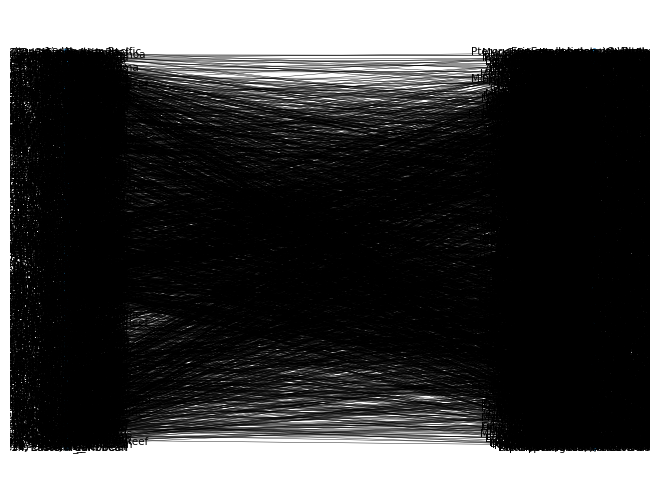

In [ ]:
#widths = list(nx.get_edge_attributes(B_1,'weight').values())
B_1_top = {n for n, d in B_1.nodes(data=True) if d["bipartite"] == 0}
pos = nx.bipartite_layout(B_1, B_1_top)
nx.draw(B_1, pos = nx.drawing.layout.bipartite_layout(B_1,B_1_top,align='vertical',scale =300, aspect_ratio = 1000), width = 0.3, node_size = 10,font_size = 7.5, with_labels = True)
plt.show()

# Gerando as componentes conexas

In [ ]:
Gcc = sorted(nx.connected_components(B_1), key=len, reverse=True)
G0 = B_1.subgraph(Gcc[0]) #0,1,2,4,10 teste

print(G0)

Graph with 274 nodes and 415 edges


In [ ]:
G0_top = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
pos = nx.bipartite_layout(G0, G0_top)

#nx.draw(G0, pos = nx.drawing.layout.bipartite_layout(G0, G0_top,align='vertical',scale =300, aspect_ratio = 1000), width = 0.3, node_size = 10,font_size = 7.5, with_labels = True)
#plt.show()

# Parâmetros

In [ ]:
#grafo
G = G0

# Definir os parâmetros do modelo
r0_s =0.185 # Taxa de crescimento das algas
r0_h = 0.185  # Taxa de crescimento dos corais
zi = 26   # Temperatura ótim

# Definir os valores iniciais das populações
y0_simb = len(G0_top)*(1000,)
y0_host = (len(G0)-len(G0_top))*(100,)
y0 = np.concatenate([y0_simb,y0_host])
num_simb = len(y0_simb)
num_host = len(y0_host)

# Definir o vetor de tempo
t = np.linspace(0, 1500, 1500)

#lista_temperaturas = [4 * np.cos(temp / 75 + 36.9) + 26 for temp in t]
#lista_temperaturas = [4 * np.cos(temp / 75 + 26.5) + 26 for temp in t]
lista_temperaturas = [4 * np.cos(temp / 75 + 22) + 26 for temp in t]

print(lista_temperaturas)

[np.float64(22.000156694421452), np.float64(22.00098507603412), np.float64(22.002525331936223), np.float64(22.004777187943095), np.float64(22.007740243196412), np.float64(22.01141397023557), np.float64(22.01579771509156), np.float64(22.02089069740338), np.float64(22.02669201055698), np.float64(22.033200621846618), np.float64(22.040415372658693), np.float64(22.04833497867802), np.float64(22.056958030116437), np.float64(22.066282991963767), np.float64(22.07630820426106), np.float64(22.087031882396108), np.float64(22.098452117421104), np.float64(22.110566876392472), np.float64(22.12337400273276), np.float64(22.136871216614523), np.float64(22.151056115366174), np.float64(22.16592617389968), np.float64(22.181478745160067), np.float64(22.197711060596625), np.float64(22.214620230655736), np.float64(22.23220324529527), np.float64(22.250456974520393), np.float64(22.269378168940747), np.float64(22.288963460348892), np.float64(22.309209362319876), np.float64(22.330112270831876), np.float64(22.351

# Modelo de Branqueamento

In [ ]:
def c_0(G):
  bipart = nx.get_node_attributes(G, "bipartite")
  tal_s = nx.get_node_attributes(G, "simb_tol")
  tal_h = nx.get_node_attributes(G, "host_tol")

  alga_nodes = [n for n in G.nodes() if bipart[n] == 0]
  host_nodes = [n for n in G.nodes() if bipart[n] == 1]
  alga_index = {n: i for i, n in enumerate(alga_nodes)}
  host_index = {n: i for i, n in enumerate(host_nodes, len(alga_nodes))}

  interaction_simb = []
  interaction_host = []

  for node in G.nodes():
    if bipart[node] == 0:
      i = alga_index[node]
      tals = tal_s[node]
      interaction= sum([np.log(100) / max(1,G.degree(j)) for j in G.neighbors(node)])
      interaction_simb.append(interaction)

    else:
      j = host_index[node]
      talh = tal_h[node]
      interaction = sum([np.log(1000) / max(1,G.degree(i)) for i in G.neighbors(node)])
      interaction_host.append(interaction)

  return np.mean(interaction_simb), np.mean(interaction_host)

In [ ]:
c_0s = c_0(G)[0]
c_0h = c_0(G)[1]
print(c_0s)
print(c_0h)

11.99768022139003
2.651461622235568


In [ ]:
def pop_dynamics(y, tempo, num_simb, num_host, G, zi, r0_s, r0_h, c_0s, c_0h, lista_temperaturas, vetor_tempo):
  dPdt = np.zeros(num_simb + num_host)

  bipart = nx.get_node_attributes(G, "bipartite")
  tal_s = nx.get_node_attributes(G, "simb_tol")
  tal_h = nx.get_node_attributes(G, "host_tol")

  indice_tempo = np.argmin(np.abs(vetor_tempo - tempo))
  Ti = lista_temperaturas[indice_tempo]

  alga_nodes = [n for n in G.nodes() if bipart[n] == 0]
  host_nodes = [n for n in G.nodes() if bipart[n] == 1]
  alga_index = {n: i for i, n in enumerate(alga_nodes)}
  host_index = {n: i for i, n in enumerate(host_nodes, len(alga_nodes))}

  gama_r = 0.0008
  gama_m = 0.001
  gamma_c = 0.01
  mu = 0.1
  lista = []

  for node in G.nodes():
    if bipart[node] == 0:
      i = alga_index[node]
      tals = tal_s[node]
      r_Si = (r0_s / np.sqrt(2 * np.pi)) * np.exp(-gama_r*((Ti - zi)**2) / (tals**2))
      if Ti <= zi:
        m_Si = mu
      else:
        m_Si = 1 - np.exp(-gama_m*((Ti - zi)**2) / (tals**2)) + mu
      pop = max(y[i], 0)
      c_is= sum([np.log(1 + y[host_index[j]]) / max(1,G.degree(j)) for j in G.neighbors(node)])
      dPdt[i] = (r_Si*pop) + ((pop/ G.degree(node))*((r_Si)/(1 + np.exp(-gamma_c*(c_is - c_0s))))) - (m_Si*pop)
      #print(f"nó: {node}, r_Si: {r_Si}, interaction: {((r_Si)/(1 + np.exp(-gamma_c*(c_is - c_0s))))}, dev: {dPdt[i]}")

    else:
      j = host_index[node]
      talh = tal_h[node]
      r_Hi = (r0_h / np.sqrt(2 * np.pi)) * np.exp(-gama_r*((Ti - zi)**2) / (talh**2))
      if Ti <= zi:
        m_Hi = mu
      else:
        m_Hi = 1 - np.exp(-gama_m*((Ti - zi)**2) / (talh**2)) + mu
      pop = max(y[j], 0)
      c_ih = sum([np.log(y[alga_index[i]]+1) / max(1,G.degree(i)) for i in G.neighbors(node)])
      dPdt[j] = (r_Hi*pop) + ((pop / G.degree(node))*((r_Hi)/(1 + np.exp(-gamma_c*(c_ih - c_0h))))) - (m_Hi*pop)
      #print(f'nó: {node}, r_Hi: {r_Hi}, interaction: {((r_Hi)/(1 + np.exp(-gamma_c*(c_ih - c_0h))))}, dev: {dPdt[j]}')

  return dPdt

In [ ]:
def resolver_sistema(num_simb, num_host, G, zi, r0_s, r0_h, y0, t,  c_0s, c_0h,lista_temperaturas):
    resultado = odeint(pop_dynamics, y0, t, args=(num_simb, num_host, G, zi, r0_s, r0_h, c_0s, c_0h, lista_temperaturas, t))
    return resultado[:, :num_simb], resultado[:, num_simb:]

ret_simb, ret_host = resolver_sistema(num_simb, num_host, G0, zi, r0_s, r0_h, y0, t, c_0s, c_0h, lista_temperaturas)

In [ ]:
count = 0
for i in ret_simb.T:
  if min(i) < 1:
    count +=1
print(f'{count}/{len(ret_simb.T)}')

count = 0
for i in ret_host.T:
  if min(i) < 1:
    count +=1
print(f'{count}/{len(ret_host.T)}')

73/76
131/198


In [ ]:
              #simb          #host
# florida     24/26          18/32
# caribe      36/36          28/61
# indico      42/43          117/131
# phuket      35/36          132/152
# gbr         73/76          131/198

# Desvio padrão

In [ ]:
std_simb = []
for i in range(len(ret_simb)):
  std_simb.append(np.std(ret_simb[i]))

print(std_simb)

std_host = []
for i in range(len(ret_host)):
  std_host.append(np.std(ret_host[i]))

print(std_host)

[0.0, 8267.286295441485, 17164.363731464917, 26659.088092885093, 36708.174818400206, 47257.32267693886, 58241.59286465906, 69586.23413154493, 81208.12398230692, 93017.89603037635, 104922.67486394722, 116829.2429349923, 128647.2735187679, 140292.1543005405, 151687.43445411656, 162766.59439949295, 173474.05901637752, 183765.5041783903, 193607.58267281877, 202977.22434041428, 211860.66297066447, 220252.32006459395, 228153.64334696042, 235571.96659516406, 242519.43182647525, 249011.99649218284, 255068.536554109, 260710.04946506405, 265958.9571607967, 270838.5067984628, 275372.2652675145, 279583.7021510528, 283495.85461564356, 287131.0663101939, 290510.7927206309, 293655.46358464466, 296584.3941021832, 299315.7366813187, 301866.4654539721, 304252.38669992174, 306488.1689910088, 308587.3879982001, 310562.58157506183, 312425.31157789525, 314186.2296071745, 315855.1444686751, 317441.0897695467, 318952.39021634415, 320396.72606109607, 321781.19489118457, 323112.3704603996, 324396.35858087835, 3

In [ ]:
std_simb_gbr = [0.0, 8635.984910207753, 18019.044573280677, 28102.359353959233, 38824.232687841, 50110.94429189978, 61879.570545509196, 74040.3050654954, 86498.20843959846, 99154.70804175083, 111909.31722337594, 124661.962843091, 137315.77569469143, 149779.61776690587, 161970.52298137243, 173815.51209587127, 185252.63190981053, 196231.3219332857, 206712.29320295152, 216667.08567444916, 226077.41052978864, 234934.33091783596, 243237.30923216086, 250993.14859900245, 258214.8666972457, 264920.5483284627, 271132.2248865515, 276874.82305288716, 282175.21429740405, 287061.38474759925, 291561.73358884297, 295704.49912088155, 299517.30507734406, 303026.8157518315, 306258.48629896337, 309236.39404602133, 311983.1369207535, 314519.78611122747, 316865.8814834684, 319039.4597163526, 321057.1066640433, 322934.0268708327, 324684.1244869372, 326320.090987584, 327853.4961884093, 329294.8796638799, 330653.8407378337, 331939.12554939464, 333158.7101885828, 334319.8793568533, 335429.3002959224, 336493.0918335436, 337516.88865223934, 338505.90104947943, 339464.97043445753, 340398.6209088069, 341311.1073695447, 342206.4607669855, 343088.53010274493, 343961.0230983519, 344827.5442449842, 345691.6322699528, 346556.7961438602, 347426.5510266074, 348304.4539088556, 349194.13978967606, 350099.3585477915, 351024.0130564535, 351972.19887601107, 352948.24593993765, 353956.7626012501, 355002.6824282053, 356091.31400832854, 357228.3941833979, 358420.14468571043, 359673.3328635055, 360995.3359298145, 362394.20844690374, 363878.75453690824, 365458.60132307175, 367144.27584123396, 368947.2827672928, 370880.1798849533, 372956.6541538477, 375191.5894836502, 377601.1259601224, 380202.7080846163, 383015.1151715641, 386058.46615148045, 389354.19094247755, 392924.96833288396, 396794.61543094204, 400987.9041091003, 405530.33153072617, 410447.77896196255, 415766.10137503245, 421510.592128799, 427705.3393121711, 434372.459288061, 441531.2114018094, 449197.00906555855, 457380.35822668637, 466085.7749073198, 475310.75624374684, 485044.8978740791, 495269.2569404568, 505956.04449483246, 517068.68484137027, 528562.2081725127, 540383.8577101658, 552473.7350905571, 564765.3086093876, 577185.6945984005, 589655.7460997073, 602089.8161799209, 614396.4448822611, 626480.0003181256, 638242.7762088237, 649587.8621591203, 660422.6304627064, 670662.5361759989, 680234.8446682806, 689081.8719232426, 697163.362783094, 704457.7488737927, 710962.1907277878, 716691.4815909547, 721676.0211076082, 725959.1371708725, 729594.045020162, 732640.7060852604, 735162.8028762199, 737224.9953395501, 738890.5738587832, 740219.5776051935, 741267.4041722774, 742083.8989123655, 742712.8823981116, 743192.053474985, 743553.1899427649, 743822.5685499669, 744021.5260180546, 744167.0932393019, 744272.6466642786, 744348.5351795327, 744402.6534274487, 744440.9451600699, 744467.8328025894, 744486.5711588761, 744499.5318623687, 744508.4271075275, 744514.482810866, 744518.5699994339, 744521.3029236816, 744523.1115664043, 744524.2943379241, 744525.0583225599, 744525.544040848, 744525.8477837933, 744526.0336030765, 744526.1443378779, 744526.2082621389, 744526.2433486088, 744526.2614118919, 744526.2696089383, 744526.2724059361, 744526.2724892285, 744526.271323019, 744526.2696763702, 744526.2679043614, 744526.2665390929, 744526.2653577192, 744526.2645043624, 744526.2638335059, 744526.2633674816, 744526.2630395817, 744526.2628118005, 744526.2626604493, 744526.2625548939, 744526.2624898009, 744526.2624445353, 744526.2624177416, 744526.2623995859, 744526.2623888776, 744526.2623820174, 744526.2623777834, 744526.2623740522, 744526.2623704282, 744526.2623691042, 744526.2623685661, 744526.2623682183, 744526.2623680407, 744526.2623679641, 744526.2623679455, 744526.2623679333, 744526.2623679992, 744526.2623680905, 744526.2623680959, 744526.2623681179, 744526.2623681433, 744526.2623681454, 744526.2623681541, 744526.2623681627, 744526.2623681633, 744526.2623681661, 744526.2623681681, 744526.2623681683, 744526.2623681689, 744526.2623681697, 744526.2623681888, 744526.2623682446, 744526.2623683445, 744526.2623684922, 744526.2623686857, 744526.2623689136, 744526.2623691532, 744526.2623693652, 744526.2623694901, 744526.2623695193, 744526.2623696269, 744526.262369835, 744526.2623701448, 744526.2623705462, 744526.2623710145, 744526.2623715077, 744526.2623719613, 744526.262372286, 744526.2623723743, 744526.2623723908, 744526.2623724313, 744526.2623724963, 744526.2623725842, 744526.2623726903, 744526.2623728067, 744526.2623729199, 744526.262373012, 744526.2623730588, 744526.2623730603, 744526.2623730609, 744526.2623730619, 744526.2623730632, 744526.2623730651, 744526.2623730672, 744526.2623730693, 744526.2623730713, 744526.2623730727, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.2623730729, 744526.2623730729, 744526.262373073, 744526.2623730729, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.262373073, 744526.2623730729, 744526.262373073, 744526.262373073, 744526.262373073, 744526.2623730729, 744526.262373073, 744526.262373073, 744526.2623730729, 744526.262373073, 744526.262373073, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.262373073, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730728, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730729, 744526.2623730728, 744526.2623730729, 744526.2623730728, 744526.2623730728, 744526.2623730728, 744526.2623730728, 744526.2623730728, 744526.2623730729, 744526.2623730728, 744526.2623730728, 744526.2623730729, 744526.2623730729, 744526.2623730727, 744526.2623730728, 744526.2623730729, 744526.2623730729, 744526.2623730727, 744526.2623730727, 744526.2623730729, 744526.2623730728, 744526.2623730729, 744526.2623730727, 744526.2623730729, 744526.2623730727, 744526.2623730728, 744526.2623730727, 744526.2623730727, 744526.2623730727, 744526.2623730728, 744526.2623730727, 744526.2623730728, 744526.2623730727, 744526.2623730727, 744526.2623730727, 744526.2623730727, 744526.2623730727, 744526.2623730638, 744526.2623730267, 744526.2623729572, 744526.262372853, 744526.262372711, 744526.2623725284, 744526.2623723026, 744526.2623720302, 744526.2623717089, 744526.2623713356, 744526.2623709074, 744526.2623704216, 744526.2623698751, 744526.2623692652, 744526.2623685893, 744526.2623678441, 744526.2623670271, 744526.2623661351, 744526.2623651656, 744526.2623588992, 744526.2623521487, 744526.2623453983, 744526.262337079, 744526.2623191257, 744526.2622997861, 744526.2622623513, 744526.2622136021, 744526.2621427379, 744526.2620378739, 744526.2618805617, 744526.2616820645, 744526.2613928643, 744526.2609783704, 744526.2604087007, 744526.2596381044, 744526.258628988, 744526.2573679896, 744526.2558920761, 744526.2543430029, 744526.2530881129, 744526.2528247802, 744526.2549011528, 744526.2616586684, 744526.277001371, 744526.3074965652, 744526.3636059429, 744526.461773059, 744526.6274734611, 744526.8995459276, 744527.3365828891, 744528.0260166593, 744529.097340089, 744530.7395294906, 744533.227381785, 744536.9571668224, 744542.4960971437, 744550.650153009, 744562.5557455642, 744579.8047218777, 744604.6081045473, 744640.0092905924, 744690.152565768, 744760.6374595609, 744858.9205838031, 744994.8178867425, 745181.0688404138, 745433.9612208154, 745773.9895797246, 746226.4977045343, 746822.260881647, 747597.9302001758, 748596.2623645102, 749866.05417097, 751461.7018869725, 753442.3263138705, 755870.4086030169, 758809.9668765767, 762324.2673974581, 766473.1690972125, 771310.2083157838, 776879.5810105694, 783213.2156158772, 790328.1696781908, 798224.6170667969, 806884.6988871649, 816272.4779331774, 826335.1257805318, 837005.2807190866, 848204.286929768, 859845.820145914, 871839.3363005421, 884092.8826396255, 896515.0686491579, 909016.2918996493, 921509.7462229659, 933912.3325549173, 946144.9830885439, 958133.6493880022, 969810.5631634044, 981115.5209353743, 991997.0046205155, 1002412.9866154015, 1012331.3322531339, 1021729.7764505032, 1030595.5050096397, 1038924.4104317743, 1046720.1116161717, 1053992.8321344028, 1060758.224168828, 1067036.2098890285, 1072849.893862799, 1078224.5817557953, 1083186.9246623118, 1087764.1956864533, 1091983.6964036103, 1095872.2847091502, 1099456.0119755645, 1102759.8559295072, 1105807.534734852, 1108621.3891081489, 1111222.3195460574, 1113629.7674663318, 1115861.73039121, 1117934.8027473765, 1119864.2352417698, 1121664.007165021, 1123346.906125384, 1124924.6135008843, 1126407.7903024643, 1127806.1629412416, 1129128.607153727, 1130383.2282856605, 1131577.4379094657, 1132718.0262540847, 1133811.2300922363, 1134862.7961674943, 1135878.0405076116, 1136861.9035653048, 1137819.0010598209, 1138753.6733300043, 1139670.0290807325, 1140571.9889955232, 1141463.3252873896, 1142347.7009287293, 1143228.7066264823, 1144109.89751508, 1144994.829054962, 1145887.0930847817, 1146790.3541674784, 1147708.3867791267, 1148645.11370726, 1149604.6460850185, 1150591.3254646873, 1151609.7682854112, 1152664.9133058998, 1153762.072248977, 1154906.983665309, 1156105.8704241228, 1157365.502489487, 1158693.26154123, 1160097.2115721868, 1161586.1747573263, 1163169.8044118641, 1164858.6667035776, 1166664.3217365763, 1168599.406537606, 1170677.7147403304, 1172914.2640374543, 1175325.3669708723, 1177928.686152856, 1180743.2641192842, 1183789.5335289834, 1187089.2933455668, 1190665.647663413, 1194542.8822678374, 1198746.284443986, 1203301.8925805164, 1208236.1403285651, 1213575.4144343736, 1219345.4918764913, 1225570.8548785716, 1232273.8844499805, 1239473.930957184, 1247186.286094958, 1255421.0833272147, 1264182.1877808394, 1273466.1449418105, 1283261.283705805, 1293547.0715012809, 1304293.8089459504, 1315462.7129833843, 1327006.3744975585, 1338869.4982231352, 1350989.7649403617, 1363298.6316873133, 1375721.9285734517, 1388180.1822009603, 1400588.441568535, 1412856.9022713727, 1424892.218041491, 1436599.2208608415, 1447883.4570283939, 1458654.4641560912, 1468829.5077963907, 1478337.341658741, 1487121.5159329255, 1495142.805998509, 1502380.4872148596, 1508832.3717491354, 1514513.70285031, 1519455.1299357815, 1523700.0467418465, 1527301.578774231, 1530319.4758172177, 1532817.1200917289, 1534858.8118475317, 1536507.4468142593, 1537822.6538446248, 1538859.419736951, 1539667.1909622794, 1540289.4112917958, 1540763.432102181, 1541120.7193190192, 1541387.2768381457, 1541584.2086249588, 1541728.3521974331, 1541832.9275678052, 1541908.1601130834, 1541961.8496086828, 1541999.869630379, 1542026.591365491, 1542045.2336858038, 1542058.1421990737, 1542067.012017296, 1542073.0578121073, 1542077.143788184, 1542079.8797238078, 1542081.6932268424, 1542082.88186933, 1542083.6509920552, 1542084.1415016556, 1542084.449110405, 1542084.6380663218, 1542084.7507045425, 1542084.8159590603, 1542084.8521720248, 1542084.8710489485, 1542084.8797695013, 1542084.8830371283, 1542084.8833907845, 1542084.8824917304, 1542084.8810733834, 1542084.8796730384, 1542084.8784050199, 1542084.87739745, 1542084.876600591, 1542084.8760209964, 1542084.875593012, 1542084.8752722563, 1542084.8749660635, 1542084.8747544952, 1542084.874640738, 1542084.8745270527, 1542084.8744673599, 1542084.8744301023, 1542084.8743942082, 1542084.8743810242, 1542084.8743717277, 1542084.874364473, 1542084.874361884, 1542084.874359589, 1542084.874358189, 1542084.8743576913, 1542084.8743573797, 1542084.8743572116, 1542084.874357165, 1542084.8743571867, 1542084.8743571716, 1542084.8743571928, 1542084.8743572216, 1542084.874357407, 1542084.874358081, 1542084.8743592277, 1542084.8743605134, 1542084.8743611036, 1542084.8743614228, 1542084.8743623092, 1542084.8743636422, 1542084.8743649612, 1542084.874365397, 1542084.8743654732, 1542084.874365653, 1542084.874365903, 1542084.8743661286, 1542084.8743661798, 1542084.8743661807, 1542084.8743661828, 1542084.8743661854, 1542084.874366187, 1542084.8743661875, 1542084.8743661875, 1542084.8743661873, 1542084.874366187, 1542084.874366187, 1542084.874366187, 1542084.874366187, 1542084.874366187, 1542084.874366187, 1542084.8743661873, 1542084.8743661875, 1542084.8743661873, 1542084.874366187, 1542084.8743661873, 1542084.8743661875, 1542084.8743661873, 1542084.874366187, 1542084.8743661868, 1542084.8743661866, 1542084.8743661859, 1542084.8743661854, 1542084.8743661847, 1542084.874366184, 1542084.874366183, 1542084.874366182, 1542084.8743661807, 1542084.874366179, 1542084.8743661777, 1542084.8743661758, 1542084.8743661742, 1542084.8743661724, 1542084.87436617, 1542084.8743661677, 1542084.8743661651, 1542084.8743661626, 1542084.8743661598, 1542084.8743661568, 1542084.874366154, 1542084.8743661512, 1542084.8743661477, 1542084.8743661444, 1542084.8743661407, 1542084.8743661372, 1542084.8743661337, 1542084.8743661297, 1542084.8743661263, 1542084.8743661225, 1542084.8743661183, 1542084.8743661146, 1542084.8743661111, 1542084.8743661074, 1542084.8743661037, 1542084.8743661002, 1542084.8743660967, 1542084.8743660934, 1542084.8743660906, 1542084.8743660878, 1542084.8743660855, 1542084.8743660832, 1542084.8743660813, 1542084.8743660797, 1542084.8743660785, 1542084.8743660783, 1542084.8743660783, 1542084.874366078, 1542084.8743660776, 1542084.874366077, 1542084.8743660762, 1542084.8743660753, 1542084.874366074, 1542084.8743660727, 1542084.8743660704, 1542084.8743660687, 1542084.8743660667, 1542084.8743660643, 1542084.8743660618, 1542084.874366059, 1542084.8743660564, 1542084.8743660531, 1542084.8743660497, 1542084.8743660464, 1542084.8743660427, 1542084.874366039, 1542084.8743660348, 1542084.8743660306, 1542084.8743660264, 1542084.8743660217, 1542084.8743660173, 1542084.8743660129, 1542084.874366008, 1542084.874366003, 1542084.8743659984, 1542084.8743659935, 1542084.8743659887, 1542084.8743659838, 1542084.874365979, 1542084.874365974, 1542084.874365969, 1542084.8743659647, 1542084.87436596, 1542084.8743659558, 1542084.8743659519, 1542084.8743659477, 1542084.8743659442, 1542084.8743659407, 1542084.8743659377, 1542084.874365935, 1542084.874365933, 1542084.8743659311, 1542084.8743659293, 1542084.8743659284, 1542084.8743659281, 1542084.8743659284, 1542084.8743659281, 1542084.8743659281, 1542084.8743659281, 1542084.874365928, 1542084.874365928, 1542084.874365928, 1542084.8743659274, 1542084.8743659274, 1542084.8743659274, 1542084.8743659272, 1542084.874365927, 1542084.8743659267, 1542084.8743659267, 1542084.8743659265, 1542084.8743659263, 1542084.8743659258, 1542084.8743659258, 1542084.8743659253, 1542084.8743659249, 1542084.8743659249, 1542084.8743659246, 1542084.8743659242, 1542084.874365924, 1542084.8743659235, 1542084.8743659232, 1542084.874365923, 1542084.8743659223, 1542084.8743659223, 1542084.8743659216, 1542084.8743659214, 1542084.874365921, 1542084.874365921, 1542084.8743659202, 1542084.8743659197, 1542084.8743659197, 1542084.8743659193, 1542084.874365919, 1542084.8743659186, 1542084.8743659183, 1542084.8743659183, 1542084.8743659179, 1542084.8743659179, 1542084.8743659179, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.8743659174, 1542084.874365917, 1542084.8743659165, 1542084.874365916, 1542084.874365915, 1542084.874365914, 1542084.874365913, 1542084.8743659111, 1542084.874365909, 1542084.87436589, 1542084.8743658413, 1542084.8743657582, 1542084.8743656352, 1542084.8743654683, 1542084.8743652522, 1542084.8743649824, 1542084.8743646534, 1542084.8743642606, 1542084.8743635027, 1542084.8743601986, 1542084.874353472, 1542084.8743427878, 1542084.8743276135, 1542084.8743074143, 1542084.874281657, 1542084.8742498069, 1542084.8742113304, 1542084.874165694, 1542084.8740757336, 1542084.8739667817, 1542084.8737766235, 1542084.8735787598, 1542084.8732832996, 1542084.8728721542, 1542084.8723042628, 1542084.8715484724, 1542084.8705717288, 1542084.8693779756, 1542084.868032886, 1542084.8667193737, 1542084.8658626364, 1542084.866267765, 1542084.8694168758, 1542084.8779421996, 1542084.896191333, 1542084.9311528043, 1542084.994086046, 1542085.1028048354, 1542085.2846162945, 1542085.5809635527, 1542086.0541648031, 1542086.796829495, 1542087.9455511447, 1542089.6994376627, 1542092.3480137826, 1542096.3066004817, 1542102.1692621585, 1542110.7761946493, 1542123.3107037335, 1542141.4279673868, 1542167.4187134025, 1542204.4222449723, 1542256.7208444814, 1542330.0710934848, 1542432.1256663308, 1542572.9337295806, 1542765.506141861, 1543026.4387091815, 1543376.5696242687, 1543841.6079275908, 1544452.7071397642, 1545246.893286082, 1546267.2781051837, 1547562.9737522807, 1549188.6329408744, 1551203.5544721568, 1553670.3076079965, 1556652.8769860982, 1560214.3642100373, 1564414.3084514667, 1569305.740987228, 1574932.1449373767, 1581324.507525064, 1588498.7148970435, 1596453.5592298196, 1605169.6440031063, 1614609.40992921, 1624718.4055713422, 1635427.7228934777, 1646657.3010682124, 1658319.6166778256, 1670323.2119147377, 1682575.6086943538, 1694985.3872958303, 1707463.4814886313, 1719924.2250384924, 1732286.0979515298, 1744471.8675411176, 1756409.3853964808, 1768032.6710563006, 1779283.081498189, 1790110.3843189522, 1800473.5674389661, 1810341.270576515, 1819691.8016255454, 1828512.7523510014, 1836800.281516221, 1844558.1558978134, 1851796.646014903, 1858531.3659386055, 1864782.1301063837, 1870571.8809249706, 1875925.7220534203, 1880870.076126058, 1885431.9731494433, 1889638.4668789261, 1893516.1705500684, 1897090.900006815, 1900387.4108384703, 1903429.2151103718, 1906238.465042221, 1908835.890776481, 1911240.7813811363, 1913470.9993499136, 1915543.0203898812, 1917471.9915862286, 1919271.8024314092, 1920955.16295537, 1922533.6882587045, 1924017.9828226229, 1925417.7251547442, 1926741.7507755046, 1927998.1313513003, 1929194.2505168114, 1930336.8756531577, 1931432.2249219015, 1932486.0302063907, 1933503.595937973, 1934489.853940714, 1935449.4137453742, 1936386.6112388459, 1937305.5533941987, 1938210.1600561142, 1939104.2050139217, 1939991.3536442434, 1940875.2009346809, 1941759.307391078, 1942647.2353521672, 1943542.5848529788, 1944449.030111121, 1945370.3567751984, 1946310.5004383188, 1947273.5868248034, 1948263.9740438054, 1949286.2973362375, 1950345.5166341283, 1951446.9673663175, 1952596.415175719, 1953800.1138012484, 1955064.866652916, 1956398.0953032558, 1957807.9094194735, 1959303.1777758007, 1960893.610388859, 1962589.8356670856, 1964403.4856130104, 1966347.2786071345, 1968435.089977091, 1970682.0421085507, 1973104.5586398824, 1975720.415732071, 1978548.782720436, 1981610.2364437093, 1984926.724679015, 1988521.4959180618, 1992418.9939005768, 1996644.6614131986, 2001224.6737489395, 2006185.5892223872, 2011553.8886920984, 2017355.3984566364, 2023614.5957925871, 2030353.7828222935, 2037592.1429490242, 2045344.698219563, 2053621.1969806303, 2062424.997804628, 2071752.0141455203, 2081589.8222205176, 2091917.025154913, 2102702.962762638, 2113907.815977497, 2125483.093665007, 2137372.413600446, 2149512.421898016, 2161833.665793732, 2174261.2697423995, 2186715.311495097, 2199110.6739818747, 2211357.7376769246, 2223363.616386479, 2235033.8175654747, 2246274.7275589197, 2256996.8558963127, 2267118.5566877737, 2276569.7771326015, 2285295.337885689, 2293257.313804227, 2300436.2438998427, 2306831.101741807, 2312458.133332978, 2317348.7946691923, 2321547.072683207, 2325106.4735501455, 2328086.9290500106, 2330551.827606705, 2332565.328060571, 2334190.067325555, 2335485.3296205467, 2336505.7006442486, 2337300.1970721525, 2337911.827721399, 2338377.523376449, 2338728.358414433, 2338989.9840132557, 2339183.1957889413, 2339324.5689991177, 2339427.1060185004, 2339500.8557539987, 2339553.477883507, 2339590.737164924, 2339616.921769631, 2339635.1875283252, 2339647.83450464, 2339656.524829264, 2339662.4479337665, 2339666.4507359923, 2339669.1307802834, 2339670.9071768806, 2339672.0711482856, 2339672.824373864, 2339673.304699373, 2339673.6057298942, 2339673.7907867953, 2339673.901671358, 2339673.9660360953, 2339674.0016642124, 2339674.019473458, 2339674.02810992, 2339674.030974214, 2339674.031338499, 2339674.0302506406, 2339674.028857519, 2339674.0274128444, 2339674.0261688936, 2339674.0251493813, 2339674.0243615923, 2339674.023782585, 2339674.023357517, 2339674.0230652397, 2339674.022857204, 2339674.022721416, 2339674.0226268293, 2339674.02255572, 2339674.0224765404, 2339674.022422068, 2339674.022401853, 2339674.022378966, 2339674.0223653847, 2339674.022359596, 2339674.0223526093, 2339674.0223492766, 2339674.0223484407, 2339674.0223478754, 2339674.022347575, 2339674.022347436, 2339674.022347381, 2339674.0223473446, 2339674.022347373, 2339674.022347441, 2339674.022347447, 2339674.0223474707, 2339674.022347504, 2339674.022347507, 2339674.022347517, 2339674.0223475276, 2339674.0223476207, 2339674.0223479834, 2339674.022348664, 2339674.0223496445, 2339674.0223507974, 2339674.022351834, 2339674.022352254, 2339674.02235252, 2339674.022353273, 2339674.022354516, 2339674.0223561367, 2339674.022357867, 2339674.022359235, 2339674.0223596045, 2339674.02235968, 2339674.0223598573, 2339674.022360131, 2339674.02236047, 2339674.022360813, 2339674.0223610564, 2339674.0223610955, 2339674.0223610974, 2339674.0223611007, 2339674.0223611053, 2339674.0223611114, 2339674.022361117, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.02236112, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.02236112, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.0223611207, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.0223611207, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.0223611197, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.0223611197, 2339674.02236112, 2339674.0223611197, 2339674.02236112, 2339674.02236112, 2339674.02236112, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.02236112, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611193, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611197, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611197, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.0223611193, 2339674.022361119, 2339674.0223611193, 2339674.022361119, 2339674.022361119, 2339674.0223611174, 2339674.022361116, 2339674.0223611128, 2339674.022361109, 2339674.0223611044, 2339674.0223610983, 2339674.0223610913, 2339674.022361083, 2339674.022361073, 2339674.022361062, 2339674.0223610494, 2339674.022361035, 2339674.022360871, 2339674.0223599784, 2339674.022358207, 2339674.022355452, 2339674.0223516095, 2339674.0223465767, 2339674.0223402483, 2339674.022332521, 2339674.02232329, 2339674.022312452, 2339674.022299903, 2339674.0222855383, 2339674.0222692546, 2339674.0222495454, 2339674.02218541, 2339674.022121274, 2339674.022041724, 2339674.021927913, 2339674.0217318544, 2339674.02152616, 2339674.021215493, 2339674.0207939353, 2339674.0202181228, 2339674.019456537, 2339674.0184811265, 2339674.017310346, 2339674.0160066443, 2339674.014795672, 2339674.014126067, 2339674.0148865357, 2339674.018673617, 2339674.028097556, 2339674.0479444116, 2339674.0857702326, 2339674.152959609, 2339674.2681654464, 2339674.46000828, 2339674.771721848, 2339675.2681647213, 2339676.045644624, 2339677.246221254, 2339679.0768153365, 2339681.8346647643, 2339685.9505733442, 2339692.03854852, 2339700.9647212722, 2339713.952310922, 2339732.698444643, 2339759.559610613, 2339797.7613264495, 2339851.6974091944, 2339927.257215217, 2340032.2697557616, 2340176.9976278846, 2340374.707586968, 2340642.293338833, 2341000.940333503, 2341476.739570846, 2342101.2572979964, 2342911.9476354765, 2343952.347047401, 2345271.9655719684, 2346925.7997926185, 2348973.4149292707, 2351477.5147997085, 2354502.0903461883, 2358110.0731713055, 2362360.63232777, 2367306.217589118, 2372989.5065366304, 2379440.4641444106, 2386673.7581106406, 2394686.8191456674, 2403458.8066890887, 2412950.72521499, 2423106.7802755623, 2433856.8898581816, 2445120.0400656504, 2456808.0013903254, 2468828.8655640404, 2481089.961401781, 2493499.933914839, 2505970.0385241504, 2518415.213058354, 2530754.7115114555, 2542912.2028989545, 2554816.520908296, 2566402.6878874768, 2577613.04068025, 2588398.2738271803, 2598718.230661295, 2608542.3258465, 2617849.5524331345, 2626628.092516705, 2634874.5966813583, 2642593.224048085, 2649794.5407349416, 2656494.365875152, 2662712.6374748787, 2668472.3509629974, 2673798.6043266007, 2678717.767665818, 2683256.7827171236, 2687442.589111303, 2691301.6689681485, 2694859.6968048476, 2698141.2825258775, 2701169.7927596155, 2703967.2377996864, 2706554.2118129637, 2708949.875463823, 2711171.9714947157, 2713236.8650237946, 2715159.601655739, 2716953.9784248327, 2718632.6225705873, 2720207.0741954395, 2721687.870838246, 2723084.631735897, 2724406.139646731, 2725660.419794368, 2726854.815181528, 2727996.057646065, 2729090.3348598825, 2730143.3519047913, 2731160.390359958, 2732146.3628919963, 2733105.8632452353, 2734043.214675495, 2734962.5136503614, 2735867.6728262682, 2736762.4604432, 2737650.539265638, 2738535.5034066234, 2739420.914977512, 2740310.33991455, 2741207.3841060125, 2742115.729816338, 2743039.1730514094, 2743981.6621759846, 2744947.3382390696, 2745940.5774173792, 2746966.0359521178, 2748028.6979188984, 2749133.926537543, 2750287.5188649893, 2751495.7635709187, 2752765.5049181003, 2754104.2097174735, 2755520.0345372483, 2757021.9054365526, 2758619.5976993297, 2760323.807499472, 2762146.2411403647, 2764099.696515812, 2766198.139754994, 2768456.792952261, 2770892.183383483, 2773522.1951575466]

std_host_gbr = [0.0, 7446.866352460506, 15460.82833952315, 24036.502145075083, 33154.842637220485, 42788.02386812702, 52917.91084431288, 63560.98235169503, 74763.94720519324, 86534.42373018102, 98741.62258251509, 111090.24885401598, 123216.4076534799, 134828.85962269138, 145785.32351905675, 156074.20463958496, 165749.84594480656, 174876.78351029468, 183504.1360344193, 191663.11529319343, 199373.76306890915, 206651.94704718518, 213513.61136616053, 219976.45223514148, 226060.0518705832, 231785.34483402935, 237173.9264037805, 242247.43231696638, 247027.06238151266, 251533.25015166646, 255785.4551621746, 259802.04937161232, 263600.27201304346, 267196.2318678945, 270604.94081339595, 273840.3666104348, 276915.49632643076, 279842.40442337166, 282632.32152905274, 285295.70144060353, 287842.2845713318, 290281.15776847163, 292620.8095047846, 294869.1809915165, 297033.7132878531, 299121.39059878525, 301138.78036529035, 303092.07040466927, 304987.10343302484, 306829.4093053564, 308624.2353035269, 310376.57465236576, 312091.1935873686, 313772.65709693875, 315425.3535478786, 317053.5183373868, 318661.2567628918, 320252.56619053363, 321831.3576782897, 323401.4771726335, 324966.72637827427, 326530.8834239162, 328097.72342457593, 329671.0390439546, 331254.66115599085, 332852.47969738627, 334468.4648359072, 336106.6884854457, 337771.34630479413, 339466.7802365963, 341197.5016455915, 342968.2151222423, 344783.84303601325, 346649.55073742557, 348570.7726553006, 350553.23895363737, 352603.003020739, 354726.4695337946, 356930.42278919596, 359222.0558742069, 361608.9990404049, 364099.34835917514, 366701.69356680615, 369425.1447936724, 372279.35627968906, 375274.5482863638, 378421.5249953985, 381731.68604421656, 385217.0321227906, 388890.161424281, 392764.2543773526, 396853.0451908121, 401170.77534252085, 405732.1259174569, 410552.12552687613, 415646.0233549331, 421029.13024510903, 426716.6109837601, 432723.22813389514, 439063.0281657745, 445748.97019136086, 452792.5080963633, 460203.15560788143, 467988.09634424146, 476151.92172684585, 484696.5689455941, 493621.45347655436, 502923.6766409039, 512598.08243743633, 522636.6108606443, 533025.1435034742, 543734.1554832038, 554701.0996040392, 565812.5266221011, 576905.4260841127, 587799.6944358153, 598344.9655575063, 608447.9882405162, 618065.5730667885, 627179.1023727349, 635774.2320727874, 643834.7953906734, 651345.9694563935, 658299.0835843231, 664694.216575238, 670540.315212278, 675853.8908488919, 680657.2449443938, 684976.7388940355, 688841.3156018378, 692281.3287730992, 695327.6677787233, 698011.1359664544, 700362.0266424967, 702409.8395655837, 704183.0870432458, 705709.1496711468, 707014.1548635087, 708122.8638642083, 709058.5634054863, 709842.96552884, 710496.1228011503, 711036.366911068, 711480.2772222164, 711842.6830799902, 712136.7002428138, 712373.7992082183, 712563.9006753933, 712715.4920154787, 712835.7580214845, 712930.7192408532, 713005.3718293124, 713063.8237125652, 713109.4233844595, 713144.8787593062, 713172.3631926195, 713193.6096179313, 713209.99168636, 713222.5922379178, 713232.2612020127, 713239.6631364482, 713245.3158359443, 713249.621766765, 713252.8929841216, 713255.3708979754, 713257.2419670173, 713258.6502557652, 713259.7062327743, 713260.4952293229, 713261.0821619793, 713261.5171210195, 713261.8378680731, 713262.0734408589, 713262.2455349247, 713262.3707240821, 713262.461284625, 713262.5265063567, 713262.5732107295, 713262.6063975027, 713262.6297429182, 713262.6463311837, 713262.6579212587, 713262.6659774872, 713262.6716158879, 713262.6754495332, 713262.6781117828, 713262.6799278262, 713262.681146007, 713262.6819890144, 713262.6825404912, 713262.6829136853, 713262.6831636041, 713262.683322486, 713262.6834333579, 713262.6835024618, 713262.6835474535, 713262.6835779928, 713262.683595723, 713262.6836068683, 713262.683603328, 713262.6835870306, 713262.683575726, 713262.6835758715, 713262.6835703542, 713262.6835620651, 713262.6835599345, 713262.6835586648, 713262.6835555299, 713262.6835527018, 713262.6835525731, 713262.6835521433, 713262.6835514413, 713262.6835511357, 713262.6835510612, 713262.683550854, 713262.6835506269, 713262.6835505959, 713262.6835505662, 713262.6835505127, 713262.6835504788, 713262.6835504761, 713262.6835504667, 713262.6835504544, 713262.6835504513, 713262.68355045, 713262.6835504478, 713262.6835504455, 713262.6835504071, 713262.6835502512, 713262.6835499527, 713262.683549491, 713262.6835488527, 713262.6835480349, 713262.6835470496, 713262.6835459288, 713262.6835447295, 713262.6835435396, 713262.6835424845, 713262.6835417342, 713262.6835414959, 713262.6835412676, 713262.6835406658, 713262.6835396617, 713262.6835382448, 713262.6835364277, 713262.68353425, 713262.6835317853, 713262.6835291455, 713262.683526488, 713262.6835240213, 713262.683522012, 713262.6835207929, 713262.6835205927, 713262.6835205044, 713262.6835203172, 713262.6835200267, 713262.6835196338, 713262.683519145, 713262.6835185739, 713262.6835179427, 713262.683517283, 713262.6835166374, 713262.6835160604, 713262.6835156209, 713262.6835154025, 713262.6835153934, 713262.6835153911, 713262.683515387, 713262.6835153808, 713262.6835153729, 713262.6835153631, 713262.683515352, 713262.6835153399, 713262.6835153274, 713262.6835153155, 713262.6835153053, 713262.6835152981, 713262.6835152955, 713262.6835152955, 713262.6835152955, 713262.6835152955, 713262.6835152956, 713262.6835152955, 713262.6835152955, 713262.6835152955, 713262.6835152955, 713262.6835152956, 713262.6835152956, 713262.6835152955, 713262.6835152955, 713262.6835152955, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152955, 713262.6835152955, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152955, 713262.6835152955, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152955, 713262.6835152955, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152955, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152957, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152956, 713262.6835152957, 713262.6835152956, 713262.6835152957, 713262.6835152957, 713262.6835152957, 713262.6835152957, 713262.6835152956, 713262.6835152957, 713262.6835152957, 713262.6835152957, 713262.6835152957, 713262.6835152964, 713262.683515322, 713262.6835153863, 713262.683515492, 713262.6835156422, 713262.6835158393, 713262.6835160863, 713262.6835163858, 713262.6835167409, 713262.6835171543, 713262.6835176287, 713262.6835181667, 713262.6835187714, 713262.6835194455, 713262.6835201917, 713262.6835210129, 713262.6835219119, 713262.6835228913, 713262.6835239539, 713262.6835251027, 713262.6835263404, 713262.6835276698, 713262.6835290934, 713262.6835306145, 713262.6835322354, 713262.6835339593, 713262.6835479749, 713262.683564933, 713262.6835818911, 713262.6835988492, 713262.6836158073, 713262.6839648138, 713262.684012739, 713262.6840858939, 713262.6841842787, 713262.6843078933, 713262.6844882444, 713262.6847561573, 713262.6851212408, 713262.6856566503, 713262.6864633609, 713262.6876333307, 713262.6893682302, 713262.6918911372, 713262.6955902098, 713262.7008563053, 713262.7086281669, 713262.719715957, 713262.7351649861, 713262.7571617324, 713262.7881236727, 713262.8317372018, 713262.8923336329, 713262.9765412334, 713263.0931329689, 713263.2534147074, 713263.4729595479, 713263.7722273947, 713264.1781958956, 713264.7265436859, 713265.4642197401, 713266.4525413286, 713267.7708101152, 713269.523588487, 713271.846788193, 713274.916253517, 713278.9595927447, 713284.2716563261, 713291.2321903049, 713300.3301248751, 713312.1952344776, 713327.634006107, 713347.6734831166, 713373.6194451373, 713407.1229291405, 713450.2583996805, 713505.6151791236, 713576.4044969132, 713666.5756856499, 713780.9443286315, 713925.3306636966, 714106.7025334446, 714333.3168320227, 714614.8582465873, 714962.5634903392, 715389.3290642301, 715909.7925485573, 716540.3848175908, 717299.3462562537, 718206.7119193615, 719284.2611884132, 720555.4382680816, 722045.2471368404, 723780.123427853, 725787.7821246149, 728097.0320249583, 730737.5435666401, 733739.5433124222, 737133.407769018, 740949.1239694396, 745215.5919896207, 749959.7495372447, 755205.5197559865, 760972.6026406601, 767275.1716197286, 774120.6154099344, 781508.6178952785, 789431.0843251541, 797873.4563784018, 806817.3408692246, 816242.9335086815, 826128.5190610357, 836444.7492684779, 847143.3485572767, 858142.8463785431, 869319.2333980241, 880513.4630393658, 891559.9664447313, 902322.3226646498, 912714.0461039194, 922695.654522568, 932257.2279979631, 941400.863892489, 950130.6756810877, 958450.0204495905, 966362.415612755, 973873.1746136677, 980990.415693392, 987725.2500630303, 994091.4136342737, 1000104.651339468, 1005782.0626578574, 1011141.514483074, 1016201.1601112545, 1020979.0675994584, 1025492.945454596, 1029759.9493877832, 1033796.5536899642, 1037618.4725670103, 1041240.6191419153, 1044677.092124278, 1047941.1824117108, 1051045.393410782, 1054001.4706351599, 1056820.437144101, 1059512.6323672154, 1062087.7525688806, 1064554.8917493708, 1066922.5821666755, 1069198.8339394315, 1071391.173364682, 1073506.6800029965, 1075552.0220327808, 1077533.4902097108, 1079457.0303100194, 1081328.2742000876, 1083152.5694663525, 1084935.007937503, 1086680.4528551493, 1088393.565183645, 1090078.82877231, 1091740.5748326678, 1093383.0055373388, 1095010.217082749, 1096626.2221491928, 1098234.9719886323, 1099840.3781671852, 1101446.3341126142, 1103056.7365757695, 1104675.507106445, 1106306.6135531873, 1107954.0919280795, 1109622.0684647514, 1111314.7821373579, 1113036.607722509, 1114792.0793605389, 1116585.9149165484, 1118423.0409983457, 1120308.618825004, 1122248.0710117456, 1124247.1091192276, 1126311.7623133734, 1128448.4067493211, 1130663.7958721828, 1132965.0916515898, 1135359.8959661005, 1137856.2830887558, 1140462.831606689, 1143188.6561114443, 1146043.4389333583, 1149037.4580490089, 1152181.6137561407, 1155487.4509182852, 1158967.1758585721, 1162633.6623482518, 1166500.449130974, 1170581.7203694328, 1174892.2687923412, 1179447.4307714982, 1184262.9889986478, 1189355.0394963252, 1194739.8056311829, 1200433.3892816356, 1206451.4625036486, 1212808.874948816, 1219519.1890667656, 1226594.1683038396, 1234043.2562387204, 1241873.1784170067, 1250087.794660499, 1258688.3496584715, 1267674.0581357118, 1277042.5362831121, 1286789.0419028949, 1296903.0814949118, 1307361.114879989, 1318115.3043445242, 1329081.4091365992, 1340133.8356617081, 1351117.5719305675, 1361877.6448385995, 1372290.9808216707, 1382280.5821206777, 1391806.561905771, 1400846.779560072, 1409382.6339682075, 1417395.350952164, 1424868.865094418, 1431793.688606952, 1438168.9203566061, 1444002.2294069673, 1449308.6611956842, 1454109.0345030436, 1458428.3542990203, 1462294.4226227335, 1465736.7057175655, 1468785.4575465035, 1471471.0710064268, 1473823.6129434141, 1475872.4958159565, 1477646.2412438279, 1479172.29925296, 1480476.897873288, 1481584.9090234996, 1482519.7250874243, 1483303.1508132492, 1483955.3139763554, 1484494.6028500337, 1484937.6356590958, 1485299.2650658432, 1485592.6174863128, 1485829.1643737531, 1486018.8202276053, 1486170.0625178898, 1486290.0631185602, 1486384.8290290318, 1486459.3429648306, 1486517.7006481797, 1486563.2399789607, 1486598.6595086704, 1486626.1254802356, 1486647.365164048, 1486663.747642128, 1486676.35286285, 1486686.0291223407, 1486693.4383561525, 1486699.0981227637, 1486703.4100937406, 1486706.6863348463, 1486709.1682534888, 1486711.0424077022, 1486712.452976474, 1486713.5105987343, 1486714.300710636, 1486714.8883997158, 1486715.3238017017, 1486715.644824587, 1486715.8805086147, 1486716.0526515087, 1486716.1775305155, 1486716.2673751847, 1486716.3323654823, 1486716.3787521617, 1486716.4116761058, 1486716.4351692742, 1486716.4515549701, 1486716.4631111503, 1486716.4711777854, 1486716.476719024, 1486716.4806009075, 1486716.4832268292, 1486716.4850228631, 1486716.486254602, 1486716.487065975, 1486716.4876271184, 1486716.4879951605, 1486716.4882358985, 1486716.4884022465, 1486716.488505203, 1486716.4885734299, 1486716.4885937343, 1486716.4885675062, 1486716.4885390713, 1486716.4885470816, 1486716.4885381614, 1486716.48851835, 1486716.4885126867, 1486716.4885102813, 1486716.4885014466, 1486716.4884927766, 1486716.488492514, 1486716.4884911603, 1486716.4884887582, 1486716.488487767, 1486716.4884875072, 1486716.4884867268, 1486716.488485905, 1486716.4884858248, 1486716.4884856914, 1486716.4884854613, 1486716.488485346, 1486716.48848533, 1486716.4884852823, 1486716.488485228, 1486716.4884852201, 1486716.488485213, 1486716.4884851999, 1486716.4884851903, 1486716.4884849626, 1486716.4884842734, 1486716.4884830338, 1486716.4884811833, 1486716.4884787048, 1486716.4884756496, 1486716.4884721565, 1486716.4884684833, 1486716.4884650342, 1486716.4884623948, 1486716.4884613652, 1486716.4884607808, 1486716.4884590197, 1486716.488455987, 1486716.4884516674, 1486716.4884461453, 1486716.4884396307, 1486716.4884324863, 1486716.4884252544, 1486716.4884186867, 1486716.4884137788, 1486716.4884118016, 1486716.4884116706, 1486716.4884112559, 1486716.4884105392, 1486716.4884095218, 1486716.4884082265, 1486716.488406706, 1486716.4884050454, 1486716.48840337, 1486716.4884018493, 1486716.4884007059, 1486716.4884002204, 1486716.4884002171, 1486716.4884002097, 1486716.488400197, 1486716.4884001787, 1486716.488400155, 1486716.4884001275, 1486716.4884000972, 1486716.488400067, 1486716.4884000388, 1486716.4884000178, 1486716.4884000085, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.488400008, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.488400008, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.488400008, 1486716.488400008, 1486716.4884000083, 1486716.488400008, 1486716.4884000083, 1486716.488400008, 1486716.4884000083, 1486716.4884000083, 1486716.488400008, 1486716.4884000083, 1486716.488400008, 1486716.4884000083, 1486716.488400008, 1486716.488400008, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.4884000083, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.4884000083, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.4884000083, 1486716.488400008, 1486716.4884000083, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.488400008, 1486716.4884000083, 1486716.4884000083, 1486716.488401267, 1486716.4884011087, 1486716.4884009757, 1486716.4884008674, 1486716.4884007839, 1486716.4884007254, 1486716.488400692, 1486716.488400683, 1486716.488400699, 1486716.48840074, 1486716.488400806, 1486716.488400897, 1486716.4884010123, 1486716.4884011527, 1486716.4884013182, 1486716.4884015087, 1486716.4884017236, 1486716.4884019638, 1486716.4884022288, 1486716.4884025184, 1486716.488402833, 1486716.4884031727, 1486716.4884035601, 1486716.4884048572, 1486716.488406629, 1486716.488408401, 1486716.4884140664, 1486716.4884198736, 1486716.488426186, 1486716.4884362584, 1486716.488452327, 1486716.4884778545, 1486716.488546163, 1486716.4886187424, 1486716.4888548306, 1486716.4889769095, 1486716.4891512268, 1486716.4894730484, 1486716.4900431077, 1486716.490861425, 1486716.4919279993, 1486716.4932442363, 1486716.495211123, 1486716.4981440373, 1486716.5020799073, 1486716.50793927, 1486716.5161258643, 1486716.5278829823, 1486716.5443672875, 1486716.5681696949, 1486716.6009874917, 1486716.646952624, 1486716.7111860614, 1486716.800075917, 1486716.921952075, 1486717.0918216547, 1486717.321380908, 1486717.6351718442, 1486718.0607006112, 1486718.6353119246, 1486719.4074752468, 1486720.4406594993, 1486721.819217265, 1486723.651508118, 1486726.0787221252, 1486729.2839076624, 1486733.5029962605, 1486739.0416219698, 1486746.2942151176, 1486755.7663680415, 1486768.1102315278, 1486784.1595685051, 1486804.9728308218, 1486831.8974405827, 1486866.631792964, 1486911.3072289121, 1486968.584869297, 1487041.7537159338, 1487134.8579148531, 1487252.8216253486, 1487401.5849599747, 1487588.2525992051, 1487821.228662705, 1488110.3584608017, 1488467.0463304701, 1488904.3602068785, 1489437.108350471, 1490081.8856396251, 1490857.0845616497, 1491782.8648225132, 1492881.101773623, 1494175.2963544186, 1495690.4627245304, 1497452.9956914447, 1499490.5170269383, 1501831.6936945692, 1504506.0141557918, 1507543.4975077088, 1510974.3054213892, 1514828.220586807, 1519133.959145686, 1523918.2946571684, 1529204.9814703355, 1535013.4971461862, 1541357.664317752, 1548244.3077753058, 1555672.27513236, 1563632.3921603512, 1572108.9572998118, 1581082.6531202882, 1590533.0195655832, 1600437.0841014732, 1610761.5353147248, 1621449.6256920751, 1632408.8366806968, 1643508.382421655, 1654593.4651509437, 1665513.457054707, 1676149.8917665984, 1686429.1231878637, 1696316.587520737, 1705801.525956004, 1714882.9796114964, 1723562.138099135, 1731840.3450392215, 1739719.890378407, 1747205.2845782787, 1754303.980690469, 1761026.4195510705, 1767385.6234051734, 1773396.5950862519, 1779075.6949505021, 1784440.0843423796, 1789507.2671376073, 1794294.7315366983, 1798819.6816415507, 1803098.8443396601, 1807148.3369148865, 1810983.5821242898, 1814619.2598659042, 1818069.286082505, 1821346.8116972353, 1824464.2358599238, 1827433.229132076, 1830264.7633663728, 1832969.1457071092, 1835556.0545547355, 1838034.5777921418, 1840413.2501937298, 1842700.090645812, 1844902.6391936496, 1847027.9921014472, 1849082.8364854157, 1851073.4833777258, 1853005.8994473869, 1854885.7377031203, 1856718.3667352756, 1858508.8989486415, 1860262.217694948, 1861983.0031932879, 1863675.7580275128, 1865344.8312667874, 1866994.4422730387, 1868628.703615887, 1870251.643696464, 1871867.2287701922, 1873479.384796559, 1875092.018988556, 1876709.0413401942, 1878334.3861029136, 1879972.03341702, 1881626.0311302121, 1883300.5169489514, 1884999.740996273, 1886728.088858658, 1888490.1053120364, 1890290.5187257917, 1892134.2660461643, 1894026.5186333514, 1895972.7095767958, 1897978.5615585954, 1900050.1147927765, 1902193.7569577629, 1904416.2541891462, 1906724.7821441768, 1909126.9589110352, 1911630.8781179858, 1914245.139723497, 1916978.8838261813, 1919841.8233946476, 1922844.2758913643, 1925997.188889319, 1929312.1633458808, 1932801.4743714551, 1936478.0808298225, 1940355.6210988625, 1944448.3980893653, 1948771.34260876, 1953339.9477707755, 1958170.174990377, 1963278.3097880352, 1968680.7721440902, 1974393.8623214504, 1980433.4266033792, 1986814.4515183105, 1993550.5728117547, 2000653.5344858628, 2008132.6575314729, 2015994.4419929874, 2024242.4700140601, 2032877.7585327944, 2041899.4611508616, 2051305.3075962784, 2061090.4834889797, 2071243.2709941526, 2081736.3998180784, 2092515.20876541, 2103487.330914627, 2114522.011897482, 2125465.8393441224, 2136171.7668026043, 2146526.3454575567, 2156459.1850535497, 2165932.6740366244, 2174924.257447149, 2183414.3374905074, 2191383.6227048314, 2198816.074124208, 2205702.455469383, 2212042.075951268, 2217842.662236778, 2223119.1676037526, 2227892.217977619, 2232186.578083613, 2236029.8050009497, 2239451.1426677783, 2242480.659439193, 2245148.603036179, 2247484.9320651917, 2249518.9802628546, 2251279.2109311298, 2252793.0271446966, 2254086.613498522, 2255184.7961521614, 2256110.9151599137, 2256886.7148544025, 2257532.253936316, 2258065.8440629914, 2258504.0213864553, 2258861.5534053044, 2259151.4808026124, 2259385.191038861, 2259572.5186555265, 2259721.8657191596, 2259840.336753772, 2259933.8773382143, 2260007.4168397943, 2260065.0045082313, 2260109.93892468, 2260144.885936603, 2260171.984151552, 2260192.938844315, 2260209.1012073797, 2260221.53660914, 2260231.08164794, 2260238.390887016, 2260243.9740760364, 2260248.227098627, 2260251.458272918, 2260253.9056029418, 2260255.7533279415, 2260257.143701477, 2260258.1858150116, 2260258.964240726, 2260259.5429254426, 2260259.971637245, 2260260.2875009496, 2260260.519405301, 2260260.6886508795, 2260260.8117149514, 2260260.9006475196, 2260260.9646176463, 2260261.009983912, 2260261.0418694364, 2260261.0648469254, 2260261.08086435, 2260261.091934079, 2260261.0998468283, 2260261.1051893462, 2260261.108831514, 2260261.111427591, 2260261.113130217, 2260261.1142901885, 2260261.115094275, 2260261.115597177, 2260261.1159463534, 2260261.1161812027, 2260261.116319205, 2260261.11642064, 2260261.116484264, 2260261.116518458, 2260261.1165469093, 2260261.1165624224, 2260261.1165698958, 2260261.116571118, 2260261.1165466215, 2260261.116500407, 2260261.1164600137, 2260261.1164562656, 2260261.116445186, 2260261.1164248004, 2260261.1164056556, 2260261.116403155, 2260261.116399706, 2260261.116393238, 2260261.116386784, 2260261.1163857123, 2260261.1163852103, 2260261.1163842008, 2260261.116383113, 2260261.116382865, 2260261.1163827246, 2260261.116382431, 2260261.1163820974, 2260261.116382003, 2260261.1163819814, 2260261.1163819334, 2260261.116381876, 2260261.1163818557, 2260261.1163818524, 2260261.1163818445, 2260261.116381834, 2260261.11638183, 2260261.116381829, 2260261.116381828, 2260261.1163818263, 2260261.1163818245, 2260261.1163817598, 2260261.116381574, 2260261.116381247, 2260261.1163807604, 2260261.1163800973, 2260261.1163792457, 2260261.1163781956, 2260261.1163769485, 2260261.1163755096, 2260261.116373898, 2260261.116372144, 2260261.116370294, 2260261.1163684106, 2260261.116366578, 2260261.1163649033, 2260261.1163635203, 2260261.116362593, 2260261.116362304, 2260261.1163620246, 2260261.116361281, 2260261.1163600395, 2260261.116358276, 2260261.1163559784, 2260261.1163531486, 2260261.116349805, 2260261.1163459835, 2260261.1163417418, 2260261.1163371615, 2260261.1163323503, 2260261.1163274446, 2260261.1163226143, 2260261.116318064, 2260261.116314037, 2260261.116310817, 2260261.1163087366, 2260261.116308143, 2260261.1163080567, 2260261.1163078365, 2260261.1163074737, 2260261.1163069643, 2260261.116306307, 2260261.1163055026, 2260261.1163045596, 2260261.1163034895, 2260261.1163023096, 2260261.1163010434, 2260261.1162997223, 2260261.1162983836, 2260261.116297073, 2260261.116295847, 2260261.1162947696, 2260261.116293916, 2260261.1162933726, 2260261.116293227, 2260261.116293225, 2260261.1162932203, 2260261.116293213, 2260261.1162932026, 2260261.116293189, 2260261.1162931724, 2260261.1162931533, 2260261.1162931314, 2260261.116293107, 2260261.116293081, 2260261.1162930545, 2260261.1162930275, 2260261.1162930005, 2260261.116292976, 2260261.116292954, 2260261.1162929367, 2260261.116292926, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.1162929228, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292923, 2260261.116292926, 2260261.1162929703, 2260261.1162930704, 2260261.116293229, 2260261.116293449, 2260261.1162937335, 2260261.116294085, 2260261.1162945065, 2260261.116295001, 2260261.116295571, 2260261.11629622, 2260261.1162969503, 2260261.1162977656, 2260261.1162986676, 2260261.1162996604, 2260261.116300746, 2260261.1163019277, 2260261.116303208, 2260261.1163045904, 2260261.116306077, 2260261.1163076716, 2260261.116309376, 2260261.1163111944, 2260261.1163131287, 2260261.116315182, 2260261.116317357, 2260261.116319657, 2260261.116322085, 2260261.1163246427, 2260261.1163273347, 2260261.1163301626, 2260261.1163331303, 2260261.116336239, 2260261.1163394935, 2260261.1163428957, 2260261.1163464487, 2260261.116381992, 2260261.116465225, 2260261.1165484576, 2260261.11663169, 2260261.116714923, 2260261.1167981555, 2260261.1168813882, 2260261.1170064863, 2260261.117285914, 2260261.117565342, 2260261.1187683092, 2260261.1192111503, 2260261.1198656713, 2260261.120763087, 2260261.122315457, 2260261.124650779, 2260261.1277690534, 2260261.131862897, 2260261.1380990557, 2260261.1466738414, 2260261.158915737, 2260261.1761543397, 2260261.2005746774, 2260261.2346046832, 2260261.2828973695, 2260261.349293454, 2260261.4413953964, 2260261.568425709, 2260261.7428855044, 2260261.9813549067, 2260262.305046641, 2260262.7428381136, 2260263.3348253807, 2260264.1306910627, 2260265.195875785, 2260266.6146208732, 2260268.4991420545, 2260270.9951459854, 2260274.28983604, 2260278.6256703604, 2260284.3168974295, 2260291.7664553425, 2260301.4924713084, 2260314.162313359, 2260330.6245854055, 2260351.9664444444, 2260379.56536777, 2260415.152463029, 2260460.906303721, 2260519.5350655736, 2260594.3928031744, 2260689.595626474, 2260810.1476299185, 2260962.088735129, 2261152.626318592, 2261390.285264494, 2261685.0353628797, 2262048.4221408935, 2262493.6536493893, 2263035.682725875, 2263691.2480701446, 2264478.879865396, 2265418.8702932578, 2266533.2089338554, 2267845.4939507353, 2269380.8167188326, 2271165.6250609844, 2273227.568698225, 2275595.3173081195, 2278298.3357891315, 2281366.5952200103, 2284830.1835038722, 2288718.781755487, 2293060.9715641346, 2297883.3474649326, 2303209.421256812, 2309058.338392398, 2315443.4738515, 2322371.067920331, 2329839.257918549, 2337838.113563822, 2346351.278568941, 2355359.016824497, 2364840.5724666915, 2374772.1593086007, 2385118.019872053, 2395816.627606002, 2406769.520350266, 2417842.1049123635, 2428881.0326607767, 2439742.3250294486, 2450315.998096072, 2460534.975308083, 2470367.820624549, 2479804.177705402, 2488842.263867366, 2497482.3236668287, 2505725.0736866035, 2513572.4977995264, 2521028.9776314176, 2528101.883960117, 2534801.548416772, 2541140.8335683104, 2547134.5353203113, 2552798.77746865, 2558150.470572362, 2563206.86832642, 2567985.2199402764, 2572502.508260343, 2576775.2604316287, 2580819.41672155, 2584650.245575389, 2588282.2940139496, 2591729.364739649, 2595004.5129666924, 2598120.0574929067, 2601087.6018473213, 2603918.062072624, 2606621.698732514, 2609208.15212151, 2611686.4785241378, 2614065.1863941657, 2616352.273284824, 2618555.2613540646, 2620681.2322690976, 2622736.8612323715, 2624728.4494853592, 2626661.9558574855, 2628543.027096271, 2630377.026982094, 2632169.0642462727, 2633924.0196197527, 2635646.571930815, 2637341.2230663863, 2639012.3223813092, 2640664.0902446373, 2642300.641107751, 2643926.005946168, 2645544.1543897707, 2647159.016486092, 2648774.5043181893, 2650394.5334873013, 2652023.044644225, 2653664.025108929, 2655321.5307336873, 2656999.708067289, 2658702.8169539506, 2660435.2536553084, 2662201.57455041, 2664006.5204916736, 2665855.0421429207, 2667752.326013329, 2669703.820937814, 2671715.266489583, 2673792.7220308557, 2675942.5957869613, 2678171.6757886894, 2680487.162053928, 2682896.6982665644, 2685408.405818006, 2688030.917313499, 2690773.4075020715, 2693645.627437279, 2696657.935343383, 2699821.3268630696]

std_simb_phuket = [0.0, 6324.781075188932, 13139.35081241584, 20439.226550870502, 28253.66064515245, 36656.321657624656, 45752.4192106737, 55635.31881590881, 66325.82741030975, 77724.42609544937, 89603.58727310796, 101644.27844728816, 113498.5232963353, 124855.74816752943, 135487.77664008542, 145264.89891928158, 154147.2694844161, 162161.8317712416, 169375.4716500794, 175871.97042652298, 181736.1309383557, 187045.098152288, 191865.12189396212, 196251.60039379622, 200250.64392638853, 203901.02889528484, 207235.97011934587, 210284.50777765154, 213072.50234690402, 215623.30999793834, 217958.22698718804, 220096.77985591564, 222056.91898258743, 223855.15478582753, 225506.66192675475, 227025.36666986672, 228424.0260753256, 229714.30350663007, 230906.8424817611, 232011.3394700812, 233036.6155046605, 233990.68617853685, 234880.8294351468, 235713.65066064047, 236495.14468192644, 237230.75434475575, 237925.4255094266, 238583.658392635, 239209.5553100875, 239806.86489950368, 240379.02300112977, 240929.19039374625, 241460.2876567978, 241975.02748288904, 242475.94438755768, 242965.42268034437, 243445.72236285015, 243919.00371967827, 244387.35057127837, 244852.79263426908, 245317.32719828535, 245782.9403997624, 246251.628382469, 246725.41860629508, 247206.39157842367, 247696.70330683663, 248198.60873533372, 248714.4864860442, 249246.86521752566, 249798.451798336, 250372.16170301734, 250971.15233263, 251598.85850380754, 252259.03160660446, 252955.78258104494, 253693.62766743163, 254477.53903182058, 255312.99947420324, 256206.06095765872, 257163.4071525622, 258192.4206931421, 259301.25225160219, 260498.89431372768, 261795.252250548, 263201.217009342, 264728.73371597193, 266390.8623417208, 268201.8226860107, 270177.0259089736, 272333.0758597197, 274687.7335207333, 277259.8356971338, 280069.1518700862, 283136.164454572, 286481.76072398917, 290126.81495861337, 294091.65172806836, 298395.375806162, 303055.06481620646, 308084.8323985467, 313494.79455888364, 319290.01950902044, 325469.61755057296, 332026.246476401, 338946.4267659449, 346212.1154823431, 353803.80712959974, 361704.8468817827, 369905.6079367469, 378405.03583822766, 387206.64258727484, 396307.3881450757, 405681.3486868237, 415264.26929308486, 424947.2359233244, 434584.7692008778, 444015.3056691798, 453086.2828791831, 461674.0896930434, 469692.82908921415, 477092.1971717369, 483849.320513224, 489959.9898053837, 495432.44450560387, 500284.1405015255, 504540.4059501821, 508233.70004923973, 511402.68780810985, 514090.8964204849, 516345.05431049835, 518213.33096978173, 519743.68007232575, 520982.42255410476, 521973.1355580942, 522755.86165646504, 523366.61747055646, 523837.1630363355, 524194.9863824756, 524463.4561085206, 524662.0973696606, 524806.9500674894, 524910.9734299997, 524984.4668177548, 525035.4829084803, 525070.2156883458, 525093.3520251508, 525108.3783059736, 525117.8448516189, 525123.5834579468, 525126.8850097613, 525128.6408506153, 525129.4526368293, 525129.7160732674, 525129.6836860453, 525129.5107673745, 525129.2881442938, 525129.0651965191, 525128.8664987584, 525128.7007784231, 525128.5688509736, 525128.4674914378, 525128.3915647222, 525128.3361367122, 525128.2963170533, 525128.2682646959, 525128.2487867113, 525128.2354356693, 525128.226432213, 525128.2204081386, 525128.2163852489, 525128.2136579748, 525128.2119688996, 525128.2108611442, 525128.2101729207, 525128.2097357551, 525128.2094646555, 525128.2093043138, 525128.2092071362, 525128.209148873, 525128.2091153683, 525128.2090950153, 525128.2090843634, 525128.2090777783, 525128.2090744863, 525128.2090726439, 525128.2090716356, 525128.2090712629, 525128.2090725955, 525128.2090774435, 525128.2090827554, 525128.2090838628, 525128.2090874396, 525128.2090924819, 525128.2090939776, 525128.2090944343, 525128.2090952798, 525128.2090957856, 525128.2090957771, 525128.209095756, 525128.2090957351, 525128.2090957327, 525128.209095728, 525128.2090957217, 525128.20909572, 525128.2090957194, 525128.2090957186, 525128.2090957179, 525128.2090957179, 525128.2090957178, 525128.2090957176, 525128.2090957134, 525128.2090956937, 525128.2090956565, 525128.2090956, 525128.2090955224, 525128.2090954228, 525128.2090953003, 525128.2090951547, 525128.2090949861, 525128.2090947954, 525128.2090945842, 525128.2090943548, 525128.2090941102, 525128.2090938546, 525128.2090935931, 525128.2090933316, 525128.2090930776, 525128.2090928395, 525128.2090926269, 525128.2090924509, 525128.2090923244, 525128.2090922613, 525128.2090922509, 525128.2090922194, 525128.2090921598, 525128.2090920716, 525128.209091955, 525128.2090918099, 525128.2090916374, 525128.2090914386, 525128.209091215, 525128.2090909696, 525128.2090907051, 525128.2090904253, 525128.2090901342, 525128.209089837, 525128.2090895397, 525128.2090892486, 525128.2090889709, 525128.2090887151, 525128.2090884901, 525128.2090883061, 525128.2090881736, 525128.2090881047, 525128.2090880974, 525128.2090880956, 525128.2090880919, 525128.209088086, 525128.2090880785, 525128.209088069, 525128.2090880577, 525128.2090880448, 525128.20908803, 525128.2090880141, 525128.2090879969, 525128.2090879786, 525128.2090879596, 525128.2090879403, 525128.2090879208, 525128.2090879019, 525128.2090878836, 525128.2090878668, 525128.2090878522, 525128.2090878398, 525128.2090878311, 525128.2090878261, 525128.2090878255, 525128.2090878256, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878256, 525128.2090878255, 525128.2090878256, 525128.2090878255, 525128.2090878256, 525128.2090878256, 525128.2090878256, 525128.2090878255, 525128.2090878255, 525128.2090878256, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878256, 525128.2090878256, 525128.2090878255, 525128.2090878256, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878256, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878255, 525128.2090878254, 525128.2090878254, 525128.2090878255, 525128.2090878255, 525128.2090878254, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878255, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878255, 525128.2090878254, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878254, 525128.2090878255, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878254, 525128.2090878255, 525128.2090878255, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878255, 525128.2090878254, 525128.2090878255, 525128.2090878255, 525128.2090878255, 525128.2090878254, 525128.2090878254, 525128.2090878255, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878254, 525128.2090878249, 525128.2090878227, 525128.2090878205, 525128.2090878183, 525128.2090878161, 525128.2090878139, 525128.2090878116, 525128.2090878094, 525128.2090878072, 525128.209087805, 525128.2090872754, 525128.2090864812, 525128.2090856871, 525128.209084893, 525128.2090840988, 525128.2090833045, 525128.2090825106, 525128.2090817164, 525128.2090809223, 525128.2090801194, 525128.2090767205, 525128.2090618408, 525128.2090469613, 525128.2090320815, 525128.209017202, 525128.2089667514, 525128.208911633, 525128.2088258584, 525128.2086904587, 525128.2084838267, 525128.208180035, 525128.2077080534, 525128.2069378222, 525128.2059481897, 525128.2043812388, 525128.201971328, 525128.1982985084, 525128.1927473374, 525128.1844630305, 525128.1721921205, 525128.1542614797, 525128.1284015529, 525128.0917987385, 525128.0404568231, 525127.9699261638, 525127.875154559, 525127.751094695, 525127.5938905122, 525127.4031388818, 525127.1856324398, 525126.9614609304, 525126.773451375, 525126.7017980168, 525126.8858166607, 525127.5546868523, 525129.0693574923, 525131.982784723, 525137.1202588332, 525145.6843671, 525159.3910774093, 525180.6419685857, 525212.7409410054, 525260.156273439, 525328.8304532231, 525426.5365177485, 525563.2834292345, 525751.7520050799, 526007.7504247042, 526350.6645710389, 526803.8743609457, 527395.0907553772, 528156.5811644087, 529125.2156281435, 530342.2829114166, 531852.9945965151, 533705.6326030286, 535950.2518831076, 538636.9217483021, 541813.5128397131, 545523.125584018, 549801.3249633564, 554673.4236539865, 560152.1043288403, 566235.7397649377, 572907.8942081948, 580138.5861746797, 587887.6637652017, 596109.7340219492, 604758.6248493755, 613788.4139602646, 623149.0442065861, 632777.7132479488, 642590.6815589898, 652480.9603229729, 662324.5583568633, 671994.0272562583, 681373.6220725947, 690370.6717261673, 698920.4438972612, 706984.9314906956, 714547.928113472, 721608.9826480953, 728178.0268896022, 734271.4099152439, 739909.32179436, 745114.2472679996, 749910.0485444154, 754321.376813587, 758373.2350516054, 762090.6097235555, 765498.1445833573, 768619.8551780371, 771478.8898095905, 774097.3413361537, 776496.1106781962, 778694.818439049, 780711.7595510532, 782563.8937645836, 784266.8649137706, 785835.0421482909, 787281.5771187918, 788618.4720418545, 789856.6542943445, 791006.054368832, 792075.6847467638, 793073.7175809713, 794007.559824861, 794883.9249643743, 795708.9008103019, 796488.0130365734, 797226.2841858795, 797928.2883559455, 798598.2017211072, 799239.8488824082, 799856.7454483602, 800452.1377483972, 801029.0386225269, 801590.2610939392, 802138.449257505, 802676.1072809784, 803205.6265370854, 803729.3113706133, 804249.4036995328, 804768.106862744, 805287.6088969606, 805810.1056905075, 806337.8241556862, 806873.0458627738, 807418.1313371683, 807975.5454526644, 808547.8840108264, 809137.9020039536, 809748.5438754277, 810382.9762278179, 811044.6228601158, 811737.2028096955, 812464.772201532, 813231.7689608932, 814043.061718365, 814904.0028226335, 815820.4859283572, 816799.0072297548, 817846.7300384524, 818971.5556639411, 820182.1936356197, 821488.2393685661, 822900.2462304623, 824429.7974996554, 826089.5765755357, 827893.429260346, 829856.4042678451, 831994.778216695, 834326.056958207, 836868.9287998542, 839643.1717067204, 842669.4973286499, 845969.3164005036, 849564.4077912244, 853476.486594781, 857726.6461920231, 862334.6782157036, 867318.2663342492, 872692.0699546151, 878466.743560572, 884647.9569872643, 891235.5635324834, 898223.089518329, 905597.7781834396, 913341.3426781624, 921431.3620690727, 929842.8204525635, 938548.7858561964, 947518.9996911555, 956715.6499948152, 966087.0253970119, 975561.5532872553, 985045.7565197335, 994428.6441184827, 1003591.8788157038, 1012422.3643030592, 1020822.843620922, 1028717.5262031567, 1036052.5909268161, 1042793.5892870319, 1048922.1624791527, 1054433.5150705725, 1059334.8478191337, 1063644.2581984622, 1067389.5526282708, 1070606.684307685, 1073337.8235740936, 1075629.2344230572, 1077529.1762874012, 1079086.0103290004, 1080346.6228520768, 1081355.211219518, 1082152.4290055253, 1082774.8583044508, 1083254.7611668922, 1083620.0578704595, 1083894.4807678445, 1084097.8554959614, 1084246.4667861362, 1084353.4713737352, 1084429.3268141854, 1084482.2119891902, 1084518.4213671603, 1084542.7214126762, 1084558.6628498603, 1084568.8469716425, 1084575.1462671573, 1084578.8837700181, 1084580.9767999013, 1084582.0480783095, 1084582.5098661303, 1084582.6281651794, 1084582.5688699402, 1084582.4313061114, 1084582.2718758315, 1084582.1198014936, 1084581.9882033626, 1084581.8808300984, 1084581.7963770116, 1084581.7329674629, 1084581.6858647857, 1084581.6521501148, 1084581.6280250773, 1084581.6114138905, 1084581.5998910884, 1084581.5921780195, 1084581.586962113, 1084581.5835603587, 1084581.5813146988, 1084581.579881997, 1084581.5789580445, 1084581.5783801856, 1084581.5780160928, 1084581.5777816575, 1084581.5776167517, 1084581.577521823, 1084581.5774725007, 1084581.5774443366, 1084581.5774274662, 1084581.5774206491, 1084581.5774191658, 1084581.5774167113, 1084581.5774181357, 1084581.577419599, 1084581.5774195725, 1084581.577420734, 1084581.577421179, 1084581.5774214047, 1084581.5774219255, 1084581.577422014, 1084581.5774221374, 1084581.5774222966, 1084581.5774223092, 1084581.577422356, 1084581.5774223958, 1084581.5774229295, 1084581.5774245171, 1084581.577427246, 1084581.5774308292, 1084581.5774343782, 1084581.5774361289, 1084581.5774368634, 1084581.577439214, 1084581.5774431576, 1084581.5774481841, 1084581.577453101, 1084581.5774558103, 1084581.5774559625, 1084581.5774563968, 1084581.5774571474, 1084581.5774581202, 1084581.5774590974, 1084581.5774596978, 1084581.5774597274, 1084581.5774597342, 1084581.5774597465, 1084581.577459763, 1084581.5774597798, 1084581.5774597912, 1084581.5774597924, 1084581.5774597926, 1084581.5774597924, 1084581.5774597926, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597926, 1084581.5774597924, 1084581.5774597926, 1084581.5774597924, 1084581.5774597926, 1084581.5774597926, 1084581.5774597924, 1084581.5774597926, 1084581.5774597926, 1084581.5774597926, 1084581.5774597924, 1084581.5774597924, 1084581.5774597926, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597926, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597921, 1084581.5774597924, 1084581.5774597924, 1084581.5774597924, 1084581.5774597921, 1084581.5774597921, 1084581.5774597924, 1084581.5774597921, 1084581.5774597921, 1084581.5774597921, 1084581.5774597921, 1084581.577459792, 1084581.577459792, 1084581.577459792, 1084581.577459792, 1084581.577459792, 1084581.577459792, 1084581.5774597917, 1084581.5774597917, 1084581.5774597917, 1084581.5774597917, 1084581.5774597914, 1084581.5774597914, 1084581.5774597914, 1084581.5774597912, 1084581.5774597914, 1084581.5774597914, 1084581.5774597912, 1084581.5774597914, 1084581.5774597914, 1084581.5774597914, 1084581.5774597912, 1084581.5774597912, 1084581.5774597912, 1084581.5774597912, 1084581.5774597912, 1084581.5774597912, 1084581.5774597912, 1084581.5774597912, 1084581.5774597912, 1084581.5774597912, 1084581.577459791, 1084581.5774597912, 1084581.577459791, 1084581.577459791, 1084581.5774597912, 1084581.5774597912, 1084581.5774597912, 1084581.577459791, 1084581.577459791, 1084581.5774597912, 1084581.577459791, 1084581.577459791, 1084581.577459791, 1084581.577459791, 1084581.577459791, 1084581.577459791, 1084581.5774597907, 1084581.5774597907, 1084581.5774597907, 1084581.5774597907, 1084581.5774597907, 1084581.5774597905, 1084581.5774597905, 1084581.5774597905, 1084581.5774597905, 1084581.5774597905, 1084581.5774597903, 1084581.5774597905, 1084581.5774597903, 1084581.5774597903, 1084581.5774597903, 1084581.5774597903, 1084581.5774597903, 1084581.5774597903, 1084581.5774597903, 1084581.5774597903, 1084581.57745979, 1084581.5774597898, 1084581.5774597898, 1084581.5774597898, 1084581.5774597898, 1084581.5774597896, 1084581.5774597896, 1084581.5774597893, 1084581.5774597896, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.577459789, 1084581.5774597893, 1084581.5774597893, 1084581.577459789, 1084581.577459789, 1084581.577459789, 1084581.577459789, 1084581.5774597893, 1084581.5774597893, 1084581.577459789, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.577459789, 1084581.577459789, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.5774597893, 1084581.577459789, 1084581.5774597889, 1084581.5774597886, 1084581.5774597882, 1084581.5774597877, 1084581.577459787, 1084581.577459786, 1084581.5774597854, 1084581.5774597842, 1084581.577459783, 1084581.5774550107, 1084581.5774560247, 1084581.5774567348, 1084581.577457141, 1084581.5774572424, 1084581.57745704, 1084581.5774565337, 1084581.577455723, 1084581.5774546082, 1084581.5774531888, 1084581.577451466, 1084581.5774494386, 1084581.5774471061, 1084581.57744338, 1084581.57740271, 1084581.577337873, 1084581.5772730361, 1084581.5772081995, 1084581.5771433627, 1084581.5770049202, 1084581.576708683, 1084581.5764796825, 1084581.5761004258, 1084581.5754091966, 1084581.574389907, 1084581.5729579255, 1084581.5707051835, 1084581.5673447556, 1084581.562285225, 1084581.5546362642, 1084581.5435216515, 1084581.5273164436, 1084581.5041295143, 1084581.4714681995, 1084581.425902954, 1084581.36431551, 1084581.282587197, 1084581.1776651128, 1084581.0483533598, 1084580.8980642334, 1084580.739167254, 1084580.5995082166, 1084580.5328361106, 1084580.634677035, 1084581.0649065333, 1084582.080809351, 1084584.0818473576, 1084587.6749168693, 1084593.754055053, 1084603.6130746386, 1084619.0850278048, 1084642.7208778826, 1084678.0139200676, 1084729.663455274, 1084803.887305283, 1084908.7866695032, 1085054.7494346064, 1085254.8766378595, 1085525.4372798398, 1085886.2902252772, 1086361.2814031867, 1086978.5494624355, 1087770.7102203267, 1088774.843680783, 1090032.2697946886, 1091588.0035332162, 1093489.8483862903, 1095787.089864746, 1098528.7395396598, 1101761.378843778, 1105526.6802369484, 1109858.7924462033, 1114781.8104164884, 1120307.6042394156, 1126434.288525569, 1133145.6455925503, 1140411.7971143443, 1148191.2783026688, 1156434.1601254405, 1165085.1110085712, 1174084.8214299104, 1183368.7383263668, 1192863.7148580565, 1202484.9675157722, 1212136.1632499518, 1221713.9478046726, 1231116.16362154, 1240250.7438429636, 1249042.3537108193, 1257435.302439777, 1265392.9471349434, 1272894.8916494928, 1279933.4309725047, 1286510.2542864117, 1292633.8497715082, 1298317.6330682293, 1303578.6268579375, 1308436.4920118756, 1312912.7617903685, 1317030.1943438612, 1320812.2075436423, 1324282.387037506, 1327464.0687422075, 1330379.9979600282, 1333052.063915534, 1335501.105185467, 1337746.7783096211, 1339807.4804592815, 1341700.3164962525, 1343441.101201064, 1345044.3881575635, 1346523.5182661253, 1347890.6817079673, 1349156.9884974454, 1350332.5439241806, 1351426.5256436665, 1352447.2604766316, 1353402.2992719817, 1354298.4887337927, 1355142.0395698876, 1355938.590497277, 1356693.2671192894, 1357410.7385824707, 1358095.267445364, 1358750.757588421, 1359380.7970545765, 1359988.698165193, 1360577.5342320648, 1361150.1734561909, 1361709.3105290483, 1362257.4959187848, 1362797.1635157946, 1363330.6567064843, 1363860.253349486, 1364388.1898531183, 1364916.684832457, 1365447.962482808, 1365984.2757650216, 1366527.9305020387, 1367081.3096755184, 1367646.8988149092, 1368227.3128884723, 1368825.3245919656, 1369443.8946070303, 1370086.2041840723, 1370755.690475784, 1371456.084368194, 1372191.4520590988, 1372966.2399988011, 1373785.3235598612, 1374654.059722246, 1375578.3445628847, 1376564.674133946, 1377620.2089448972, 1378752.845759676, 1379971.2855296382, 1381285.1104705825, 1382704.8627773097, 1384242.1079471922, 1385909.5084665928, 1387720.8856762284, 1389691.272285929, 1391836.9274316041, 1394175.338628943, 1396725.1948123297, 1399506.2910650226, 1402539.3801325145, 1405845.953015383, 1409447.9268154714, 1413367.2245282114, 1417625.2508902536, 1422242.2395958859, 1427236.484376167, 1432623.4644561843, 1438414.898244111, 1444617.7756415077, 1451233.4771814349, 1458257.097014604, 1465677.1353386303, 1473475.663233198, 1481628.9299072293, 1490108.103278519, 1498879.5269260653, 1507903.7505720074, 1517132.9368302317, 1526507.1635550442, 1535951.267344939, 1545374.4658331482, 1554674.3010175047, 1563744.325762394, 1572483.2163166727, 1580802.4364135037, 1588630.5442353997, 1595914.0955993005, 1602616.4682356054, 1608716.1342663246, 1614205.2492343693, 1619088.6256070803, 1623382.7400192302, 1627114.428712705, 1630319.1410933933, 1633038.8376110175, 1635319.7347255254, 1637210.1167135243, 1638758.386283561, 1640011.4580512736, 1641013.529626919, 1641805.2242026993, 1642423.0656020222, 1642899.2357664576, 1643261.5603202037, 1643533.669718828, 1643735.286608226, 1643882.5971626474, 1643988.66757374, 1644063.8752927529, 1644116.3306668669, 1644152.2713038174, 1644176.417905033, 1644192.2854402682, 1644202.4479294186, 1644208.758489899, 1644212.5248112485, 1644214.6552749488, 1644215.765897249, 1644216.2651190662, 1644216.4169230487, 1644216.3862427496, 1644216.2724687362, 1644216.1320434345, 1644215.994930448, 1644215.874918489, 1644215.7764306073, 1644215.698789482, 1644215.6391840822, 1644215.5957769365, 1644215.5638786957, 1644215.5416613477, 1644215.525818014, 1644215.515183398, 1644215.5078432173, 1644215.503023392, 1644215.4997896228, 1644215.497705187, 1644215.496351472, 1644215.4954906835, 1644215.4949490353, 1644215.4946092837, 1644215.494401572, 1644215.4942735534, 1644215.49419302, 1644215.494138863, 1644215.4941077076, 1644215.4940950521, 1644215.4940935248, 1644215.4940915364, 1644215.494091328, 1644215.4940954272, 1644215.4940965553, 1644215.4940976528, 1644215.4941003365, 1644215.4941010359, 1644215.4941015553, 1644215.4941025139, 1644215.4941027234, 1644215.4941029167, 1644215.4941032205, 1644215.494103274, 1644215.4941033325, 1644215.4941034142, 1644215.4941034254, 1644215.494103441, 1644215.4941034608, 1644215.4941036063, 1644215.4941043083, 1644215.4941057076, 1644215.4941078485, 1644215.49411063, 1644215.4941137317, 1644215.4941165275, 1644215.4941179883, 1644215.494118449, 1644215.494120115, 1644215.494123099, 1644215.494127303, 1644215.4941323767, 1644215.4941376424, 1644215.4941420138, 1644215.4941439051, 1644215.4941440334, 1644215.4941444374, 1644215.4941451265, 1644215.4941460679, 1644215.4941471738, 1644215.4941482898, 1644215.4941491736, 1644215.4941494905, 1644215.4941494935, 1644215.4941495012, 1644215.4941495142, 1644215.4941495315, 1644215.4941495515, 1644215.4941495708, 1644215.4941495857, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.49414959, 1644215.49414959, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.49414959, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495901, 1644215.4941495832, 1644215.494149551, 1644215.4941494921, 1644215.4941494043, 1644215.4941492872, 1644215.4941491394, 1644215.4941489592, 1644215.4941487457, 1644215.4941484977, 1644215.4941482132, 1644215.4941478912, 1644215.4941475305, 1644215.4941471291, 1644215.494146686, 1644215.4941461994, 1644215.4941456679, 1644215.4941450902, 1644215.4941444641, 1644215.4941437882, 1644215.4941430613, 1644215.4941422811, 1644215.4941414464, 1644215.4941405554, 1644215.4941396061, 1644215.494138597, 1644215.4941375265, 1644215.494136392, 1644215.4941351921, 1644215.494133925, 1644215.4941325882, 1644215.4941311802, 1644215.4941296997, 1644215.4941281434, 1644215.4941265103, 1644215.4941247972, 1644215.4941230027, 1644215.494121125, 1644215.4941191615, 1644215.4941171098, 1644215.494114968, 1644215.4941127335, 1644215.4941104043, 1644215.4941079777, 1644215.494105452, 1644215.494102824, 1644215.4941000922, 1644215.4940972533, 1644215.4940943052, 1644215.4940912449, 1644215.494088071, 1644215.4940847794, 1644215.4940813682, 1644215.494077835, 1644215.4940741765, 1644215.4940703907, 1644215.494066474, 1644215.4940624242, 1644215.4940582376, 1644215.4940539123, 1644215.4940494455, 1644215.4940448334, 1644215.4940400734, 1644215.4940351625, 1644215.4940300975, 1644215.4940248753, 1644215.494019493, 1644215.4940139472, 1644215.494008235, 1644215.4940023527, 1644215.4939962975, 1644215.4939900653, 1644215.4939836536, 1644215.4939770582, 1644215.4939702763, 1644215.4939633047, 1644215.493956139, 1644215.4939487763, 1644215.4939412123, 1644215.493933444, 1644215.493916095, 1644215.4938900878, 1644215.4938483457, 1644215.493768297, 1644215.4936566334, 1644215.4934551253, 1644215.493050129, 1644215.492691528, 1644215.4920408053, 1644215.490960358, 1644215.489450185, 1644215.487237245, 1644215.4838734756, 1644215.4788177938, 1644215.4713527428, 1644215.4602791434, 1644215.4443683762, 1644215.4215702852, 1644215.389586655, 1644215.3454937262, 1644215.2856640478, 1644215.2073365403, 1644215.1076368764, 1644214.9867414224, 1644214.84941834, 1644214.7103833354, 1644214.601288865, 1644214.5812354197, 1644214.753460325, 1644215.289129844, 1644216.4621893382, 1644218.6921507171, 1644222.613794374, 1644229.1635118872, 1644239.6908042824, 1644256.0968705416, 1644281.025613158, 1644318.0867175255, 1644372.12299958, 1644449.5289120427, 1644558.6217935674, 1644710.0385507434, 1644917.1650605137, 1645196.5915538722, 1645568.5236215922, 1646057.168029065, 1646691.0230597896, 1647503.0378910315, 1648530.5916091963, 1649815.206251911, 1651401.996838305, 1653338.7228640998, 1655674.4463068785, 1658457.7651678165, 1661734.65127569, 1665545.9927496002, 1669925.0244558996, 1674894.8737031766, 1680466.4837291853, 1686637.1744202818, 1693390.0802626945, 1700694.6656443547, 1708508.3762609079, 1716779.1292545074, 1725447.844819731, 1734449.9418433656, 1743715.1289673983, 1753165.9524515064, 1762716.7303921191, 1772274.6902089103, 1781744.080309862, 1791032.5105192454, 1800057.4942921149, 1808751.1797108431, 1817062.3335851887, 1824955.8148571851, 1832410.475615125, 1839416.5095021795, 1845972.951237753, 1852085.631316339, 1857765.6056716843, 1863027.9509539441, 1867890.7987294698, 1872374.5191893827, 1876501.0058116135, 1880293.0443052782, 1883773.764567056, 1886966.1784964928, 1889892.804796024, 1892575.377616038, 1895034.632731171, 1897290.1618742615, 1899360.3248530852, 1901262.2088225237, 1903011.624775452, 1904623.1322500508, 1906110.0846627264, 1907484.6890350142, 1908758.0750625783, 1909940.3692155601, 1911040.7710163735, 1912067.6292601633, 1913028.5165402177, 1913930.3007559562, 1914779.2129991332, 1915580.9116111759, 1916340.5412793546, 1917062.7885886806, 1917751.9334222004, 1918411.8957643264, 1919046.279171821, 1919658.4107968828, 1920251.3780703745, 1920828.0628960414, 1921391.1730734445, 1921943.271883694, 1922486.8056629202, 1923024.1300429606, 1923557.5349756004, 1924089.2689264826, 1924621.562525538, 1925156.652013539, 1925696.802898303, 1926244.333560839, 1926801.6399009717, 1927371.2210619634, 1927955.7060277157, 1928557.8821568321, 1929180.7255857792, 1929827.434043641, 1930501.4618992622, 1931206.5583976705, 1931946.809481488, 1932726.6824489243, 1933551.0748791932, 1934425.3675960475, 1935355.4822612104, 1936347.941574197, 1937409.9348203829, 1938549.389759189, 1939775.0390667934, 1941096.4982568217, 1942524.346684847, 1944070.1882315178, 1945746.7226767961]

std_host_phuket = [0.0, 5626.449122703427, 11616.982108614178, 17950.90013910669, 24600.464300736257, 31531.16966203516, 38702.505961264564, 46069.24978358137, 53583.087521610534, 61194.16163407202, 68852.27934668721, 76507.92853993873, 84113.38628483996, 91623.94402333917, 98999.0271765511, 106203.0050058991, 113205.66897235614, 119982.43074187235, 126514.2763556776, 132787.50712848236, 138793.31511232472, 144527.25299132045, 149988.65376888006, 155180.0422658704, 160106.56712654463, 164775.47191484956, 169195.61662716608, 173377.05552447267, 177330.67304327068, 181067.87641382788, 184600.3414484712, 187939.8065967393, 191097.90967398052, 194086.06152032723, 196915.35099326354, 199596.47615076674, 202139.69699564824, 204554.80572902577, 206851.11104129298, 209037.43350912584, 211122.1096740277, 213113.00269055352, 215017.51808469032, 216842.62308726672, 218594.86860654998, 220280.41295413187, 221905.04657191774, 223474.21734808024, 224993.05609215083, 226466.4018281193, 227898.8267030827, 229294.66040843728, 230658.01389129853, 231992.80246498593, 233302.76820897547, 234591.5016690795, 235862.46279168158, 237119.00144425067, 238364.3771754503, 239601.77862444683, 240834.3424784777, 242065.17209395076, 243297.35593004126, 244533.98577909416, 245778.17498238405, 247033.07664894013, 248301.90195426927, 249587.93864718123, 250894.5698301007, 252225.2929709744, 253583.73921943328, 254973.69327436178, 256399.11329637832, 257864.15144546423, 259373.17464739873, 260930.78509429368, 262541.84182643413, 264211.4805740823, 265945.134963354, 267748.55573098833, 269627.8283759251, 271589.3903925646, 273640.0458252907, 275786.97558927, 278037.74448404496, 280400.30302038934, 282882.98222777864, 285494.4813133575, 288243.8451845036, 291140.4303948154, 294193.858022703, 297413.9509748705, 300810.65296246717, 304393.9275189772, 308173.6339977027, 312159.3790573516, 316360.33999005845, 320785.0596221173, 325441.20993380394, 330335.3242513068, 335472.49760208785, 340856.0557804639, 346487.1949137323, 352364.59378958726, 358484.0030680112, 364837.81935313914, 371414.6621522777, 378198.9914999678, 385170.83135451155, 392305.68159535056, 399574.67682368174, 406944.9625132883, 414380.1507961722, 421840.69845969405, 429284.17627627647, 436665.67173819, 443938.5680504073, 451055.7717429918, 457971.29093776335, 464641.8949748434, 471028.58869765076, 477097.7544864551, 482821.9419107206, 488180.3405407134, 493158.96639429237, 497750.57868574065, 501954.348177113, 505775.3152712037, 509223.69054434507, 512314.0561118116, 515064.52312425146, 517495.89234893624, 519630.8536084403, 521493.24951244105, 523107.4184441842, 524497.6248367886, 525687.5792919595, 526700.0473250722, 527556.543401254, 528277.1051927202, 528880.1420157166, 529382.3503664385, 529798.6886009137, 530142.4025441727, 530425.0916749607, 530656.8078886865, 530846.1766798366, 531000.5324501899, 531126.0601144072, 531227.9361892056, 531310.465904081, 531377.2088816487, 531431.0951273798, 531474.5275570912, 531509.4711058437, 531537.5295501668, 531560.0101426658, 531577.9775037395, 531592.2984028393, 531603.6782189421, 531612.6903491461, 531619.8012200849, 531625.3899434123, 531629.7634602863, 531633.1708279782, 531635.81292416, 531637.85146009, 531639.4163950629, 531640.6113580761, 531641.5189529078, 531642.2047174093, 531642.7197504205, 531643.1044056196, 531643.3900392833, 531643.6009533723, 531643.7557799866, 531643.8687757199, 531643.9507741566, 531644.0099280992, 531644.0523688929, 531644.0826321153, 531644.1041044347, 531644.119239419, 531644.1298633325, 531644.1373030652, 531644.1425401929, 531644.1461068891, 531644.1485718591, 531644.1502692993, 531644.1514057423, 531644.1521993618, 531644.1527224516, 531644.1530759186, 531644.1533184904, 531644.1534719645, 531644.1535796206, 531644.1536487788, 531644.1536940441, 531644.1537256907, 531644.1537444277, 531644.1537576894, 531644.1537664881, 531644.1537809628, 531644.1538072686, 531644.153840243, 531644.1538641918, 531644.1538680873, 531644.1538767301, 531644.1538899579, 531644.1539028044, 531644.1539068943, 531644.1539069479, 531644.1539069337, 531644.1539068734, 531644.1539068241, 531644.1539068149, 531644.1539067483, 531644.1539066365, 531644.1539065265, 531644.1539064951, 531644.1539064896, 531644.1539064763, 531644.1539064596, 531644.1539064487, 531644.1539064491, 531644.1539064471, 531644.1539064449, 531644.153906443, 531644.1539064372, 531644.1539063677, 531644.1539062138, 531644.1539059726, 531644.1539056419, 531644.15390522, 531644.1539047065, 531644.1539041013, 531644.1539034055, 531644.1539026207, 531644.1539017494, 531644.1539007948, 531644.1538997611, 531644.1538986532, 531644.1538974767, 531644.1538962381, 531644.1538949445, 531644.153893604, 531644.1538922256, 531644.1538908186, 531644.1538893937, 531644.153887962, 531644.1538865356, 531644.153885127, 531644.1538837501, 531644.153882419, 531644.153881149, 531644.1538799562, 531644.1538788571, 531644.1538778694, 531644.1538770113, 531644.1538763021, 531644.1538757613, 531644.1538754102, 531644.1538752699, 531644.1538752583, 531644.1538752223, 531644.1538751607, 531644.1538750738, 531644.1538749618, 531644.1538748255, 531644.1538746654, 531644.1538744825, 531644.1538742776, 531644.1538740519, 531644.1538738068, 531644.1538735434, 531644.1538732634, 531644.1538729682, 531644.1538726597, 531644.1538723398, 531644.1538720104, 531644.1538716737, 531644.1538713321, 531644.1538709879, 531644.1538706436, 531644.1538703019, 531644.1538699657, 531644.1538696379, 531644.1538693216, 531644.1538690196, 531644.1538687358, 531644.1538684734, 531644.1538682359, 531644.1538680273, 531644.1538678511, 531644.1538677115, 531644.1538676127, 531644.1538675587, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675496, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675497, 531644.1538675498, 531644.1538675497, 531644.1538675498, 531644.1538675498, 531644.1538675498, 531644.1538675498, 531644.1538675497, 531644.1538675497, 531644.1538675498, 531644.1538675498, 531644.1538675498, 531644.1538675498, 531644.1538675498, 531644.1538675497, 531644.1538675498, 531644.1538675498, 531644.1538675498, 531644.1538675498, 531644.1538675498, 531644.1538675498, 531644.15386755, 531644.15386755, 531644.15386755, 531644.15386755, 531644.15386755, 531644.15386755, 531644.15386755, 531644.15386755, 531644.15386755, 531644.1538675501, 531644.1538677193, 531644.1538693451, 531644.1538728138, 531644.1538782757, 531644.1538858848, 531644.1538957994, 531644.153908182, 531644.1539231993, 531644.1539410217, 531644.1539618239, 531644.153985785, 531644.154013088, 531644.1540439199, 531644.154078472, 531644.1541169398, 531644.1541595226, 531644.1542064241, 531644.154257852, 531644.1543140182, 531644.1543751386, 531644.1544414331, 531644.1545131265, 531644.1545904464, 531644.1546736257, 531644.1547629008, 531644.1548585123, 531644.1549607052, 531644.1550697284, 531644.1551858347, 531644.1553092814, 531644.1554403299, 531644.1555792454, 531644.1557262974, 531644.1558817598, 531644.1560459101, 531644.1562893384, 531644.1566426875, 531644.1572091464, 531644.1579130937, 531644.1589606985, 531644.1605166881, 531644.1627769646, 531644.1660670103, 531644.1708816489, 531644.1778268905, 531644.1877100682, 531644.2021107126, 531644.2222532914, 531644.2503821333, 531644.2898488311, 531644.345048314, 531644.4214657256, 531644.5266869884, 531644.6709284646, 531644.8676479813, 531645.1342615633, 531645.4938420481, 531645.9758550178, 531646.6180529412, 531647.4693544521, 531648.5916571894, 531650.063224904, 531651.9815393743, 531654.4709206984, 531657.6854698211, 531661.8165285342, 531667.1013096008, 531673.8332261777, 531682.3742586822, 531693.1697828154, 531706.769936609, 531723.8507733403, 531745.2434520507, 531771.9699002312, 531805.2870562272, 531846.7388384193, 531898.2185865325, 531962.0453893847, 532041.0522244764, 532138.6860575923, 532259.1219623267, 532407.3917848297, 532589.5181808069, 532812.655945047, 533085.2385336537, 533417.1111796965, 533819.6570627125, 534305.8981963991, 534890.5652308492, 535590.1259003018, 536422.7610728575, 537408.2795558774, 538567.9664685536, 539924.3512070568, 541500.8933384074, 543321.580037805, 545410.4344643294, 547790.9336551892, 550485.351537041, 553514.0339857484, 556894.6341706107, 560641.3380584149, 564764.1193457473, 569268.0657775706, 574152.8204480018, 579412.1751616995, 585033.8431827185, 590999.4213317434, 597284.5379506806, 603859.1844546191, 610688.2590591179, 617732.3885344734, 624949.0711590918, 632294.0503100598, 639722.6585175043, 647190.8498220315, 654655.8573248613, 662076.6440561352, 669414.3650384581, 676633.0123916463, 683700.1388496776, 690587.4818630503, 697271.3556616713, 703732.7721721983, 709957.3282208613, 715934.9276426248, 721659.4032987094, 727128.0861913809, 732341.3528437851, 737302.1719055664, 742015.6652671946, 746488.6951760666, 750729.4856030267, 754747.2830391229, 758552.0591286026, 762154.2552438166, 765564.567366901, 768793.768446986, 771852.5647052207, 774751.482000129, 777500.7783307023, 780110.3786939711, 782589.8287808289, 784948.2643291326, 787194.3933188248, 789336.4885561274, 791382.3885419621, 793339.5048655891, 795214.834591374, 797014.9764516825, 798746.149786937, 800414.2154327478, 802024.6979215732, 803582.8084054617, 805093.4679698314, 806561.330999137, 807990.8083324988, 809386.0901115976, 810751.1681508936, 812089.8578077159, 813405.8194184898, 814702.5788420326, 815983.5480055888, 817252.0444451825, 818511.3109007196, 819764.5341523066, 821014.8639096504, 822265.4312538457, 823519.3671548294, 824779.8208167432, 826049.9781879861, 827333.0805296738, 828632.443255162, 829951.4750109551, 831293.6971314253, 832662.7634615228, 834062.4806137137, 835496.8285852754, 836969.9819109866, 838486.3313821461, 840050.5055801555, 841667.3922509019, 843342.1611697563, 845080.2855404319, 846887.5619028639, 848770.1312091236, 850734.4972210947, 852787.5417262668, 854936.5375990523, 857189.1578028924, 859553.479575942, 862037.9815730802, 864651.5321139409, 867403.3663076427, 870303.053107642, 873360.4505334387, 876585.6362457807, 879988.8192303017, 883580.2406395407, 887370.0298616018, 891368.0476477536, 895583.6907768818, 900025.66516952, 904701.7261902166, 909618.3842489657, 914780.5788982348, 920191.3230553883, 925851.3234429345, 931758.5820165126, 937907.9871722076, 944290.9061459508, 950894.7997980281, 957702.898637914, 964694.0024828365, 971842.4790512483, 979118.5098395272, 986488.5476927357, 993915.847658579, 1001360.9057792003, 1008781.7507987163, 1016134.3134367286, 1023373.1167256813, 1030452.4002024565, 1037327.6000603967, 1043956.9114235225, 1050302.6629933221, 1056332.370869094, 1062019.4690243737, 1067343.759120909, 1072291.6063200836, 1076855.889008213, 1081035.7141866016, 1084835.9278167407, 1088266.465538496, 1091341.5967804978, 1094079.1148053762, 1096499.5190466023, 1098625.2268699326, 1100479.8417865322, 1102087.496039493, 1103472.277621041, 1104657.7458649448, 1105666.5356303176, 1106520.0473352738, 1107238.2180813605, 1107839.3676913003, 1108340.1127382335, 1108755.3402480267, 1109098.2323605656, 1109380.3325472213, 1109611.6438688668, 1109800.749982593, 1109954.949958184, 1110080.3996262313, 1110182.2523473508, 1110264.7943281382, 1110331.5712687771, 1110385.5028186454, 1110428.9843761798, 1110463.9760537413, 1110492.0786681895, 1110514.5977944806, 1110532.5975766552, 1110546.9448335157, 1110558.3447561185, 1110567.3721095955, 1110574.4939896706, 1110580.090138651, 1110584.468561419, 1110587.8787764101, 1110590.5222182176, 1110592.5612118125, 1110594.1258299004, 1110595.3201839107, 1110596.2268832326, 1110596.9114916846, 1110597.425443973, 1110597.8090839384, 1110598.0935420778, 1110598.3035031094, 1110598.4576172293, 1110598.5699141012, 1110598.6514583172, 1110598.7101715943, 1110598.752266318, 1110598.7822931032, 1110598.8035274013, 1110598.818526644, 1110598.8290060707, 1110598.8363070153, 1110598.8413740667, 1110598.844842496, 1110598.8472372768, 1110598.8488566729, 1110598.8499528298, 1110598.850697427, 1110598.8511866601, 1110598.8515125322, 1110598.851677171, 1110598.8517239783, 1110598.8517728455, 1110598.8518199374, 1110598.8518188922, 1110598.851804564, 1110598.8518165997, 1110598.8518104833, 1110598.8517928445, 1110598.8517900803, 1110598.851789453, 1110598.8517840193, 1110598.8517800635, 1110598.8517800737, 1110598.8517781773, 1110598.8517756662, 1110598.8517753826, 1110598.8517749761, 1110598.851774167, 1110598.8517737987, 1110598.8517737344, 1110598.8517735268, 1110598.8517733254, 1110598.8517733137, 1110598.8517732706, 1110598.8517732064, 1110598.851773066, 1110598.851771669, 1110598.851768411, 1110598.8517630165, 1110598.8517554156, 1110598.8517458527, 1110598.8517350215, 1110598.8517242104, 1110598.851715475, 1110598.8517118248, 1110598.8517100376, 1110598.851704474, 1110598.8516948556, 1110598.8516812774, 1110598.8516643257, 1110598.8516452094, 1110598.851625898, 1110598.8516092761, 1110598.8515993077, 1110598.8515981596, 1110598.8515972516, 1110598.8515954528, 1110598.8515927638, 1110598.8515892827, 1110598.851585228, 1110598.8515809656, 1110598.8515770368, 1110598.8515741888, 1110598.851573341, 1110598.851573331, 1110598.851573306, 1110598.8515732645, 1110598.8515732083, 1110598.8515731401, 1110598.8515730656, 1110598.8515729923, 1110598.8515729327, 1110598.8515729015, 1110598.8515729003, 1110598.8515729003, 1110598.8515729005, 1110598.8515729005, 1110598.8515729008, 1110598.8515729005, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729005, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729008, 1110598.8515729012, 1110598.8515729012, 1110598.8515729012, 1110598.8515729017, 1110598.851572902, 1110598.8515729022, 1110598.8515729026, 1110598.851572903, 1110598.8515729033, 1110598.8515729038, 1110598.8515729045, 1110598.851572905, 1110598.8515729057, 1110598.8515729064, 1110598.851572907, 1110598.851572908, 1110598.8515729087, 1110598.8515729096, 1110598.8515729108, 1110598.8515729115, 1110598.8515729127, 1110598.8515729138, 1110598.851572915, 1110598.8515729166, 1110598.8515729178, 1110598.8515729192, 1110598.8515729208, 1110598.8515729222, 1110598.8515729238, 1110598.8515729255, 1110598.8515729273, 1110598.8515729292, 1110598.8515729313, 1110598.8515729334, 1110598.8515729355, 1110598.8515729378, 1110598.85157294, 1110598.8515729425, 1110598.851572945, 1110598.8515729476, 1110598.8515729501, 1110598.851572953, 1110598.8515729562, 1110598.851572959, 1110598.8515729622, 1110598.8515729653, 1110598.8515729688, 1110598.8515729723, 1110598.8515729757, 1110598.8515729795, 1110598.8515729832, 1110598.8515729872, 1110598.8515729913, 1110598.8515729955, 1110598.8515729997, 1110598.8515730042, 1110598.8515730088, 1110598.8515730135, 1110598.8515730186, 1110598.8515730235, 1110598.8515730286, 1110598.851573034, 1110598.8515730393, 1110598.8515730451, 1110598.851573051, 1110598.8515730568, 1110598.8515730628, 1110598.851573069, 1110598.8515730756, 1110598.8515730824, 1110598.851573089, 1110598.8515730961, 1110598.851573103, 1110598.8515731103, 1110598.8515731178, 1110598.8515731257, 1110598.8515731334, 1110598.8515731413, 1110598.85157315, 1110598.851573158, 1110598.851573167, 1110598.8515731758, 1110598.8515731846, 1110598.8515731941, 1110598.8515732037, 1110598.8515732132, 1110598.8515732232, 1110598.8515732337, 1110598.8515732437, 1110598.8515732544, 1110598.8515734572, 1110598.8515750738, 1110598.8515784538, 1110598.8515837593, 1110598.851591152, 1110598.8516007934, 1110598.8516128454, 1110598.8516274698, 1110598.8516448278, 1110598.8516650817, 1110598.851688393, 1110598.8517149233, 1110598.8517448343, 1110598.851778288, 1110598.8518154458, 1110598.8518564696, 1110598.851901521, 1110598.8519507616, 1110598.8520043532, 1110598.8522091943, 1110598.8524829792, 1110598.8527567638, 1110598.853030549, 1110598.8538392622, 1110598.8546947436, 1110598.8556173202, 1110598.857370759, 1110598.859422485, 1110598.8624769056, 1110598.86681378, 1110598.8733970465, 1110598.8806774118, 1110598.8916057867, 1110598.906584024, 1110598.9281163628, 1110598.9579470076, 1110599.000392896, 1110599.0584426369, 1110599.1388076327, 1110599.2495235053, 1110599.4009556002, 1110599.6066016257, 1110599.886359897, 1110600.2606027261, 1110600.7633740774, 1110601.4332288953, 1110602.3206773445, 1110603.4893441594, 1110605.0203034133, 1110607.016638697, 1110609.606079253, 1110612.9480212503, 1110617.2404702057, 1110622.7296361318, 1110629.7170490539, 1110638.5773765366, 1110649.769881331, 1110663.8616448303, 1110681.5492205834, 1110703.6860635662, 1110731.3227778876, 1110765.7487280993, 1110808.543620474, 1110861.6467475644, 1110927.4259158159, 1111008.7702105243, 1111109.1928124877, 1111232.938326733, 1111385.1192938748, 1111571.8420714312, 1111800.357939144, 1112079.1957425287, 1112418.3020397401, 1112829.1613440088, 1113324.8959261624, 1113920.3337702046, 1114632.0269333816, 1115478.2301236864, 1116478.8114562184, 1117655.0951610804, 1119029.6282301238, 1120625.8619086412, 1122467.7520122014, 1124579.2645683812, 1126983.7967680935, 1129703.5179859435, 1132758.6424562475, 1136166.6607062581, 1139941.5542926185, 1144093.0357246494, 1148625.8566991775, 1153539.231117873, 1158826.4147111368, 1164474.4744287427, 1170464.2613818867, 1176770.5879963893, 1183362.6082945128, 1190204.4294671195, 1197256.01231571, 1204474.3878457465, 1211815.0806641479, 1219233.4720245304, 1226685.8264095716, 1234129.9271566565, 1241525.4784564376, 1248834.5061757234, 1256021.939579541, 1263056.2781649607, 1269910.167496906, 1276560.750026804, 1282989.7535473597, 1289183.3580725465, 1295131.9111025794, 1300829.5542792156, 1306273.805269166, 1311465.1225709862, 1316406.471450194, 1321102.9042904265, 1325561.1655214364, 1329789.3286367918, 1333796.4700949795, 1337592.3824527124, 1341187.3270040427, 1344591.82455768, 1347816.4818284344, 1350871.8503078702, 1353768.3140276487, 1356516.0025939203, 1359124.7259523997, 1361603.9275939232, 1363962.6530425241, 1366209.5312218987, 1368352.765932398, 1370400.135768319, 1372359.0005820869, 1374236.3128536209, 1376038.6330707243, 1377772.147969836, 1379442.6906456396, 1381055.7621460485, 1382616.5539379942, 1384129.9707564446, 1385600.6532062218, 1387033.0011019802, 1388431.1955807519, 1389799.2215483582, 1391140.8889457947, 1392459.8542746932, 1393759.640878449, 1395043.6593373877, 1396315.22695339, 1397577.5871691175, 1398833.9284369997, 1400087.4029533165, 1401341.1451583677, 1402598.2901543558, 1403861.9921511635, 1405135.4428218447, 1406421.8899383373, 1407724.656452971, 1409047.1593980219, 1410392.929448483, 1411765.6308785726, 1413169.0820063967, 1414607.2756208682, 1416084.4006073407, 1417604.8636168411, 1419173.310135005, 1420794.6479015548, 1422474.068011983, 1424217.0663777806, 1426029.466925083, 1427917.4387158721, 1429887.51661642, 1431946.619053697, 1434102.056617978, 1436361.5437961398, 1438733.2027984303, 1441225.5625122215, 1443847.5442455807, 1446608.4383231623, 1449517.8739736828, 1452585.7701601512, 1455822.2646959862, 1459237.6295872128, 1462842.159923358, 1466646.0356614674, 1470659.1544884564, 1474890.9328736675, 1479350.0729333202, 1484044.2945189078, 1488980.033192246, 1494162.1047603502, 1499593.341809981, 1505274.2059368247, 1511202.3842556307, 1517372.3779645574, 1523775.0975134708, 1530397.4866092426, 1537222.216157344, 1544227.511386268, 1551387.185744371, 1558670.9244245354, 1566044.7747377367, 1573471.7001815857, 1580912.0322872836, 1588323.7690841535, 1595662.9532844073, 1602884.3633971403, 1609942.6358981193, 1616793.7302728454, 1623396.4570563198, 1629713.8047065614, 1635713.9456757377, 1641370.929627101, 1646665.1091136364, 1651583.3222114109, 1656118.837425846, 1660271.0705709422, 1664045.1011122307, 1667451.0316337196, 1670503.24165066, 1673219.5870771927, 1675620.5908304767, 1677728.6615929604, 1679567.3676049914, 1681160.783895114, 1682532.9231779473, 1683707.2549427338, 1684706.312926757, 1685551.3882522057, 1686262.303688188, 1686857.2626419847, 1687352.7658765006, 1687763.5877526873, 1688102.8029888251, 1688381.8546053143, 1688610.653432424, 1688797.69986921, 1688950.2192521633, 1689074.302941716, 1689175.048730074, 1689256.6956612, 1689322.7500923953, 1689376.09872415, 1689419.110089629, 1689453.7226059376, 1689481.519181657, 1689503.7912032898, 1689521.5913359877, 1689535.7770805284, 1689547.0468921247, 1689555.9693167133, 1689563.0067440546, 1689568.5348125615, 1689572.858805635, 1689576.2253400432, 1689578.8341364665, 1689580.8455280652, 1689582.3884609283, 1689583.5657154832, 1689584.4591154505, 1689585.1333630674, 1689585.6393413653, 1689586.0169206713, 1689586.2970366767, 1689586.503682923, 1689586.6552163057, 1689586.765598253, 1689586.8453570765, 1689586.902919049, 1689586.9441942547, 1689586.9734623851, 1689586.9942764663, 1689587.0088976722, 1689587.0190560156, 1689587.0262045385, 1689587.0311123, 1689587.034456301, 1689587.0367907665, 1689587.038340799, 1689587.039380457, 1689587.0401027463, 1689587.040560336, 1689587.0408681748, 1689587.0410782066, 1689587.0412023466, 1689587.0412896252, 1689587.0413463237, 1689587.0413764375, 1689587.0413957448, 1689587.0413734776, 1689587.0413074337, 1689587.041234821, 1689587.0412239009, 1689587.0412095487, 1689587.041177582, 1689587.041143765, 1689587.041137834, 1689587.0411319612, 1689587.041119997, 1689587.0411076313, 1689587.0411055041, 1689587.0411044057, 1689587.041102166, 1689587.0410998345, 1689587.0410994077, 1689587.0410990573, 1689587.0410983628, 1689587.0410976475, 1689587.0410975202, 1689587.0410974533, 1689587.0410973215, 1689587.041097186, 1689587.0410971616, 1689587.0410971488, 1689587.0410971236, 1689587.041097098, 1689587.0410970931, 1689587.0410970908, 1689587.0410970864, 1689587.0410970817, 1689587.0410970398, 1689587.0410967292, 1689587.0410960666, 1689587.0410949986, 1689587.0410934752, 1689587.0410914582, 1689587.041088922, 1689587.041085861, 1689587.0410822935, 1689587.04107827, 1689587.0410738778, 1689587.0410692503, 1689587.041064574, 1689587.0410600977, 1689587.0410561413, 1689587.041053106, 1689587.0410514844, 1689587.0410511203, 1689587.0410497943, 1689587.0410472152, 1689587.0410433088, 1689587.0410380322, 1689587.041031381, 1689587.0410233987, 1689587.0410141796, 1689587.04100388, 1689587.0409927254, 1689587.0409810182, 1689587.0409691476, 1689587.0409575976, 1689587.040946958, 1689587.0409379336, 1689587.0409313552, 1689587.0409281903, 1689587.0409279664, 1689587.0409275505, 1689587.0409267792, 1689587.0409256383, 1689587.0409241219, 1689587.0409222343, 1689587.040919994, 1689587.0409174324, 1689587.040914597, 1689587.0409115548, 1689587.0409083904, 1689587.0409052118, 1689587.0409021508, 1689587.0408993647, 1689587.0408970409, 1689587.0408953952, 1689587.0408946793, 1689587.0408946662, 1689587.0408946571, 1689587.0408946408, 1689587.040894617, 1689587.040894586, 1689587.040894547, 1689587.0408945014, 1689587.0408944495, 1689587.0408943917, 1689587.0408943307, 1689587.040894267, 1689587.0408942031, 1689587.0408941426, 1689587.0408940874, 1689587.040894042, 1689587.040894011, 1689587.0408939987, 1689587.040893999, 1689587.040893999, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.040893999, 1689587.040893999, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.040893999, 1689587.040893999, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.0408939987, 1689587.0408939987, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.0408939987, 1689587.0408939987, 1689587.0408939987, 1689587.0408939987, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.0408939987, 1689587.0408939987, 1689587.0408939987, 1689587.040893999, 1689587.0408939987, 1689587.0408939987, 1689587.0408939987, 1689587.0408939994, 1689587.0408940008, 1689587.040894003, 1689587.0408940057, 1689587.0408940094, 1689587.0408940143, 1689587.0408940199, 1689587.0408940264, 1689587.0408940343, 1689587.0408940432, 1689587.0408940527, 1689587.040894064, 1689587.0408940762, 1689587.0408940897, 1689587.0408941044, 1689587.0408941205, 1689587.0408941377, 1689587.0408941568, 1689587.0408941768, 1689587.040894199, 1689587.0408942222, 1689587.040894247, 1689587.0408942737, 1689587.0408943014, 1689587.0408943314, 1689587.040894363, 1689587.0408943964, 1689587.0408944313, 1689587.0408944685, 1689587.0408945074, 1689587.0408945482, 1689587.0408945912, 1689587.0408946357, 1689587.0408952155, 1689587.0408963023, 1689587.0408973894, 1689587.0408984763, 1689587.0408995636, 1689587.0409006504, 1689587.0409017373, 1689587.0409186594, 1689587.0409407117, 1689587.0409627636, 1689587.0409848157, 1689587.0410068678, 1689587.0410289199, 1689587.0410509717, 1689587.041126865, 1689587.0412028614, 1689587.0415348597, 1689587.04164762, 1689587.0418213787, 1689587.0420630784, 1689587.0425873334, 1689587.0434956306, 1689587.0447879706, 1689587.0464643536, 1689587.048524779, 1689587.0510900395, 1689587.055194562, 1689587.061075284, 1689587.068779387, 1689587.0801571286, 1689587.0961628146, 1689587.118200089, 1689587.1494866994, 1689587.1928053838, 1689587.252829156, 1689587.3369110888, 1689587.4511623748, 1689587.6075592497, 1689587.8203676576, 1689588.1082867065, 1689588.4957220242, 1689589.0130001744, 1689589.7005144022, 1689590.612420859, 1689591.8137233318, 1689593.3873458656, 1689595.4361071235, 1689598.0919406933, 1689601.5186842398, 1689605.9188034749, 1689611.5425642263, 1689618.699664963, 1689627.7730119484, 1689639.2294915076, 1689653.648243226, 1689671.736970814, 1689694.3689012895, 1689722.6155871004, 1689757.7873559326, 1689801.496233649, 1689855.7123372834, 1689922.84508864, 1690005.8334851116, 1690108.2405735902, 1690234.3815763847, 1690389.4378910514, 1690579.6009649734, 1690812.2105992874, 1691095.899109227, 1691440.7206572362, 1691858.2743720282, 1692361.799323298, 1692966.241162717, 1693688.271916958, 1694546.253832118, 1695560.150739994, 1696751.3686770292, 1698142.5136322393, 1699757.0738228802, 1701619.00454261, 1703752.2396453493, 1706180.1034163123, 1708924.6489919142, 1712005.9271532933, 1715441.2143823563, 1719244.2246918976, 1723424.346920303, 1727985.9515912842, 1732927.8144742474, 1738242.7007866132, 1743917.1426234094, 1749931.4257182754, 1756259.7860058316, 1762870.8168671418, 1769728.1165757773, 1776791.231942376, 1784016.9148620458, 1791360.5678953798, 1798777.6043707824, 1806224.4548135372, 1813659.17974065, 1821041.85042899, 1828334.9343835749, 1835503.8625923374, 1842517.6753410457, 1849349.5711405997, 1855977.22852109, 1862382.869300068, 1868553.1079597974, 1874478.6579304386, 1880153.9562712302, 1885576.7484329003, 1890747.6589498075, 1895669.76489214, 1900348.1844066132, 1904789.6898793597, 1909002.3527065797, 1912995.2242206049, 1916778.0549322865, 1920361.0523069752, 1923754.6757185243, 1926969.4662328574, 1930015.9080077773, 1932904.3179941426, 1935644.7603630496, 1938246.9822451232, 1940720.3675484967, 1943073.905912587, 1945316.1741617383, 1947455.3279568206, 1949499.1016780676, 1951454.8143536164, 1953329.3815743825, 1955129.3301565293, 1956860.8163467213, 1958529.645878189, 1960141.29506767, 1961700.9333898874, 1963213.4458049193, 1964683.4556920568, 1966115.3475046754, 1967513.2890308779, 1968881.2535448745, 1970223.0413024046, 1971542.3003820723, 1972842.5470698215, 1974127.18676341, 1975399.5324580811, 1976662.8249405131, 1977920.2509682404, 1979174.9623901735, 1980430.0944365186, 1981688.7841243453, 1982954.188766358, 1984229.504292681, 1985517.9840500706, 1986822.9575645975, 1988147.849768643, 1989496.2005726113, 1990871.6847530885, 1992278.1324399158, 1993719.5497699913, 1995200.140260807, 1996724.3272016267, 1998296.774849765, 1999922.4094273034, 2001606.44427671, 2003354.4010284133, 2005172.1271282025, 2007065.8194605503, 2009042.0418730036, 2011107.7425659497, 2013270.2687781977, 2015537.3700178256, 2017917.2045188893, 2020418.3373057514]

std_simb_indico_ocidental = [0.0, 5630.005964201771, 11707.835164820819, 18243.429380286143, 25253.921833778277, 32755.48023155487, 40750.8280392963, 49216.32075901234, 58093.107373875384, 67285.57138716633, 76667.67040030942, 86095.0442831398, 95419.52857314677, 104504.11330711165, 113234.22841813033, 121524.11262220879, 129318.33911236831, 136589.41460180274, 143332.86257936188, 149561.2371189325, 155298.2535355921, 160573.8082039318, 165420.23932976215, 169869.84493795977, 173953.46659061004, 177699.85913631093, 181135.56150626604, 184285.03696712636, 187170.91919482255, 189814.2643287348, 192234.7602566566, 194450.87813017832, 196479.97084768204, 198338.33089237157, 200041.22265375394, 201602.90185724953, 203036.63183710774, 204354.7028391194, 205568.45771784775, 206688.32520901744, 207723.86051488007, 208683.79208551013, 209576.0730408058, 210407.93562505077, 211185.94716708345, 211916.0661972125, 212603.69763628626, 213253.74621952928, 213870.66759476453, 214458.51667577683, 215020.9930522331, 215561.48338626593, 216083.1008292657, 216588.7217853575, 217081.01961292422, 217562.49642606775, 218035.51224799387, 218502.31274192134, 218965.05494528438, 219425.8320253966, 219886.6968013685, 220349.68467632442, 220816.83605789414, 221290.21865863522, 221771.94990189135, 222264.21972466935, 222769.3140426929, 223289.63914650606, 223827.74728429609, 224386.36368980285, 224968.41527936753, 225577.06128344155, 226215.72600494343, 226888.13396807853, 227598.34737337058, 228350.8059408822, 229150.3699627067, 230002.36462782905, 230912.62847242542, 231887.56186563385, 232934.17686643917, 234060.1488704697, 235273.86743252265, 236584.4837155897, 238001.95200745628, 239537.06770115858, 241201.49285279404, 243007.76283279646, 244969.27552811627, 247100.2500888311, 249415.64589340452, 251931.03418966068, 254662.41019424505, 257625.92800108696, 260837.55329221554, 264312.6213357274, 268065.3001872903, 272107.9750541386, 276450.5795127359, 281099.937266602, 286059.19377707574, 291327.45052385936, 296899.7149732322, 302767.2637314138, 308918.44663122325, 315339.8461698244, 322017.5520257508, 328938.15554355906, 336088.9769772788, 343457.08594297274, 351026.9178618674, 358776.7188326098, 366674.5594295764, 374675.0336984694, 382717.6863420793, 390728.48245400924, 398624.0558818437, 406317.65521147667, 413725.6726165826, 420773.3658159927, 427398.79522543406, 433554.6792176836, 439208.51098801114, 444341.61421300634, 448947.79843347386, 453032.0171537035, 456609.12939926115, 459702.6674905318, 462343.46955057373, 464568.10320959945, 466417.1114055719, 467933.1904003686, 469159.44070886075, 470137.81812894286, 470907.873979377, 471505.82842824067, 471963.98087235127, 472310.430341256, 472569.05929570534, 472759.72356611694, 472898.58815962845, 472998.5522190861, 473069.7139454249, 473119.8367167354, 473154.78553216544, 473178.92101912975, 473195.43617470114, 473206.6362721967, 473214.16441045987, 473219.1781508719, 473222.48458661744, 473224.6412052751, 473226.0298200153, 473226.90975914046, 473227.4566377407, 473227.7875614456, 473227.98077925376, 473228.08784383297, 473228.1420675849, 473228.16529725515, 473228.17097414884, 473228.1675394357, 473228.160088853, 473228.15140469914, 473228.1430588015, 473228.13572542765, 473228.1295008866, 473228.1246210398, 473228.1208751199, 473228.1180735585, 473228.1160200773, 473228.11453655857, 473228.11350141786, 473228.1127746636, 473228.112281551, 473228.1119427224, 473228.11172046023, 473228.1115709694, 473228.1114753484, 473228.1114124776, 473228.11137305934, 473228.11134781194, 473228.11133193894, 473228.11132060987, 473228.1113126925, 473228.11130905175, 473228.11130694364, 473228.11130569776, 473228.1113049893, 473228.11130471603, 473228.11130455165, 473228.1113045077, 473228.1113046417, 473228.1113046601, 473228.11130468623, 473228.1113047547, 473228.1113047604, 473228.1113047811, 473228.11130480736, 473228.111304809, 473228.11130481766, 473228.11130482424, 473228.11130482523, 473228.1113048281, 473228.11130483274, 473228.11130489805, 473228.11130506505, 473228.11130534706, 473228.1113057365, 473228.11130619195, 473228.11130662286, 473228.1113068728, 473228.1113069384, 473228.1113071843, 473228.11130763736, 473228.11130827985, 473228.11130904977, 473228.1113098265, 473228.11131041584, 473228.1113105706, 473228.11131060356, 473228.1113106813, 473228.11131080287, 473228.111310959, 473228.11131112976, 473228.11131128203, 473228.11131136585, 473228.111311369, 473228.11131136987, 473228.11131137173, 473228.1113113741, 473228.11131137714, 473228.1113113801, 473228.11131138226, 473228.11131138273, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138273, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138273, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.1113113829, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.1113113829, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.1113113829, 473228.1113113829, 473228.1113113829, 473228.11131138285, 473228.11131138285, 473228.11131138285, 473228.11131138296, 473228.11131138296, 473228.11131138296, 473228.111311383, 473228.11131138296, 473228.11131138296, 473228.111311383, 473228.111311383, 473228.111311383, 473228.111311383, 473228.111311383, 473228.111311383, 473228.111311383, 473228.11131138314, 473228.11131138314, 473228.11131138314, 473228.11131138314, 473228.11131138314, 473228.11131138314, 473228.11131138314, 473228.11131138314, 473228.1113113832, 473228.1113113832, 473228.11131138325, 473228.1113113833, 473228.11131138325, 473228.11131138325, 473228.1113113833, 473228.1113113833, 473228.1113113833, 473228.1113113833, 473228.1113113833, 473228.1113113834, 473228.1113113834, 473228.1113113834, 473228.1113113835, 473228.1113113835, 473228.1113113835, 473228.1113113835, 473228.11131138355, 473228.1113113835, 473228.11131138355, 473228.11131138355, 473228.1113113836, 473228.1113113836, 473228.1113113836, 473228.11131138355, 473228.1113113836, 473228.11131138355, 473228.1113113836, 473228.1113113836, 473228.1113113836, 473228.1113113836, 473228.1113113836, 473228.11131138256, 473228.11131137825, 473228.1113113703, 473228.11131135863, 473228.11131134315, 473228.1113113234, 473228.1113112995, 473228.1113112712, 473228.1113112382, 473228.1113112004, 473228.1113111576, 473228.1113111096, 473228.11131105607, 473228.1113109971, 473228.11131093226, 473228.1113108614, 473228.1113107843, 473228.1113107006, 473228.11131061026, 473228.11131051305, 473228.1113104087, 473228.1113102968, 473228.1113101774, 473228.1113100501, 473228.1113099146, 473228.1113097707, 473228.1113096182, 473228.1113094568, 473228.11130928627, 473228.1113091063, 473228.11130891653, 473228.1113087167, 473228.1113085067, 473228.111308286, 473228.11130805453, 473228.111307812, 473228.11130755773, 473228.11130729184, 473228.1113070139, 473228.11130672344, 473228.1113064204, 473228.1113061042, 473228.11130577466, 473228.1113054314, 473228.111305074, 473228.11130470224, 473228.11130431585, 473228.1113039142, 473228.1113034973, 473228.1113030643, 473228.11130261526, 473228.11130214954, 473228.11130166694, 473228.111301167, 473228.1113006493, 473228.1113001135, 473228.1112995592, 473228.1112989859, 473228.1112983933, 473228.11129778094, 473228.1112971483, 473228.1112964952, 473228.111295821, 473228.11129512533, 473228.1112944078, 473228.1112936678, 473228.11129290506, 473228.11129211896, 473228.11129130924, 473228.1112904751, 473228.1112896165, 473228.11128873256, 473228.11128782306, 473228.11128688726, 473228.11128592497, 473228.1112840444, 473228.1112812341, 473228.11127670924, 473228.11126833083, 473228.11125609576, 473228.1112368207, 473228.1111991548, 473228.1111624991, 473228.1110965139, 473228.1109955186, 473228.110857133, 473228.11063981854, 473228.1103275335, 473228.1098633917, 473228.10919884086, 473228.1082418963, 473228.10687863635, 473228.1049953362, 473228.1024165701, 473228.0989653338, 473228.09445267444, 473228.08872321306, 473228.08173784567, 473228.07365978736, 473228.0650879504, 473228.05732338526, 473228.0529071884, 473228.056389458, 473228.07542093657, 473228.12248431786, 473228.2174568111, 473228.3913433915, 473228.69205995934, 473229.1927396526, 473230.00411331997, 473231.29139297263, 473233.30088412634, 473236.39654427813, 473241.11161340156, 473248.21992687695, 473258.837034505, 473274.55269531766, 473297.6047491992, 473331.0986643167, 473379.3019747832, 473447.9678149298, 473544.7358059492, 473679.57384693075, 473865.2489385886, 474117.7988009843, 474456.9647046173, 474906.53069019184, 475494.52333534916, 476253.20369051234, 477218.8017996195, 478430.94831686374, 479931.7515004408, 481764.5395082266, 483972.2203067055, 486595.3105442218, 489669.68387158733, 493224.16419856215, 497278.18795665045, 501839.864447138, 506904.84028393746, 512456.3448458875, 518466.60137736483, 524899.4114011348, 531713.327390815, 538864.5292735643, 546308.556394265, 554000.4509949754, 561893.49562978, 569937.314213327, 578076.3739484252, 586249.848533677, 594393.049956326, 602439.9828123255, 610326.8524281443, 617995.5197788838, 625396.1897509549, 632488.982594779, 639244.3698016251, 645642.6955583328, 651673.1073850597, 657332.2105891388, 662622.6838968404, 667552.0021238029, 672131.3295508947, 676374.593781892, 680297.7219342176, 683918.010786219, 687253.605379872, 690323.065494649, 693145.0060752677, 695737.8021433196, 698119.3515153432, 700306.8898832276, 702316.8530972577, 704164.7811034879, 705865.25838505, 707431.884964734, 708877.2726946188, 710213.0616080879, 711449.9516987937, 712597.7460929935, 713665.4018406649, 714661.0856203112, 715592.2323285827, 716465.6044595636, 717287.3500030733, 718063.0598468293, 718797.8219697676, 719496.2729572261, 720162.6469189754, 720800.8206340523, 721414.3559331517, 722006.5391073956, 722580.4173875991, 723138.83258604, 723684.4527953126, 724219.8023481994, 724747.2889629094, 725269.2305835253, 725787.8801078039, 726305.4500176077, 726824.13585018, 727346.1397540482, 727873.6938606378, 728409.0840397124, 728954.674200392, 729512.9314665513, 730086.4525014701, 730677.9912611773, 731290.4884479791, 731927.1028819488, 732591.2452122363, 733286.6141092492, 734017.2344223948, 734787.4988759729, 735602.2134024274, 736466.6436483029, 737386.5621825749, 738368.3040942386, 739418.817926187, 740545.7220003275, 741757.3628910905, 743062.858975948, 744472.1520369754, 745996.0524389945, 747646.2747231148, 749435.4456766167, 751377.1002659883, 753485.6629341382, 755776.3769161575, 758265.1927944572, 760968.6112285447, 763903.4563510156, 767086.572166779, 770534.4405603315, 774262.7070515094, 778285.6287447817, 782615.4476249306, 787261.7233907736, 792230.6821101225, 797524.6261686301, 803141.5073682502, 809074.7211691692, 815313.1888432228, 821841.7270838855, 828641.6357657203, 835691.3437375409, 842966.88123771, 850441.9269776852, 858087.2598974248, 865869.6020439737, 873750.0926716684, 881682.8224940653, 889613.8040692514, 897481.485229628, 905218.6601197021, 912755.3473337732, 920022.3304872222, 926954.756964214, 933495.2489794698, 939596.2238342917, 945221.3638691806, 950346.3512274659, 954959.022341065, 959059.0477426917, 962657.1771381834, 965774.0629743733, 968438.6986374308, 970686.5605508861, 972557.5911898302, 974094.1802132991, 975339.2876698584, 976334.8220646163, 977120.342565493, 977732.1133523175, 978202.5036905011, 978559.7016293907, 978827.6920952766, 979026.4436317185, 979172.2373756608, 979278.0898256147, 979354.21461514, 979408.4858181332, 979446.8741539164, 979473.8379514947, 979492.6596835942, 979505.7260630009, 979514.752676618, 979520.9588751049, 979525.2070583882, 979528.101799734, 979530.0642671173, 979531.387428132, 979532.2736638511, 979532.862759507, 979533.250925449, 979533.5038922443, 979533.6667410829, 979533.7698802209, 979533.8332911961, 979533.8723071441, 979533.8951017782, 979533.9083291508, 979533.9153295802, 979533.9189812386, 979533.9205300214, 979533.9210648932, 979533.921009155, 979533.9207595328, 979533.9204196725, 979533.9201115109, 979533.9198386907, 979533.9196301365, 979533.9194673379, 979533.9193453327, 979533.9192217872, 979533.9191202119, 979533.9190761403, 979533.9190306312, 979533.9190018484, 979533.9189865284, 979533.9189699675, 979533.9189628529, 979533.918958852, 979533.918955283, 979533.9189540265, 979533.9189529131, 979533.9189521011, 979533.9189518637, 979533.9189516733, 979533.9189515702, 979533.9189515369, 979533.91895153, 979533.918951521, 979533.9189515249, 979533.9189515352, 979533.9189515944, 979533.9189518562, 979533.9189523392, 979533.9189529553, 979533.9189534409, 979533.9189535431, 979533.9189538454, 979533.9189544206, 979533.9189551624, 979533.9189557979, 979533.918955936, 979533.9189559835, 979533.9189560831, 979533.9189562189, 979533.9189563465, 979533.9189563894, 979533.9189563898, 979533.9189563907, 979533.9189563922, 979533.9189563936, 979533.9189563943, 979533.9189563943, 979533.9189563942, 979533.9189563942, 979533.9189563942, 979533.9189563941, 979533.9189563941, 979533.9189563941, 979533.9189563941, 979533.9189563941, 979533.918956394, 979533.918956394, 979533.9189563941, 979533.9189563941, 979533.9189563942, 979533.9189563941, 979533.918956394, 979533.9189563938, 979533.9189563938, 979533.9189563938, 979533.9189563937, 979533.9189563937, 979533.9189563934, 979533.9189563934, 979533.9189563931, 979533.9189563927, 979533.9189563924, 979533.9189563922, 979533.9189563919, 979533.9189563913, 979533.9189563909, 979533.9189563903, 979533.9189563899, 979533.9189563893, 979533.9189563887, 979533.918956388, 979533.9189563873, 979533.9189563866, 979533.9189563857, 979533.9189563851, 979533.9189563841, 979533.9189563831, 979533.9189563823, 979533.9189563814, 979533.9189563803, 979533.9189563794, 979533.9189563782, 979533.9189563773, 979533.9189563761, 979533.918956375, 979533.9189563743, 979533.9189563731, 979533.918956372, 979533.9189563709, 979533.91895637, 979533.9189563688, 979533.9189563678, 979533.9189563668, 979533.9189563659, 979533.918956365, 979533.9189563642, 979533.9189563632, 979533.9189563629, 979533.9189563621, 979533.9189563617, 979533.9189563611, 979533.918956361, 979533.9189563608, 979533.9189563607, 979533.9189563605, 979533.9189563604, 979533.9189563604, 979533.9189563602, 979533.9189563598, 979533.9189563596, 979533.9189563593, 979533.9189563588, 979533.9189563583, 979533.9189563578, 979533.9189563572, 979533.9189563566, 979533.9189563558, 979533.918956355, 979533.9189563541, 979533.9189563533, 979533.9189563524, 979533.9189563514, 979533.9189563504, 979533.9189563494, 979533.9189563482, 979533.918956347, 979533.9189563458, 979533.9189563446, 979533.9189563433, 979533.918956342, 979533.9189563408, 979533.9189563395, 979533.918956338, 979533.9189563367, 979533.9189563353, 979533.9189563339, 979533.9189563326, 979533.9189563311, 979533.9189563298, 979533.9189563283, 979533.9189563271, 979533.9189563257, 979533.9189563245, 979533.9189563232, 979533.9189563221, 979533.9189563211, 979533.9189563199, 979533.918956319, 979533.918956318, 979533.9189563172, 979533.9189563165, 979533.9189563161, 979533.9189563155, 979533.9189563154, 979533.9189563151, 979533.918956315, 979533.918956315, 979533.918956315, 979533.918956315, 979533.918956315, 979533.918956315, 979533.918956315, 979533.918956315, 979533.918956315, 979533.9189563148, 979533.9189563148, 979533.9189563147, 979533.9189563147, 979533.9189563147, 979533.9189563147, 979533.9189563146, 979533.9189563144, 979533.9189563144, 979533.9189563144, 979533.9189563142, 979533.9189563141, 979533.9189563142, 979533.918956314, 979533.9189563139, 979533.9189563137, 979533.9189563137, 979533.9189563136, 979533.9189563134, 979533.9189563134, 979533.9189563134, 979533.918956313, 979533.918956313, 979533.9189563129, 979533.9189563128, 979533.9189563128, 979533.9189563127, 979533.9189563125, 979533.9189563124, 979533.9189563122, 979533.9189563121, 979533.9189563122, 979533.918956312, 979533.9189563119, 979533.9189563119, 979533.9189563118, 979533.9189563115, 979533.9189563118, 979533.9189563115, 979533.9189563115, 979533.9189563114, 979533.9189563112, 979533.9189563114, 979533.9189563113, 979533.9189563108, 979533.9189563099, 979533.9189563079, 979533.9189563054, 979533.9189563019, 979533.9189562976, 979533.9189562922, 979533.9189562853, 979533.9189562775, 979533.9189562682, 979533.9189561997, 979533.918955991, 979533.91895562, 979533.9189550639, 979533.9189543001, 979533.9189533063, 979533.9189520597, 979533.9189505379, 979533.9189487181, 979533.9189465783, 979533.9189418603, 979533.9189353259, 979533.9189179215, 979533.918906709, 979533.918889792, 979533.9188585256, 979533.918810813, 979533.9187466548, 979533.9186653742, 979533.9185508561, 979533.9183962656, 979533.918196336, 979533.9179448156, 979533.9176557441, 979533.9173614901, 979533.9171393592, 979533.9171498562, 979533.9177058265, 979533.9193279796, 979533.9229359907, 979533.9299503594, 979533.9427967812, 979533.9652845206, 979534.003249731, 979534.0655008276, 979534.1654357128, 979534.3233493376, 979534.5690967354, 979534.9466023063, 979535.5204309206, 979536.3849695935, 979537.6775487137, 979539.596714957, 979542.4318336278, 979546.6002378932, 979552.6988025646, 979561.581303106, 979574.4611609782, 979593.0425652941, 979619.6984184806, 979657.7037314707, 979711.5079949795, 979787.068383767, 979892.267489294, 980037.3308120813, 980235.2964198674, 980502.4827766897, 980858.9088951237, 981328.6251200831, 981939.8922789199, 982725.1585549662, 983720.7706754528, 984966.3528828825, 986503.8863109174, 988376.3731975434, 990626.1809916251, 993293.0567649981, 996411.9111757784, 1000010.5102770274, 1004107.2849634117, 1008709.5472447946, 1013812.4144887417, 1019398.7325661541, 1025440.1172080016, 1031899.003654513, 1038731.292181697, 1045889.0077633524, 1053322.3614812514, 1060980.8303054895, 1068813.2454755085, 1076767.2580970097, 1084788.7605922744, 1092821.959856546, 1100810.1490178986, 1108696.954963667, 1116428.3033623532, 1123954.5015103673, 1131231.999201696, 1138224.5805305946, 1144903.913346515, 1151249.521836869, 1157248.325491525, 1162893.9051951612, 1168185.6350214959, 1173127.779261359, 1177728.6169763329, 1181999.6269288135, 1185954.7474619087, 1189609.7171190858, 1192981.4947810231, 1196087.7592172578, 1198946.4848529843, 1201575.590211927, 1203992.654441818, 1206214.6962667103, 1208258.0088707006, 1210138.0438054143, 1211869.3366437873, 1213465.4674210288, 1214939.0490903219, 1216301.7384066375, 1217564.2635801043, 1218736.4642340972, 1219827.339954566, 1220845.104280721, 1221797.2417151916, 1222690.5656735045, 1223531.276302772, 1224325.0155510844, 1225076.9225581444, 1225791.6834435433, 1226473.5807603444, 1227126.5375117129, 1227754.1601355914, 1228359.7771491802, 1228946.4757493364, 1229517.1357078943, 1230074.4608046024, 1230621.0085596798, 1231159.2178912067, 1231691.435617449, 1232219.9416643505, 1232746.9733679225, 1233274.7491196727, 1233805.4923628191, 1234341.4547795106, 1234884.9401323309, 1235438.3289071384, 1236004.10344933, 1236584.8744885456, 1237183.409066098, 1237802.6601664284, 1238445.7983098659, 1239116.245474848, 1239817.7114647708, 1240554.2325680375, 1241330.2139358087, 1242150.4738705633, 1243020.2905522392, 1243945.454467091, 1244932.3178726437, 1245987.8502961076, 1247119.6973461749, 1248336.2267598, 1249646.5905938086, 1251060.7765948607, 1252589.635727732, 1254244.9230796718, 1256039.318386645, 1257986.4287922082, 1260100.743499447, 1262397.5732193934, 1264892.959546829, 1267603.504541835, 1270546.1461959612, 1273737.8726240266, 1277195.3465684892, 1280934.4454978136, 1284969.7225312043, 1289313.798589614, 1293976.697275118, 1298965.1865456428, 1304282.1540935927, 1309926.1021999132, 1315890.8228007806, 1322165.3066200742, 1328733.9102636245, 1335576.7438519697, 1342670.178941955, 1349987.3161602325, 1357498.2240423975, 1365169.810442467, 1372965.27395853, 1380843.2661593847, 1388757.0068261349, 1396653.53992046, 1404474.1847976884, 1412155.9071848635, 1419633.4117677761, 1426841.8338254218, 1433719.6555827388, 1440211.4842901928, 1446270.4000946546, 1451859.7433888481, 1456954.2842192075, 1461540.794117402, 1465618.0064042476, 1469195.9955652652, 1472295.0102447446, 1474943.8370882724, 1477177.866776472, 1479036.9954393785, 1480563.55548499, 1481800.4146501713, 1482789.3483856772, 1483569.7478055523, 1484177.6864448048, 1484645.333472792, 1485000.6790711116, 1485267.5223887218, 1485465.6633590776, 1485611.237195441, 1485717.1408603978, 1485793.4912718907, 1485848.0878933156, 1485886.8469305534, 1485914.1886273155, 1485933.3706430905, 1485946.7644130485, 1485956.0781744905, 1485962.5311017672, 1485966.9862602816, 1485970.0505327457, 1485972.1506744998, 1485973.5835695209, 1485974.5558710971, 1485975.2121649275, 1485975.6519599385, 1485975.944143612, 1485976.136702115, 1485976.2631649985, 1485976.3447866165, 1485976.3965217744, 1485976.4289291855, 1485976.4489137996, 1485976.4609414286, 1485976.468023384, 1485976.4720473087, 1485976.4742751513, 1485976.4754214392, 1485976.475983886, 1485976.476208386, 1485976.4762779975, 1485976.4762711835, 1485976.4762956833, 1485976.476319662, 1485976.476283763, 1485976.4762753327, 1485976.4762589203, 1485976.4762487256, 1485976.4762475658, 1485976.476239621, 1485976.476236863, 1485976.476234602, 1485976.4762326414, 1485976.4762320276, 1485976.4762311496, 1485976.4762307191, 1485976.4762304716, 1485976.4762302537, 1485976.476230139, 1485976.4762300805, 1485976.476230154, 1485976.4762303482, 1485976.4762305852, 1485976.476230713, 1485976.4762307305, 1485976.4762307967, 1485976.4762308958, 1485976.4762309876, 1485976.4762310106, 1485976.476231018, 1485976.4762310337, 1485976.4762310528, 1485976.476231066, 1485976.4762310667, 1485976.476231068, 1485976.47623107, 1485976.476231072, 1485976.476231073, 1485976.4762310733, 1485976.476231073, 1485976.4762310733, 1485976.4762310733, 1485976.4762310737, 1485976.4762310737, 1485976.4762310735, 1485976.4762310735, 1485976.4762310737, 1485976.4762310737, 1485976.4762310751, 1485976.4762310768, 1485976.4762310793, 1485976.4762310828, 1485976.476231087, 1485976.4762310921, 1485976.476231098, 1485976.476231105, 1485976.4762311128, 1485976.4762311212, 1485976.4762311303, 1485976.4762311403, 1485976.4762311513, 1485976.476231163, 1485976.476231175, 1485976.4762311883, 1485976.476231202, 1485976.4762312165, 1485976.4762312314, 1485976.4762312467, 1485976.4762312626, 1485976.4762312793, 1485976.4762312958, 1485976.476231313, 1485976.4762313303, 1485976.4762313478, 1485976.4762313655, 1485976.476231383, 1485976.4762314006, 1485976.4762314176, 1485976.4762314348, 1485976.4762314516, 1485976.4762314681, 1485976.4762314837, 1485976.4762314986, 1485976.4762315128, 1485976.4762315264, 1485976.4762315387, 1485976.4762315494, 1485976.4762315594, 1485976.476231568, 1485976.4762315748, 1485976.47623158, 1485976.476231583, 1485976.476231584, 1485976.4762315846, 1485976.4762315848, 1485976.4762315855, 1485976.4762315862, 1485976.4762315874, 1485976.4762315887, 1485976.4762315901, 1485976.476231592, 1485976.476231594, 1485976.4762315964, 1485976.476231599, 1485976.4762316018, 1485976.4762316046, 1485976.476231608, 1485976.4762316109, 1485976.4762316146, 1485976.476231618, 1485976.476231622, 1485976.476231626, 1485976.47623163, 1485976.4762316342, 1485976.4762316383, 1485976.4762316428, 1485976.476231647, 1485976.4762316516, 1485976.4762316563, 1485976.4762316605, 1485976.4762316651, 1485976.4762316698, 1485976.4762316742, 1485976.4762316784, 1485976.4762316826, 1485976.4762316868, 1485976.4762316907, 1485976.476231695, 1485976.4762316984, 1485976.4762317017, 1485976.476231705, 1485976.4762317082, 1485976.4762317108, 1485976.4762317128, 1485976.476231715, 1485976.4762317168, 1485976.476231718, 1485976.476231719, 1485976.476231719, 1485976.4762317191, 1485976.4762317191, 1485976.4762317191, 1485976.476231719, 1485976.4762317191, 1485976.476231719, 1485976.476231719, 1485976.476231719, 1485976.476231719, 1485976.4762317191, 1485976.4762317191, 1485976.476231719, 1485976.476231719, 1485976.4762317191, 1485976.4762317191, 1485976.476231719, 1485976.476231719, 1485976.4762317191, 1485976.4762317191, 1485976.4762317191, 1485976.476231719, 1485976.4762317191, 1485976.4762317191, 1485976.4762317191, 1485976.476231719, 1485976.476231719, 1485976.4762317191, 1485976.4762317191, 1485976.476231719, 1485976.476231719, 1485976.4762317191, 1485976.4762317191, 1485976.476231719, 1485976.476231719, 1485976.476231719, 1485976.4762317191, 1485976.4762317191, 1485976.4762317191, 1485976.4762317191, 1485976.4762317191, 1485976.4762317191, 1485976.476231719, 1485976.476231719, 1485976.4762317191, 1485976.4762317191, 1485976.476231719, 1485976.476231719, 1485976.476231719, 1485976.4762317182, 1485976.4762317177, 1485976.4762317166, 1485976.4762317154, 1485976.476231714, 1485976.4762317126, 1485976.4762317103, 1485976.4762317087, 1485976.476231706, 1485976.4762317033, 1485976.4762317, 1485976.4762316963, 1485976.4762316928, 1485976.4762316886, 1485976.476231684, 1485976.4762316789, 1485976.4762316735, 1485976.4762316677, 1485976.4762316612, 1485976.4762316544, 1485976.476231647, 1485976.4762316393, 1485976.476231631, 1485976.4762316218, 1485976.4762316125, 1485976.476231603, 1485976.4762315922, 1485976.4762315808, 1485976.476231569, 1485976.4762315569, 1485976.4762315436, 1485976.4762315294, 1485976.476231515, 1485976.4762314998, 1485976.4762314837, 1485976.476231467, 1485976.4762314493, 1485976.476231431, 1485976.4762314116, 1485976.4762313913, 1485976.4762313701, 1485976.4762313485, 1485976.4762313259, 1485976.4762313021, 1485976.4762311976, 1485976.4762308216, 1485976.4762301662, 1485976.476229231, 1485976.4762280162, 1485976.4762265217, 1485976.476224748, 1485976.4762226944, 1485976.4762203614, 1485976.4762160573, 1485976.4762102866, 1485976.4761978874, 1485976.4761878802, 1485976.4761727299, 1485976.4761500391, 1485976.4761197895, 1485976.4760821047, 1485976.4760393691, 1485976.4759925005, 1485976.4759502378, 1485976.4759482704, 1485976.4760201657, 1485976.4762684896, 1485976.4768915854, 1485976.4781048836, 1485976.480420588, 1485976.4846248096, 1485976.4919555022, 1485976.5044054242, 1485976.5248289322, 1485976.5580371208, 1485976.6111514063, 1485976.6947659834, 1485976.8243381723, 1485977.0228045986, 1485977.3242303238, 1485977.7776994498, 1485978.454525009, 1485979.4577781318, 1485980.937273215, 1485983.105323206, 1485986.2706169346, 1485990.8746818914, 1485997.548501055, 1486007.1871577108, 1486021.0575361727, 1486040.928254394, 1486069.2599669874, 1486109.4332558678, 1486166.0206260497, 1486245.1451954762, 1486354.8708205516, 1486505.6253169978, 1486710.7028558566, 1486986.689225975, 1487353.890542108, 1487836.6517513415, 1488463.5235234858, 1489267.2222531335, 1490284.320972716, 1491554.5854617297, 1493120.035497995, 1495023.5790181533, 1497307.324161403, 1500010.5684995414, 1503167.600112827, 1506805.4158239006, 1510941.596554806, 1515582.5972114948, 1520722.7363688648, 1526344.1209187063, 1532417.6107125322, 1538904.7130040247, 1545760.0623505053, 1552933.9875953165, 1560374.653472506, 1568029.427265847, 1575845.417901306, 1583769.4269265793, 1591747.7316955351, 1599726.287867139, 1607651.314458107, 1615470.0848442512, 1623132.3581659193, 1630591.9376549483, 1637808.0475381375, 1644746.3343173212, 1651379.4095088567, 1657686.9530568803, 1663655.455584752, 1669277.7025944893, 1674552.0981292557, 1679481.9075747372, 1684074.4768541313, 1688340.4678753333, 1692293.1363298502, 1695947.6668223885, 1699320.5803776337, 1702429.2125051918, 1705291.269247716, 1707924.4585698864, 1710346.1928381221, 1712573.356885584, 1714622.1348642898, 1716507.8883885483, 1718245.0781979365, 1719847.2214615871, 1721326.8784861097, 1722695.6619864868, 1723964.2635321864, 1725142.492602384, 1726239.3243834926, 1727262.953102123, 1728220.8482936425, 1729119.8125497778, 1729966.0375650432, 1730765.1609392504, 1731522.3187810746, 1732242.1974129886, 1732929.0800313093, 1733586.892887832, 1734219.2459690575, 1734829.4728497802, 1735420.6663153502, 1735995.7124216706, 1736557.3218126814, 1737108.0591944107, 1737650.3711454829, 1738186.6124070433, 1738719.0711895376, 1739249.993161782, 1739781.6055643489, 1740316.141078235, 1740855.8607657277, 1741403.0783942302, 1741960.1849070732, 1742529.673702199, 1743114.1673107024, 1743716.4454266948, 1744339.47469291, 1744986.4404750543, 1745660.7810105067, 1746366.2238571397, 1747106.824980429, 1747887.0114253543, 1748711.6252401385, 1749585.9716141394, 1750515.8709299797, 1751507.707633337, 1752568.4883035955, 1753705.8986744015, 1754928.3495246232, 1756245.042060073, 1757666.015671386, 1759202.1757947071, 1760865.3371164952]


std_host_indico_ocidental = [0.0, 6266.5177966234605, 13094.60501954199, 20508.546350543835, 28522.600783382793, 37133.47331024151, 46312.76354840197, 56001.54222157321, 66108.9675093759, 76515.87579988528, 87082.95999074612, 97661.96726172912, 108107.75377864887, 118289.2353909403, 128097.48191406002, 137450.21914255017, 146292.79653767217, 154596.2497737695, 162353.42162045187, 169574.13849634485, 176280.28976615286, 182501.40237802803, 188271.03096684883, 193624.05919032492, 198594.84892803108, 203216.0978534662, 207518.22891258137, 211529.14889345458, 215274.24298074917, 218776.5041786246, 222056.7284706007, 225133.73192579145, 228024.56495434497, 230744.7103385402, 233308.26050962094, 235728.0731180154, 238015.90647380037, 240182.5372163745, 242237.8627770485, 244190.9910097643, 246050.319026548, 247823.60312605448, 249518.02078853248, 251140.22646873046, 252696.40171365318, 254192.3005063258, 255633.29051802258, 257024.3907606789, 258370.30612325334, 259675.4591904684, 260944.0196881885, 262179.9318618574, 263386.9400527082, 264568.61272431316, 265728.36513191526, 266869.4808525953, 267995.1323421528, 269108.4006949477, 270212.29474558594, 271309.7696768982, 272403.74525437615, 273497.1238336704, 274592.8082592872, 275693.7197834939, 276802.81612647, 277923.109792511, 279057.6867639868, 280209.7256811493, 281382.51762428577, 282579.48662144813, 283804.21090899745, 285060.4451099296, 286352.14340700815, 287683.4839523994, 289058.8941998369, 290483.07743758353, 291961.0405835717, 293498.1231899287, 295100.0275876464, 296772.8501204169, 298523.11333964515, 300357.7989815092, 302284.38148592465, 304310.86174799886, 306445.8007162627, 308698.3523659632, 311078.29547078564, 313596.0635137282, 316262.77184779634, 319090.2411379078, 322091.0155779254, 325278.3742928377, 328666.3335767381, 332269.63613946247, 336103.72387824557, 340184.68644289754, 344529.18151575635, 349154.3123605087, 354077.45523706294, 359316.0225285858, 364887.14540191466, 370807.2594844536, 377091.57012365176, 383753.36622459884, 390803.13892176555, 398247.44676699775, 406087.46502994717, 414317.1618378454, 422921.11384862225, 431872.0726489194, 441128.5736922958, 450633.06443857553, 460311.1739193521, 470072.7457370475, 479815.08362006815, 489428.3166401703, 498802.37900270347, 507834.57752838597, 516436.4560872558, 524538.8016673425, 532094.0907467593, 539076.2571661179, 545478.3041970301, 551308.5740704042, 556586.6020325761, 561339.2832970589, 565597.7833105301, 569395.312471292, 572765.6796770158, 575742.4249244533, 578358.3237485348, 580645.0977814826, 582633.2264974208, 584351.8071361105, 585828.4441724546, 587089.1652510761, 588158.3639814855, 589058.76757466, 589811.4243984679, 590435.7059322906, 590949.3188662725, 591368.3256105859, 591707.1739109426, 591978.7377957237, 592194.372063222, 592363.9826117107, 592496.1118846984, 592598.0386320456, 592675.8888794087, 592734.7542593214, 592778.8134722419, 592811.452700798, 592835.3813662558, 592852.7401605016, 592865.1988857086, 592874.0441687201, 592880.2550786613, 592884.5669761538, 592887.5260657289, 592889.5325233666, 592890.8761048941, 592891.7641113058, 592892.3428415325, 592892.7143820608, 592892.9489564383, 592893.0942276902, 592893.1820864481, 592893.2340632286, 592893.263503027, 592893.2796774457, 592893.2877085118, 592893.2914341176, 592893.2925815893, 592893.2926264053, 592893.2920479777, 592893.2913636289, 592893.2906506739, 592893.2900570097, 592893.2895615519, 592893.2891862271, 592893.2889013211, 592893.2886915067, 592893.2884937549, 592893.2882988539, 592893.2882117138, 592893.2881430251, 592893.288086096, 592893.2880607717, 592893.2880344182, 592893.2880171038, 592893.2880103026, 592893.2880047093, 592893.2880016036, 592893.2879996215, 592893.2879980174, 592893.2879973149, 592893.2879968943, 592893.2879966246, 592893.2879964856, 592893.2879964232, 592893.2879963849, 592893.2879963634, 592893.2879963656, 592893.287996374, 592893.2879964984, 592893.2879967667, 592893.287997086, 592893.2879972064, 592893.2879973041, 592893.287997535, 592893.28799783, 592893.2879979896, 592893.2879980019, 592893.2879980382, 592893.2879980893, 592893.2879981266, 592893.287998128, 592893.2879981276, 592893.2879981273, 592893.2879981269, 592893.2879981269, 592893.2879981267, 592893.2879981266, 592893.2879981264, 592893.2879981264, 592893.2879981264, 592893.2879981262, 592893.2879981262, 592893.2879981262, 592893.2879981264, 592893.2879981262, 592893.2879981262, 592893.2879981262, 592893.2879981262, 592893.2879981261, 592893.2879981257, 592893.2879981252, 592893.2879981245, 592893.2879981236, 592893.2879981224, 592893.2879981211, 592893.2879981196, 592893.2879981179, 592893.2879981159, 592893.2879981138, 592893.2879981115, 592893.2879981089, 592893.2879981062, 592893.2879981033, 592893.2879981005, 592893.2879980974, 592893.2879980945, 592893.2879980914, 592893.2879980886, 592893.2879980857, 592893.2879980833, 592893.287998081, 592893.2879980791, 592893.2879980776, 592893.2879980768, 592893.2879980766, 592893.2879980763, 592893.287998076, 592893.2879980752, 592893.2879980743, 592893.2879980732, 592893.2879980716, 592893.28799807, 592893.287998068, 592893.2879980658, 592893.2879980634, 592893.2879980607, 592893.2879980579, 592893.2879980549, 592893.2879980517, 592893.2879980485, 592893.2879980451, 592893.2879980417, 592893.2879980383, 592893.2879980352, 592893.2879980319, 592893.2879980288, 592893.2879980261, 592893.2879980236, 592893.2879980212, 592893.2879980195, 592893.2879980182, 592893.2879980176, 592893.2879980176, 592893.2879980176, 592893.2879980176, 592893.2879980176, 592893.2879980175, 592893.2879980174, 592893.2879980173, 592893.2879980172, 592893.2879980169, 592893.2879980168, 592893.2879980167, 592893.2879980166, 592893.2879980163, 592893.2879980161, 592893.287998016, 592893.2879980156, 592893.2879980154, 592893.2879980153, 592893.2879980151, 592893.2879980148, 592893.2879980146, 592893.2879980145, 592893.2879980144, 592893.2879980141, 592893.287998014, 592893.2879980139, 592893.2879980138, 592893.2879980138, 592893.2879980137, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980137, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980137, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980137, 592893.2879980137, 592893.2879980138, 592893.2879980138, 592893.2879980137, 592893.2879980138, 592893.2879980137, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980137, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.2879980138, 592893.287998013, 592893.287998008, 592893.2879979982, 592893.2879979827, 592893.2879979614, 592893.2879979331, 592893.2879978974, 592893.2879978534, 592893.2879978005, 592893.2879977379, 592893.2879976645, 592893.2879975796, 592893.2879974823, 592893.2879973719, 592893.2879972467, 592893.2879971062, 592893.2879969492, 592893.2879967745, 592893.2879965809, 592893.2879963674, 592893.2879961325, 592893.287995875, 592893.2879955936, 592893.2879952868, 592893.287994953, 592893.2879945912, 592893.2879941993, 592893.2879937759, 592893.2879929006, 592893.2879910163, 592893.2879879131, 592893.2879833808, 592893.2879772092, 592893.2879691882, 592893.2879591075, 592893.2879458936, 592893.2879260953, 592893.2878967843, 592893.2878527778, 592893.2877889241, 592893.2876967137, 592893.2875651998, 592893.2873806289, 592893.2871293594, 592893.2867932814, 592893.2863574608, 592893.285819271, 592893.2851964287, 592893.2845536422, 592893.2840491539, 592893.2840064593, 592893.2850227157, 592893.2881712388, 592893.2952644419, 592893.3093937613, 592893.3356106208, 592893.3816673259, 592893.4599864148, 592893.5899190253, 592893.8005790296, 592894.1355245197, 592894.65912675, 592895.4651807862, 592896.688667015, 592898.5203891898, 592901.2299009076, 592905.1898100198, 592910.9093848484, 592919.0766548135, 592930.6113228272, 592946.7255545477, 592968.9965997096, 592999.4546341584, 593040.6779296899, 593095.8990254179, 593169.1226290503, 593265.2474028253, 593390.1895911412, 593551.0095721714, 593756.0286045271, 594014.9406066617, 594338.9106242035, 594740.6605356378, 595234.5407103435, 595836.58694518, 596564.5667422918, 597438.0095539227, 598478.2214121965, 599708.2762703064, 601152.974186084, 602838.7565467559, 604793.5679518782, 607046.6605812536, 609628.3394818087, 612569.6498469948, 615901.9951994583, 619656.6525012424, 623864.1225944968, 628553.2234431052, 633749.8467137079, 639475.325228846, 645744.4425016056, 652563.1982724966, 659926.5268578471, 667816.1880017879, 676199.0836798237, 685026.2592091091, 694232.8590224244, 703739.3036054336, 713453.8627653222, 723276.6005483371, 733104.4137381694, 742836.533869362, 752379.9209955174, 761653.6936178374, 770592.1416577755, 779146.0805456402, 787282.6656295715, 794983.9614958768, 802244.7144624302, 809069.7644512926, 815471.4645713476, 821467.349118419, 827078.1901274134, 832326.4801959274, 837235.3157736004, 841827.6224063833, 846125.6490619655, 850150.6633721798, 853922.7880092688, 857460.931791459, 860782.7813425245, 863904.8295289169, 866842.42493675, 869609.8318537497, 872220.2955962142, 874686.108420875, 877018.6746016077, 879228.5734739662, 881325.6197505955, 883318.9209507916, 885216.931796583, 887027.5056065477, 888757.9426646059, 890415.0357422187, 892005.1128899622, 893534.0775670622, 895007.4461956203, 896430.3835134264, 897807.7356302391, 899144.0611063922, 900443.6602026668, 901710.602380476, 902948.7523173775, 904161.7945299008, 905353.2567784811, 906526.5324065426, 907684.9017359432, 908831.5527544337, 909969.6010729695, 911102.1094425475, 912232.1068794739, 913362.607556273, 914496.629596414, 915637.2138722256, 916787.4429716307, 917950.4604251167, 919129.4903419955, 920327.8575706682, 921549.0085047213, 922796.5326681156, 924074.1851851214, 925385.9102685197, 926735.8658176296, 928128.4492472769, 929568.3246461793, 931060.4513636194, 932610.1141217792, 934222.9544471734, 935905.0038503968, 937662.7185283444, 939503.0153684819, 941433.3099035547, 943461.5544134086, 945596.2777841409, 947846.6260722883, 950222.403343055, 952734.1111769953, 955392.98858463, 958211.048683352, 961201.1132605458, 964376.8403616974, 967752.7462511305, 971344.21298702, 975167.4831924243, 979239.6194626075, 983578.440438899, 988202.3986774292, 993130.3793421538, 998381.4213525194, 1003974.2933399464, 1009926.9251917144, 1016255.6415497924, 1022974.1745151544, 1030092.4306305281, 1037615.0047947349, 1045539.4590559788, 1053854.4301127137, 1062537.66999412, 1071554.2302957482, 1080855.0475028716, 1090376.2902612444, 1100039.8417088527, 1109755.2205093734, 1119423.1465017213, 1128940.4319464837, 1138205.876824871, 1147126.3415836722, 1155622.083837929, 1163630.594220513, 1171108.4221075135, 1178030.9523211424, 1184390.465899513, 1190193.1282110338, 1195455.569526851, 1200201.6476341588, 1204459.7527622364, 1208260.7859702667, 1211636.7696475005, 1214619.949686284, 1217242.2265733022, 1219534.7794978814, 1221527.7962306829, 1223250.2620778813, 1224729.7914048738, 1225992.49825564, 1227062.9049668272, 1227963.8849365658, 1228716.6329887363, 1229340.6563337687, 1229853.7798378959, 1230272.16366361, 1230610.3323021205, 1230881.21667849, 1231096.2110240697, 1231265.2457364926, 1231396.8759658826, 1231498.3840865823, 1231575.8940296292, 1231634.4907330726, 1231678.3440642427, 1231710.8305367322, 1231734.6496945028, 1231751.9331346666, 1231764.3427874206, 1231773.1584287416, 1231779.3535544025, 1231783.6593622137, 1231786.6186290516, 1231788.6295794519, 1231789.979090397, 1231790.8739309302, 1231791.4592794331, 1231791.836974109, 1231792.076955584, 1231792.226832442, 1231792.318786852, 1231792.3738276255, 1231792.4060219496, 1231792.4240966742, 1231792.4338669851, 1231792.4387110674, 1231792.4408742029, 1231792.441549012, 1231792.4412538742, 1231792.4402592308, 1231792.4396758128, 1231792.4390384748, 1231792.4384097187, 1231792.4380866315, 1231792.4377063096, 1231792.4374706007, 1231792.4373262154, 1231792.437189732, 1231792.437125639, 1231792.4370687464, 1231792.4370276253, 1231792.4370079096, 1231792.4369897693, 1231792.436980388, 1231792.4369743434, 1231792.4369696002, 1231792.4369675447, 1231792.4369659447, 1231792.436964946, 1231792.4369636483, 1231792.4369614385, 1231792.436959315, 1231792.436959023, 1231792.4369589405, 1231792.4369588674, 1231792.4369588252, 1231792.4369588185, 1231792.43695883, 1231792.4369588522, 1231792.4369588604, 1231792.4369588967, 1231792.4369589651, 1231792.4369590145, 1231792.436959017, 1231792.4369590255, 1231792.4369590369, 1231792.4369590404, 1231792.4369590417, 1231792.4369590452, 1231792.4369590478, 1231792.4369590483, 1231792.4369590487, 1231792.4369590494, 1231792.4369590497, 1231792.43695905, 1231792.43695905, 1231792.4369590501, 1231792.4369590508, 1231792.4369590555, 1231792.4369590653, 1231792.4369590806, 1231792.4369591023, 1231792.4369591302, 1231792.4369591633, 1231792.4369592003, 1231792.4369592383, 1231792.436959273, 1231792.4369592988, 1231792.4369593076, 1231792.4369593144, 1231792.436959333, 1231792.4369593642, 1231792.4369594087, 1231792.4369594653, 1231792.4369595323, 1231792.4369596064, 1231792.436959683, 1231792.4369597551, 1231792.4369598143, 1231792.4369598487, 1231792.436959853, 1231792.436959856, 1231792.436959862, 1231792.4369598709, 1231792.4369598827, 1231792.4369598976, 1231792.4369599142, 1231792.4369599319, 1231792.4369599496, 1231792.4369599652, 1231792.4369599766, 1231792.4369599808, 1231792.4369599808, 1231792.4369599808, 1231792.436959981, 1231792.4369599812, 1231792.4369599815, 1231792.4369599817, 1231792.4369599822, 1231792.4369599824, 1231792.4369599826, 1231792.4369599828, 1231792.4369599833, 1231792.436959983, 1231792.436959983, 1231792.4369599833, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599833, 1231792.436959983, 1231792.4369599833, 1231792.436959983, 1231792.4369599833, 1231792.4369599833, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599833, 1231792.436959983, 1231792.436959983, 1231792.4369599833, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.4369599828, 1231792.4369599828, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.4369599828, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.4369599828, 1231792.4369599828, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.436959983, 1231792.4369599828, 1231792.436959983, 1231792.4369599828, 1231792.4369599828, 1231792.4369599828, 1231792.4369599828, 1231792.436959983, 1231792.436959983, 1231792.4369596324, 1231792.4369596748, 1231792.4369597107, 1231792.43695974, 1231792.436959763, 1231792.4369597798, 1231792.43695979, 1231792.436959794, 1231792.4369597917, 1231792.436959783, 1231792.436959768, 1231792.4369597465, 1231792.4369597188, 1231792.4369596844, 1231792.4369596438, 1231792.4369595968, 1231792.4369595435, 1231792.436959484, 1231792.4369594178, 1231792.4369593456, 1231792.4369592664, 1231792.4369591812, 1231792.4369590897, 1231792.4369589826, 1231792.4369585232, 1231792.4369578373, 1231792.4369571514, 1231792.4369532126, 1231792.4369517793, 1231792.4369496505, 1231792.436946303, 1231792.4369393417, 1231792.4369284695, 1231792.4369136866, 1231792.436894993, 1231792.4368689577, 1231792.4368281683, 1231792.436772372, 1231792.4366939506, 1231792.4365826955, 1231792.4364329241, 1231792.4362308937, 1231792.4359701634, 1231792.4356458844, 1231792.4352717332, 1231792.4348953827, 1231792.4346095987, 1231792.4346332343, 1231792.4353684273, 1231792.4374545238, 1231792.4421894262, 1231792.4516274321, 1231792.4692544774, 1231792.500298775, 1231792.5533434825, 1231792.6418652476, 1231792.78644337, 1231793.0182313265, 1231793.383086677, 1231793.9489658596, 1231794.8151238274, 1231796.122051723, 1231798.0701663846, 1231800.9403594628, 1231805.1210276496, 1231811.1420484919, 1231819.7183128134, 1231831.8006254858, 1231848.6448570802, 1231871.878827409, 1231903.5961304563, 1231946.451978405, 1232003.7675974248, 1232079.6558156144, 1232179.135139633, 1232308.2602838688, 1232474.2431403801, 1232685.5706824623, 1232952.1114685629, 1233285.2106043396, 1233697.768774245, 1234204.307242326, 1234821.0186564226, 1235565.7978383978, 1236458.268974852, 1237519.7884208057, 1238773.4299575195, 1240243.9403581908, 1241957.654135205, 1243942.3635470443, 1246227.134279128, 1248842.0686638707, 1251818.0131083145, 1255186.1975219555, 1258977.7711731738, 1263223.1584490107, 1267951.1499874736, 1273187.6087532686, 1278953.7315895762, 1285263.8818685245, 1292123.1144459734, 1299524.6421086965, 1307447.572378696, 1315855.2804121426, 1324694.7607495668, 1333897.2177790587, 1343380.0356808503, 1353050.0879386987, 1362808.135619578, 1372553.8971129085, 1382191.1702724847, 1391632.53070528, 1400802.9364642103, 1409641.9936409558, 1418104.7891590022, 1426161.430127708, 1433795.5981289567, 1441002.4852374664, 1447786.469078825, 1454158.819227563, 1460135.6356241326, 1465736.1175119856, 1470981.1997859655, 1475892.5343746434, 1480491.76748611, 1484800.053853323, 1488837.7500926808, 1492624.2366399427, 1496177.828866429, 1499515.747005526, 1502654.123643061, 1505608.0339535153, 1508391.5393444141, 1511017.738402166, 1513498.8213551568, 1515846.1250694913, 1518070.1889785256, 1520180.8086256424, 1522187.0880914582, 1524097.490398854, 1525919.8856515684, 1527661.59693589, 1529329.4438633742, 1530929.7838122435, 1532468.5509026027, 1533951.2927137776, 1535383.2049004838, 1536769.1639096893, 1538113.757670532, 1539421.3146100333, 1540695.931080804, 1541941.4972454181, 1543161.7217296415, 1544360.1549942903, 1545540.2117484268, 1546705.1923912968, 1547858.303729428, 1549002.6790353185, 1550141.3976186658, 1551277.5040202325, 1552414.0269769856, 1553553.9982675002, 1554700.4715670752, 1555856.5414793743, 1557025.3627950232, 1558210.1701738553, 1559414.2983522585, 1560641.2029840653, 1561894.482258082, 1563177.8994221794, 1564495.40632156, 1565851.1680546312, 1567249.5889020364, 1568695.339608432, 1570193.3860975865, 1571749.019673554, 1573367.8890226, 1575056.0334583162, 1576819.9181737907, 1578666.4712022203, 1580603.120928124, 1582637.8367546557, 1584779.169651877, 1587036.293049278, 1589419.0459548605, 1591937.975597019, 1594604.3790857513, 1597430.342413814, 1600428.7789857714, 1603613.4608774164, 1606999.0455171356, 1610601.085842613, 1614436.033388491, 1618521.1969386467, 1622874.680959687, 1627515.2692792881, 1632462.209137577, 1637734.919262867, 1643352.5440512414, 1649333.3314188018, 1655693.8066771133, 1662447.6936669673, 1669604.5763802219, 1677168.2998539284, 1685135.1540209127, 1693491.9328499327, 1702214.0113199833, 1711263.680660297, 1720589.0111674275, 1730123.580042073, 1739787.3726021182, 1749489.0666409342, 1759129.8236870333, 1768608.1543357652, 1777825.5743744771, 1786692.2577423844, 1795131.8505776178, 1803084.8528337392, 1810510.119933143, 1817384.5093979412, 1823700.984440187, 1829465.762268219, 1834695.106784398, 1839412.290763983, 1843645.055655526, 1847423.6934640075, 1850779.7086019383, 1853744.9360782194, 1856350.9664133245, 1858628.7543042433, 1860608.3269045681, 1862318.5562033975, 1863786.9747720235, 1865039.634297264, 1866101.0055210295, 1866993.9147811225, 1867739.5103963218, 1868357.2503338626, 1868864.9063672037, 1869278.5810436811, 1869612.7370969716, 1869880.2404934762, 1870092.4187566545, 1870259.135459625, 1870388.880282892, 1870488.8739748255, 1870565.1819748196, 1870622.8367189583, 1870665.9612138788, 1870697.8907455427, 1870721.2899636906, 1870738.2607506474, 1870750.440832922, 1870759.090327555, 1870765.1667377304, 1870769.3891569248, 1870772.2913870404, 1870774.2629172916, 1870775.586492973, 1870776.464210875, 1870777.0387310854, 1870777.409722363, 1870777.645614086, 1870777.793293554, 1870777.8839557625, 1870777.9385230667, 1870777.9704583427, 1870777.98860467, 1870777.9984343457, 1870778.0034529765, 1870778.0057329575, 1870778.0065299054, 1870778.0061284145, 1870778.0049336203, 1870778.0043808285, 1870778.003680524, 1870778.002929651, 1870778.002620523, 1870778.0022060256, 1870778.0019047235, 1870778.0017723462, 1870778.0016212873, 1870778.0015419247, 1870778.0014899736, 1870778.001437242, 1870778.0014171675, 1870778.0014003369, 1870778.00138654, 1870778.0013816962, 1870778.0013769467, 1870778.001374023, 1870778.0013727534, 1870778.0013716433, 1870778.001370994, 1870778.001369597, 1870778.001367178, 1870778.001364917, 1870778.0013646523, 1870778.001364597, 1870778.0013645336, 1870778.0013644882, 1870778.0013644882, 1870778.0013645096, 1870778.0013645492, 1870778.0013645734, 1870778.0013645925, 1870778.0013646486, 1870778.0013647221, 1870778.001364749, 1870778.0013647524, 1870778.0013647606, 1870778.0013647696, 1870778.0013647715, 1870778.0013647731, 1870778.0013647755, 1870778.0013647776, 1870778.001364778, 1870778.0013647783, 1870778.0013647785, 1870778.001364779, 1870778.001364779, 1870778.001364779, 1870778.001364779, 1870778.0013647792, 1870778.0013647806, 1870778.0013647852, 1870778.0013647932, 1870778.001364805, 1870778.0013648213, 1870778.001364842, 1870778.0013648667, 1870778.001364895, 1870778.0013649256, 1870778.0013649568, 1870778.0013649866, 1870778.0013650113, 1870778.0013650265, 1870778.00136503, 1870778.0013650379, 1870778.0013650549, 1870778.0013650816, 1870778.0013651184, 1870778.0013651648, 1870778.0013652202, 1870778.0013652823, 1870778.0013653496, 1870778.0013654188, 1870778.0013654854, 1870778.001365544, 1870778.0013655883, 1870778.0013656095, 1870778.0013656109, 1870778.0013656134, 1870778.001365619, 1870778.0013656265, 1870778.001365637, 1870778.001365649, 1870778.0013656637, 1870778.0013656795, 1870778.0013656965, 1870778.001365713, 1870778.001365729, 1870778.0013657422, 1870778.001365751, 1870778.001365754, 1870778.0013657538, 1870778.0013657543, 1870778.0013657543, 1870778.0013657543, 1870778.0013657545, 1870778.0013657548, 1870778.0013657552, 1870778.0013657555, 1870778.0013657557, 1870778.001365756, 1870778.0013657562, 1870778.0013657564, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657564, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657568, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657568, 1870778.0013657566, 1870778.0013657566, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657566, 1870778.001365757, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657566, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657568, 1870778.0013657566, 1870778.0013657568, 1870778.0013657568, 1870778.0013657378, 1870778.001365667, 1870778.0013655422, 1870778.0013653594, 1870778.0013651154, 1870778.001364806, 1870778.0013644283, 1870778.0013639787, 1870778.0013634532, 1870778.0013628493, 1870778.0013621626, 1870778.0013613899, 1870778.0013605275, 1870778.0013595724, 1870778.0013585207, 1870778.001357369, 1870778.0013561135, 1870778.0013547514, 1870778.0013532783, 1870778.0013516915, 1870778.001349987, 1870778.0013481616, 1870778.0013462119, 1870778.0013441339, 1870778.0013419243, 1870778.0013395795, 1870778.0013370963, 1870778.0013340341, 1870778.0013291985, 1870778.0013216387, 1870778.0013112964, 1870778.0012956397, 1870778.001272226, 1870778.0012363708, 1870778.0011784493, 1870778.0010973196, 1870778.0009927892, 1870778.0008511487, 1870778.0006639431, 1870778.0004264782, 1870778.0001387051, 1870777.9998275, 1870777.9995337026, 1870777.9993832884, 1870777.9996113891, 1870778.0006489162, 1870778.0032217475, 1870778.008780656, 1870778.0192573594, 1870778.0385061721, 1870778.0721635746, 1870778.129271834, 1870778.2236565007, 1870778.3766489627, 1870778.6207733804, 1870779.003833076, 1870779.5966967985, 1870780.5014983972, 1870781.8637282727, 1870783.8913972173, 1870786.8728236386, 1870791.2061200365, 1870797.4371364797, 1870806.3009374049, 1870818.7746669955, 1870836.1425841334, 1870860.0712800971, 1870892.7033793952, 1870936.7453323675, 1870995.5908197358, 1871073.426215465, 1871175.3608944218, 1871307.5497397745, 1871477.316122084, 1871693.2680288753, 1871965.4028412707, 1872305.2010292625, 1872725.7024671498, 1873241.5663732924, 1873869.1192049754, 1874626.3878177148, 1875533.1117971276, 1876610.7517939976, 1877882.4677744173, 1879373.0721489368, 1881108.9438990268, 1883117.895946541, 1885428.994213008, 1888072.3222427482, 1891078.6923994746, 1894479.2877341972, 1898305.196077524, 1902586.7624073029, 1907352.651677195, 1912628.5218090403, 1918435.2273894893, 1924786.5644792628, 1931686.7039217055, 1939127.5741625582, 1947086.566251725, 1955524.9662343683, 1964387.4956116192, 1973603.188026392, 1983087.7126392697, 1992747.00781294, 2002481.8960722378, 2012193.2291928057, 2021786.787889885, 2031177.7587661906, 2040293.9479096066, 2049077.7109785378, 2057486.5071217846, 2065492.2849730242, 2073079.9747233929, 2080245.4675464232, 2086993.3772195016, 2093334.8633479218, 2099285.6803810894, 2104864.5494287233, 2110091.8702716073, 2114988.7564149303, 2119576.346297167, 2123875.336248095, 2127905.6826496553, 2131686.421622388, 2135235.5792529006, 2138570.1353787687, 2141706.024306124, 2144658.158828065, 2147440.468185788, 2150065.9440600257, 2152546.6898485543, 2154893.973259264, 2157118.277928247, 2159229.3548966344, 2161236.272981942, 2163147.467256711, 2164970.785829878, 2166713.534592081, 2168382.519850636, 2169984.0888009323, 2171524.1679221154, 2173008.299114011, 2174441.6741148704, 2175829.166722159, 2177175.3634063047, 2178484.5920149283, 2179760.9491556264, 2181008.325903517, 2182230.432419103, 2183430.8212324707, 2184612.9096336416, 2185780.0010752487, 2186935.3058813047, 2188081.9612939456, 2189223.051048147, 2190361.6245711255, 2191500.715957485, 2192643.3628354874, 2193792.6252389923, 2194951.6046612244, 2196123.463356302, 2197311.4440320414, 2198518.8901073574, 2199749.2665952835, 2201006.181767746, 2202293.4097223147, 2203614.9139993624, 2204974.8723117225, 2206377.7025485877, 2207828.090148372, 2209331.0169884367, 2210891.791715171, 2212516.081750545, 2214209.947228996, 2215979.87590475, 2217832.820556057, 2219776.237995798, 2221818.1281256354, 2223967.0760584073, 2226232.2943212283, 2228623.6665758803]

std_simb_western_caribbean = [0.0, 8715.533407802557, 18223.444356272532, 28486.96593350449, 39454.44173632464, 51059.4360754562, 63221.103280632924, 75845.14348486417, 88825.63561557262, 102047.87465262867, 115392.10605248237, 128737.9057271013, 141968.66412914285, 154975.48417410097, 167660.51750525986, 179939.34191648976, 191742.27607190463, 203014.71057791437, 213716.64156604366, 223821.63140732818, 233315.4148507436, 242194.3342076154, 250463.73825568892, 258136.4330956395, 265231.23567853024, 271771.6545152177, 277784.70634921826, 283299.8693141727, 288348.1694542528, 292961.3959089278, 297171.43915784545, 301009.74585428205, 304506.88247793756, 307692.1988988861, 310593.581922144, 313237.2876669911, 315647.84180257656, 317847.996119624, 319858.7310297431, 321699.2940349396, 323387.26532346103, 324938.6428443234, 326367.9403566003, 327688.2931755994, 328911.5673811832, 330048.46917765273, 331108.6518937036, 332100.819101374, 333032.82236048125, 333911.7531449959, 334744.02860063274, 335535.47087841824, 336291.3804211991, 337016.6034661418, 337715.59406088176, 338392.47121829935, 339051.0716414412, 339694.99882380327, 340327.66871166305, 340952.35245518765, 341572.21769029653, 342190.36750018573, 342809.87908137543, 343433.84134682, 344065.3930850603, 344707.76144124067, 345364.3017339536, 346038.53891227953, 346734.2112675957, 347455.3169795426, 348206.16391710285, 348991.42333628325, 349816.18788225146, 350686.0343142822, 351607.0914903972, 352586.11343415343, 353630.5588298147, 354748.67448224477, 355949.5848836421, 357243.3871651353, 358641.24500271014, 360155.4910894028, 361799.7222328113, 363588.89012484456, 365539.3880915138, 367669.1232564662, 369997.5640908776, 372545.7585106579, 375336.31931818905, 378393.3572366002, 381742.3545725544, 385409.96455544024, 389423.7303431491, 393811.71049413737, 398602.0020154726, 403822.16099941067, 409498.529354179, 415655.4706813933, 422314.54534900107, 429493.65264650126, 437206.17999194906, 445460.2028615755, 454257.7775279087, 463594.35939419456, 473458.36203995685, 483830.8480106573, 494685.3164530466, 505987.5323385344, 517695.3364981351, 529758.392909766, 542117.8727331187, 554706.1383814715, 567446.5607489843, 580253.62466218, 593033.1830085302, 605683.9381479931, 618100.0042978657, 630173.8361053953, 641799.7086597807, 652877.5243539622, 663316.6514938856, 673039.5110254649, 681984.6433941408, 690109.0358038668, 697389.5445747315, 703823.293088299, 709426.9991438338, 714235.2650312233, 718297.959066315, 721676.9058276734, 724442.1723849403, 726668.266879063, 728430.5539789055, 729802.1344963919, 730851.3602804228, 731640.0647653703, 732222.5067946699, 732644.9590950257, 732945.8289074388, 733156.1767282737, 733300.4977530512, 733397.6405511166, 733461.764381342, 733503.2563977703, 733529.5598988048, 733545.885758386, 733555.7981675342, 733561.6795086301, 733565.0840621142, 733567.0025083428, 733568.0515556679, 733568.605801164, 733568.886559659, 733569.021206675, 733569.0811141116, 733569.1045109065, 733569.1112838172, 733569.1113948871, 733569.1091458832, 733569.105871985, 733569.1038299649, 733569.1021203857, 733569.1010799581, 733569.100367828, 733569.099975106, 733569.0997562701, 733569.0996212222, 733569.0995613479, 733569.0995238042, 733569.099510486, 733569.0995023454, 733569.0994999718, 733569.0994987978, 733569.099496536, 733569.0994930535, 733569.0994930691, 733569.0994935681, 733569.0994938388, 733569.0994940518, 733569.0994943305, 733569.0994944121, 733569.099494625, 733569.0994947058, 733569.0994947356, 733569.099494769, 733569.0994947727, 733569.0994947817, 733569.0994947843, 733569.0994947852, 733569.0994947861, 733569.0994947861, 733569.0994947861, 733569.0994947864, 733569.0994947869, 733569.0994947882, 733569.0994947898, 733569.0994947918, 733569.099494794, 733569.099494796, 733569.0994947972, 733569.0994947973, 733569.0994947964, 733569.0994947946, 733569.0994947916, 733569.0994947879, 733569.099494784, 733569.0994947801, 733569.0994947775, 733569.099494777, 733569.0994947766, 733569.0994947753, 733569.0994947735, 733569.0994947711, 733569.0994947687, 733569.0994947663, 733569.0994947648, 733569.0994947646, 733569.0994947645, 733569.0994947646, 733569.0994947645, 733569.0994947646, 733569.0994947645, 733569.0994947643, 733569.0994947642, 733569.0994947643, 733569.0994947643, 733569.0994947645, 733569.0994947643, 733569.0994947643, 733569.0994947643, 733569.0994947645, 733569.0994947645, 733569.0994947643, 733569.0994947643, 733569.0994947643, 733569.0994947645, 733569.0994947643, 733569.0994947643, 733569.0994947643, 733569.0994947645, 733569.0994947645, 733569.0994947643, 733569.0994947643, 733569.0994947642, 733569.0994947642, 733569.0994947643, 733569.0994947643, 733569.0994947643, 733569.0994947643, 733569.0994947643, 733569.0994947642, 733569.0994947643, 733569.0994947643, 733569.0994947643, 733569.0994947642, 733569.0994947643, 733569.0994947643, 733569.0994947643, 733569.0994947642, 733569.0994947643, 733569.0994947643, 733569.0994947642, 733569.0994947643, 733569.0994947642, 733569.0994947643, 733569.0994947642, 733569.0994947643, 733569.0994947642, 733569.0994947642, 733569.0994947643, 733569.0994947643, 733569.0994947642, 733569.0994947643, 733569.0994947643, 733569.0994947643, 733569.0994947642, 733569.0994947643, 733569.0994947643, 733569.0994947642, 733569.0994947645, 733569.0994947642, 733569.0994947643, 733569.0994947643, 733569.0994947642, 733569.0994947642, 733569.0994947642, 733569.0994947643, 733569.0994947642, 733569.0994947642, 733569.0994947642, 733569.0994947641, 733569.0994947642, 733569.0994947642, 733569.0994947642, 733569.0994947642, 733569.0994947642, 733569.0994947642, 733569.0994947642, 733569.0994947641, 733569.0994947641, 733569.0994947642, 733569.0994947642, 733569.0994947641, 733569.099494764, 733569.0994947641, 733569.099494764, 733569.099494764, 733569.099494764, 733569.0994947641, 733569.099494764, 733569.099494764, 733569.0994947641, 733569.099494764, 733569.0994947642, 733569.099494764, 733569.099494764, 733569.099494764, 733569.099494764, 733569.099494764, 733569.099494764, 733569.099494764, 733569.099494764, 733569.0994947642, 733569.0994947641, 733569.099494764, 733569.099494764, 733569.0994947641, 733569.0994947641, 733569.099494764, 733569.099494764, 733569.099494764, 733569.0994947641, 733569.099494764, 733569.099494764, 733569.099494764, 733569.099494764, 733569.099494764, 733569.099494764, 733569.099494764, 733569.0994947641, 733569.0994947642, 733569.0994947641, 733569.0994947642, 733569.0994947641, 733569.0994947642, 733569.0994947642, 733569.0994947642, 733569.0994947642, 733569.0994947643, 733569.0994947642, 733569.0994947645, 733569.0994947645, 733569.0994947646, 733569.0994947646, 733569.0994947646, 733569.0994947646, 733569.0994947646, 733569.0994947648, 733569.0994947648, 733569.0994947648, 733569.0994947648, 733569.099494765, 733569.099494765, 733569.099494765, 733569.0994947652, 733569.0994947653, 733569.0994947654, 733569.0994947654, 733569.0994947656, 733569.0994947656, 733569.0994947657, 733569.0994947659, 733569.099494766, 733569.0994947662, 733569.0994947661, 733569.0994947663, 733569.0994947664, 733569.0994947666, 733569.0994947666, 733569.0994947668, 733569.099494767, 733569.0994947671, 733569.0994947673, 733569.0994947675, 733569.0994947676, 733569.099494768, 733569.0994947681, 733569.0994947682, 733569.0994947682, 733569.0994947687, 733569.0994947689, 733569.0994947691, 733569.0994947692, 733569.0994947696, 733569.0994947698, 733569.09949477, 733569.0994947703, 733569.0994947705, 733569.0994947709, 733569.0994947711, 733569.0994947714, 733569.0994947717, 733569.0994947719, 733569.0994947724, 733569.0994947726, 733569.0994947728, 733569.0994947732, 733569.0994947738, 733569.099494774, 733569.0994946895, 733569.0994943631, 733569.0994937653, 733569.0994928688, 733569.0994916459, 733569.0994900696, 733569.099488112, 733569.099485746, 733569.0994829439, 733569.0994796787, 733569.0994759224, 733569.0994716478, 733569.0994668277, 733569.0994614343, 733569.0994554404, 733569.0994488186, 733569.0994384178, 733569.099416931, 733569.0993749168, 733569.0992837094, 733569.0991078737, 733569.0988259213, 733569.0983489627, 733569.0975771828, 733569.0963929018, 733569.0947176856, 733569.0926164072, 733569.0905064035, 733569.0901670647, 733569.0951332666, 733569.1138907874, 733569.1634751491, 733569.2767640352, 733569.5161998797, 733569.9938649352, 733570.9057931815, 733572.5858436881, 733575.5866297839, 733580.8028124992, 733589.6500069131, 733604.3055579968, 733628.0493016685, 733665.7069278469, 733724.214972568, 733813.3144113987, 733946.3672059992, 734141.272263664, 734421.4360255101, 734816.7254148322, 735364.2955222361, 736109.1806047187, 737104.4966279513, 738411.1217808778, 740096.6946825052, 742233.9177701117, 744898.0559787204, 748163.7618645485, 752101.3680309938, 756772.9247755612, 762228.341122537, 768502.0220048965, 775610.3784990923, 783550.4975669915, 792300.1086991775, 801818.7761059983, 812050.071671415, 822924.3511017767, 834361.7122975936, 846274.7822279166, 858571.1150840456, 871155.1610008884, 883929.893012864, 896798.259857854, 909664.861052893, 922437.691574013, 935029.2463156297, 947358.059944461, 959350.247410926, 970940.8271374872, 982074.723153175, 992707.3717686645, 1002804.9167319107, 1012344.013877747, 1021311.2970045422, 1029702.5742809006, 1037521.8301906047, 1044780.1066773585, 1051494.3301654626, 1057686.1413987256, 1063380.7740037257, 1068606.0164066963, 1073391.2801642928, 1077766.789302863, 1081762.895702072, 1085409.519378676, 1088735.707052979, 1091769.2988649523, 1094536.6908321534, 1097062.679925035, 1099370.3776028866, 1101481.1795123462, 1103414.7793172835, 1105189.2159055881, 1106820.9452785524, 1108324.9291399466, 1109714.7341528672, 1111002.6368890833, 1112199.7310153923, 1113316.032131285, 1114360.5805002388, 1115341.5399810653, 1116266.2900360792, 1117141.5121348128, 1117973.2712431187, 1118767.088994844, 1119528.0139600602, 1120260.6835538852, 1120969.3836937384, 1121658.1018311372, 1122330.5776514704, 1122990.349446857, 1123640.7982635058, 1124285.1896237682, 1124926.7134546153, 1125568.5231639051, 1126213.7743095628, 1126865.6627773552, 1127527.463830386, 1128202.572229346, 1128894.5439323264, 1129607.1400117846, 1130344.3733299088, 1131110.5585013996, 1131910.365644078, 1132748.8785471935, 1133631.6576963265, 1134564.808251243, 1135555.0540853508, 1136609.8172974475, 1137737.30267488, 1138946.5904751052, 1140247.7285724566, 1141651.8363754877, 1143171.2025194936, 1144819.388091478, 1146611.3306869958, 1148563.4234856367, 1150693.6026215842, 1153021.4066691198, 1155568.012361858, 1158356.2202761627, 1161410.4147417478, 1164756.4466319045, 1168421.4573729557, 1172433.6044676497, 1176821.705483913, 1181614.7569887226, 1186841.3601821223, 1192529.0203598992, 1198703.3425912496, 1205387.140595762, 1212599.480521608, 1220354.7004280111, 1228661.4508403596, 1237521.8076185659, 1246930.5085035681, 1256874.354930611, 1267331.8064837058, 1278272.7729894607, 1289658.5844947807, 1301442.098753562, 1313567.8974139104, 1325972.5288884507, 1338584.7836041697, 1351326.029654517, 1364110.6349610768, 1376846.262874906, 1389435.1636196368, 1401776.1968069393, 1413767.0996186396, 1425307.2706240544, 1436300.9868320995, 1446660.8736207297, 1456311.3614984178, 1465191.8642371455, 1473259.3694598242, 1480490.1860908684, 1486880.6467990256, 1492446.6618077387, 1497222.1392160438, 1501256.4094704872, 1504610.8994825352, 1507355.3714419429, 1509564.0702199861, 1511312.0962268552, 1512672.2638511278, 1513712.6078514757, 1514494.6202340773, 1515072.2078003353, 1515491.2974389808, 1515789.972525979, 1515999.004185979, 1516142.6402843872, 1516239.5276800713, 1516303.6683873418, 1516345.3328109905, 1516371.8820091651, 1516388.4725531964, 1516398.6361533797, 1516404.7376408575, 1516408.325164113, 1516410.3897480802, 1516411.5519032818, 1516412.1906681345, 1516412.532637751, 1516412.710962162, 1516412.801158748, 1516412.844839917, 1516412.8655928385, 1516412.8746872302, 1516412.878422208, 1516412.8799349107, 1516412.880351799, 1516412.8804727502, 1516412.8803959475, 1516412.879630607, 1516412.8791711428, 1516412.8789272625, 1516412.8786811386, 1516412.8786137435, 1516412.8784938918, 1516412.8784916035, 1516412.8784717482, 1516412.8784714174, 1516412.8784660767, 1516412.8784655416, 1516412.8784654061, 1516412.8784654317, 1516412.8784656697, 1516412.8784657845, 1516412.8784658941, 1516412.8784659663, 1516412.8784661149, 1516412.878466522, 1516412.8784670448, 1516412.8784672138, 1516412.87846747, 1516412.8784679668, 1516412.8784683843, 1516412.878468418, 1516412.878468495, 1516412.8784686024, 1516412.8784686467, 1516412.8784686492, 1516412.8784686541, 1516412.8784686592, 1516412.8784686597, 1516412.8784686604, 1516412.8784686606, 1516412.878468661, 1516412.8784686609, 1516412.8784686609, 1516412.878468661, 1516412.8784686613, 1516412.8784686613, 1516412.8784686613, 1516412.8784686613, 1516412.8784686616, 1516412.8784686637, 1516412.8784686672, 1516412.8784686723, 1516412.8784686788, 1516412.8784686876, 1516412.8784686984, 1516412.8784687112, 1516412.8784687258, 1516412.878468743, 1516412.8784687626, 1516412.878468784, 1516412.878468808, 1516412.878468834, 1516412.8784688623, 1516412.8784688928, 1516412.8784689254, 1516412.8784689596, 1516412.878468996, 1516412.8784690339, 1516412.8784690727, 1516412.8784691135, 1516412.8784691545, 1516412.8784691961, 1516412.878469238, 1516412.8784692797, 1516412.8784693202, 1516412.8784693598, 1516412.878469397, 1516412.8784694325, 1516412.8784694646, 1516412.8784694928, 1516412.878469516, 1516412.8784695347, 1516412.8784695463, 1516412.8784695507, 1516412.8784695521, 1516412.8784695563, 1516412.8784695638, 1516412.878469574, 1516412.8784695878, 1516412.8784696043, 1516412.8784696248, 1516412.8784696476, 1516412.8784696737, 1516412.8784697033, 1516412.8784697356, 1516412.8784697708, 1516412.878469809, 1516412.8784698497, 1516412.878469893, 1516412.8784699382, 1516412.878469986, 1516412.8784700355, 1516412.8784700865, 1516412.8784701386, 1516412.878470192, 1516412.8784702457, 1516412.8784702998, 1516412.8784703535, 1516412.8784704064, 1516412.8784704583, 1516412.8784705084, 1516412.878470556, 1516412.878470601, 1516412.8784706423, 1516412.8784706793, 1516412.8784707112, 1516412.8784707377, 1516412.8784707575, 1516412.8784707703, 1516412.878470774, 1516412.8784707743, 1516412.8784707747, 1516412.8784707754, 1516412.8784707761, 1516412.878470777, 1516412.8784707785, 1516412.87847078, 1516412.8784707815, 1516412.8784707838, 1516412.878470786, 1516412.8784707882, 1516412.878470791, 1516412.8784707938, 1516412.8784707969, 1516412.8784708001, 1516412.8784708034, 1516412.878470807, 1516412.8784708106, 1516412.8784708146, 1516412.8784708185, 1516412.8784708222, 1516412.8784708264, 1516412.8784708304, 1516412.8784708343, 1516412.878470838, 1516412.8784708418, 1516412.8784708453, 1516412.878470849, 1516412.8784708523, 1516412.8784708553, 1516412.8784708579, 1516412.8784708602, 1516412.8784708623, 1516412.8784708634, 1516412.8784708641, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708644, 1516412.8784708644, 1516412.8784708644, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708644, 1516412.8784708644, 1516412.8784708641, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708644, 1516412.8784708644, 1516412.8784708641, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708644, 1516412.8784708644, 1516412.8784708644, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708644, 1516412.8784708644, 1516412.8784708644, 1516412.8784708644, 1516412.8784708644, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784708646, 1516412.8784711433, 1516412.8784711116, 1516412.8784710916, 1516412.8784710837, 1516412.8784710877, 1516412.8784711051, 1516412.878471136, 1516412.8784711808, 1516412.878471241, 1516412.878471316, 1516412.8784714073, 1516412.8784715163, 1516412.878471643, 1516412.8784717885, 1516412.8784719538, 1516412.87847214, 1516412.8784723482, 1516412.8784725794, 1516412.878472835, 1516412.8784731163, 1516412.8784734241, 1516412.87847376, 1516412.8784741254, 1516412.878474522, 1516412.8784749508, 1516412.878475414, 1516412.8784759124, 1516412.878476448, 1516412.8784770228, 1516412.8784776381, 1516412.878478296, 1516412.878478998, 1516412.8784797469, 1516412.8784805434, 1516412.8784813907, 1516412.8784822898, 1516412.8784834724, 1516412.8784853988, 1516412.878488405, 1516412.8784930024, 1516412.8784999829, 1516412.8785097685, 1516412.87852057, 1516412.8785341252, 1516412.8785502731, 1516412.8785681094, 1516412.8785882944, 1516412.8786246679, 1516412.8787053442, 1516412.8789328893, 1516412.879584137, 1516412.8812150462, 1516412.8852296597, 1516412.894467311, 1516412.9146994248, 1516412.9568536466, 1516413.0432848546, 1516413.2140838364, 1516413.540650568, 1516414.1498919367, 1516415.2605918245, 1516417.2379568894, 1516420.679953206, 1516426.5439807798, 1516436.3270145466, 1516452.3212393334, 1516477.9687342192, 1516518.2918656147, 1516580.4823701396, 1516674.5970773622, 1516814.3773050348, 1517018.1635242333, 1517309.858277392, 1517719.8680008682, 1518285.8988097778, 1519053.5175475746, 1520076.3110140348, 1521415.5235556862, 1523138.9984148217, 1525319.4481373422, 1528031.9242944128, 1531350.6326479788, 1535345.2384519381, 1540076.9429078838, 1545594.669386728, 1551931.7459232341, 1559103.4309832514, 1567105.5680294165, 1575914.485199544, 1585488.126325757, 1595768.1571471228, 1606682.7622027127, 1618149.7233863987, 1630079.437781438, 1642377.6245619527, 1654947.6096866413, 1667692.2043766405, 1680515.2707880791, 1693323.4089952696, 1706027.4140141497, 1718543.0919566401, 1730792.4303983208, 1742704.806458254, 1754218.0495497845, 1765279.2847750841, 1775845.4835927794, 1785883.6905953814, 1795370.9155631638, 1804293.7172901577, 1812647.5232429018, 1820435.7444918952, 1827668.7492516774, 1834362.759664232, 1840538.7295501363, 1846221.252457246, 1851437.538277642, 1856216.4893186293, 1860587.8868416185, 1864581.7025169444, 1868227.5328734883, 1871554.1509516663, 1874589.1657694352, 1877358.7792666152, 1879887.6258208957, 1882198.6811038896, 1884313.227676216, 1886250.865478487, 1888029.5561645534, 1889665.6923344943, 1891174.1844446748, 1892568.557899613, 1893861.0552345202, 1895062.744286269, 1896183.6208946963, 1897232.7105777927, 1898218.167163934, 1899147.3624848172, 1900026.9749246738, 1900863.0671560785, 1901661.1621008655, 1902426.3101904015, 1903163.1529835546, 1903875.9812865264, 1904568.7888446667, 1905245.3226460987, 1905909.1283868684, 1906563.5959526838, 1907212.0003509137, 1907857.5417191505, 1908503.3846108401, 1909152.6962134135, 1909808.6850783853, 1910474.6401056047, 1911153.9707093518, 1911850.2487197793, 1912567.2524568979, 1913309.0135592495, 1914079.8671591952, 1914884.5059366368, 1915728.038491766, 1916616.0525797922, 1917554.68380979, 1918550.689010147, 1919611.527444394, 1920745.44707264, 1921961.5707150653, 1923269.9992370869, 1924681.912704574, 1926209.6604364568, 1927866.8736247555, 1929668.560052257, 1931631.2042448497, 1933772.8438600204, 1936113.1152935, 1938673.3002186667, 1941476.328535559, 1944546.7171159375, 1947910.4575574058, 1951594.8383599618, 1955628.1774722433, 1960039.4527874973, 1964857.8275658414, 1970112.0642933783, 1975829.8182078928, 1982036.8228591867, 1988755.9841394862, 1996006.4042221848, 2003802.3702603853, 2012152.3667829365, 2021058.1468894053, 2030513.9288940888, 2040505.7596758464, 2051011.0819531225, 2061998.5196693023, 2073427.8738005727, 2085250.2888077612, 2097408.5629897336, 2109837.5313162724, 2122464.511124327, 2135209.801502489, 2147987.215195976, 2160704.4419324487, 2173264.3789342907, 2185567.0396487424, 2197511.6669449266, 2208999.341992042, 2219936.0365712475, 2230235.9473281703, 2239824.901098877, 2248643.5146421315, 2256649.811085632, 2263821.024629099, 2270154.3130205483, 2275666.3328278055, 2280391.6504086745, 2284380.1279642675, 2287693.579299154, 2290401.9792484264, 2292579.6035131793, 2294301.4047735534, 2295639.905519271, 2296662.731046424, 2297430.886565431, 2297997.756401806, 2298408.7444081344, 2298701.438234315, 2298906.160657202, 2299046.7712231977, 2299141.591293758, 2299204.359757795, 2299245.1420927485, 2299271.144867027, 2299287.411714534, 2299297.394023827, 2299303.4015317354, 2299306.947268336, 2299308.999032519, 2299310.1608795933, 2299310.8054465526, 2299311.1549851066, 2299311.340439195, 2299311.4365123096, 2299311.4847358614, 2299311.508846342, 2299311.520185385, 2299311.52555172, 2299311.528069835, 2299311.5291213407, 2299311.529115938, 2299311.5276241717, 2299311.527441794, 2299311.526846211, 2299311.5266589243, 2299311.526434166, 2299311.5262968154, 2299311.526272846, 2299311.5262375106, 2299311.5262350785, 2299311.5262203338, 2299311.5262218374, 2299311.5262196506, 2299311.526220091, 2299311.526220079, 2299311.5262202113, 2299311.5262203435, 2299311.5262203873, 2299311.5262199976, 2299311.526219013, 2299311.5262180623, 2299311.5262178807, 2299311.526217284, 2299311.5262164203, 2299311.526216073, 2299311.526216018, 2299311.5262158993, 2299311.526215789, 2299311.5262157824, 2299311.5262157875, 2299311.526215794, 2299311.526215797, 2299311.5262157978, 2299311.526215799, 2299311.5262158, 2299311.5262158, 2299311.5262158, 2299311.5262158005, 2299311.5262158005, 2299311.5262158005, 2299311.5262158005, 2299311.5262158005, 2299311.526215802, 2299311.526215807, 2299311.526215816, 2299311.526215831, 2299311.52621585, 2299311.526215875, 2299311.5262159067, 2299311.526215944, 2299311.5262159873, 2299311.526216038, 2299311.526216095, 2299311.5262161586, 2299311.52621623, 2299311.5262163067, 2299311.5262163905, 2299311.526216481, 2299311.5262165773, 2299311.5262166797, 2299311.526216787, 2299311.526216899, 2299311.526217015, 2299311.5262171337, 2299311.526217255, 2299311.5262173777, 2299311.5262174997, 2299311.5262176204, 2299311.526217739, 2299311.5262178523, 2299311.52621796, 2299311.526218059, 2299311.526218148, 2299311.526218224, 2299311.5262182844, 2299311.5262183277, 2299311.5262183496, 2299311.5262183533, 2299311.5262183626, 2299311.526218381, 2299311.5262184087, 2299311.526218446, 2299311.5262184925, 2299311.526218549, 2299311.526218614, 2299311.5262186895, 2299311.5262187733, 2299311.526218867, 2299311.52621897, 2299311.52621908, 2299311.526219199, 2299311.526219325, 2299311.526219459, 2299311.5262195985, 2299311.5262197433, 2299311.5262198932, 2299311.526220047, 2299311.5262202034, 2299311.5262203612, 2299311.5262205196, 2299311.526220677, 2299311.526220832, 2299311.5262209834, 2299311.5262211286, 2299311.526221267, 2299311.5262213964, 2299311.526221514, 2299311.526221619, 2299311.526221708, 2299311.52622178, 2299311.526221831, 2299311.5262218583, 2299311.526221864, 2299311.5262218644, 2299311.526221866, 2299311.5262218677, 2299311.52622187, 2299311.5262218737, 2299311.526221878, 2299311.526221882, 2299311.526221888, 2299311.5262218947, 2299311.5262219016, 2299311.5262219086, 2299311.526221918, 2299311.526221926, 2299311.5262219356, 2299311.526221945, 2299311.5262219557, 2299311.5262219664, 2299311.526221977, 2299311.5262219883, 2299311.526222, 2299311.526222012, 2299311.526222023, 2299311.5262220344, 2299311.5262220465, 2299311.526222057, 2299311.526222068, 2299311.526222078, 2299311.5262220874, 2299311.5262220968, 2299311.5262221047, 2299311.5262221117, 2299311.5262221163, 2299311.5262221205, 2299311.526222123, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221238, 2299311.5262221238, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221238, 2299311.5262221233, 2299311.5262221233, 2299311.5262221238, 2299311.5262221238, 2299311.5262221233, 2299311.5262221233, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221233, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221233, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221233, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221238, 2299311.5262221303, 2299311.52622213, 2299311.526222129, 2299311.526222129, 2299311.52622213, 2299311.5262221307, 2299311.5262221317, 2299311.526222133, 2299311.526222135, 2299311.5262221373, 2299311.52622214, 2299311.526222143, 2299311.5262221466, 2299311.5262221503, 2299311.526222155, 2299311.52622216, 2299311.5262221657, 2299311.526222172, 2299311.526222179, 2299311.5262221866, 2299311.5262221955, 2299311.526222205, 2299311.526222215, 2299311.5262222257, 2299311.5262222374, 2299311.52622225, 2299311.5262222635, 2299311.526222278, 2299311.5262222933, 2299311.5262223096, 2299311.5262223277, 2299311.5262223464, 2299311.5262223664, 2299311.526222388, 2299311.526222411, 2299311.526222586, 2299311.5262227873, 2299311.5262229885, 2299311.5262238053, 2299311.526225193, 2299311.52622658, 2299311.526229124, 2299311.5262367027, 2299311.5262442804, 2299311.5262518586, 2299311.5262808893, 2299311.526313595, 2299311.5263463007, 2299311.5263894014, 2299311.5264633014, 2299311.5265417113, 2299311.526683986, 2299311.5269067236, 2299311.5273016132, 2299311.5280303843, 2299311.529500368, 2299311.5326132444, 2299311.5388582544, 2299311.5518238815, 2299311.5781687265, 2299311.63076992, 2299311.7322951495, 2299311.9280816475, 2299312.296104179, 2299312.970274793, 2299314.1812664797, 2299316.3161814227, 2299320.003333361, 2299326.2420909908, 2299336.5989438356, 2299353.4447013848, 2299380.333667493, 2299422.462413523, 2299487.2349285046, 2299584.9763587723, 2299729.7627637526, 2299940.3378665242, 2300241.077349146, 2300662.9121634965, 2301244.1155611, 2302030.8304781485, 2303077.2225864776, 2304444.9823668874, 2306202.332184313, 2308422.164489886, 2311179.4963813233, 2314548.244543118, 2318597.520078577, 2323387.7071956666, 2328966.6871220223, 2335366.5645845854, 2342601.2572453707, 2350665.197703856, 2359533.2793772635, 2369162.0050736615, 2379491.6279278817, 2390448.9682637556, 2401950.5377521156, 2413905.6276045376, 2426219.1046227445, 2438793.7933154805, 2451532.430961767, 2464339.267206529, 2477121.8104852713, 2489792.0924704596, 2502267.422667263, 2514471.4232379324, 2526335.1093722438, 2537797.8371540704, 2548808.0692349463, 2559323.882912297, 2569313.185372797, 2578753.6200406156, 2587632.1787026445, 2595944.5566150746, 2603694.3022417994, 2610891.8234022926, 2617553.310419209, 2623699.6347703002, 2629355.272952819, 2634547.295849318, 2639304.448091758, 2643656.349357164, 2647632.8047038214, 2651263.243627771, 2654576.274573366, 2657599.3474444738, 2660358.5118042324, 2662878.2575217127, 2665181.424739591, 2667289.170159259, 2669220.977767127, 2670994.7027455852, 2672626.641369173, 2674131.6167740547, 2675523.075789206, 2676813.192501391, 2678012.9726223303, 2679132.357417042, 2680180.325210687, 2681164.98768685, 2682093.6817041095, 2682973.054053175, 2683809.140032424, 2684607.441030883, 2685372.987823379, 2686110.407424777, 2686823.9774942994, 2687517.682710306, 2688195.2623443697, 2688860.258219329, 2689516.057447195, 2690165.9347201027, 2690813.0919124214, 2691460.6972873257, 2692111.9238893823, 2692769.9881142695, 2693438.1888660775, 2694119.947823601, 2694818.8515068907, 2695538.695522571, 2696283.5315246643, 2697057.717679728, 2697865.972935975, 2698713.4357970655, 2699605.727977332, 2700549.0234673503, 2701550.121852248, 2702616.5303208213, 2703756.551197528, 2704979.366827073, 2706295.1422376856, 2707715.1321337353, 2709251.769815878, 2710918.7703215685, 2712731.236675555, 2714705.7487192955, 2716860.457992874, 2719215.120792194]

std_host_western_caribbean = [0.0, 8692.723027514177, 17749.531491622245, 27136.795365688893, 36817.39906920458, 46751.41485751258, 56896.8269119669, 67210.28183133373, 77647.83940739781, 88165.70201386855, 98720.89712189237, 109271.90090455033, 119779.1932290184, 130205.71204179966, 140517.23035893578, 150682.63684074895, 160674.13286214886, 170467.33744814282, 180041.31479107833, 189378.54189597268, 198464.80628378695, 207289.05896036583, 215843.22797837603, 224122.0027778767, 232122.5978859145, 239844.50554144356, 247289.2458321596, 254460.115969818, 261361.94751595863, 268000.875334339, 274384.1201804201, 280519.78752154927, 286416.68400275655, 292084.1519664071, 297531.9220058471, 302769.9836180221, 307808.474302438, 312657.58166300185, 317327.4644435648, 321828.1848036632, 326169.6539904393, 330361.5906321651, 334413.4861299256, 338334.58254769107, 342133.8550986262, 345820.0030508621, 349401.4464742032, 352886.32604817685, 356282.5098002405, 359597.6002922033, 362838.9469053679, 366013.6593290156, 369128.6226043366, 372190.515792995, 375205.827868398, 378180.8789010938, 381121.8383525088, 384034.74670508964, 386925.5349369029, 389800.04639403796, 392664.05713791266, 395523.297539231, 398383.47306774533, 401250.2855111929, 404129.4538063728, 407026.73461520945, 409947.94328765786, 412898.97424320015, 415885.81929189194, 418914.5890077948, 421991.5300521158, 425123.04322328843, 428315.70225640683, 431576.26643983583, 434911.69853235467, 438329.1766181004, 441836.1019486166, 445440.1140054471, 449149.08847298834, 452971.14396975545, 456914.64398134337, 460988.179829306, 465200.5665593502, 469560.82392704015, 474078.1557379873, 478761.9092584681, 483621.5413330349, 488666.5624646054, 493906.48063320573, 499350.7241980261, 505008.5554599277, 510888.9742932765, 517000.6049042862, 523351.5637748408, 529949.3186951041, 536800.528532167, 543910.869487883, 551284.8455617252, 558925.5886786664, 566834.6442629128, 575011.7525074406, 583454.6230958693, 592158.7079119248, 601116.98801328, 610319.7558741212, 619754.4431256471, 629405.4519328796, 639254.0360673558, 649278.2267661016, 659452.8141576984, 669749.3942508415, 680136.4891778425, 690579.7466052464, 701042.2280548286, 711484.7561074159, 721866.4009558014, 732144.9904726063, 742277.7340694804, 752221.8736577922, 761935.3925346632, 771377.7531955072, 780510.5965010199, 789298.4558754112, 797709.4043349182, 805715.6312636997, 813293.9257178195, 820426.0481670832, 827098.9776840507, 833305.0231862928, 839041.7957619347, 844312.0604514135, 849123.4511020295, 853488.0779505965, 857422.0436916731, 860944.8871060136, 864078.9771828183, 866848.8787864897, 869280.7256171519, 871401.5958714223, 873238.9350698285, 874820.0273459117, 876171.530460499, 877319.0819761455, 878286.981382784, 879097.948052863, 879772.9515833926, 880331.1117151951, 880789.6617539341, 881163.9580510721, 881467.5404153501, 881712.2239949983, 881908.2150854629, 882064.2463979308, 882187.7193600605, 882284.8512630819, 882360.8184383683, 882419.8941825056, 882465.5779436401, 882500.7122257669, 882527.5879438119, 882548.0376181994, 882563.5173867121, 882575.1759108991, 882583.9123888114, 882590.4273919018, 882595.2621977807, 882598.8332216225, 882601.4583727061, 882603.3792884224, 882604.7784107414, 882605.7928754612, 882606.5250493085, 882607.0510855981, 882607.426801286, 882607.69435513, 882607.8839967502, 882608.0174762076, 882608.111511882, 882608.1769034996, 882608.2225660887, 882608.2541121842, 882608.2757962364, 882608.290760916, 882608.3008562898, 882608.3078079221, 882608.3124494903, 882608.3155857428, 882608.31769176, 882608.3190695219, 882608.3200102383, 882608.3206099877, 882608.3210048701, 882608.3211808369, 882608.3211949916, 882608.3212507081, 882608.3212973132, 882608.3212879192, 882608.3212881273, 882608.321295949, 882608.3212800801, 882608.3212675595, 882608.3212704327, 882608.3212671159, 882608.3212628713, 882608.321263354, 882608.3212616484, 882608.3212592138, 882608.3212591357, 882608.3212586725, 882608.3212578775, 882608.3212577553, 882608.321257633, 882608.3212573869, 882608.3212573149, 882608.3212572848, 882608.3212572162, 882608.3212571419, 882608.3212559398, 882608.3212527421, 882608.3212472363, 882608.3212394043, 882608.3212296935, 882608.32121922, 882608.3212100058, 882608.3212052446, 882608.3212038133, 882608.3211986203, 882608.3211892706, 882608.3211759605, 882608.32115956, 882608.3211418057, 882608.3211255134, 882608.3211148084, 882608.3211131531, 882608.3211123187, 882608.3211105898, 882608.3211079842, 882608.3211046485, 882608.321100894, 882608.3210972352, 882608.3210944324, 882608.3210934972, 882608.3210934883, 882608.3210934638, 882608.3210934241, 882608.3210933704, 882608.3210933073, 882608.3210932424, 882608.321093187, 882608.3210931572, 882608.3210931561, 882608.3210931561, 882608.3210931561, 882608.3210931562, 882608.3210931562, 882608.3210931564, 882608.3210931564, 882608.3210931565, 882608.3210931566, 882608.3210931566, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931566, 882608.3210931566, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931566, 882608.3210931566, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931565, 882608.3210931566, 882608.3210931566, 882608.3210931565, 882608.3210931565, 882608.3210931566, 882608.3210931567, 882608.3210931567, 882608.3210931567, 882608.3210931567, 882608.3210931567, 882608.3210931568, 882608.3210931568, 882608.3210931568, 882608.321093157, 882608.3210931569, 882608.3210931572, 882608.3210931572, 882608.3210931573, 882608.3210931574, 882608.3210931574, 882608.3210931576, 882608.3210931575, 882608.3210931579, 882608.3210931577, 882608.3210931579, 882608.3210931579, 882608.3210931581, 882608.3210931582, 882608.3210931584, 882608.3210931586, 882608.3210931588, 882608.3210931589, 882608.321093159, 882608.3210931593, 882608.3210931594, 882608.3210931595, 882608.3210931597, 882608.3210931598, 882608.32109316, 882608.3210931602, 882608.3210931603, 882608.3210931604, 882608.3210931605, 882608.3210931608, 882608.3210931609, 882608.321093161, 882608.3210931612, 882608.3210931615, 882608.3210931618, 882608.3210931619, 882608.321093162, 882608.3210931623, 882608.3210931625, 882608.3210931626, 882608.3210931629, 882608.3210931629, 882608.3210931632, 882608.3210931635, 882608.3210931637, 882608.3210931638, 882608.3210931638, 882608.321093164, 882608.3210931643, 882608.3210931644, 882608.3210931646, 882608.3210931647, 882608.3210931649, 882608.3210931651, 882608.3210931652, 882608.3210931652, 882608.3210931654, 882608.3210931655, 882608.3210931655, 882608.3210931655, 882608.3210931657, 882608.3210931657, 882608.3210931658, 882608.3210931658, 882608.3210931657, 882608.3210931657, 882608.3210931658, 882608.3210931659, 882608.321093166, 882608.3210931661, 882608.3210931662, 882608.3210931664, 882608.3210931668, 882608.3210931671, 882608.3210931674, 882608.3210931679, 882608.3210931682, 882608.3210931687, 882608.3210931694, 882608.32109317, 882608.3210931707, 882608.3210931767, 882608.3210932497, 882608.3210934158, 882608.3210936841, 882608.3210940644, 882608.3210945661, 882608.3210951987, 882608.321095972, 882608.321096895, 882608.321097978, 882608.3210992302, 882608.3211006608, 882608.3211022797, 882608.3211040966, 882608.3211061207, 882608.3211083616, 882608.3211108291, 882608.3211196385, 882608.3211320331, 882608.3211444283, 882608.321228882, 882608.3212513519, 882608.3212866077, 882608.3213346495, 882608.3214492656, 882608.3216974393, 882608.3220793665, 882608.3225950475, 882608.3232444823, 882608.3240276708, 882608.3250150103, 882608.3264883957, 882608.3284895452, 882608.331459826, 882608.3357325557, 882608.3424080086, 882608.3519439986, 882608.3660689365, 882608.38637172, 882608.4164378416, 882608.4595297805, 882608.520547947, 882608.6079766144, 882608.7326500644, 882608.9091058412, 882609.1576562893, 882609.5067017969, 882609.9949576993, 882610.6746436623, 882611.6175492567, 882612.919210643, 882614.706516401, 882617.1516644316, 882620.4813395434, 882624.9943763037, 882631.0777850227, 882639.2462035799, 882650.160886923, 882664.6720121207, 882683.8672066566, 882709.1285558252, 882742.1990328305, 882785.2583349944, 882841.0270935727, 882912.8571030588, 883004.8497650815, 883121.9870926419, 883270.2702748517, 883456.8627286187, 883690.2394632632, 883980.3354040382, 884338.6823320928, 884778.5331602815, 885314.9624344348, 885964.9261080499, 886747.2839635389, 887682.7712805894, 888793.8928854447, 890104.7572655975, 891640.8476790389, 893428.6678770565, 895495.3785050522, 897868.3076064119, 900574.4252670333, 903639.7631387296, 907088.8038460499, 910943.8595111434, 915224.4599995213, 919946.7706678956, 925123.0763600407, 930761.327355386, 936864.7820090341, 943431.7539614463, 950455.4743478801, 957924.0736492081, 965820.6824469559, 974123.6492380805, 982806.8668893625, 991840.1945813792, 1001189.9687142243, 1010819.5725124396, 1020690.0684400185, 1030760.8322919344, 1040990.2284594469, 1051336.275801744, 1061757.2650506159, 1072212.345916733, 1082662.1353173135, 1093069.077862381, 1103397.9469785257, 1113616.1430343457, 1123693.9367357541, 1133604.6554959007, 1143324.79031683, 1152834.0288317893, 1162115.2302362367, 1171154.3492838633, 1179940.312026162, 1188464.8601228944, 1196722.3548441825, 1204709.57495579, 1212425.4946698837, 1219871.056115816, 1227048.9408466152, 1233963.3466809823, 1240619.7722760467, 1247024.8138558045, 1253185.971342016, 1259111.4779467671, 1264810.1365676944, 1270291.179137486, 1275564.1379039965, 1280638.7353600895, 1285524.787411224, 1290232.122365591, 1294770.5115346247, 1299149.6132957435, 1303378.9276846328, 1307467.7593828335, 1311425.1951894003, 1315260.0807356692, 1318981.0073938193, 1322596.3090757062, 1326114.060142463, 1329542.0760247856, 1332887.9234410897, 1336158.925895733, 1339362.1786762432, 1342504.5606344766, 1345592.751482223, 1348633.2476022942, 1351632.3809946247, 1354596.337742574, 1357531.1776504342, 1360442.854581719, 1363337.2365138305, 1366220.1268352258, 1369097.283429141, 1371974.4416791082, 1374857.3351933535, 1377751.7151522154, 1380663.3728874207, 1383598.159627299, 1386562.0067424357, 1389560.9466126089, 1392601.1318045715, 1395688.8542090317, 1398830.563340068, 1402032.8845035539, 1405302.6342749018, 1408646.8358446162, 1412072.7334483592, 1415587.8013576544, 1419199.754620433, 1422916.5553458366, 1426746.411801905, 1430697.7807423726, 1434779.3591669095, 1439000.0697402114, 1443369.0474919102, 1447895.609453437, 1452589.2214564348, 1457459.458452898, 1462515.945420993, 1467768.2962585671, 1473226.0375315687, 1478898.5145652501, 1484794.7901578299, 1490923.5254091343, 1497292.845588499, 1503910.1874618544, 1510782.1410919826, 1517914.2677839485, 1525310.8979628298, 1532974.9444759183, 1540907.6809271513, 1549108.521603196, 1557574.7968375913, 1566301.530272189, 1575281.248312217, 1584503.759536132, 1593956.0024106735, 1603621.884753804, 1613482.1930367027, 1623514.5322713717, 1633693.3211774216, 1643989.8653630882, 1654372.4859711241, 1664806.7322698894, 1675255.668411806, 1685680.2688250265, 1696039.8159785406, 1706292.4896282754, 1716395.9232596469, 1726307.8732943502, 1735986.8820363204, 1745392.9924202613, 1754488.464767373, 1763238.416860802, 1771611.4768204326, 1779580.338736362, 1787122.2320652774, 1794219.2883397015, 1800858.7712882387, 1807033.2042460481, 1812740.3447015693, 1817983.0356445701, 1822768.9341550758, 1827110.1302383684, 1831022.673009118, 1834526.0224346195, 1837642.4548308859, 1840396.4371931618, 1842813.9964529946, 1844922.1059464384, 1846748.1075212832, 1848319.1839173273, 1849661.893706368, 1850801.7770819003, 1851763.0380041793, 1852568.3012736405, 1853238.444341925, 1853792.4991814606, 1854247.6106742816, 1854619.052512891, 1854920.2878342741, 1855163.058287262, 1855357.5047517284, 1855512.2999501054, 1855634.7930913395, 1855731.1547771872, 1855806.521967625, 1855865.1346197086, 1855910.4636339375, 1855945.3296905286, 1855972.0018627755, 1855992.3002134312, 1856007.6670767444, 1856019.2427635635, 1856027.9181886516, 1856034.388895939, 1856039.1914800524, 1856042.7393274629, 1856045.3477854938, 1856047.2567526079, 1856048.6473613565, 1856049.6557176434, 1856050.3835999472, 1856050.906597186, 1856051.2801786715, 1856051.5452824354, 1856051.7337911178, 1856051.8662644178, 1856051.9589560078, 1856052.0241838472, 1856052.0689562503, 1856052.1001586197, 1856052.1216493265, 1856052.1361167384, 1856052.146239942, 1856052.152945823, 1856052.157458569, 1856052.1605647926, 1856052.1625410318, 1856052.1639143403, 1856052.164804484, 1856052.1653616629, 1856052.165762036, 1856052.1659980274, 1856052.1661524214, 1856052.166179613, 1856052.1660520842, 1856052.1658959521, 1856052.1658998153, 1856052.1658688725, 1856052.1657981419, 1856052.1657613895, 1856052.1657553576, 1856052.165729039, 1856052.1656970854, 1856052.165692141, 1856052.165689234, 1856052.1656829906, 1856052.1656786082, 1856052.1656781842, 1856052.1656763288, 1856052.1656738322, 1856052.1656731581, 1856052.1656729104, 1856052.1656723693, 1856052.1656719022, 1856052.1656718724, 1856052.1656717795, 1856052.1656716412, 1856052.165671588, 1856052.1656715763, 1856052.1656715495, 1856052.1656715225, 1856052.1656712657, 1856052.165669922, 1856052.1656672033, 1856052.165662905, 1856052.1656569028, 1856052.1656491952, 1856052.1656399511, 1856052.1656295678, 1856052.1656187312, 1856052.1656084873, 1856052.1656003166, 1856052.1655962185, 1856052.1655950714, 1856052.1655907845, 1856052.1655828827, 1856052.1655712302, 1856052.1655559205, 1856052.165537328, 1856052.1655161716, 1856052.1654935735, 1856052.1654711291, 1856052.1654509802, 1856052.1654358876, 1856052.1654293134, 1856052.1654289404, 1856052.1654277656, 1856052.1654256925, 1856052.1654227076, 1856052.1654188551, 1856052.1654142467, 1856052.165409076, 1856052.1654036301, 1856052.1653983053, 1856052.1653936205, 1856052.1653902333, 1856052.165388957, 1856052.1653889487, 1856052.1653889255, 1856052.165388885, 1856052.1653888274, 1856052.1653887546, 1856052.1653886682, 1856052.165388571, 1856052.16538847, 1856052.165388372, 1856052.1653882875, 1856052.1653882281, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.1653882088, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.1653882088, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882088, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.1653882088, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.1653882088, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.1653882088, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.1653882093, 1856052.165388209, 1856052.1653882093, 1856052.1653882093, 1856052.1653882095, 1856052.1653882095, 1856052.1653882097, 1856052.16538821, 1856052.1653882102, 1856052.1653882107, 1856052.1653882111, 1856052.1653882118, 1856052.1653882123, 1856052.1653882128, 1856052.1653882137, 1856052.1653882144, 1856052.165388215, 1856052.165388216, 1856052.1653882172, 1856052.1653882184, 1856052.1653882193, 1856052.1653882207, 1856052.1653882223, 1856052.1653882235, 1856052.1653882351, 1856052.1653897627, 1856052.1653940303, 1856052.1654012504, 1856052.1654116334, 1856052.1654253905, 1856052.1654427326, 1856052.1654638716, 1856052.1654890175, 1856052.1655183819, 1856052.1655521756, 1856052.1655906104, 1856052.1656338966, 1856052.1656822464, 1856052.1657358692, 1856052.1657949775, 1856052.1658597814, 1856052.165930493, 1856052.1660073225, 1856052.166090482, 1856052.1661801813, 1856052.1662766326, 1856052.1663800462, 1856052.166490634, 1856052.166623369, 1856052.1668273422, 1856052.1671340433, 1856052.1676702874, 1856052.1682808914, 1856052.1692374838, 1856052.1706506982, 1856052.172781819, 1856052.1759728235, 1856052.1807285273, 1856052.188969536, 1856052.2012481943, 1856052.217564504, 1856052.2394651268, 1856052.2716862548, 1856052.3174360807, 1856052.3839885416, 1856052.4766800094, 1856052.6081699384, 1856052.794723482, 1856053.0564669701, 1856053.424090059, 1856053.9364099675, 1856054.6480296848, 1856055.6344215577, 1856056.9892040503, 1856058.8525035733, 1856061.4024994394, 1856064.8652542091, 1856069.5523008106, 1856075.8698071567, 1856084.3447130015, 1856095.6593798797, 1856110.6860091647, 1856130.5424122293, 1856156.648750215, 1856190.7880192301, 1856235.1931737915, 1856292.6411853076, 1856366.5598390142, 1856461.1266971459, 1856581.4149542195, 1856733.521251998, 1856924.7187435103, 1857163.5965088846, 1857460.2098374455, 1857826.2131487755, 1858274.9822754525, 1858821.710740649, 1859483.4602436975, 1860279.19869369, 1861229.7353738034, 1862357.6360653618, 1863687.0715170493, 1865243.5238858364, 1867053.4958805777, 1869144.1227827687, 1871542.6820875905, 1874276.0696699058, 1877370.2236024, 1880849.5129084103, 1884736.1120320943, 1889049.3868646186, 1893805.3154893618, 1899015.9579685512, 1904688.9980795188, 1910827.388113164, 1917429.0939530567, 1924486.955220749, 1931988.6679982513, 1939916.8984465634, 1948249.5271006185, 1956959.9739529283, 1966017.6439220512, 1975388.4570540877, 1985035.4384425243, 1994919.3579102266, 2004999.3953312447, 2015233.8137081112, 2025580.6228716783, 2035998.2041756534, 2046445.8901525624, 2056884.561887943, 2067276.9794698637, 2077588.3001997008, 2087786.3467861384, 2097841.828365894, 2107728.518960982, 2117423.3447422124, 2126906.4106546626, 2136160.9684459963, 2145173.3303181245, 2153932.7413607575, 2162431.217214824, 2170663.3554541413, 2178626.128302761, 2186318.670144805, 2193742.0336353416, 2200898.977668482, 2207793.7486288976, 2214431.872970763, 2220819.9496092834, 2226965.464861417, 2232876.6224046065, 2238562.1859550187, 2244031.327422118, 2249293.527571746, 2254358.4513071915, 2259235.849980962, 2263935.4892313574, 2268467.0765822227, 2272840.2084598048, 2277064.32580714, 2281148.6770060747, 2285102.294215009, 2288933.9712364445, 2292652.254750252, 2296265.433787719, 2299781.545438488, 2303208.3712515044, 2306553.4423941574, 2309824.051789426, 2313027.2705151862, 2316169.9516890524, 2319258.7558220616, 2322300.1615776555, 2325300.485377774, 2328265.9011969008, 2331202.4579220777, 2334116.1015444174, 2337012.693539202, 2339898.0328079234, 2342777.8758909954, 2345657.9576471015, 2348544.0128897415, 2351441.7964435993, 2354357.1048919596, 2357295.796170574, 2360263.8097013696, 2363267.1882246453, 2366312.0967336474, 2369404.841180697, 2372551.886888364, 2375759.876051046, 2379035.645358518, 2382386.2404335393, 2385818.926160017, 2389341.202755879, 2392960.814290221, 2396685.7475730535, 2400524.2411302114, 2404484.78527138, 2408576.106545956, 2412807.158554271, 2417187.110036538, 2421725.31167294, 2426431.254747731, 2431314.5417078338, 2436384.8278294764, 2441651.7435331685, 2447124.824131022, 2452813.4179260884, 2458726.583243201, 2464872.964434234, 2471260.6551828464, 2477897.0449709035, 2484788.650538033, 2491940.9472654643, 2499358.159808633, 2507043.0584476907, 2514996.7620239044, 2523218.4856774746, 2531705.341234966, 2540452.126423063, 2549451.0994401565, 2558691.7922181184, 2568160.8429490607, 2577841.859086986, 2587715.32068885, 2597758.5320901694, 2607945.6305987327, 2618247.659684211, 2628632.713282934, 2639066.1563737663, 2649510.874145001, 2659927.866585611, 2670276.3109970926, 2680514.4600801095, 2690600.071109122, 2700491.0647249557, 2710146.2144721504, 2719525.8495483906, 2728592.5136639946, 2737311.7184151122, 2745652.467359606, 2753587.847473227, 2761095.4780157465, 2768157.8788500675, 2774762.6974599543, 2780902.802890419, 2786576.2729678215, 2791786.237414063, 2796540.603320975, 2800851.68755042, 2804735.6960101738, 2808212.2295563486, 2811303.6627210127, 2814034.5246586697, 2816430.8695844547, 2818519.6690836623, 2820328.2344850553, 2821883.6951622227, 2823212.527699683, 2824340.1803158806, 2825290.747337427, 2826086.7374538598, 2826748.9038643595, 2827296.152175422, 2827745.501723252, 2828112.104630884, 2828409.3086766927, 2828648.7453788524, 2828840.456684668, 2828993.0249512503, 2829113.716713724, 2829208.633545035, 2829282.848650198, 2829340.5461123395, 2829385.15648364, 2829419.459496423, 2829445.6962232995, 2829465.6576298885, 2829480.7669773665, 2829492.146029958, 2829500.6727950713, 2829507.031729279, 2829511.750405205, 2829515.236185774, 2829517.7983472706, 2829519.6736152587, 2829521.04055781, 2829522.034366874, 2829522.749753155, 2829523.2651670687, 2829523.633614242, 2829523.8960845154, 2829524.0830073818, 2829524.2140624197, 2829524.3069142504, 2829524.371464299, 2829524.4166194815, 2829524.448005578, 2829524.469502487, 2829524.484489263, 2829524.4945631726, 2829524.501534703, 2829524.506244171, 2829524.509710841, 2829524.512499487, 2829524.514237878, 2829524.515255729, 2829524.516082508, 2829524.5166212395, 2829524.516926627, 2829524.517205491, 2829524.5173992286, 2829524.517481937, 2829524.517559901, 2829524.5176187707, 2829524.5176413776, 2829524.517664261, 2829524.5176834357, 2829524.5176897356, 2829524.517696069, 2829524.517701964, 2829524.5177038736, 2829524.5177054866, 2829524.5177072217, 2829524.5177100836, 2829524.517727667, 2829524.517763921, 2829524.5178183764, 2829524.517886722, 2829524.517959776, 2829524.518022448, 2829524.5180527107, 2829524.518058171, 2829524.5180761884, 2829524.5181065165, 2829524.518146801, 2829524.518192439, 2829524.51823624, 2829524.518268074, 2829524.518276219, 2829524.5182765992, 2829524.518277466, 2829524.518278772, 2829524.5182803967, 2829524.518282128, 2829524.518283658, 2829524.518284565, 2829524.5182846375, 2829524.5182846338, 2829524.5182846277, 2829524.5182846184, 2829524.518284608, 2829524.5182845974, 2829524.5182845895, 2829524.5182845863, 2829524.518284586, 2829524.518284586, 2829524.518284586, 2829524.518284586, 2829524.5182845853, 2829524.518284585, 2829524.5182845844, 2829524.5182845844, 2829524.5182845844, 2829524.5182845844, 2829524.5182845844, 2829524.518284585, 2829524.5182845844, 2829524.5182845844, 2829524.5182845844, 2829524.5182845844, 2829524.5182845844, 2829524.518284584, 2829524.518284584, 2829524.518284583, 2829524.5182845816, 2829524.51828458, 2829524.5182845793, 2829524.5182845774, 2829524.5182845755, 2829524.5182845728, 2829524.518284571, 2829524.5182845686, 2829524.518284566, 2829524.5182845625, 2829524.5182845592, 2829524.518284556, 2829524.5182845527, 2829524.518284549, 2829524.5182845453, 2829524.5182845406, 2829524.5182845364, 2829524.5182845313, 2829524.5182845267, 2829524.5182845215, 2829524.518284516, 2829524.518284511, 2829524.5182845057, 2829524.5182844996, 2829524.5182844936, 2829524.5182844875, 2829524.518284481, 2829524.5182844745, 2829524.5182844684, 2829524.5182844615, 2829524.518284455, 2829524.5182844475, 2829524.518284441, 2829524.5182844335, 2829524.5182844265, 2829524.518284419, 2829524.5182844116, 2829524.518284404, 2829524.5182843967, 2829524.5182843893, 2829524.518284382, 2829524.5182843744, 2829524.518284367, 2829524.5182843595, 2829524.5182843516, 2829524.5182843446, 2829524.518284337, 2829524.51828433, 2829524.518284322, 2829524.5182843152, 2829524.5182843083, 2829524.5182843013, 2829524.518284295, 2829524.5182842887, 2829524.5182842817, 2829524.5182842757, 2829524.5182842696, 2829524.5182842645, 2829524.518284259, 2829524.5182842542, 2829524.518284249, 2829524.518284245, 2829524.5182842407, 2829524.5182842365, 2829524.5182842333, 2829524.5182842305, 2829524.5182842277, 2829524.518284226, 2829524.5182842244, 2829524.5182842235, 2829524.5182842226, 2829524.518284764, 2829524.518289448, 2829524.518299094, 2829524.518313889, 2829524.518334025, 2829524.518359697, 2829524.5183910993, 2829524.518428432, 2829524.5184718957, 2829524.518521694, 2829524.518578032, 2829524.5186411203, 2829524.5187111665, 2829524.518788386, 2829524.518872994, 2829524.5189652084, 2829524.5190652497, 2829524.5191733395, 2829524.5192897045, 2829524.5194145725, 2829524.519548172, 2829524.519690737, 2829524.5198425013, 2829524.5200037034, 2829524.5201745816, 2829524.520355379, 2829524.520546341, 2829524.520747712, 2829524.5209597433, 2829524.5211826866, 2829524.5214167954, 2829524.5216623265, 2829524.5219195397, 2829524.5221886956, 2829524.5224700584, 2829524.522763895, 2829524.5230704723, 2829524.523390063, 2829524.5237229406, 2829524.52406938, 2829524.5244296603, 2829524.524804062, 2829524.52519287, 2829524.5255963667, 2829524.5260148426, 2829524.526448587, 2829524.526897893, 2829524.527363056, 2829524.527844373, 2829524.5283421455, 2829524.5288566747, 2829524.529388266, 2829524.529937227, 2829524.530503867, 2829524.531088499, 2829524.531691436, 2829524.5323129967, 2829524.5329534994, 2829524.5336132664, 2829524.5342926215, 2829524.534991892, 2829524.5357114067, 2829524.5364514966, 2829524.537212496, 2829524.537994742, 2829524.5387985716, 2829524.539624328, 2829524.5404723524, 2829524.5413429923, 2829524.5422365963, 2829524.5431535146, 2829524.5440941, 2829524.5450587096, 2829524.5460477, 2829524.5470614317, 2829524.5481002685, 2829524.5492912517, 2829524.5510600633, 2829524.553903402, 2829524.558111161, 2829524.564248999, 2829524.5748130796, 2829524.5852702083, 2829524.601478087, 2829524.625216546, 2829524.6579587315, 2829524.7064302866, 2829524.7737290678, 2829524.870671699, 2829525.008402404, 2829525.201496809, 2829525.4726884137, 2829525.854062995, 2829526.38362195, 2829527.1201950447, 2829528.140129747, 2829529.5339431, 2829531.452212436, 2829534.073326851, 2829537.640127451, 2829542.4629518553, 2829548.95305977, 2829557.6542724837, 2829569.2638461436, 2829584.678402363, 2829605.033617107, 2829631.7784094857, 2829666.7407296617, 2829712.1824987642, 2829770.937411251, 2829846.4760304815, 2829943.0602229023, 2830065.841063607, 2830220.999910966, 2830415.908824896, 2830659.264110743, 2830961.239229305, 2831333.611349415, 2831789.8901525526, 2832345.395595597, 2833017.3286471255, 2833824.7805134384, 2834788.6735282554, 2835931.701036406, 2837278.0856968556, 2838853.416784098, 2840684.220969253, 2842797.6365835587, 2845220.9228822533, 2847980.921128, 2851103.470989273, 2854612.804970139, 2858530.9254501904, 2862876.985193041, 2867666.7101172847, 2872911.874768621, 2878619.8431659606, 2884793.215682736, 2891429.5871390873, 2898521.406765875, 2906055.9658540715, 2914015.538454621, 2922377.6101775444, 2931115.214821919, 2940197.431926569, 2949589.874459699, 2959255.3175818664, 2969154.336696366, 2979245.9796908675, 2989488.442561523, 2999839.727866606, 3010258.283525498, 3020703.5557868374, 3031136.63757372, 3041520.46926622, 3051820.4792316887, 3062004.771850588, 3072044.36789892, 3081913.350825072, 3091588.964357105, 3101051.6185089936, 3110284.863927929, 3119275.290963781, 3128012.4008302037, 3136488.443790583, 3144698.230705883, 3152638.9175587757, 3160309.7853372255, 3167712.0189490877, 3174848.490489049, 3181723.5350770885, 3188342.7420184407, 3194712.758095293, 3200841.118649295, 3206736.025449803, 3212406.243757825, 3217860.9555149865, 3223109.626754285, 3228161.902618533, 3233027.512466206, 3237716.194696643, 3242237.6312780757, 3246601.3792816675, 3250816.847268108, 3254893.2625164445, 3258839.6173699037, 3262664.679063933, 3266376.9597750143, 3269984.722202971, 3273495.971501335, 3276918.462685446, 3280259.7033537533, 3283526.966124179, 3286727.2980442434, 3289867.535341331, 3292954.3190754023, 3295994.1166649787, 3298993.228836369, 3301957.817947626, 3304893.9247926264, 3307807.4852306116, 3310704.356643227, 3313590.3325969228, 3316471.1669566194, 3319352.5945930914, 3322240.3500601645, 3325140.1914036, 3328057.9186635325, 3330999.3955483725, 3333970.5701488666, 3336977.493611741, 3340026.341680759, 3343123.4299876825, 3346275.236387991, 3349488.421746794, 3352769.8448523316, 3356126.5550700533, 3359565.8366462756, 3363095.2230532714, 3366722.4945456604, 3370455.6425112667, 3374302.929853507, 3378272.865929279, 3382374.189352006, 3386615.902520467, 3391007.1986917555, 3395557.4308865126, 3400276.114029236, 3405172.854968203]

std_simb_florida = [0.0, 8267.286295441485, 17164.363731464917, 26659.08809288509, 36708.174818400206, 47257.322676938864, 58241.59286465906, 69586.23413154493, 81208.12398230692, 93017.89603037636, 104922.67486394722, 116829.2429349923, 128647.27351876789, 140292.1543005405, 151687.4344541166, 162766.59439949298, 173474.05901637755, 183765.5041783903, 193607.5826728188, 202977.22434041425, 211860.6629706645, 220252.32006459398, 228153.64334696042, 235571.96659516406, 242519.43182647522, 249011.9964921828, 255068.53655410896, 260710.04946506408, 265958.9571607967, 270838.5067984628, 275372.2652675145, 279583.7021510528, 283495.85461564356, 287131.0663101939, 290510.7927206309, 293655.46358464466, 296584.3941021832, 299315.73668131867, 301866.4654539721, 304252.38669992174, 306488.16899100883, 308587.3879982001, 310562.5815750618, 312425.31157789525, 314186.2296071745, 315855.1444686751, 317441.0897695467, 318952.3902163442, 320396.72606109607, 321781.19489118457, 323112.3704603996, 324396.35858087835, 325638.84982418414, 326845.1692378269, 328020.32328935585, 329169.04411718197, 330295.83144859533, 331404.9924149754, 332500.6796922952, 333586.92813745094, 334667.6899405946, 335746.8696256999, 336828.35773993516, 337916.0650775253, 339013.95636500424, 340126.0848403055, 341256.6271656172, 342409.9195451245, 343590.49488612404, 344803.1215521288, 346052.8436521869, 347345.0232621265, 348685.38443526236, 350080.0593047236, 351535.63592623133, 353059.20796693955, 354658.42559993285, 356341.54749290005, 358117.49339966936, 359995.8938786805, 361987.14139336266, 364102.43384274683, 366353.8149585645, 368754.20665240154, 371317.42538086325, 374058.18879882427, 376992.10263655335, 380135.62326253596, 383505.9887638023, 387121.12161155033, 390999.4905465709, 395159.92800931516, 399621.4003872892, 404402.7271674248, 409522.247318975, 414997.4358674213, 420844.47255928075, 427077.77194604586, 433709.49016414874, 440749.02011459426, 448202.4996266805, 456072.35178758716, 464356.87820476416, 473049.91993210226, 482140.5901094784, 491613.07197852206, 501446.4573610963, 511614.5949189536, 522085.90871432354, 532823.1665560015, 543783.1943171785, 554916.5809045485, 566167.4584677974, 577473.4538829343, 588765.6399104898, 599969.4094901454, 611006.167764939, 621795.2024919046, 632255.981090971, 642310.7404865255, 651887.1843497917, 660921.0942448955, 669358.665283124, 677158.4005338835, 684292.4288791151, 690747.1485812025, 696523.1468752701, 701634.4076817243, 706106.8857065015, 709976.5751723633, 713287.2534097183, 716088.0903289178, 718431.3064256998, 720370.0301979838, 721956.4619939469, 723240.4040392115, 724268.1737107035, 725081.883343593, 725719.0469429798, 726212.4609293673, 726590.3017805937, 726876.3810136024, 727090.5091783963, 727248.9212166816, 727364.7283134115, 727448.3676542899, 727508.0303054416, 727550.0540693209, 727579.2736080941, 727599.3227962625, 727612.8952256339, 727621.957611312, 727627.9242040227, 727631.7967679742, 727634.2740011795, 727635.8354257931, 727636.8049546055, 727637.3979096389, 727637.7549669356, 727637.9662167585, 727638.0895803248, 727638.1600725551, 727638.2000222761, 727638.2219116582, 727638.2339708345, 727638.2402965466, 727638.2436321739, 727638.2453186325, 727638.246140634, 727638.2465551828, 727638.2467232727, 727638.2468166016, 727638.2468398372, 727638.2468059238, 727638.2466280254, 727638.2465584715, 727638.2465140271, 727638.2464561238, 727638.2464473441, 727638.246421235, 727638.246412632, 727638.2464099051, 727638.2464067823, 727638.2464062948, 727638.2464049625, 727638.2464045783, 727638.2464044127, 727638.2464042451, 727638.2464042307, 727638.246404195, 727638.2464041862, 727638.246404182, 727638.2464041775, 727638.2464040222, 727638.2464035369, 727638.2464026524, 727638.2464013455, 727638.2463996711, 727638.2463978016, 727638.2463960724, 727638.2463950353, 727638.2463947716, 727638.2463937713, 727638.2463918644, 727638.2463890733, 727638.2463855625, 727638.2463816815, 727638.2463780114, 727638.2463754154, 727638.2463748432, 727638.2463746697, 727638.2463742797, 727638.2463736736, 727638.2463728822, 727638.2463719753, 727638.2463710713, 727638.2463703468, 727638.2463700474, 727638.2463700455, 727638.2463700398, 727638.24637003, 727638.2463700165, 727638.2463700004, 727638.2463699834, 727638.2463699684, 727638.2463699596, 727638.2463699589, 727638.246369959, 727638.246369959, 727638.246369959, 727638.2463699589, 727638.2463699589, 727638.2463699589, 727638.246369959, 727638.246369959, 727638.246369959, 727638.2463699589, 727638.2463699589, 727638.246369959, 727638.246369959, 727638.246369959, 727638.2463699589, 727638.2463699591, 727638.246369959, 727638.2463699589, 727638.2463699591, 727638.2463699591, 727638.246369959, 727638.246369959, 727638.2463699591, 727638.2463699591, 727638.246369959, 727638.2463699591, 727638.246369959, 727638.246369959, 727638.246369959, 727638.246369959, 727638.2463699591, 727638.246369959, 727638.2463699591, 727638.2463699591, 727638.246369959, 727638.2463699591, 727638.2463699591, 727638.246369959, 727638.246369959, 727638.246369959, 727638.246369959, 727638.2463699589, 727638.246369959, 727638.246369959, 727638.2463699589, 727638.2463699589, 727638.2463699589, 727638.2463699589, 727638.2463699589, 727638.2463699589, 727638.2463699589, 727638.2463699589, 727638.2463699589, 727638.2463699589, 727638.2463699587, 727638.2463699586, 727638.2463699587, 727638.2463699586, 727638.2463699586, 727638.2463699586, 727638.2463699585, 727638.2463699585, 727638.2463699585, 727638.2463699585, 727638.2463699584, 727638.2463699584, 727638.2463699584, 727638.2463699584, 727638.2463699584, 727638.2463699584, 727638.2463699584, 727638.2463699583, 727638.2463699583, 727638.2463699583, 727638.2463699582, 727638.2463699582, 727638.2463699582, 727638.2463699582, 727638.246369958, 727638.2463699582, 727638.246369958, 727638.246369958, 727638.246369958, 727638.2463699579, 727638.2463699579, 727638.2463699578, 727638.2463699579, 727638.2463699578, 727638.2463699578, 727638.2463699578, 727638.2463699577, 727638.2463699578, 727638.2463699577, 727638.2463699577, 727638.2463699576, 727638.2463699576, 727638.2463699577, 727638.2463699577, 727638.2463699576, 727638.2463699575, 727638.2463699575, 727638.2463699575, 727638.2463699575, 727638.2463699575, 727638.2463699573, 727638.2463699575, 727638.2463699573, 727638.2463699575, 727638.2463699603, 727638.2463699684, 727638.2463699821, 727638.2463700013, 727638.2463700267, 727638.2463700582, 727638.2463700961, 727638.2463701407, 727638.2463701924, 727638.246370251, 727638.2463703172, 727638.2463703912, 727638.2463704733, 727638.2463705634, 727638.2463706621, 727638.2463707698, 727638.2463708867, 727638.2463710129, 727638.246371149, 727638.246371295, 727638.2463714513, 727638.2463716184, 727638.2463717965, 727638.2463719858, 727638.2463721868, 727638.2463723999, 727638.2463726252, 727638.2463728632, 727638.2463731143, 727638.2463733789, 727638.246373657, 727638.2463739495, 727638.2463742562, 727638.246374578, 727638.246374915, 727638.2463752675, 727638.2463756362, 727638.2463760215, 727638.2463764234, 727638.2463768427, 727638.2463772797, 727638.2463777347, 727638.2463782083, 727638.246378701, 727638.2463792128, 727638.2463797447, 727638.2463802969, 727638.2463808699, 727638.2463814642, 727638.24638208, 727638.2463827181, 727638.2463833789, 727638.2463840628, 727638.2463847704, 727638.2463855022, 727638.2463862585, 727638.24638704, 727638.2463878475, 727638.2463886809, 727638.2463895412, 727638.2463904287, 727638.2463913439, 727638.2463922879, 727638.2463932605, 727638.2463942628, 727638.2463952953, 727638.2463963581, 727638.2463974522, 727638.2463985784, 727638.246399737, 727638.2464009286, 727638.2464021536, 727638.2464034132, 727638.2464047075, 727638.2464060374, 727638.2464074035, 727638.2464088063, 727638.2464102467, 727638.2464117251, 727638.2464132422, 727638.246414799, 727638.2464163959, 727638.2464180335, 727638.246422369, 727638.2464291246, 727638.2464518375, 727638.246489151, 727638.2465795216, 727638.246779131, 727638.2470828921, 727638.2480836682, 727638.2489425931, 727638.2511431711, 727638.255180447, 727638.2613201991, 727638.2727574559, 727638.2931181014, 727638.3295954001, 727638.3935482942, 727638.5044633201, 727638.6935650801, 727639.013109596, 727639.5422056994, 727640.4099372106, 727641.8132020854, 727644.0435192293, 727647.5395651264, 727652.9454707735, 727661.1843732924, 727673.5643047851, 727691.9106732418, 727718.733236924, 727757.4356486272, 727812.5669516496, 727890.1107277698, 727997.8388298096, 728145.7035260859, 728346.2724898927, 728615.193662913, 728971.6703846441, 729438.9188561398, 730044.5700263622, 730820.9627034029, 731805.2711805311, 733039.4044682105, 734569.601795274, 736445.6744134065, 738719.833118192, 741445.1326101689, 744673.5159610113, 748453.5783400262, 752828.1712729299, 757832.0331256761, 763489.6584914413, 769813.6198513829, 776803.5211479164, 784445.7019758943, 792713.715660674, 801569.4947007279, 810965.0194387585, 820844.2569028354, 831145.1165701973, 841801.2239138338, 852743.4001824444, 863900.8430375846, 875202.0817128659, 886575.8236343191, 897952.0216775796, 909262.998213125, 920444.0247161809, 931434.308813205, 942178.0390838078, 952625.3217332263, 962732.9330049694, 972464.8282721607, 981792.3855283877, 990694.386201981, 999156.7586397105, 1007172.12374561, 1014739.1896118823, 1021862.042736768, 1028549.3815386603, 1034813.7324995829, 1040670.6825723718, 1046138.1541324746, 1051235.741283734, 1055984.119877107, 1060404.5372184687, 1064518.3827577399, 1068346.8370888594, 1071910.5939150476, 1075229.647816811, 1078323.139970194, 1081209.2529121514, 1083905.1469348562, 1086426.93009406, 1088789.6550424667, 1091007.3367714796, 1093092.9857788312, 1095058.6527819082, 1096915.4811892377, 1098673.764524878, 1100343.0065431423, 1101931.9822891434, 1103448.7993054101, 1104900.956511548, 1106295.4028835292, 1107638.591787322, 1108936.5349767848, 1110194.851977398, 1111418.8187162352, 1112613.4121496829, 1113783.3539423787, 1114933.1509979293, 1116067.135098921, 1117189.5003036736, 1118304.339694104, 1119415.6807496068, 1120527.5204526347, 1121643.8598235736, 1122768.738647152, 1123906.2703130082, 1125060.6776232673, 1126236.3292824856, 1127437.7770300664, 1128669.795452943, 1129937.422433717, 1131246.0017799602, 1132601.2284936316, 1134009.1950196985, 1135476.440873496, 1137010.0041804027, 1138617.4735402563, 1140307.04446196, 1142087.5742165071, 1143968.6362883288, 1145960.5785858058, 1148074.5717632293, 1150322.6585061494, 1152717.7976298379, 1155273.8872629935, 1158005.789295794, 1160929.3292021838, 1164061.26368063, 1167419.2333511116, 1171021.6781671061, 1174887.7095640462, 1179036.9303106987, 1183489.2017327175, 1188264.3554791652, 1193381.8478913077, 1198860.3338567652, 1204717.1814781674, 1210967.9516825902, 1217625.8113561056, 1224700.9325373676, 1232199.88821196, 1240125.073960921, 1248474.185234581, 1257239.7784961672, 1266408.939076469, 1275963.0674583304, 1285877.7832338938, 1296122.931315424, 1306662.6600227167, 1317455.5394196406, 1328454.6904627958, 1339607.9151962, 1350857.8457347637, 1362142.1183905809, 1373393.3541531859, 1384539.9248248052, 1395507.24330911, 1406219.1620546489, 1416599.7408211145, 1426575.3559398428, 1436077.0488820525, 1445042.944178622, 1453420.5694801423, 1461168.8635075137, 1468259.691086139, 1474678.7116330902, 1480425.51300536, 1485512.9946643068, 1489966.0663579295, 1493819.7979461295, 1497117.2022128138, 1499906.8525700285, 1502240.527613943, 1504171.044083332, 1505750.3887625206, 1507028.2179015053, 1508050.7441537143, 1508859.9965978106, 1509493.414597462, 1509983.7217639636, 1510359.0206146827, 1510643.0493208158, 1510855.5466172346, 1511012.6795605237, 1511127.4973667709, 1511210.3821232764, 1511269.4771585516, 1511311.0797438908, 1511339.9906830112, 1511359.8177158039, 1511373.2327046767, 1511382.1859735854, 1511388.0771891358, 1511391.8990937616, 1511394.3425964862, 1511395.8820201098, 1511396.837380435, 1511397.4214140521, 1511397.772954814, 1511397.9812181965, 1511398.1027803964, 1511398.1724570654, 1511398.2118487803, 1511398.23363348, 1511398.2444701886, 1511398.2498840694, 1511398.2527334695, 1511398.2536089192, 1511398.2542848277, 1511398.2541378026, 1511398.2542473176, 1511398.2541084215, 1511398.2540745705, 1511398.254004537, 1511398.2539566176, 1511398.2539342218, 1511398.2539060845, 1511398.2539005368, 1511398.2538885572, 1511398.2538871693, 1511398.2538834459, 1511398.2538748481, 1511398.253825691, 1511398.2537363544, 1511398.25365712, 1511398.253639658, 1511398.2535809476, 1511398.2534870782, 1511398.2534165971, 1511398.2534118767, 1511398.253400205, 1511398.2533829745, 1511398.2533718327, 1511398.2533717456, 1511398.2533715542, 1511398.2533712885, 1511398.2533711437, 1511398.253371144, 1511398.2533711444, 1511398.2533711453, 1511398.2533711456, 1511398.2533711458, 1511398.2533711458, 1511398.2533711456, 1511398.2533711456, 1511398.2533711456, 1511398.2533711456, 1511398.2533711458, 1511398.2533711458, 1511398.2533711456, 1511398.2533711453, 1511398.253371145, 1511398.2533711446, 1511398.2533711437, 1511398.2533711432, 1511398.2533711423, 1511398.2533711412, 1511398.2533711395, 1511398.2533711384, 1511398.2533711367, 1511398.2533711349, 1511398.2533711328, 1511398.2533711307, 1511398.253371128, 1511398.2533711256, 1511398.2533711228, 1511398.2533711197, 1511398.2533711167, 1511398.2533711132, 1511398.25337111, 1511398.2533711065, 1511398.253371103, 1511398.2533710995, 1511398.2533710955, 1511398.253371092, 1511398.253371088, 1511398.2533710843, 1511398.2533710806, 1511398.2533710771, 1511398.2533710736, 1511398.2533710706, 1511398.2533710678, 1511398.253371065, 1511398.2533710627, 1511398.253371061, 1511398.2533710597, 1511398.253371059, 1511398.2533710587, 1511398.2533710585, 1511398.2533710583, 1511398.2533710573, 1511398.2533710564, 1511398.2533710552, 1511398.2533710536, 1511398.2533710517, 1511398.2533710499, 1511398.2533710478, 1511398.2533710452, 1511398.2533710422, 1511398.2533710392, 1511398.253371036, 1511398.2533710324, 1511398.2533710285, 1511398.2533710247, 1511398.2533710205, 1511398.2533710164, 1511398.253371012, 1511398.2533710073, 1511398.2533710026, 1511398.253370998, 1511398.253370993, 1511398.2533709882, 1511398.2533709833, 1511398.2533709784, 1511398.2533709737, 1511398.253370969, 1511398.2533709647, 1511398.2533709602, 1511398.2533709563, 1511398.2533709526, 1511398.253370949, 1511398.253370946, 1511398.2533709435, 1511398.2533709416, 1511398.2533709402, 1511398.2533709395, 1511398.253370939, 1511398.2533709393, 1511398.253370939, 1511398.253370939, 1511398.2533709388, 1511398.253370939, 1511398.2533709386, 1511398.2533709386, 1511398.2533709386, 1511398.2533709384, 1511398.2533709381, 1511398.2533709381, 1511398.2533709377, 1511398.2533709374, 1511398.253370937, 1511398.253370937, 1511398.2533709367, 1511398.2533709363, 1511398.253370936, 1511398.2533709358, 1511398.2533709353, 1511398.2533709349, 1511398.2533709346, 1511398.2533709342, 1511398.253370934, 1511398.2533709337, 1511398.2533709332, 1511398.2533709328, 1511398.2533709325, 1511398.2533709323, 1511398.2533709318, 1511398.2533709316, 1511398.2533709311, 1511398.2533709311, 1511398.2533709307, 1511398.2533709307, 1511398.2533709307, 1511398.2533709304, 1511398.2533709302, 1511398.2533709302, 1511398.2533709304, 1511398.2533709304, 1511398.2533709304, 1511398.2533709302, 1511398.2533709304, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709307, 1511398.2533709304, 1511398.2533709304, 1511398.2533709304, 1511398.2533709304, 1511398.2533709302, 1511398.2533709304, 1511398.2533709304, 1511398.2533709302, 1511398.2533709307, 1511398.2533709304, 1511398.2533709304, 1511398.2533709302, 1511398.2533709304, 1511398.2533709304, 1511398.2533709304, 1511398.2533709302, 1511398.2533709307, 1511398.2533709304, 1511398.2533709304, 1511398.2533709304, 1511398.2533709304, 1511398.2533709304, 1511398.2533709304, 1511398.2533709304, 1511398.2533709302, 1511398.2533709307, 1511398.2533709304, 1511398.2533709304, 1511398.2533709302, 1511398.2533709304, 1511398.2533709302, 1511398.2533709304, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709304, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709304, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709304, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709302, 1511398.2533709307, 1511398.2533709311, 1511398.2533709318, 1511398.2533709328, 1511398.2533709344, 1511398.253370936, 1511398.253370982, 1511398.2533712746, 1511398.2533718906, 1511398.2533728883, 1511398.2533743263, 1511398.2533762634, 1511398.2533787582, 1511398.2533818693, 1511398.253411735, 1511398.2535317673, 1511398.253762741, 1511398.2541240258, 1511398.2546349897, 1511398.2553150016, 1511398.2561834308, 1511398.2572733117, 1511398.2604857164, 1511398.2650405897, 1511398.2740143933, 1511398.2862058398, 1511398.3091772199, 1511398.3488149915, 1511398.417731169, 1511398.537269679, 1511398.7413338553, 1511399.0837167506, 1511399.649418081, 1511400.5748305537, 1511402.05837042, 1511404.4162460987, 1511408.11076218, 1511413.8042898946, 1511422.4615687975, 1511435.4517367382, 1511454.6753458548, 1511482.7379228787, 1511523.1669640485, 1511580.6567840732, 1511661.3803540152, 1511773.3502120061, 1511926.7814210865, 1512134.5456557844, 1512412.6254010447, 1512780.5781161045, 1513261.977802916, 1513884.795712071, 1514681.6721749092, 1515690.0181143119, 1516951.8933176198, 1518513.5733161082, 1520424.785759333, 1522737.5524957145, 1525504.626400718, 1528777.5636637667, 1532604.5065000174, 1537027.805179145, 1542081.6559473835, 1547789.9636532827, 1554164.6369334115, 1561204.4979467534, 1568894.933845311, 1577208.316160504, 1586105.1317724988, 1595535.6554704204, 1605441.9613880923, 1615760.0166197647, 1626421.6571689113, 1637356.3071081496, 1648492.387042707, 1659758.435428212, 1671084.0221360626, 1682400.84234254, 1693643.5800541225, 1704750.303370802, 1715663.1663430473, 1726329.2016792065, 1736701.0466893823, 1746737.5552651137, 1756404.2384567277, 1765673.504833478, 1774524.6847694814, 1782943.8472717917, 1790923.4318712193, 1798461.729853515, 1805562.2541019768, 1812233.038983828, 1818485.9091557204, 1824335.7514220155, 1829799.8172500476, 1834897.0779100126, 1839647.644676092, 1844072.2648222602, 1848191.8908303906, 1852027.3286470554, 1855598.9559175507, 1858926.5039626665, 1862028.8977518063, 1864924.1455788377, 1867629.2693348846, 1870160.269185892, 1872532.1157148238, 1874758.7630285881, 1876853.178295445, 1878827.3832374322, 1880692.5041174535, 1882458.824853176, 1884135.8479894674, 1885732.3517474427, 1887256.4518692577, 1888715.657451004, 1890116.9306190016, 1891466.7387145963, 1892771.1088721284, 1894035.676233398, 1895265.732718292, 1896466.2712956364, 1897642.0294032113, 1898797.5296361493, 1899937.1190064, 1901065.0068382283, 1902185.3005604697, 1903302.0416611962, 1904419.2414373155, 1905540.9143907363, 1906671.113921199, 1907813.9667688906, 1908973.7088591014, 1910154.7219498241, 1911361.5712325312, 1912599.044609847, 1913872.1937456357, 1915186.3767002244, 1916547.3031172107, 1917961.0814215546, 1919434.2676823775, 1920973.9183875679, 1922587.6422841863, 1924283.6573349028, 1926070.8460975992, 1927958.8111413594, 1929957.934480124, 1932079.4242717833, 1934335.371403285, 1936738.7855316077, 1939303.628472291, 1942044.8398972, 1944978.3224629916, 1948120.9406964828, 1951490.4548258176, 1955105.432773766, 1958985.1301905352, 1963149.3172968884, 1967618.037912451, 1972411.3141994113, 1977548.793377667, 1983049.3210652908, 1988930.4470388163, 1995207.8752537058, 2001894.8740324373, 2009001.6415207344, 2016534.682750927, 2024496.2007668882, 2032883.5449049089, 2041688.7467354499, 2050898.1676579907, 2060492.2766989118, 2070445.5637636827, 2080726.5771849747, 2091298.060027323, 2102117.156422558, 2113135.649452735, 2124300.2132227053, 2135552.6787747806, 2146830.2889180044, 2158065.694336449, 2169187.8133210456, 2180122.990799419, 2190796.3068234646, 2201133.2109782016, 2211061.5074325292, 2220513.5808417005, 2229428.758278771, 2237755.5888238507, 2245453.8543406604, 2252496.1016134196, 2258868.5340660205, 2264571.1788142584, 2269617.27360746, 2274031.9850531984, 2277850.5596915833, 2281116.1119762445, 2283877.238802481, 2286185.6749294144, 2288094.1291317516, 2289654.4254127736, 2290916.012428075, 2291924.862500577, 2292722.7441990064, 2293346.8273143466, 2293829.5674002627, 2294198.8092605146, 2294478.0493965424, 2294686.808887274, 2294841.0612956174, 2294953.687148818, 2295034.925458324, 2295092.799971367, 2295133.509861496, 2295161.776717028, 2295181.145425882, 2295194.238894171, 2295202.969429897, 2295208.7095658137, 2295212.430747848, 2295214.8077130085, 2295216.3043603394, 2295217.233043602, 2295217.8001334732, 2295218.141707857, 2295218.3442344973, 2295218.462817343, 2295218.5336907934, 2295218.572839037, 2295218.5957182385, 2295218.6078753225, 2295218.6151538505, 2295218.6187748355, 2295218.620969724, 2295218.6219986686, 2295218.622655891, 2295218.6229420877, 2295218.623135561, 2295218.6232146914, 2295218.623270112, 2295218.6233253437, 2295218.623576535, 2295218.6239399747, 2295218.6240486624, 2295218.624140464, 2295218.6242852225, 2295218.6243398855, 2295218.624342188, 2295218.6243462902, 2295218.624348352, 2295218.6243482265, 2295218.6243479527, 2295218.624347769, 2295218.6243477603, 2295218.6243477385, 2295218.6243477203, 2295218.62434772, 2295218.624347718, 2295218.624347717, 2295218.624347693, 2295218.624347582, 2295218.6243473766, 2295218.624347073, 2295218.62434667, 2295218.6243461682, 2295218.6243455675, 2295218.624344872, 2295218.624344085, 2295218.624343214, 2295218.6243422655, 2295218.62434125, 2295218.6243401766, 2295218.624339059, 2295218.6243379097, 2295218.6243367447, 2295218.6243355814, 2295218.624334437, 2295218.6243333328, 2295218.6243322883, 2295218.624331329, 2295218.6243304783, 2295218.624329762, 2295218.6243292084, 2295218.6243288466, 2295218.6243287073, 2295218.624328694, 2295218.6243286533, 2295218.6243285844, 2295218.624328488, 2295218.624328365, 2295218.6243282165, 2295218.6243280442, 2295218.624327849, 2295218.624327634, 2295218.6243274002, 2295218.6243271506, 2295218.624326888, 2295218.624326615, 2295218.624326335, 2295218.624326051, 2295218.624325768, 2295218.6243254887, 2295218.6243252177, 2295218.6243249597, 2295218.624324719, 2295218.624324501, 2295218.624324311, 2295218.6243241546, 2295218.6243240368, 2295218.624323965, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.624323943, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.624323944, 2295218.6243239436, 2295218.624323944, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.624323943, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.624323943, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.624323943, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.6243239436, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.624323943, 2295218.6243239436, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.6243239436, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.6243239436, 2295218.6243239436, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.6243239436, 2295218.6243239436, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.6243239436, 2295218.6243239436, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.624323943, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.6243239436, 2295218.624323944, 2295218.624323944, 2295218.6243239446, 2295218.624323944, 2295218.6243239446, 2295218.624323945, 2295218.624323945, 2295218.624323945, 2295218.624323945, 2295218.6243239455, 2295218.6243239455, 2295218.6243239455, 2295218.6243239455, 2295218.6243239455, 2295218.6243239455, 2295218.6243239683, 2295218.6243240046, 2295218.6243240405, 2295218.6243241434, 2295218.624325049, 2295218.624325955, 2295218.6243268605, 2295218.624328285, 2295218.624331782, 2295218.6243394115, 2295218.624368446, 2295218.6244675214, 2295218.6245308174, 2295218.624675664, 2295218.625110714, 2295218.6258694194, 2295218.626954395, 2295218.6297762897, 2295218.635520391, 2295218.6441866998, 2295218.6573734344, 2295218.682143795, 2295218.7241498777, 2295218.797211225, 2295218.9235904254, 2295219.140744401, 2295219.499297259, 2295220.09352964, 2295221.0621803897, 2295222.620134739, 2295225.06972265, 2295228.9108336917, 2295234.8326798, 2295243.82136748, 2295257.2803653646, 2295277.1751403846, 2295306.1873728745, 2295347.933260203, 2295407.235947547, 2295490.403635933, 2295605.6162483776, 2295763.3167568054, 2295976.620908453, 2296261.7886775713, 2296638.685430718, 2297131.215371139, 2297767.6922103, 2298581.0936700953, 2299609.145788479, 2300894.177575626, 2302482.6832648427, 2304424.502913306, 2306771.6760384524, 2309576.845541727, 2312891.3242176375, 2316762.87033967, 2321233.3118529045, 2326336.19058838, 2332094.6449036063, 2338519.718679349, 2345609.2916515297, 2353347.7516712677, 2361706.431278962, 2370644.7547551077, 2380111.93951703, 2390049.0299122115, 2400391.0405682176, 2411068.993142387, 2422011.70549238, 2433147.269615719, 2444404.2280640476, 2455712.5065618646, 2467004.5501803155, 2478216.045665461, 2489286.2692394014, 2500158.6934478767, 2510781.6851130417, 2521109.144913723, 2531101.0550503256, 2540723.8810864375, 2549950.7940521897, 2558761.6976683354, 2567143.059815816, 2575087.5674804393, 2582593.633216208, 2589664.791350904, 2596309.0215291623, 2602538.0383373103, 2608366.5805383287, 2613811.7280987697, 2618892.267806258, 2623628.1205442785, 2628039.8478867025, 2632148.2231161506, 2635973.882028848, 2639537.0438117823, 2642857.2944610724, 2645953.4271504274, 2648843.3311501443, 2651543.9220741284, 2654071.1058459366, 2656439.769625476, 2658663.7943268763, 2660756.083152945, 2662728.601679914, 2664592.4272728637, 2666357.802722789, 2668034.193780825, 2669630.3483307534, 2671154.3547990983, 2672613.700425595, 2674015.327727019, 2675365.688991824, 2676670.797825034, 2677936.2781385076, 2679167.414211756, 2680369.1920216535, 2681546.3452030797, 2682703.3931516306, 2683844.682181797, 2684974.4216599497, 2686096.72135673, 2687215.626440259, 2688335.152739853, 2689459.321313872, 2690592.1931845904, 2691737.9044424435, 2692900.701879531, 2694084.979689802, 2695295.317221519, 2696536.5183200794, 2697813.6526312195, 2699132.0987246507, 2700497.5877406094, 2701916.252383359, 2703394.6776893665, 2704939.950912654, 2706559.710539115, 2708262.211821063, 2710056.384379311, 2711951.87698739, 2713959.114390334, 2716089.35694943, 2718354.7486513346, 2720768.3678394193, 2723344.2563150567, 2726097.4149125633, 2729043.8204305326]

std_host_florida = [0.0, 9059.949029512556, 18589.508740421013, 28551.316530162414, 38902.290950069764, 49594.24468144873, 60574.63763057951, 71787.48321399494, 83174.40244822468, 94675.79930969527, 106232.10443661956, 117785.01586834042, 129278.65444592852, 140660.6277216276, 151882.88491835893, 162902.34848375517, 173681.31452796963, 184187.63737815755, 194394.72018584565, 204281.3489047065, 213831.40614913235, 223033.5017678949, 231880.55078414414, 240369.32558014538, 248500.00181079865, 256275.71256673604, 263702.1208652186, 270787.0171034808, 277539.9453377189, 283971.86099334224, 290094.82075255417, 295921.70489920664, 301465.9715487904, 306741.4418033745, 311762.1144064786, 316542.00821942574, 321095.03047834995, 325434.8688488602, 329574.9049546974, 333528.14742787863, 337307.18156397936, 340924.1344451899, 344390.65249319427, 347717.8901952057, 350916.50814265304, 353996.67853517766, 356968.09714992746, 359840.00026422646, 362621.18560022314, 365320.03637839144, 367944.5476762795, 370502.35456043336, 373000.7613005459, 375446.77151509456, 377847.1185988384, 380208.29658138385, 382536.5907710967, 384838.1085748836, 387118.8098807251, 389384.5374707567, 391641.0469801869, 393894.0368075268, 396149.1776781048, 398412.1421144575, 400688.6337038754, 402984.4162537605, 405305.3428468836, 407657.3847095439, 410046.6602294278, 412479.46355275466, 414962.29265300644, 417501.8780457592, 420105.20965937857, 422779.5640137268, 425532.5300932364, 428372.0329945612, 431306.3573840738, 434344.16669983976, 437494.5204780697, 440766.88790416706, 444171.15498328547, 447717.628457326, 451417.0303729341, 455280.4853186276, 459319.49859218294, 463545.9209173406, 467971.90226115775, 472609.8296736212, 477472.2482567892, 482571.7645663765, 487920.930141378, 493532.1028983917, 499417.2874931668, 505587.95235294977, 512054.82441313664, 518827.6632761328, 525915.015259881, 533323.9508878958, 541059.7905718709, 549125.8216034287, 557523.0121266296, 566249.7289228976, 575301.4625999115, 584670.5659152233, 594346.0115896716, 604313.1688927968, 614553.6086540233, 625044.9364647868, 635760.6629138435, 646670.1196799235, 657738.4352143838, 668926.5883967943, 680191.5620660235, 691486.6179643846, 702761.7313202335, 713964.1605109572, 725039.2002787902, 735931.0813102782, 746584.0059818097, 756943.2807081218, 766956.5005926972, 776574.7329971119, 785753.6481745774, 794454.5462558675, 802645.2354222956, 810300.7197361229, 817403.6698988893, 823944.6504877398, 829922.0956135646, 835342.0340467176, 840217.579622284, 844568.2159344043, 848418.91572525, 851799.1435953479, 854741.7945725513, 857282.120127835, 859456.6904273204, 861302.4307133221, 862855.7639276864, 864151.8795327044, 865224.1454282714, 866103.6556968674, 866818.9215547723, 867395.6871966668, 867856.8607990404, 868222.5420488025, 868510.1281667583, 868734.4801010548, 868908.1302039179, 869041.5158206982, 869143.2241122343, 869220.2371345261, 869278.1666653277, 869321.472887706, 869353.6629858582, 869377.4665412117, 869394.9868844248, 869407.8303163718, 869417.2123088131, 869424.0445107077, 869429.0077604299, 869432.605792082, 869435.2096382327, 869437.0912006986, 869438.4492128252, 869439.4279830129, 869440.1326879574, 869440.6392079227, 869441.0027600165, 869441.2631839688, 869441.4492773416, 869441.5818907992, 869441.6754156662, 869441.7416316752, 869441.7885404353, 869441.8212034849, 869441.8443318871, 869441.8601928647, 869441.871313477, 869441.8789599623, 869441.884189357, 869441.8877965362, 869441.8902016755, 869441.8918642373, 869441.8929593667, 869441.893699796, 869441.8941900193, 869441.8945102433, 869441.8947254495, 869441.8948611736, 869441.8949479836, 869441.8949798573, 869441.8949800256, 869441.894997618, 869441.8950047103, 869441.895000988, 869441.8950035451, 869441.8950032848, 869441.8949984676, 869441.8949975033, 869441.8949975497, 869441.8949963419, 869441.8949958783, 869441.894995759, 869441.8949951422, 869441.894994788, 869441.8949947524, 869441.894994567, 869441.8949944284, 869441.8949944186, 869441.8949943647, 869441.8949943146, 869441.8949943122, 869441.8949942976, 869441.8949942822, 869441.8949941697, 869441.8949936744, 869441.8949927104, 869441.8949912604, 869441.8949894102, 869441.8949874009, 869441.8949856872, 869441.8949849958, 869441.894984593, 869441.8949834204, 869441.8949814463, 869441.8949787654, 869441.8949756436, 869441.8949725663, 869441.8949702929, 869441.8949697395, 869441.894969612, 869441.8949693182, 869441.8949688609, 869441.8949682711, 869441.8949676165, 869441.8949670108, 869441.8949666229, 869441.8949665785, 869441.8949665757, 869441.8949665698, 869441.8949665612, 869441.8949665508, 869441.8949665395, 869441.8949665297, 869441.8949665246, 869441.8949665244, 869441.8949665244, 869441.8949665244, 869441.8949665244, 869441.8949665244, 869441.8949665244, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665244, 869441.8949665244, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665246, 869441.8949665247, 869441.8949665246, 869441.8949665246, 869441.8949665247, 869441.8949665246, 869441.8949665248, 869441.8949665247, 869441.8949665247, 869441.8949665247, 869441.8949665247, 869441.8949665248, 869441.8949665248, 869441.8949665248, 869441.8949665248, 869441.8949665248, 869441.8949665248, 869441.8949665249, 869441.8949665249, 869441.8949665248, 869441.8949665249, 869441.8949665249, 869441.8949665249, 869441.8949665249, 869441.8949665249, 869441.894966525, 869441.894966525, 869441.894966525, 869441.894966525, 869441.8949665251, 869441.8949665251, 869441.8949665251, 869441.8949665251, 869441.8949665253, 869441.8949665253, 869441.8949665253, 869441.8949665254, 869441.8949665253, 869441.8949665255, 869441.8949665255, 869441.8949665255, 869441.8949665255, 869441.8949665256, 869441.8949665256, 869441.8949665256, 869441.8949665256, 869441.8949665257, 869441.8949665257, 869441.8949665257, 869441.8949665258, 869441.8949665258, 869441.8949665258, 869441.8949665258, 869441.8949665258, 869441.894966526, 869441.894966526, 869441.894966526, 869441.8949665261, 869441.894966526, 869441.894966526, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665263, 869441.8949665263, 869441.8949665262, 869441.8949665262, 869441.8949665263, 869441.8949665263, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665261, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665262, 869441.8949665263, 869441.8949665264, 869441.8949665265, 869441.8949665264, 869441.8949665265, 869441.8949665267, 869441.8949665269, 869441.894966527, 869441.8949665272, 869441.8949665276, 869441.8949665391, 869441.8949665684, 869441.8949666178, 869441.894966689, 869441.8949667842, 869441.8949669054, 869441.8949670544, 869441.8949672334, 869441.8949674442, 869441.8949676892, 869441.8949679701, 869441.8949682888, 869441.8949686476, 869441.8949690484, 869441.894969493, 869441.8949711268, 869441.8949732496, 869441.8949753726, 869441.8949885161, 869441.894993085, 869441.894999866, 869441.8950112874, 869441.8950414718, 869441.8950927005, 869441.8951649733, 869441.8952582905, 869441.8953726518, 869441.8955134198, 869441.8957592064, 869441.8961360215, 869441.896643865, 869441.8973799985, 869441.8985236266, 869441.9001071732, 869441.902511471, 869441.905927486, 869441.9109774783, 869441.9182956741, 869441.9288085861, 869441.9438956782, 869441.9655788963, 869441.9963937319, 869442.0399385666, 869442.102311969, 869442.1894282487, 869442.3124103731, 869442.4850408536, 869442.7266703274, 869443.063601056, 869443.5331733475, 869444.1867977132, 869445.095357676, 869446.3561410981, 869448.1037034304, 869450.523347021, 869453.8685152647, 869458.4849707859, 869464.8455512761, 869473.5898951779, 869485.5742337954, 869501.945530061, 869524.2221987038, 869554.395615224, 869595.0626158754, 869649.5679942325, 869722.1757041863, 869818.2741716657, 869944.5856528338, 870109.403758572, 870322.8466450627, 870597.0978567172, 870946.6544847253, 871388.5363475065, 871942.4636675023, 872630.9713781025, 873479.4456893435, 874516.0630747163, 875771.6165818443, 877279.1853290527, 879073.7071652499, 881191.371021447, 883668.8827700829, 886542.6008287072, 889847.5686996174, 893616.4743586835, 897878.5776671988, 902658.6735141716, 907976.1131327389, 913843.9676409544, 920268.3680801182, 927248.0738537892, 934774.2916130106, 942830.7549323938, 951394.0544365536, 960434.1854221737, 969915.268230698, 979796.38599425, 990032.4852603473, 1000575.2914806873, 1011374.2045994112, 1022377.1541941795, 1033531.4063812376, 1044784.3231693009, 1056084.077386142, 1067380.3241183946, 1078624.8229855383, 1089772.0170094264, 1100779.541110705, 1111608.650482026, 1122224.558339331, 1132596.672535329, 1142698.729143604, 1152508.8245225493, 1162009.3533385603, 1171186.862952942, 1180031.8380968673, 1188538.4303596467, 1196704.1473256205, 1204529.5154667888, 1212017.7295967822, 1219174.3000552675, 1226006.70680448, 1232524.068026294, 1238736.8288335481, 1244656.474138137, 1250295.2682388772, 1255666.0224632162, 1260781.8911495423, 1265656.195407712, 1270302.2734575907, 1274733.3560915624, 1278962.4640995467, 1283002.328235471, 1286865.3258704324, 1290563.435229206, 1294108.2039003803, 1297510.7281321571, 1300781.6446827778, 1303931.1288339526, 1306968.902047497, 1309904.2432251906, 1312746.0065331147, 1315502.6414829355, 1318182.2168721214, 1320792.446337031, 1323340.7156814511, 1325834.1114644294, 1328279.4499979084, 1330683.3072695343, 1333052.0485178195, 1335391.859185976, 1337708.7742005365, 1340008.7076047317, 1342297.4838936878, 1344580.8661608535, 1346864.5867896378, 1349154.3772541506, 1351455.996408373, 1353775.261451239, 1356118.0766113447, 1358490.4625875324, 1360898.5867367424, 1363348.791488061, 1365847.6243227974, 1368401.8667513647, 1371018.5622139468, 1373705.045061501, 1376468.9667476707, 1379318.3217253278, 1382261.472034562, 1385307.1676098357, 1388464.5660522233, 1391743.247034291, 1395153.2212370734, 1398704.9360557406, 1402409.2708013093, 1406277.5254136375, 1410321.3992088218, 1414552.9552868048, 1418984.5741008583, 1423628.8897830825, 1428498.708635984, 1433606.908074001, 1438966.315894132, 1444589.564724951, 1450488.9229698714, 1456676.1015136275, 1463162.035747288, 1469956.6441950337, 1477068.565720623, 1484504.8785037138, 1492270.805201953, 1500369.409865879, 1508801.2932302938, 1517564.2937949835, 1526653.2026908032, 1536059.50008397, 1545771.120897422, 1555772.256814887, 1566043.2002475352, 1576560.236255198, 1587295.5872630517, 1598217.415869647, 1609289.892968262, 1620473.339429805, 1631724.451746694, 1642996.6186459623, 1654240.3749504, 1665403.9345222542, 1676433.868469987, 1687275.90558167, 1697875.852038062, 1708180.603111921, 1718139.2203388326, 1727704.0257450847, 1736831.692023183, 1745484.2509418752, 1753629.9837407041, 1761244.145176444, 1768309.482651713, 1774816.5028524303, 1780763.4945545855, 1786156.2898253386, 1791007.775736366, 1795337.2017023035, 1799169.3080206942, 1802533.335035448, 1805461.964927718, 1807990.247167611, 1810154.563718251, 1811991.661865537, 1813537.7959919933, 1814827.997142798, 1815895.4811551769, 1816771.1991359761, 1817483.5259242316, 1818058.0787738385, 1818517.6471961443, 1818882.2220750533, 1819169.1024845324, 1819393.0617976794, 1819566.5564638886, 1819699.959286852, 1819801.803891437, 1819879.0290776954, 1819937.2128048239, 1819980.7910971285, 1820013.2512015419, 1820037.3106903904, 1820055.0639878258, 1820068.114414881, 1820077.6744622062, 1820084.658582948, 1820089.748134663, 1820093.449883437, 1820096.1375187759, 1820098.0860509546, 1820099.4966539582, 1820100.5165913468, 1820101.2528051345, 1820101.7829403232, 1820102.1629644816, 1820102.436567773, 1820102.631626382, 1820102.7709278981, 1820102.8701169493, 1820102.9398847616, 1820102.9897200908, 1820103.0243564313, 1820103.048812831, 1820103.065782706, 1820103.0775005415, 1820103.0856808203, 1820103.091201746, 1820103.0950478618, 1820103.097619727, 1820103.099369243, 1820103.1005471915, 1820103.101322017, 1820103.1018084027, 1820103.102005553, 1820103.1020679842, 1820103.1021993367, 1820103.1022491762, 1820103.1022450165, 1820103.1022709599, 1820103.1022763483, 1820103.1022582373, 1820103.1022565265, 1820103.1022588385, 1820103.1022539283, 1820103.1022513972, 1820103.102251586, 1820103.1022488703, 1820103.102246402, 1820103.1022464696, 1820103.1022456347, 1820103.102244594, 1820103.1022445431, 1820103.1022443054, 1820103.1022439366, 1820103.1022438724, 1820103.102243812, 1820103.1022437008, 1820103.1022435792, 1820103.1022423122, 1820103.1022392286, 1820103.102234201, 1820103.1022275726, 1820103.1022204086, 1820103.1022147944, 1820103.102213364, 1820103.1022111934, 1820103.1022063133, 1820103.102198842, 1820103.1021895339, 1820103.1021799988, 1820103.1021729456, 1820103.1021714923, 1820103.1021710397, 1820103.1021700536, 1820103.102168572, 1820103.1021667556, 1820103.1021649253, 1820103.1021636047, 1820103.1021633632, 1820103.1021633556, 1820103.1021633388, 1820103.102163314, 1820103.1021632836, 1820103.1021632536, 1820103.1021632317, 1820103.1021632282, 1820103.1021632282, 1820103.1021632282, 1820103.1021632282, 1820103.1021632284, 1820103.1021632287, 1820103.1021632287, 1820103.102163229, 1820103.1021632287, 1820103.1021632287, 1820103.102163229, 1820103.1021632287, 1820103.102163229, 1820103.1021632287, 1820103.102163229, 1820103.102163229, 1820103.1021632287, 1820103.102163229, 1820103.102163229, 1820103.102163229, 1820103.102163229, 1820103.1021632287, 1820103.102163229, 1820103.102163229, 1820103.102163229, 1820103.102163229, 1820103.102163229, 1820103.1021632291, 1820103.1021632291, 1820103.1021632291, 1820103.1021632294, 1820103.1021632294, 1820103.1021632296, 1820103.1021632296, 1820103.1021632298, 1820103.10216323, 1820103.1021632303, 1820103.1021632305, 1820103.1021632308, 1820103.102163231, 1820103.102163231, 1820103.1021632315, 1820103.1021632317, 1820103.102163232, 1820103.1021632324, 1820103.1021632326, 1820103.102163233, 1820103.1021632333, 1820103.102163234, 1820103.1021632343, 1820103.1021632345, 1820103.1021632352, 1820103.1021632354, 1820103.1021632361, 1820103.1021632364, 1820103.1021632368, 1820103.1021632375, 1820103.102163238, 1820103.1021632385, 1820103.102163239, 1820103.1021632394, 1820103.10216324, 1820103.1021632405, 1820103.1021632412, 1820103.1021632417, 1820103.1021632424, 1820103.102163243, 1820103.1021632436, 1820103.1021632443, 1820103.1021632447, 1820103.1021632454, 1820103.102163246, 1820103.1021632466, 1820103.102163247, 1820103.1021632475, 1820103.1021632482, 1820103.1021632487, 1820103.1021632492, 1820103.1021632499, 1820103.10216325, 1820103.1021632508, 1820103.102163251, 1820103.1021632517, 1820103.102163252, 1820103.102163252, 1820103.1021632524, 1820103.1021632524, 1820103.102163253, 1820103.102163253, 1820103.102163253, 1820103.1021632531, 1820103.1021632703, 1820103.1021633318, 1820103.102163439, 1820103.102163595, 1820103.1021638017, 1820103.102164062, 1820103.102164378, 1820103.1021647523, 1820103.1021651877, 1820103.102165687, 1820103.1021662522, 1820103.102166887, 1820103.1021675933, 1820103.1021683747, 1820103.102169234, 1820103.102170174, 1820103.1021711978, 1820103.1021723088, 1820103.1021735095, 1820103.102174804, 1820103.1021761952, 1820103.1021776863, 1820103.1021792812, 1820103.1021809827, 1820103.1021827946, 1820103.102184721, 1820103.102186765, 1820103.1021889306, 1820103.102191222, 1820103.1021936422, 1820103.1021961956, 1820103.1021988865, 1820103.1022017181, 1820103.1022046956, 1820103.1022078225, 1820103.1022111035, 1820103.1022145425, 1820103.102218144, 1820103.102221913, 1820103.1022258536, 1820103.1022299705, 1820103.1022342686, 1820103.1022387524, 1820103.1022434267, 1820103.1022482966, 1820103.1022533672, 1820103.1022586431, 1820103.1022641303, 1820103.1022698332, 1820103.1022757571, 1820103.1022819078, 1820103.1022882906, 1820103.102294911, 1820103.1023017743, 1820103.1023088866, 1820103.1023162536, 1820103.1023238811, 1820103.1023317745, 1820103.1023399406, 1820103.1023483854, 1820103.1023571142, 1820103.1023661338, 1820103.1023754508, 1820103.102385071, 1820103.1023950013, 1820103.1024052484, 1820103.1024158183, 1820103.102426718, 1820103.1024379549, 1820103.1024518465, 1820103.1024737703, 1820103.1025113948, 1820103.1025672464, 1820103.1026451692, 1820103.102782088, 1820103.1030125935, 1820103.10324436, 1820103.1036365374, 1820103.1042199528, 1820103.1050364245, 1820103.1063678004, 1820103.1082666193, 1820103.1109381046, 1820103.1150096806, 1820103.1206630238, 1820103.1290455735, 1820103.1409510686, 1820103.158309238, 1820103.182685839, 1820103.217393396, 1820103.2666115747, 1820103.336091813, 1820103.4335958096, 1820103.5711441203, 1820103.7621049667, 1820104.0296843196, 1820104.4024027053, 1820104.920434297, 1820105.6384770833, 1820106.6323889375, 1820108.0078640098, 1820109.9079219254, 1820112.5294959387, 1820116.14182326, 1820121.1087170243, 1820127.9252870297, 1820137.2599853126, 1820150.0033679612, 1820167.349297822, 1820190.8730405248, 1820222.6284228917, 1820265.2922108534, 1820322.2953728891, 1820398.0116615742, 1820497.9488414342, 1820628.9588909259, 1820799.4904799124, 1821019.8156701196, 1821302.290156362, 1821661.5799437535, 1822114.8808668035, 1822682.0803502928, 1823385.8625502544, 1824251.7736884104, 1825308.0912329159, 1826585.6745907967, 1828117.6780620024, 1829939.0294052153, 1832085.8917548424, 1834594.8961129384, 1837502.2850794434, 1840842.9433880567, 1844649.3585272653, 1848950.5522357733, 1853771.0317749833, 1859129.8172816595, 1865039.5999380406, 1871506.0783552048, 1878527.5219270242, 1886094.5830086966, 1894190.3714400004, 1902790.7870173317, 1911865.071846905, 1921376.5432361262, 1931283.4626853862, 1941539.9798120733, 1952097.1005947678, 1962903.6416193144, 1973907.144219187, 1985054.7241290447, 1996293.8582842394, 2007573.092934705, 2018842.73209487, 2030055.3492185844, 2041166.368568315, 2052134.4788958828, 2062922.0041204458, 2073495.1828277432, 2083824.3592424043, 2093884.086329106, 2103653.140948534, 2113114.4558771867, 2122254.9808972566, 2131065.4784069997, 2139540.26886093, 2147676.9375533815, 2155476.014668308, 2162940.641654785, 2170076.232626518, 2176890.1409619385, 2183391.3380968217, 2189590.110467819, 2195497.778912099, 2201126.4428844308, 2206488.751083955, 2211597.702966317, 2216466.4708249355, 2221108.253552974, 2225536.1514828443, 2229763.0651656413, 2233801.61471051, 2237664.0769204977, 2241362.3388092318, 2244907.8653593976, 2248311.67923224, 2251584.350914745, 2254735.997072183, 2257776.287232706, 2260714.4547121725, 2263559.314110804, 2266319.280261769, 2269002.392504634, 2271616.3384910934, 2274168.4829721698, 2276665.8938858258, 2279115.3732423005, 2281523.4847506764, 2283896.584747705, 2286240.851356111, 2288562.315750645, 2290866.8893755767, 2293160.396163233, 2295448.6008117558, 2297737.239164588, 2300032.047361969, 2302338.791444504, 2304663.296969673, 2307011.4784224625, 2309389.3687759126, 2311803.1490869913, 2314259.177850503, 2316764.0204442604, 2319324.478277472, 2321947.6169449706, 2324640.795758402, 2327411.6941850903, 2330268.3354547364, 2333219.115089489, 2336272.8197364304, 2339438.643707562, 2342726.210530722, 2346145.576451878, 2349707.2341672042, 2353422.1178760813, 2357301.580301574, 2361357.373997787, 2365601.6251881546, 2370046.7702997043, 2374705.5001179404, 2379590.6836477206, 2384715.25265011, 2390092.079505994, 2395733.835777444, 2401652.8221152513, 2407860.7673522444, 2414368.6028907006, 2421186.2199062547, 2428322.205975946, 2435783.553090614, 2443575.356950831, 2451700.511984356, 2460159.3980299444, 2468949.577143936, 2478065.50562131, 2487498.268864782, 2497235.348688791, 2507260.4311767607, 2517553.2614935385, 2528089.5515727424, 2538840.946663028, 2549775.0547364233, 2560855.5440393873, 2572042.316048042, 2583291.7598254173, 2594557.089106223, 2605788.8212160324, 2616935.2895429335, 2627943.342378335, 2638759.1029860787, 2649328.8701946833, 2659600.098850238, 2669522.439290467, 2679048.8217086988, 2688136.5057446505, 2696748.0837668506, 2704852.3650645767, 2712425.093160933, 2719449.46226578, 2725916.3911406463, 2731824.540305489, 2737180.0700214477, 2741996.1531542586, 2746292.2742548753, 2750093.3570677284, 2753428.771890418, 2756331.277121807, 2758835.9483266682, 2760979.1431491463, 2762797.5396221243, 2764327.289995523, 2765603.2905550427, 2766658.5986443143, 2767523.9906305936, 2768227.6576874396, 2768795.02945565, 2769248.710936999, 2769608.5149739357, 2769891.574593285, 2770112.5107901515, 2770283.642339971, 2770415.220722945, 2770515.6742054923, 2770591.851929713, 2770649.2574684997, 2770692.262899849, 2770724.308678127, 2770748.0711432365, 2770765.615586192, 2770778.5201423517, 2770787.981055259, 2770794.9002924054, 2770799.945587397, 2770803.618401479, 2770806.287215273, 2770808.2235937095, 2770809.626660405, 2770810.6413711356, 2770811.374506592, 2770811.903010961, 2770812.2833805867, 2770812.5565038705, 2770812.75201163, 2770812.891734499, 2770812.9910388817, 2770813.0616085734, 2770813.1113276645, 2770813.1459343177, 2770813.168798853, 2770813.1847067913, 2770813.1962849214, 2770813.2036166573, 2770813.208784293, 2770813.212434105, 2770813.2145990683, 2770813.216196768, 2770813.217307793, 2770813.2179531422, 2770813.218441711, 2770813.218749701, 2770813.2189134583, 2770813.2190520745, 2770813.219130826, 2770813.2191688954, 2770813.219206455, 2770813.2192236194, 2770813.2192306872, 2770813.2192401197, 2770813.219242732, 2770813.219243567, 2770813.2192380233, 2770813.2192139556, 2770813.2191766365, 2770813.2191500887, 2770813.2191477697, 2770813.2191388323, 2770813.2191242273, 2770813.2191120754, 2770813.219110914, 2770813.219108442, 2770813.2191041666, 2770813.2191001787, 2770813.219099655, 2770813.219099386, 2770813.2190988744, 2770813.219098337, 2770813.2190982187, 2770813.2190981437, 2770813.219097989, 2770813.219097813, 2770813.21909776, 2770813.219097751, 2770813.2190977307, 2770813.2190977056, 2770813.2190976953, 2770813.2190976944, 2770813.219097692, 2770813.219097688, 2770813.2190976855, 2770813.2190976855, 2770813.219097685, 2770813.2190976846, 2770813.2190976846, 2770813.2190976664, 2770813.219097604, 2770813.2190974895, 2770813.2190973153, 2770813.2190970755, 2770813.2190967645, 2770813.219096378, 2770813.219095913, 2770813.2190953703, 2770813.219094753, 2770813.219094066, 2770813.2190933214, 2770813.2190925344, 2770813.2190917265, 2770813.219090926, 2770813.2190901684, 2770813.2190894973, 2770813.219088967, 2770813.2190886415, 2770813.219088564, 2770813.2190884114, 2770813.2190880654, 2770813.2190875136, 2770813.219086747, 2770813.21908576, 2770813.2190845525, 2770813.219083129, 2770813.219081501, 2770813.219079687, 2770813.219077711, 2770813.21907561, 2770813.2190734264, 2770813.219071215, 2770813.2190690427, 2770813.2190669873, 2770813.219065141, 2770813.219063609, 2770813.219062515, 2770813.2190619977, 2770813.2190619605, 2770813.219061891, 2770813.2190617626, 2770813.2190615735, 2770813.219061321, 2770813.219061005, 2770813.2190606277, 2770813.219060191, 2770813.2190596997, 2770813.2190591604, 2770813.219058582, 2770813.2190579753, 2770813.219057355, 2770813.219056737, 2770813.2190561416, 2770813.2190555907, 2770813.219055112, 2770813.219054735, 2770813.219054495, 2770813.2190544265, 2770813.2190544256, 2770813.2190544237, 2770813.219054421, 2770813.219054416, 2770813.2190544102, 2770813.219054403, 2770813.2190543944, 2770813.219054385, 2770813.2190543744, 2770813.2190543627, 2770813.21905435, 2770813.2190543376, 2770813.2190543246, 2770813.2190543115, 2770813.2190543, 2770813.219054289, 2770813.2190542794, 2770813.2190542724, 2770813.219054269, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.219054268, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.219054268, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.219054268, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.219054268, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.219054269, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.219054269, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.2190542687, 2770813.219055725, 2770813.2190616303, 2770813.219072284, 2770813.2190879066, 2770813.219108721, 2770813.2191349478, 2770813.2191668097, 2770813.219204528, 2770813.219248325, 2770813.219298422, 2770813.219355041, 2770813.219418404, 2770813.2194887325, 2770813.2195662493, 2770813.2196511747, 2770813.2197437314, 2770813.2198441415, 2770813.2199526257, 2770813.220069407, 2770813.220194707, 2770813.220328747, 2770813.2204717486, 2770813.2206239346, 2770813.220785526, 2770813.2209567456, 2770813.2211378138, 2770813.2213289537, 2770813.2215303862, 2770813.221742334, 2770813.2219650177, 2770813.2221986605, 2770813.2224434833, 2770813.222699708, 2770813.222967557, 2770813.2232472515, 2770813.223539014, 2770813.223843065, 2770813.2241596277, 2770813.2244889233, 2770813.2248923224, 2770813.2254998903, 2770813.226413814, 2770813.2276618197, 2770813.229515826, 2770813.232254531, 2770813.2362799724, 2770813.242285318, 2770813.250898829, 2770813.2634302736, 2770813.2817688338, 2770813.307400942, 2770813.343918253, 2770813.3955788617, 2770813.4688974507, 2770813.5720629115, 2770813.716047609, 2770813.917301596, 2770814.198940681, 2770814.5896235686, 2770815.132086338, 2770815.8843999137, 2770816.926311361, 2770818.363659361, 2770820.347155423, 2770823.0804140675, 2770826.8415709515, 2770832.004535682, 2770839.0781955775, 2770848.7553578136, 2770861.954907489, 2770879.8981139087, 2770904.1968644303, 2770936.9657214847, 2770980.92084412, 2771039.577887683, 2771117.3892243435, 2771219.9779351084, 2771354.3151771273, 2771528.978645857, 2771754.3938661804, 2772043.0833812114, 2772409.892794384, 2772872.209038324, 2773450.1108034533, 2774166.4838252184, 2775047.0477514034, 2776120.252339438, 2777417.1435325537, 2778970.9529189714, 2780816.710466339, 2782990.606836919, 2785529.2566715316, 2788468.8116038283, 2791844.010686548, 2795687.123803357, 2800026.8875768827, 2804887.458507609, 2810287.4425324514, 2816239.0654229186, 2822747.513636094, 2829810.5096560167, 2837418.1356838117, 2845552.920610736, 2854190.1801434434, 2863298.5815620515, 2872840.892906716, 2882774.85834508, 2893054.171065887, 2903629.4486193922, 2914449.2120800554, 2925460.814943472, 2936611.3096128395, 2947848.238903636, 2959120.3481484964, 2970378.2610185565, 2981574.9579883525, 2992666.3718547127, 3003611.74344239, 3014373.9735762454, 3024919.8793746713, 3035220.360252966, 3045250.485567583, 3054989.498987485, 3064420.742285002, 3073531.5149501334, 3082312.87069626, 3090759.365761192, 3098868.770512407, 3106641.7551771887, 3114081.561082493, 3121193.6684571644, 3127985.4679250903, 3134465.9444770566, 3140645.378486843, 3146535.068827554, 3152147.0807699505, 3157494.0203161887, 3162588.8348922958, 3167444.641117883, 3172074.57988496, 3176491.6908674077, 3180708.814328707, 3184738.5102241575, 3188592.9964553923, 3192284.1033644164, 3195823.24157507, 3199221.3822477586, 3202489.0473046442, 3205636.3084056303, 3208672.7931249132, 3211607.695786979, 3214449.795171867, 3217207.473743737, 3219888.741126497, 3222501.2591374856, 3225052.3684353647, 3227549.117024256, 3229998.2882582117, 3232406.431091301, 3234779.888617216, 3237124.828954752, 3239447.2739095767, 3241753.129815568, 3244048.2162716673, 3246338.2966247587, 3248629.106935202, 3250926.3861851734, 3253235.904563567, 3255563.4934726977, 3257915.076646834, 3260296.6975213597, 3262714.5496064015, 3265175.006333054, 3267684.6502099666, 3270250.3015399864, 3272879.0474264952, 3275578.2710794453, 3278355.676480935, 3281219.315807818, 3284177.615359844, 3287239.3920233827, 3290413.876266428, 3293710.7282000147, 3297140.0390556115, 3300712.343640691, 3304438.6159296543, 3308330.245988088, 3312399.030727941, 3316657.1338665183, 3321117.0264621614]

In [ ]:
for i in range(0,len(ret_simb.T)):
  for j in range(0,len(ret_simb.T[0])):
    if ret_simb.T[i][j] > 1e6:
      print(f'simb: {i}, dia: {j}.')

#ret_simb.T[34][0:5]
for i in range(0,len(ret_host.T)):
  for j in range(0,len(ret_host.T[0])):
    if ret_host.T[i][j] > 1e7:
      #print(f'host: {i}, dia: {j}.')
      pass

simb: 0, dia: 1.
simb: 1, dia: 1.
simb: 3, dia: 1.
simb: 6, dia: 1.
simb: 11, dia: 1.
simb: 12, dia: 1.
simb: 13, dia: 1.
simb: 14, dia: 1.
simb: 16, dia: 1.
simb: 19, dia: 1.
simb: 20, dia: 1.
simb: 21, dia: 1.
simb: 22, dia: 1.
simb: 23, dia: 1.
simb: 24, dia: 1.
simb: 25, dia: 1.
simb: 28, dia: 1.
simb: 30, dia: 1.
simb: 32, dia: 1.
simb: 35, dia: 1.


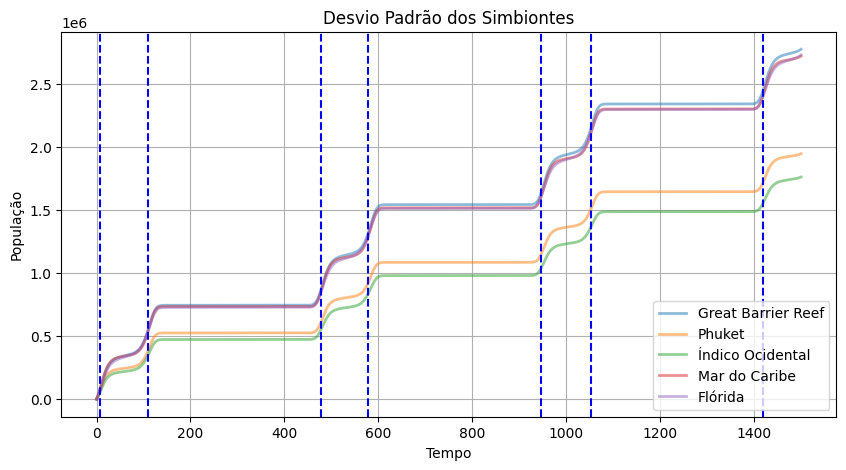

In [ ]:
fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (9,7)
plt.plot(t,std_simb_gbr,alpha=0.5,lw=2 ,label = "Great Barrier Reef")
plt.plot(t,std_simb_phuket,alpha=0.5,lw=2 ,label = "Phuket")
plt.plot(t,std_simb_indico_ocidental,alpha=0.5,lw=2 ,label = "Índico Ocidental")
plt.plot(t,std_simb_western_caribbean,alpha=0.5,lw=2 ,label = "Mar do Caribe")
plt.plot(t,std_simb_florida,alpha=0.5,lw=2 ,label = "Flórida")
plt.title("Desvio Padrão dos Simbiontes")
plt.xlabel('Tempo')
plt.ylabel('População')
plt.axvline(x=7, color = "blue",linestyle='--')
plt.axvline(x=109, color = "blue",linestyle='--')
plt.axvline(x=477, color = "blue",linestyle='--')
plt.axvline(x=579, color = "blue",linestyle='--')
plt.axvline(x=947, color = "blue",linestyle='--')
plt.axvline(x=1053, color = "blue",linestyle='--')
plt.axvline(x=1419, color = "blue",linestyle='--')
plt.legend()#bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.yticks()
plt.grid()
plt.show()

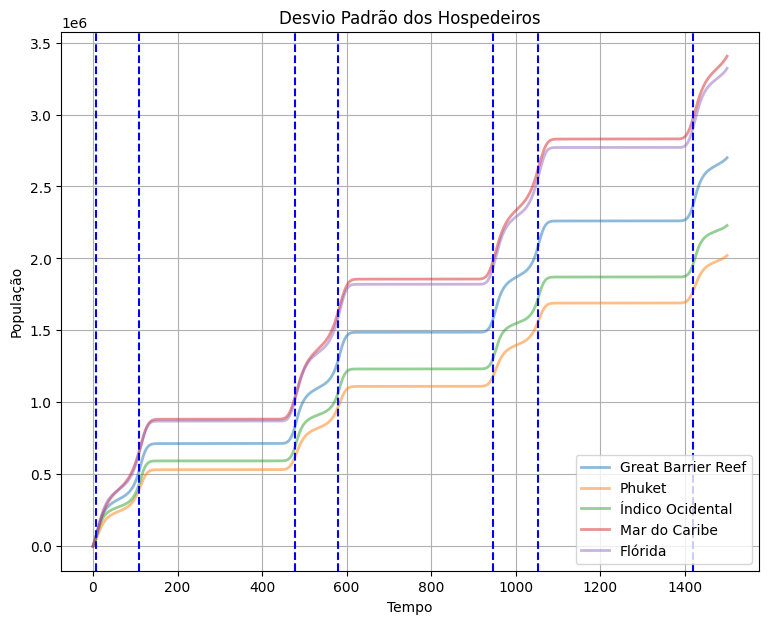

In [ ]:
fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (9,7)
plt.plot(t,std_host_gbr,alpha=0.5,lw=2 ,label = "Great Barrier Reef")
plt.plot(t,std_host_phuket,alpha=0.5,lw=2 ,label = "Phuket")
plt.plot(t,std_host_indico_ocidental,alpha=0.5,lw=2 ,label = "Índico Ocidental")
plt.plot(t,std_host_western_caribbean,alpha=0.5,lw=2 ,label = "Mar do Caribe")
plt.plot(t,std_host_florida,alpha=0.5,lw=2 ,label = "Flórida")
plt.title("Desvio Padrão dos Hospedeiros")
plt.xlabel('Tempo')
plt.ylabel('População')
plt.axvline(x=7, color = "blue",linestyle='--')
plt.axvline(x=109, color = "blue",linestyle='--')
plt.axvline(x=477, color = "blue",linestyle='--')
plt.axvline(x=579, color = "blue",linestyle='--')
plt.axvline(x=947, color = "blue",linestyle='--')
plt.axvline(x=1053, color = "blue",linestyle='--')
plt.axvline(x=1419, color = "blue",linestyle='--')
plt.legend()#bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.yticks()
plt.grid()
plt.show()

# Gráfico das médias

In [ ]:
ret_simb
media_simb = []
for i in range(len(ret_simb)):
  media_simb.append(np.mean(float(ret_simb[i])))

print(media_simb)

media_host = []
for i in range(len(ret_host)):
  media_host.append(np.mean(float(ret_host[i])))

print(media_host)

[1000.0, 18206.26292221985, 37062.997560886135, 57493.86915151713, 79384.08866532544, 102582.8064698778, 126907.34996012355, 152149.08047892989, 178080.49970778005, 204463.12964649714, 231091.1128409634, 257955.35049073122, 284559.503675937, 310689.6340682228, 336155.24954059, 360792.54553925054, 384466.1587699465, 407069.5449029071, 428524.189838306, 448777.8972414487, 467802.4030131865, 485590.56198799214, 502153.3211686251, 517516.6565623815, 531718.6127409225, 544806.541010336, 556834.6043517047, 567861.5818711033, 577948.9853967347, 587159.4832472955, 595555.6146117046, 603198.7696183068, 610148.4063327879, 616461.4731362741, 622192.0080796551, 627390.883749194, 632105.6723099955, 636380.6064580746, 640256.6150526007, 643771.4154552384, 646959.6471938919, 649853.0343943258, 652480.5666292125, 654868.6899440903, 657041.501822119, 659020.9450228268, 660826.9968255959, 662477.8510104982, 663990.091349691, 665378.8550149024, 666657.9857491173, 667840.1769648453, 668937.1045691702, 669

In [ ]:
media_simb_gbr = [1000.0, 14861.823241867784, 30044.59741665621, 46487.06726750383, 64098.86251576689, 82761.72491937198, 102331.93893737622, 122644.07881748963, 143516.0681606438, 164755.35428581943, 186201.26241640904, 207888.26442236739, 229361.34911989426, 250445.28751160024, 270985.1721475434, 290849.0437885791, 309928.98442801944, 328140.9178212685, 345423.4333437486, 361735.95437691815, 377056.52819293516, 391379.4497562024, 404712.8680237846, 417076.4703501909, 428499.3026675594, 439017.75952175376, 448673.76311186544, 457513.1413066654, 465584.2084744197, 472936.54753094737, 479619.98717294505, 485683.7640312533, 491175.8560661894, 496142.470962785, 500627.6716577458, 504673.1205387551, 508317.923989732, 511598.55981400394, 514548.8714387391, 517200.1144172687, 519581.04256775987, 521718.02290471224, 523635.17029480793, 525354.4944054888, 526896.0530819462, 528278.1073639651, 529517.2747888198, 530628.6783928655, 531626.0895492478, 532522.0635433967, 533328.0673246518, 534054.5990718144, 534711.2996488654, 535307.0563292922, 535850.0991567153, 536348.0904914212, 536808.2084612248, 537237.2253697697, 537641.580400615, 538027.449825727, 538400.8126355637, 538767.5149831834, 539133.3320623833, 539504.0297599209, 539885.4257755451, 540283.4516270411, 540704.2159271269, 541154.069876054, 541639.6756791866, 542168.0786323359, 542746.7836699589, 543383.8371107682, 544087.9142515105, 544868.4136513509, 545735.558318234, 546700.5051245745, 547775.4618265654, 548973.8115198178, 550310.2472400186, 551800.9112449118, 553463.5431164611, 555317.6325359991, 557384.571816414, 559687.8134379917, 562253.0177747061, 565108.1906834707, 568283.8070698866, 571812.9087381546, 575731.1633398518, 580076.8714023529, 584890.9207096938, 590216.6635333439, 596099.676061457, 602587.4461355524, 609728.8816243552, 617573.7126725046, 626171.697533049, 635571.6607286832, 645820.3362066089, 656961.00999719, 669031.9605153125, 682064.6980384461, 696082.0112876146, 711095.8370894617, 727104.9816479281, 744092.7426831437, 762024.5147188262, 780845.508839502, 800478.7774687769, 820823.8043565766, 841755.9695699862, 863127.2145441526, 884768.1799055241, 906319.7911274092, 927632.5416737677, 948638.2367778193, 969142.4652117434, 988959.2307662519, 1007917.393299093, 1025866.1025736894, 1042678.9567849364, 1058256.8295844048, 1072529.4518809337, 1085455.8883850107, 1097024.0273443917, 1107249.1550701463, 1116171.6588621468, 1123853.9195615118, 1130376.5129867212, 1135833.9119133211, 1140329.9409953924, 1143973.2640454913, 1146873.1728620518, 1149135.9025270774, 1150861.6324540123, 1152142.2581318156, 1153059.9448357306, 1153686.4123614447, 1154082.8545731655, 1154300.363379093, 1154380.7226060377, 1154357.4344867833, 1154256.8593877025, 1154099.3704253407, 1153900.4504896137, 1153671.68225355, 1153421.6046805892, 1153156.4321455394, 1152880.6354515015, 1152597.3991303705, 1152308.9725008572, 1152016.9342166653, 1151722.3870927922, 1151426.0988898121, 1151128.6029597588, 1150830.2686403438, 1150531.3547939067, 1150232.0386637053, 1149932.4451714796, 1149632.6597318517, 1149332.7421425441, 1149032.7340044742, 1148732.6635303465, 1148432.550782813, 1148132.4091668313, 1147832.248038279, 1147532.0738107567, 1147231.890750286, 1146931.701724187, 1146631.5086380488, 1146331.3132232325, 1146031.1160471651, 1145730.9178560488, 1145430.7189189196, 1145130.519557928, 1144830.319910122, 1144530.1200784713, 1144229.9201349714, 1143929.720113568, 1143629.520053435, 1143329.3199607034, 1143029.11985472, 1142728.9197357974, 1142428.7196121074, 1142128.5194837896, 1141828.3193532636, 1141528.1192181038, 1141227.9190794597, 1140927.7189452474, 1140627.5188110573, 1140327.318676036, 1140027.1185423739, 1139726.9184084008, 1139426.7182741778, 1139126.5181406813, 1138826.318007175, 1138526.117873641, 1138225.9177402055, 1137925.7176067382, 1137625.5174732672, 1137325.3173398415, 1137025.1172064089, 1136724.9170729765, 1136424.7169395532, 1136124.5168061287, 1135824.3166727042, 1135524.1165392816, 1135223.916405859, 1134923.7162724356, 1134623.5161389962, 1134323.3160055233, 1134023.1158720101, 1133722.9157384543, 1133422.7156048561, 1133122.5154712272, 1132822.3153375878, 1132522.1152039731, 1132221.9150704378, 1131921.714936989, 1131621.5148034687, 1131321.314669859, 1131021.1145361562, 1130720.9144023713, 1130420.7142685256, 1130120.5141346573, 1129820.3140008252, 1129520.1138671096, 1129219.9137336072, 1128919.71360017, 1128619.5134667114, 1128319.3133332306, 1128019.1131997288, 1127718.9130662102, 1127418.712932684, 1127118.5127991592, 1126818.3126656539, 1126518.1125321893, 1126217.9123987653, 1125917.712265343, 1125617.5121319199, 1125317.3119984958, 1125017.1118650723, 1124716.9117316478, 1124416.7115982238, 1124116.5114648, 1123816.3113313762, 1123516.111197954, 1123215.9110645314, 1122915.7109311093, 1122615.510797687, 1122315.3106642645, 1122015.1105308426, 1121714.9103974202, 1121414.7102639975, 1121114.5101305756, 1120814.3099971532, 1120514.1098637308, 1120213.909730309, 1119913.7095968863, 1119613.5094634644, 1119313.3093300418, 1119013.1091966194, 1118712.9090631974, 1118412.7089297748, 1118112.5087963527, 1117812.3086629305, 1117512.108529508, 1117211.908396086, 1116911.7082626636, 1116611.5081292412, 1116311.3079958193, 1116011.1078623966, 1115710.9077289745, 1115410.707595552, 1115110.5074621297, 1114810.3073287078, 1114510.1071952851, 1114209.907061863, 1113909.706928441, 1113609.5067950182, 1113309.3066615963, 1113009.106528174, 1112708.9063947517, 1112408.7062613296, 1112108.506127907, 1111808.305994485, 1111508.1058610626, 1111207.90572764, 1110907.7055942183, 1110607.5054607957, 1110307.3053273736, 1110007.1051939512, 1109706.9050605288, 1109406.7049271066, 1109106.5047936842, 1108806.3046602618, 1108506.10452684, 1108205.9043934173, 1107905.7042599954, 1107605.504126573, 1107305.3039931504, 1107005.1038597287, 1106704.903726306, 1106404.7035928837, 1106104.5034594617, 1105804.3033260389, 1105504.103192617, 1105203.9030591948, 1104903.7029257722, 1104603.5027923502, 1104303.3026589276, 1104003.1025255057, 1103702.9023920833, 1103402.7022586607, 1103102.5021252388, 1102802.3019918164, 1102502.1018583942, 1102201.901724972, 1101901.7015915494, 1101601.5014581275, 1101301.301324705, 1101001.1011912825, 1100700.9010578606, 1100400.7009244382, 1100100.500791016, 1099800.3006575936, 1099500.1005241713, 1099199.900390749, 1098899.7002573267, 1098599.5001239043, 1098299.2999904822, 1097999.0998570598, 1097698.8997236378, 1097398.6995902155, 1097098.4994567928, 1096798.2993233707, 1096498.0991899485, 1096197.8990565264, 1095897.6989231042, 1095597.4987896814, 1095297.2986562594, 1094997.0985228373, 1094696.8983894147, 1094396.6982559927, 1094096.4981225699, 1093796.297989148, 1093496.0978557258, 1093195.8977223032, 1092895.6975888812, 1092595.4974554586, 1092295.2973220367, 1091995.0971886145, 1091694.897055192, 1091394.69692177, 1091094.4967883474, 1090794.296654925, 1090494.0965215028, 1090193.8963880807, 1089893.6962546585, 1089593.4961212361, 1089293.2959878135, 1088993.0958543916, 1088692.8957209692, 1088392.695587547, 1088092.4954541244, 1087792.2953207023, 1087492.0951872803, 1087191.895053858, 1086891.694920435, 1086591.4947870132, 1086291.2946535908, 1085991.0945201688, 1085690.8943867465, 1085390.6942533238, 1085090.494119902, 1084790.2939864793, 1084490.0938530571, 1084189.893719635, 1083889.6935862126, 1083589.4934527904, 1083289.2933193683, 1082989.0931859456, 1082688.8930525237, 1082388.6929191013, 1082088.4927856792, 1081788.2926522568, 1081488.0925188344, 1081187.8923854125, 1080887.692251998, 1080587.4921186087, 1080287.2919852484, 1079987.0918519192, 1079686.8917186237, 1079386.6915853643, 1079086.4914521433, 1078786.2913189644, 1078486.091185829, 1078185.8910527397, 1077885.6909196996, 1077585.4907867108, 1077285.2906537768, 1076985.0905208986, 1076684.8903880797, 1076384.6902553225, 1076084.4901226293, 1075784.2899900035, 1075484.0898574463, 1075183.889730146, 1074883.6896033266, 1074583.489476507, 1074283.2893514088, 1073983.0892368844, 1073682.8891240314, 1073382.6890330014, 1073082.4889568835, 1072782.2889108195, 1072482.0889146081, 1072181.8890028636, 1071881.6891660548, 1071581.489505134, 1071281.2901340136, 1070981.091164978, 1070680.8928477983, 1070380.6955392763, 1070080.4997664725, 1069780.306333319, 1069480.1164181386, 1069179.9318905538, 1068879.7553493897, 1068579.5908400342, 1068279.4441850525, 1067979.323828887, 1067679.242342144, 1067379.2178711735, 1067079.276679869, 1066779.4567656687, 1066479.8129052394, 1066180.4240810035, 1065881.404107722, 1065582.9173074581, 1065285.1996177922, 1064988.5912915315, 1064693.5826291917, 1064400.8795184684, 1064111.4963127456, 1063826.885411071, 1063549.1198876668, 1063281.1397990205, 1063027.0813227284, 1062792.7004319353, 1062585.9462188121, 1062417.62040405, 1062302.216889799, 1062258.87867273, 1062312.4728968337, 1062494.7426712818, 1062845.451002648, 1063413.4479261423, 1064257.5287233314, 1065446.955911296, 1067061.5086460293, 1069190.925009209, 1071933.637044079, 1075394.7082390091, 1079683.027943539, 1084907.7648385435, 1091174.2620505877, 1098579.5713432736, 1107207.8908521654, 1117126.1854274564, 1128380.2519041973, 1140991.4389497994, 1154954.1542946, 1170234.2330320545, 1186768.2106599163, 1204463.560978755, 1223200.0094859048, 1242832.0594963848, 1263192.840380719, 1284099.2607072878, 1305358.2522261404, 1326831.7400374613, 1348509.1300474957, 1369958.792727834, 1391006.9008178394, 1411500.2032121099, 1431308.529259101, 1450325.7766819305, 1468469.6258442942, 1485680.304112919, 1501918.7167974599, 1517164.2175148278, 1531412.2266944975, 1544671.8408861689, 1556963.5256537402, 1568316.947628597, 1578768.978369721, 1588361.8879298498, 1597141.738169935, 1605156.978819719, 1612457.2445047542, 1619092.3462928636, 1625111.447248211, 1630562.4080820053, 1635491.2864712374, 1639941.9722733954, 1643955.939776399, 1647572.0991323534, 1650826.7293439861, 1653753.4768842505, 1656383.405603371, 1658745.085387213, 1660864.708872381, 1662766.22748423, 1664471.498274863, 1666000.4386045022, 1667371.18053651, 1668600.223876154, 1669702.5851348997, 1670691.9395541486, 1671580.7561260443, 1672380.4248339029, 1673101.3755808875, 1673753.1889947758, 1674344.699738677, 1674884.0923007107, 1675378.9891373122, 1675836.5357761262, 1676263.4763408608, 1676666.2283322448, 1677050.9505408257, 1677423.6100183132, 1677790.0452860843, 1678156.0288047525, 1678527.3281883772, 1678909.7675605072, 1679309.289539936, 1679732.0186884732, 1680184.3271953159, 1680672.9035378422, 1681204.8248788486, 1681787.6339674948, 1682429.42130015, 1683138.9133031187, 1683925.5669156548, 1684799.6713425457, 1685772.4587916217, 1686856.2202633806, 1688064.4323481652, 1689411.8942585199, 1690914.8628069866, 1692591.203280102, 1694460.5412470559, 1696544.4202162204, 1698866.4569885677, 1701452.4800240826, 1704330.6757175543, 1707531.7124956755, 1711088.8277183091, 1715037.8857028265, 1719417.3849064545, 1724268.408161957, 1729634.479263657, 1735561.3333796726, 1742096.5818119044, 1749289.220216876, 1757189.0081915508, 1765845.6707244676, 1775307.9171669334, 1785622.2719676737, 1796831.7008074801, 1808974.036749039, 1822080.2037995835, 1836172.25024575, 1851261.2055737926, 1867344.792371618, 1884405.0436941092, 1902405.9119396673, 1921291.0038474407, 1940981.6383026047, 1961375.490373671, 1982346.1360417043, 2003743.8196073123, 2025397.70971798, 2046925.1343544952, 2068221.6142551182, 2089196.2700588335, 2109655.0832205405, 2129412.961007793, 2148300.11669935, 2166167.412540108, 2182890.416660931, 2198372.1344045196, 2212544.5007041986, 2225368.779020153, 2236834.98038771, 2246960.3707509385, 2255787.1103234156, 2263379.0891305148, 2269818.0830595666, 2275199.428209785, 2279627.4682150153, 2283211.055372837, 2286059.3717904775, 2288278.2918298803, 2289967.4392741355, 2291218.018085972, 2292111.423678405, 2292718.5796187464, 2293099.8988778717, 2293305.7414682684, 2293377.23034905, 2293347.2899255846, 2293241.7901067534, 2293080.6988474145, 2292879.172098781, 2292648.534918556, 2292397.1289696614, 2292131.019184623, 2291854.5660411064, 2291570.8713095374, 2291282.1253847745, 2290989.864898971, 2290695.16350939, 2290398.7679799963, 2290101.1976086986, 2289802.812855983, 2289503.8635399877, 2289204.5234825253, 2288904.913301113, 2288605.116432229, 2288305.190006093, 2288005.175501707, 2287705.1008558655, 2287404.985182118, 2287104.8414645493, 2286804.679015541, 2286504.503821933, 2286204.320194942, 2285904.1308370433, 2285603.9377747937, 2285303.742199529, 2285003.545030155, 2284703.3467812333, 2284403.147862375, 2284102.948490197, 2283802.748816443, 2283502.548881043, 2283202.3488610596, 2282902.148821227, 2282601.9487002376, 2282301.748588044, 2282001.548465907, 2281701.3483225442, 2281401.1481943987, 2281100.948060607, 2280800.7479236783, 2280500.5477914307, 2280200.3476563008, 2279900.147521706, 2279599.9473882425, 2279299.7472540294, 2278999.547120396, 2278699.346986846, 2278399.1468531485, 2278098.9467197023, 2277798.7465862148, 2277498.54645272, 2277198.34631893, 2276898.1461841897, 2276597.9460485377, 2276297.745912624, 2275997.54577806, 2275697.345644048, 2275397.145508987, 2275096.9453731035, 2274796.7452372434, 2274496.5451030172, 2274196.344969456, 2273896.144835705, 2273595.9447018243, 2273295.7445679884, 2272995.5444344725, 2272695.344301048, 2272395.144167621, 2272094.9440341922, 2271794.7439007647, 2271494.543767342, 2271194.3436339204, 2270894.143500498, 2270593.943367075, 2270293.7432336537, 2269993.5431002313, 2269693.342966809, 2269393.142833387, 2269092.942699964, 2268792.7425665422, 2268492.5424331203, 2268192.3422996975, 2267892.1421662755, 2267591.9420328527, 2267291.7418994317, 2266991.541766009, 2266691.3416325864, 2266391.1414991645, 2266090.9413657426, 2265790.7412323207, 2265490.5410988987, 2265190.340965477, 2264890.1408320554, 2264589.9406986334, 2264289.740565212, 2263989.5404317915, 2263689.34029837, 2263389.1401649495, 2263088.940031528, 2262788.739898107, 2262488.5397646865, 2262188.339631266, 2261888.1394978454, 2261587.939364425, 2261287.739231005, 2260987.539097585, 2260687.3389641647, 2260387.1388307447, 2260086.9386973246, 2259786.7385639055, 2259486.5384304854, 2259186.3382970667, 2258886.138163647, 2258585.938030228, 2258285.7378968084, 2257985.5377633884, 2257685.33762997, 2257385.13749655, 2257084.9373631314, 2256784.737229712, 2256484.5370962927, 2256184.336962873, 2255884.1368294535, 2255583.936696034, 2255283.736562615, 2254983.5364291947, 2254683.336295774, 2254383.136162354, 2254082.9360289336, 2253782.735895513, 2253482.5357620916, 2253182.33562867, 2252882.1354952487, 2252581.9353618263, 2252281.7352284044, 2251981.5350949825, 2251681.3349615596, 2251381.134828139, 2251080.934694717, 2250780.7345612957, 2250480.534427875, 2250180.334294454, 2249880.1341610337, 2249579.9340276127, 2249279.733894192, 2248979.533760772, 2248679.3336273516, 2248379.1334939315, 2248078.933360512, 2247778.7332270923, 2247478.533093673, 2247178.3329602536, 2246878.1328268335, 2246577.9326934153, 2246277.7325599957, 2245977.5324265775, 2245677.332293159, 2245377.1321597397, 2245076.9320263215, 2244776.731892903, 2244476.5317594847, 2244176.3316260665, 2243876.131492648, 2243575.93135923, 2243275.731225811, 2242975.5310923923, 2242675.3309589745, 2242375.1308255554, 2242074.9306921368, 2241774.7305587186, 2241474.5304252994, 2241174.3302918808, 2240874.1301584616, 2240573.930025042, 2240273.729891623, 2239973.529758203, 2239673.329624783, 2239373.1294913623, 2239072.929357941, 2238772.7292245203, 2238472.5290910983, 2238172.328957676, 2237872.128824254, 2237571.9286908316, 2237271.7285574093, 2236971.5284239873, 2236671.3282905654, 2236371.128157143, 2236070.9280237206, 2235770.727890299, 2235470.5277568763, 2235170.327623454, 2234870.1274900325, 2234569.9273566096, 2234269.727223187, 2233969.5270897658, 2233669.326956343, 2233369.1268229205, 2233068.9266894995, 2232768.7265560776, 2232468.5264226557, 2232168.326289233, 2231868.1261558114, 2231567.9260223894, 2231267.7258889666, 2230967.5257555456, 2230667.3256221227, 2230367.125488701, 2230066.9253552794, 2229766.725221857, 2229466.5250884346, 2229166.3249550126, 2228866.1248215907, 2228565.9246881693, 2228265.724554747, 2227965.5244213254, 2227665.324287903, 2227365.124154481, 2227064.924021059, 2226764.723887637, 2226464.5237542144, 2226164.3236207934, 2225864.1234873706, 2225563.9233539486, 2225263.7232205267, 2224963.5230871043, 2224663.322953682, 2224363.12282026, 2224062.922686838, 2223762.7225534157, 2223462.5224199933, 2223162.3222865714, 2222862.1221531485, 2222561.922019726, 2222261.721886304, 2221961.521752882, 2221661.3216194594, 2221361.121486037, 2221060.9213526146, 2220760.7212191923, 2220460.5210857703, 2220160.3209523484, 2219860.1208189265, 2219559.9206855046, 2219259.720552083, 2218959.5204186607, 2218659.3202852393, 2218359.1201518183, 2218058.9200183973, 2217758.7198849763, 2217458.519751571, 2217158.3196181916, 2216858.119484842, 2216557.9193515275, 2216257.7192182518, 2215957.519085019, 2215657.3189518335, 2215357.1188187, 2215056.918685622, 2214756.7185529615, 2214456.5184233426, 2214156.318297819, 2213856.1181770302, 2213555.91806162, 2213255.7179522286, 2212955.5178494966, 2212655.317754066, 2212355.1176665775, 2212054.9175876724, 2211754.7175718956, 2211454.5175850727, 2211154.317738574, 2210854.1179065234, 2210553.918284219, 2210253.7189281993, 2209953.520029483, 2209653.3218024587, 2209353.1246246686, 2209052.929017989, 2208752.7358592753, 2208452.5463469606, 2208152.362378104, 2207852.186656188, 2207552.0232407167, 2207251.8782716407, 2206951.760530099, 2206651.682712621, 2206351.6634201566, 2206051.7298625074, 2205751.9211483025, 2205452.2935982994, 2205152.928438366, 2204853.9425970074, 2204555.504668823, 2204257.8571428126, 2203961.3504014905, 2203666.488083823, 2203373.996643786, 2203084.916997789, 2202800.7411855487, 2202523.600857014, 2202256.513253203, 2202003.7092792382, 2201771.1027596435, 2201566.8266931586, 2201401.9308374953, 2201291.223837235, 2201254.239795001, 2201316.3200499476, 2201509.775893051, 2201875.017633574, 2202461.6174057205, 2203329.1446191124, 2204547.658872238, 2206197.7168310666, 2208369.7641094667, 2211162.812076034, 2214682.3268289263, 2219037.3447819487, 2224336.894816926, 2230685.8561775023, 2238180.470207739, 2246903.7865456925, 2256921.3065240127, 2268277.092422087, 2280990.540568209, 2295053.954773651, 2310430.9787400723, 2327055.9397028927, 2344834.1633225703, 2363643.3727081134, 2383336.311464901, 2403744.693555744, 2424684.4481749246, 2445962.0306625976, 2467461.996519468, 2489128.6940655634, 2510553.9481960945, 2531565.3566311467, 2552011.3391516525, 2571763.518804951, 2590717.607238663, 2608793.0350762843, 2625931.6556577487, 2642095.844148411, 2657266.2470455305, 2671439.39652272, 2684625.323626577, 2696845.2598055666, 2708129.48120051, 2718515.326052747, 2728045.4031754965, 2736766.0004696166, 2744725.696230916, 2751974.1710898974, 2758561.213819179, 2764535.910214327, 2769946.0009008944, 2774837.3915186017, 2779253.797426109, 2783236.5039826245, 2786824.2247377126, 2790053.0398818664, 2792956.3992259614, 2795565.175428125, 2797907.7551115095, 2800010.15731873, 2801896.1707448456, 2803587.500840126, 2805103.9253332852, 2806463.4481572877, 2807682.452293034, 2808775.848536612, 2809757.216712688, 2810638.940221567, 2811432.332851454, 2812147.756788287, 2812794.7329719844, 2813382.0438536564, 2813917.8288572184, 2814409.671771443, 2814864.684756185, 2815289.5854697973, 2815690.7689276226, 2816074.377780004, 2816446.3668143265, 2816812.567681796, 2817178.7502386156, 2817550.68426132, 2817934.20061698, 2818335.2533809366, 2818759.983439911, 2819214.7843583105, 2819706.371290521, 2820241.853705802, 2820828.8126710034, 2821475.3833706677, 2822190.3436781014, 2822983.209714148, 2823864.337950922, 2824845.034682732, 2825937.6770196827, 2827155.8385975473, 2828514.4190844405, 2830029.792567979, 2831719.950158386, 2833604.657914145, 2835705.6132477988, 2838046.584099369, 2840653.5821086774, 2843554.980297268, 2846781.628854522, 2850366.957507675, 2854347.038035878, 2858760.5688804328, 2863648.809830012, 2869055.466064186, 2875026.433144973, 2881609.4382136175, 2888853.560825109, 2896808.588753545, 2905524.2049427284, 2915048.998853551, 2925429.2770312834, 2936707.6760446713, 2948921.573502332, 2962101.295874139, 2976268.1390253864, 2991432.2119794674, 3007590.140176331, 3024722.6785444953, 3042792.3244870454, 3061741.0691560917, 3081488.4897497064, 3101930.4502691184, 3122938.7268421114, 3144361.879205432, 3166027.626260724, 3187529.7667050236, 3208808.863098641, 3229751.377297094, 3250163.72389147, 3269861.7496282705, 3288677.052133713, 3306462.227933997, 3323094.831884688, 3338480.0088297282, 3352551.900003165, 3365273.9642632846, 3376638.32695468, 3386664.2202539435, 3395395.5592804444, 3402897.7214042745, 3409253.658038425, 3414559.5425496465, 3418920.21202059, 3422444.6834030235, 3425242.00860949, 3427417.68438743, 3429070.7666806015, 3430291.759932233, 3431161.2861497235, 3431749.4721813696, 3432115.9531803248, 3432310.362084147, 3432373.1666233805, 3432336.7198387077, 3432226.4078873284, 3432061.799781829, 3431857.7304900754, 3431625.272534588, 3431372.573424702, 3431105.551642313, 3430828.4578194814, 3430544.3153675054, 3430255.2586430376, 3429962.7820229726, 3429667.9303938504, 3429371.43058041, 3429073.788009571, 3428775.3526774254, 3428476.368618606, 3428177.0044883494, 3427877.377358767, 3427577.569099877, 3427277.6358284266, 3426977.616731395, 3426677.538631845, 3426377.4193666726, 3426077.274040262, 3425777.1099507418, 3425476.933954951, 3425176.7495167344, 3424876.559774915, 3424576.366387199, 3424276.1706431964, 3423975.9733291385, 3423675.7749989782, 3423375.5760201556, 3423075.3766104686, 3422775.1769390567, 3422474.977088254, 3422174.777135567, 3421874.5771093876, 3421574.3770308807, 3421274.1768906917, 3420973.9767468832, 3420673.776621834, 3420373.5764776156, 3420073.3763381424, 3419773.1762039275, 3419472.97606312, 3419172.775926831, 3418872.5757929697, 3418572.3756577354, 3418272.175523816, 3417971.9753900166, 3417671.775255813, 3417371.575122238, 3417071.374988684, 3416771.174855048, 3416470.9747215975, 3416170.7745881323, 3415870.5744546535, 3415570.374321226, 3415270.1741877906, 3414969.974054355, 3414669.7739208196, 3414369.5737869577, 3414069.3736527115, 3413769.173518102, 3413468.9733832865, 3413168.7732486115, 3412868.573114681, 3412568.372980943, 3412268.1728466223, 3411967.972711719, 3411667.772576366, 3411367.5724408827, 3411067.3723058295, 3410767.1721719666, 3410466.9720384562, 3410166.7719048243, 3409866.5717710787, 3409566.3716372564, 3409266.1715034293, 3408965.971369719, 3408665.77123625, 3408365.5711028273, 3408065.3709694, 3407765.1708359728, 3407464.970702543, 3407164.770569113, 3406864.570435687, 3406564.370302264, 3406264.1701688413, 3405963.97003542, 3405663.7699019974, 3405363.569768576, 3405063.369635153, 3404763.1695017307, 3404462.969368309, 3404162.7692348855, 3403862.569101464, 3403562.3689680416, 3403262.1688346188, 3402961.968701197, 3402661.7685677744, 3402361.5684343516, 3402061.3683009297, 3401761.1681675077, 3401460.9680340854, 3401160.767900663, 3400860.567767241, 3400560.3676338186, 3400260.1675003953, 3399959.9673669734, 3399659.767233552, 3399359.5671001286, 3399059.366966707, 3398759.1668332852, 3398458.9666998624, 3398158.7665664405, 3397858.566433018, 3397558.3662995957, 3397258.166166173, 3396957.966032751, 3396657.765899329, 3396357.565765906, 3396057.365632484, 3395757.1654990627, 3395456.9653656394, 3395156.765232218, 3394856.565098795, 3394556.3649653723, 3394256.164831951, 3393955.9646985284, 3393655.764565106, 3393355.5644316836, 3393055.3642982617, 3392755.16416484, 3392454.964031417, 3392154.7638979945, 3391854.5637645735, 3391554.3636311498, 3391254.1634977283, 3390953.963364306, 3390653.763230883, 3390353.563097461, 3390053.362964039, 3389753.1628306163, 3389452.9626971944, 3389152.7625637716, 3388852.5624303506, 3388552.3622969273, 3388252.162163505, 3387951.962030084, 3387651.7618966606, 3387351.5617632386, 3387051.3616298167, 3386751.161496394, 3386450.961362972, 3386150.76122955, 3385850.5610961267, 3385550.360962705, 3385250.1608292824, 3384949.960695861, 3384649.760562438, 3384349.5604290157, 3384049.360295594, 3383749.1601621713, 3383448.960028749, 3383148.759895327, 3382848.559761904, 3382548.3596284823, 3382248.15949506, 3381947.959361637, 3381647.759228216, 3381347.559094793, 3381047.3589613717, 3380747.1588279484, 3380446.9586945265, 3380146.7585611045, 3379846.558427682, 3379546.3582942598, 3379246.1581608374, 3378945.9580274145, 3378645.757893993, 3378345.5577605707, 3378045.357627148, 3377745.1574937264, 3377444.9573603035, 3377144.757226881, 3376844.5570934587, 3376544.356960037, 3376244.156826615, 3375943.956693192, 3375643.7565597696, 3375343.556426348, 3375043.3562929253, 3374743.1561595034, 3374442.956026081, 3374142.755892658, 3373842.555759236, 3373542.3556258143, 3373242.1554923914, 3372941.9553589695, 3372641.7552255476, 3372341.555092125, 3372041.3549587023, 3371741.1548252804, 3371440.954691859, 3371140.754558435, 3370840.5544250137, 3370540.354291592, 3370240.154158169, 3369939.954024747, 3369639.753891325, 3369339.5537579022, 3369039.35362448, 3368739.153491058, 3368438.953357636, 3368138.753224213, 3367838.553090791, 3367538.3529573693, 3367238.152823946, 3366937.9526905245, 3366637.7525571026, 3366337.5524236797, 3366037.352290258, 3365737.152156836, 3365436.952023413, 3365136.751889991, 3364836.5517565683, 3364536.351623147, 3364236.1514897235, 3363935.9513563015, 3363635.75122288, 3363335.551089457, 3363035.3509560353, 3362735.1508226134, 3362434.9506891905, 3362134.7505557686, 3361834.550422346, 3361534.350288923, 3361234.150155501, 3360933.950022079, 3360633.749888657, 3360333.5497552343, 3360033.3496218123, 3359733.149488391, 3359432.9493549676, 3359132.749221547, 3358832.5490881265, 3358532.348954706, 3358232.1488212873, 3357931.948687869, 3357631.748554451, 3357331.5484210346, 3357031.3482876197, 3356731.148154205, 3356430.948020792, 3356130.7478873804, 3355830.547753971, 3355530.3476207196, 3355230.147488256, 3354929.94735674, 3354629.7472262834, 3354329.547097, 3354029.3469689996, 3353729.146842395, 3353428.946717301, 3353128.7465938265, 3352828.546472085, 3352528.3463521884, 3352228.14623425, 3351927.946118381, 3351627.7460065274, 3351327.545952612, 3351027.345898696, 3350727.1458681463, 3350426.945889541, 3350126.7460544477, 3349826.546245067, 3349526.346673602, 3349226.147358485, 3348925.948518313, 3348625.750347048, 3348325.553274239, 3348025.357908888, 3347725.164985158, 3347424.9758769157, 3347124.7924713017, 3346824.617631291, 3346524.455572876, 3346224.31213986, 3345924.196894673, 3345624.123107649, 3345324.109342927, 3345024.183578095, 3344724.3861938342, 3344424.7751442147, 3344125.4339269856, 3343826.482812596, 3343528.095480477, 3343230.5218923646, 3342934.119251134, 3342639.4071437465, 3342347.132317537, 3342058.3634981834, 3341774.639639908, 3341498.1394484774, 3341231.9612742676, 3340980.448411629, 3340749.665200261, 3340547.9285000213, 3340386.5446945773, 3340280.643695443, 3340250.1578801847, 3340320.9061419074, 3340525.776390458, 3340905.8314266405, 3341511.3703874843, 3342402.7402357142, 3343650.7973659933, 3345336.8724858374, 3347552.1115470394, 3350396.105580849, 3353974.6811483293, 3358397.015352353, 3363771.9762292043, 3370203.9487174423, 3377788.3402089123, 3386607.0263494663, 3396724.023745992, 3408181.63901496, 3420997.3058195077, 3435161.2130610035, 3450634.809646139, 3467350.2164853923, 3485210.6187112783, 3504091.752397791, 3523844.623962178, 3544299.5615457203, 3565271.5507243737, 3586566.6103355987, 3608091.9544586916, 3629746.88508238, 3651146.7529691695, 3672120.602309187, 3692518.5362765333, 3712213.9789770483, 3731104.4527584314, 3749111.129790093, 3766177.481139189, 3782267.3369278093, 3797362.623327954, 3811460.9709713585, 3824573.332242278, 3836721.6923037902, 3847936.9254269144, 3858256.826456667, 3867724.3339670324, 3876385.954025318, 3884290.386759161, 3891487.353175288, 3898026.6151688234, 3903957.1776003228, 3909326.658324418, 3914180.8089461625, 3918563.1688969457, 3922514.833817764, 3926074.320313456, 3929277.509808418, 3932157.655759549, 3934745.440215844, 3937069.0673066597, 3939154.3830945273, 3941025.013844833, 3942702.515163259, 3944206.52564187, 3945554.9218284925, 3946763.971107751, 3947848.479111606, 3948821.9309910582, 3949696.6254491773, 3950483.8006048617, 3951193.7521076263, 3951835.9413837846, 3952419.0988904447, 3952951.3192197373, 3953440.1479566623, 3953892.6653695633, 3954315.5618432453, 3954715.2116420157, 3955097.740512259, 3955469.0921655972, 3955835.0911949035, 3956201.5054455088, 3956574.10709716, 3956958.7341248784, 3957361.352430488, 3957788.1195848593, 3958245.4509148756, 3958740.0886778706, 3959279.1750835455, 3959870.3299331376, 3960521.733621718, 3961242.2162906886, 3962041.3536034226, 3962929.5690141055, 3963918.2461909447, 3965019.848185332, 3966248.0392048396, 3967617.8268621955, 3969145.7068931893, 3970849.797310913, 3972750.002424907, 3974868.1665314347, 3977228.2220204957, 3979856.3584923996, 3982781.1318393857, 3986033.58009014]

media_host_gbr = [100.0, 4829.325019587322, 9859.87206707094, 15182.1273977489, 20787.29533630681, 26669.706068159787, 32825.65068596474, 39245.642023065055, 45901.398510309635, 52734.934609818716, 59662.4516443801, 66604.59279026909, 73439.38749386685, 80096.12444331382, 86534.66647672241, 92739.86449392178, 98710.94315364682, 104452.14092023614, 109967.4923435294, 115259.3886309948, 120329.18019048768, 125178.28451446297, 129809.01465392955, 134224.95187581782, 138430.97035837264, 142433.07426636148, 146238.16681447707, 149853.81720310336, 153288.05338493464, 156549.18848700184, 159645.67965183745, 162586.01511400094, 165378.6248485682, 168031.81061001055, 170553.69187475805, 172952.16483628147, 175234.87215991574, 177409.18163668868, 179482.17220895697, 181460.626115053, 183351.026026608, 185159.55641956048, 186892.10826751695, 188554.28650896793, 190151.41971446638, 191688.5714453392, 193170.55296234667, 194601.93693404892, 195987.0718618946, 197330.09698616582, 198634.9575171859, 199905.41998718627, 201145.08770131937, 202357.4160937368, 203545.72802411302, 204713.22886274024, 205863.02146455, 206998.12093355943, 208121.4691947438, 209235.9494424971, 210344.40040580585, 211449.63052207246, 212554.43203157137, 213661.59502228853, 214773.92146156155, 215894.23923103805, 217025.41636180854, 218170.37519333488, 219332.10678039605, 220513.68544775597, 221718.28347829706, 222949.18598307608, 224209.8060795535, 225503.69991633747, 226834.58228296365, 228206.34177927763, 229623.05635495702, 231089.00867380438, 232608.7007663507, 234186.86930960778, 235828.49885758027, 237538.8350643323, 239323.39677471868, 241187.98641157642, 243138.69744209692, 245181.9204258979, 247324.3457997195, 249572.9618265877, 251935.04864546066, 254418.16638028147, 257030.13602706435, 259779.0122733333, 262673.0459562799, 265720.6342093072, 268930.2561473719, 272310.389024187, 275869.4040144141, 279615.43358278344, 283556.2085018512, 287698.8606466492, 292049.6959617592, 296613.9584102597, 301395.63563284895, 306397.4101830037, 311620.9081805215, 317067.38727026776, 322738.8073267794, 328638.71945182746, 334771.6516887739, 341139.19519615883, 347731.7896079051, 354517.9519819897, 361436.3706957187, 368380.4883729417, 375252.20491624466, 381970.28603200376, 388466.9927400006, 394705.70738889865, 400672.64465519326, 406363.4714140789, 411773.512755133, 416894.7670783614, 421717.62038719957, 426233.7029497645, 430437.80554614955, 434328.5434268488, 437908.2406202942, 441182.50743799756, 444159.7611723924, 446850.7761213233, 449268.2765525546, 451426.5642741268, 453341.17074588116, 455028.5269269411, 456505.64845336735, 457789.8368336333, 458898.399350977, 459848.3912407352, 460656.3840632067, 461338.264095881, 461909.0640352287, 462382.83036127145, 462772.52752251533, 463089.978512588, 463345.8399374953, 463549.608405033, 463709.6538325545, 463833.2747085742, 463926.76997395506, 463995.5223171157, 464044.08803254215, 464076.28916015354, 464095.3042076053, 464103.7552196996, 464103.7888442267, 464097.1497053153, 464085.24642872595, 464069.2093813326, 464049.9402337144, 464028.15453654167, 464004.41735413956, 463979.1727637025, 463952.768334104, 463925.474961762, 463897.5027921624, 463869.0144114747, 463840.1351388295, 463810.9609313499, 463781.56534747506, 463752.00411081256, 463722.3197051338, 463692.5439378288, 463662.7009053092, 463632.8084423904, 463602.8799534243, 463572.9252502571, 463542.95163712616, 463512.96440360224, 463482.96736084623, 463452.96326828696, 463422.9544368486, 463392.94212144177, 463362.92738296813, 463332.91102633724, 463302.8934512506, 463272.8751188348, 463242.8562365111, 463212.836967, 463182.81746925856, 463152.79778420145, 463122.7779917231, 463092.7581252581, 463062.73820214265, 463032.7182530214, 463002.6982783184, 462972.6782897922, 462942.65829353064, 462912.6382895091, 462882.6182818913, 462852.5982638259, 462822.57823649404, 462792.5582135138, 462762.538199845, 462732.51818217745, 462702.49816258095, 462672.47814756527, 462642.45813326095, 462612.43811766594, 462582.4181023052, 462552.39808886516, 462522.37807525, 462492.35806146753, 462462.3380479329, 462432.31803454156, 462402.29802106705, 462372.2780075802, 462342.2579942181, 462312.237980858, 462282.2179674838, 462252.1979541214, 462222.1779407776, 462192.1579274299, 462162.13791408064, 462132.1179007366, 462102.0978873938, 462072.0778740501, 462042.0578607068, 462012.03784734325, 461982.01783391455, 461951.997820407, 461921.97780680895, 461891.957793113, 461861.9377793176, 461831.91776542953, 461801.8977514665, 461771.8777374598, 461741.85772345855, 461711.83770953177, 461681.8176957739, 461651.79768229974, 461621.77766883135, 461591.757655156, 461561.7376412582, 461531.717627132, 461501.69761278434, 461471.6775982373, 461441.6575835316, 461411.63756872877, 461381.6175539163, 461351.59753920935, 461321.5775247555, 461291.5575107387, 461261.5374972858, 461231.5174838947, 461201.497470449, 461171.47745694633, 461141.4574433869, 461111.4374297744, 461081.4174161165, 461051.39740242535, 461021.37738871854, 460991.3573750194, 460961.33736135834, 460931.3173477731, 460901.29733431025, 460871.277320963, 460841.25730761944, 460811.2372942749, 460781.21728092927, 460751.1972675827, 460721.1772542351, 460691.1572408867, 460661.13722753775, 460631.11721418874, 460601.0972008399, 460571.07718749193, 460541.0571741458, 460511.0371608022, 460481.0171474599, 460450.99713411776, 460420.97712077555, 460390.95710743323, 460360.93709409103, 460330.9170807489, 460300.89706740656, 460270.8770540644, 460240.8570407221, 460210.83702737995, 460180.81701403763, 460150.7970006955, 460120.7769873532, 460090.75697401096, 460060.73696066876, 460030.7169473266, 460000.6969339843, 459970.676920642, 459940.6569072998, 459910.6368939577, 459880.6168806154, 459850.59686727315, 459820.57685393095, 459790.55684058863, 459760.5368272465, 459730.5168139043, 459700.4968005621, 459670.4767872198, 459640.4567738776, 459610.4367605353, 459580.41674719314, 459550.3967338508, 459520.3767205087, 459490.3567071664, 459460.33669382415, 459430.31668048195, 459400.2966671398, 459370.2766537975, 459340.25664045534, 459310.23662711313, 459280.2166137708, 459250.1966004286, 459220.17658708635, 459190.1565737442, 459160.136560402, 459130.11654705973, 459100.09653371753, 459070.0765203752, 459040.056507033, 459010.03649369086, 458980.01648034854, 458949.9964670064, 458919.9764536641, 458889.95644032187, 458859.93642697966, 458829.9164136374, 458799.8964002952, 458769.8763869529, 458739.85637361073, 458709.83636026847, 458679.8163469263, 458649.79633358406, 458619.77632024186, 458589.7563068996, 458559.73629355733, 458529.71628021507, 458499.69626687287, 458469.6762535307, 458439.6562401885, 458409.63622684625, 458379.6162135041, 458349.59620016173, 458319.5761868195, 458289.5561734774, 458259.53616013506, 458229.5161467929, 458199.4961334506, 458169.47612010845, 458139.4561067661, 458109.436093424, 458079.4160800818, 458049.3960667396, 458019.37605339725, 457989.3560400551, 457959.3360267128, 457929.31601337064, 457899.2960000285, 457869.2759866862, 457839.2559733444, 457809.235960016, 457779.2159467087, 457749.19593342394, 457719.1759201633, 457689.1559069283, 457659.13589372026, 457629.115880541, 457599.0958673916, 457569.07585427415, 457539.05584118975, 457509.03582814004, 457479.0158151265, 457448.9958021507, 457418.97578921384, 457388.95577631815, 457358.9357634644, 457328.91575065453, 457298.89573789004, 457268.87572517217, 457238.85571250273, 457208.83569988306, 457178.8156873147, 457148.79567479924, 457118.77566233807, 457088.75564993283, 457058.7356444787, 457028.7156406888, 456998.69563689886, 456968.675633109, 456938.65562931914, 456908.6358218571, 456878.61583637696, 456848.5958658141, 456818.57591016876, 456788.555969441, 456758.53606271924, 456728.5162091821, 456698.4964155241, 456668.4767273114, 456638.45720934507, 456608.4379215747, 456578.4189962744, 456548.40058543, 456518.3829498333, 456488.3663546296, 456458.3514606158, 456428.3388357347, 456398.3292244301, 456368.3242199441, 456338.3256039511, 456308.33614280104, 456278.3591240189, 456248.3996674391, 456218.464657653, 456188.56308515655, 456158.7075217138, 456128.91470665793, 456099.2069917788, 456069.61429439374, 456040.176400144, 456010.94574150787, 455981.99061617645, 455953.40160489426, 455925.2968624424, 455897.8294688335, 455871.19741875096, 455845.65644034866, 455821.53427084466, 455799.2500438747, 455779.3388740962, 455762.4791435566, 455749.52518868854, 455741.55002337514, 455739.8930935426, 455746.2155460486, 455762.56386835454, 455791.4430800304, 455835.8951726646, 455899.5844585632, 455986.8884053464, 456102.9899449503, 456253.967458475, 456446.8806105575, 456689.84487992286, 456992.09157999506, 457364.00646678376, 457817.1433372719, 458364.2051755881, 459018.9945156856, 459796.32564915944, 460711.9004547085, 461782.14823654597, 463024.03156595776, 464454.8216461852, 466091.845022662, 467952.20985842444, 470052.5103026598, 472408.51547387405, 475034.84286123153, 477944.6150555275, 481149.0938092676, 484657.2820577629, 488475.4840162577, 492606.828768512, 497050.82007093413, 501803.1150646389, 506855.9571172069, 512199.78193593456, 517825.96741963306, 523729.1011756671, 529905.3983731808, 536344.4410948085, 543016.0007997802, 549859.6860084572, 556792.1806056856, 563729.3396552784, 570552.813675742, 577194.15903373, 583615.4204630845, 589802.915361522, 595756.5277054751, 601480.6068382121, 606979.0769411922, 612254.2160224131, 617307.3416825272, 622139.9157489798, 626754.339010916, 631154.2925148681, 635344.742545789, 639331.7692643716, 643122.3339375858, 646724.047078809, 650144.9636709265, 653393.4122034442, 656477.8557773886, 659406.7810946739, 662188.6107019854, 664831.634342471, 667343.9559691822, 669733.4536244213, 672007.7499325415, 674174.1913477244, 676239.8346861878, 678211.439671312, 680095.4664521376, 681898.0772099366, 683625.1411045401, 685282.2419191063, 686874.6878578266, 688407.5230275064, 689885.5402531587, 691313.2948254286, 692695.1189729775, 694035.1367976369, 695337.2795249615, 696605.300866628, 697842.7924733259, 699053.199266351, 700239.8347405412, 701405.8960284109, 702554.4788783597, 703688.592368144, 704811.1735154719, 705925.101662945, 707033.2127723299, 708138.3135714406, 709243.1956301816, 710350.6494318803, 711463.4784529483, 712584.5130797045, 713716.6249435857, 714862.7410586292, 716025.858219654, 717209.0576479932, 718415.5195506859, 719648.5381914265, 720911.536877573, 722208.0831919673, 723541.9044655905, 724916.9029961968, 726337.1716511954, 727807.0090187825, 729330.9343706972, 730913.702426641, 732560.3169136835, 734276.043857944, 736066.4231466473, 737937.2785006909, 739894.7259184902, 741945.1785894695, 744095.3491498752, 746352.2480989185, 748723.1773748882, 751215.7174078458, 753837.707852793, 756597.2194711274, 759502.5161888095, 762562.0039164523, 765784.1642443143, 769177.470709904, 772750.2817736669, 776510.705255661, 780466.4344016585, 784624.5472860361, 788991.2774829391, 793571.7809021513, 798369.9449754485, 803388.3600413698, 808628.5945347635, 814091.9183335544, 819780.3895409488, 825697.6841833062, 831848.2974662195, 838233.3187989962, 844841.9180068398, 851640.5596070013, 858565.6027766266, 865506.5694998857, 872369.7496903256, 879073.1297022989, 885551.3341454674, 891769.8765690604, 897716.1464116942, 903386.043297779, 908774.6658177022, 913873.7974147298, 918673.8227140873, 923166.5602306514, 927347.0786334615, 931214.2824971724, 934770.7595030768, 938022.3478219741, 940977.6572721532, 943647.622569258, 946045.0992788293, 948184.4936257071, 950081.4160574618, 951752.3522980302, 953214.3496740573, 954484.719624576, 955580.759137607, 956519.494754758, 957317.4530765209, 957990.4615511585, 958553.4828142329, 959020.4848036782, 959404.3476865696, 959716.8071148247, 959968.4318062043, 960168.6321041927, 960325.6951273131, 960446.8413831277, 960538.2979930736, 960605.3822346411, 960652.5919350493, 960683.6974494472, 960701.8325596473, 960709.5808547452, 960709.0560615807, 960701.9754798319, 960689.7249226389, 960673.4157630585, 960653.9344329397, 960631.9843600622, 960608.1197432406, 960582.7770469234, 960556.2971630819, 960528.9460620428, 960500.9299118525, 960472.4081637191, 960443.5036743572, 960414.3105008506, 960384.9007022352, 960355.3288802962, 960325.6366010925, 960295.8550343034, 960266.0077210674, 960236.1121396938, 960206.1811708007, 960176.2243520503, 960146.2494266232, 960116.2611403675, 960086.2633333667, 960056.2589691431, 960026.2496983282, 959996.2371749538, 959966.2223192463, 959936.205788209, 959906.1882009254, 959876.1697961806, 959846.1508703788, 959816.1315977919, 959786.1120595405, 959756.0923761999, 959726.0725746407, 959696.0526968039, 959666.0327783778, 959636.0128212523, 959605.9928449366, 959575.9728354006, 959545.9527917248, 959515.9327491968, 959485.9127389927, 959455.8927168449, 959425.8726870078, 959395.8526684949, 959365.8326528948, 959335.8126327143, 959305.7926127758, 959275.7725991493, 959245.7525848876, 959215.7325699654, 959185.7125559641, 959155.6925424394, 959125.6725285808, 959095.6525146986, 959065.6325013017, 959035.6124878769, 959005.5924743944, 958975.5724609813, 958945.5524476297, 958915.5324342594, 958885.5124208855, 958855.4924075387, 958825.4723941925, 958795.4523808428, 958765.4323674953, 958735.4123540255, 958705.3923402979, 958675.3723262624, 958645.3523118849, 958615.3322971566, 958585.3122821056, 958555.2922668102, 958525.2722514141, 958495.2522361433, 958465.2322213255, 958435.2122074077, 958405.1921937393, 958375.172179414, 958345.1521643791, 958315.1321486256, 958285.112132201, 958255.0921152228, 958225.072097893, 958195.0520805141, 958165.0320635063, 958135.0120474246, 958104.9920329791, 958074.9720195638, 958044.9520059902, 958014.9319922484, 957984.9119783393, 957954.8919642752, 957924.8719500852, 957894.8519358172, 957864.8319215409, 957834.811907351, 957804.7918933714, 957774.7718797585, 957744.7518664146, 957714.7318530682, 957684.7118397186, 957654.6918263665, 957624.6718130112, 957594.6517996535, 957564.6317862944, 957534.6117729353, 957504.5917595773, 957474.5717462235, 957444.5517328758, 957414.5317195336, 957384.5117061915, 957354.4916928492, 957324.4716795068, 957294.4516661646, 957264.4316528225, 957234.4116394803, 957204.391626138, 957174.3716127959, 957144.3515994537, 957114.3315861112, 957084.3115727692, 957054.2915594269, 957024.2715460847, 956994.2515327425, 956964.2315194001, 956934.211506058, 956904.1914927159, 956874.1714793735, 956844.1514660312, 956814.131452689, 956784.1114393467, 956754.0914260047, 956724.0714126624, 956694.05139932, 956664.0313859779, 956634.0113726357, 956603.9913592931, 956573.9713459514, 956543.9513326092, 956513.9313192666, 956483.9113059245, 956453.8912925824, 956423.87127924, 956393.8512658979, 956363.8312525557, 956333.8112392133, 956303.7912258712, 956273.7712125289, 956243.7511991868, 956213.7311858444, 956183.7111725021, 956153.69115916, 956123.6711458178, 956093.6511324754, 956063.6311191332, 956033.6111057913, 956003.5910924488, 955973.5710791065, 955943.5510657645, 955913.5310524222, 955883.5110390799, 955853.4910257377, 955823.4710123955, 955793.4509990534, 955763.4309857109, 955733.410972369, 955703.3909590266, 955673.3709456843, 955643.3509323422, 955613.330919, 955583.3109056576, 955553.2908923157, 955523.2708789733, 955493.250865631, 955463.2308522888, 955433.2108389466, 955403.1908256045, 955373.1708122621, 955343.1507989198, 955313.1307855776, 955283.1107722352, 955253.0907588932, 955223.0707455513, 955193.0507322088, 955163.0307188663, 955133.0107055244, 955102.990692182, 955072.9706788397, 955042.9506654977, 955012.9306521554, 954982.9106388132, 954952.8906254708, 954922.8706121286, 954892.8505987865, 954862.8305854442, 954832.810572102, 954802.7905587599, 954772.7705454176, 954742.7505320753, 954712.7305187333, 954682.7105053907, 954652.6904920485, 954622.6704787064, 954592.6504653641, 954562.6304520218, 954532.6104386798, 954502.5904253375, 954472.5704119952, 954442.5503993074, 954412.5303858828, 954382.5103724715, 954352.490359073, 954322.4703456874, 954292.4503323147, 954262.4303189549, 954232.4103056081, 954202.3902922742, 954172.3702789533, 954142.3502656453, 954112.3302523503, 954082.3102390682, 954052.2902257991, 954022.2702125428, 953992.2501992994, 953962.2301860693, 953932.2101728516, 953902.1901596471, 953872.1701464555, 953842.1501332768, 953812.1301201113, 953782.1101069705, 953752.0900943147, 953722.0700819126, 953692.0500695104, 953662.030059227, 953632.0100490208, 953601.9900390921, 953571.9700312419, 953541.950026727, 953511.9300275246, 953481.9100527741, 953451.8900804643, 953421.8702038487, 953391.850260509, 953361.8303477415, 953331.8105246094, 953301.7908535645, 953271.7713346187, 953241.7519677724, 953211.7327539343, 953181.7139524414, 953151.6957672645, 953121.6782232319, 953091.661939268, 953061.6471869386, 953031.6348281852, 953001.6256688372, 952971.6215553434, 952941.6237125505, 952911.6351613433, 952881.6597111701, 952851.7021888717, 952821.7689640091, 952791.8717239287, 952762.0197392097, 952732.2325842757, 952702.5325747548, 952672.9503506433, 952643.5260963296, 952614.3129369093, 952585.3820420811, 952556.8253790453, 952528.7632675387, 952501.3519863333, 952474.7929627459, 952449.3465583237, 952425.3472620175, 952403.2213991989, 952383.5143953896, 952366.917090133, 952354.2977385033, 952346.7487273011, 952345.6309871706, 952352.6317172481, 952369.8311320547, 952399.7698722789, 952445.5343886379, 952510.8399812557, 952600.1204503564, 952718.623753054, 952872.4986475034, 953068.8824372855, 953315.9727415093, 953623.086344681, 954000.696421442, 954460.4442845129, 955015.1202732758, 955678.6046107932, 956465.7832971921, 957392.4191135274, 958474.988592674, 959730.4857230247, 961176.1949492524, 962829.4365119319, 964707.2900990146, 966826.2987685505, 969202.1565381984, 971849.3806151188, 974780.9665474497, 978008.0204347055, 981539.3579511301, 985381.0612481561, 989536.0011006374, 994003.3944533202, 998778.614752617, 1003853.6962677075, 1009219.0408920074, 1014866.2135080034, 1020790.052601149, 1026986.649427311, 1033444.5779774804, 1040131.5982819938, 1046984.9199805466, 1053921.8001650532, 1060853.4351813935, 1067665.198575946, 1074290.9409245434, 1080694.8496381056, 1086864.6457240256, 1092800.8187680263, 1098507.801972778, 1103989.4032496174, 1109247.7923337696, 1114284.2601013982, 1119100.317405124, 1123698.4547510038, 1128082.4527679596, 1132257.3687756802, 1136229.3576723463, 1140005.4374449337, 1143593.2588067164, 1147000.902892779, 1150236.7127703784, 1153309.1568370694, 1156226.719740632, 1158997.8162153638, 1161630.7236752624, 1164133.5303208162, 1166514.0958792872, 1168780.0228097774, 1170938.6361558707, 1172996.970565737, 1174961.7632618262, 1176839.4518959133, 1178636.1763235512, 1180357.7839465758, 1182009.8374572233, 1183597.6247246088, 1185126.170534646, 1186600.249323453, 1188024.3990770741, 1189402.9358522997, 1190739.968680824, 1192039.4149030526, 1193305.0155039744, 1194540.350553219, 1195748.8546135998, 1196933.831773808, 1198098.4711110326, 1199245.8612734873, 1200379.0054744787, 1201500.8358315895, 1202614.227974784, 1203722.0151392478, 1204827.0024535574, 1205931.9809115883, 1207039.7415009502, 1208153.0891777768, 1209274.8569934054, 1210407.9202185485, 1211555.2106198694, 1212719.730850022, 1213904.568942738, 1215112.913189097, 1216348.0671670223, 1217613.4644797605, 1218912.683708542, 1220249.4649282605, 1221627.7252738033, 1223051.5725039437, 1224525.3207477005, 1226053.5062305266, 1227640.901424222, 1229292.529751482, 1231013.678969044, 1232809.9095327307, 1234687.0656093224, 1236651.2850535708, 1238709.0049417205, 1240866.9610047496, 1243132.1844224117, 1245511.998648594, 1248014.005469497, 1250646.0624888446, 1253416.256342806, 1256332.8637115965, 1259404.298427972, 1262639.0453630884, 1266045.5730703953, 1269632.225652086, 1273407.0869365302, 1277377.8105129062, 1281551.419280986, 1285934.0741534731, 1290530.8401118028, 1295345.5059742986, 1300380.5702836078, 1305637.5473865771, 1311117.72697884, 1316823.2701425788, 1322757.974246791, 1328926.278619623, 1335328.7220792875, 1341953.1401835112, 1348763.8999895353, 1355695.045113771, 1362632.2664769436, 1369486.3773774628, 1376174.6842556049, 1382634.1959551529, 1388832.5014693262, 1394758.0851763475, 1400407.0255535154, 1405774.1814109364, 1410851.1338235054, 1415628.2839420224, 1420097.648178462, 1424254.5762664755, 1428098.2609749057, 1431631.5510675034, 1434860.509892149, 1437793.9371837385, 1440442.9258072984, 1442820.4605565558, 1444941.0501010607, 1446820.382013858, 1448474.9950074458, 1449921.9664206163, 1451178.6160402768, 1452262.229101694, 1453189.802150812, 1453977.8156980225, 1454642.0374402616, 1455197.3592129794, 1455657.6698579458, 1456035.7649318557, 1456343.2926365745, 1456590.73386237, 1456787.4129043922, 1456941.5343934014, 1457060.2414083614, 1457149.689390468, 1457215.130988225, 1457261.0059242453, 1457291.0336999327, 1457308.3035327403, 1457315.3610116923, 1457314.2877170425, 1457306.773573562, 1457294.1820086665, 1457277.6058597227, 1457257.9162229393, 1457235.8039814983, 1457211.8144724506, 1457186.3756227875, 1457159.8217870214, 1457132.4141948991, 1457104.3549482117, 1457075.8005253486, 1457046.8713168213, 1457017.6594803075, 1456988.235751157, 1456958.653454326, 1456928.9534634878, 1456899.1661205383, 1456869.3146158387, 1456839.4159145744, 1456809.4829072144, 1456779.5249103145, 1456749.5489011714, 1456719.5596413477, 1456689.5609134918, 1456659.5560696197, 1456629.5464530697, 1456599.5334988548, 1456569.5185061847, 1456539.5018013832, 1456509.4840022435, 1456479.465573553, 1456449.4465631146, 1456419.4272256175, 1456389.4076829678, 1456359.38794795, 1456329.3681299782, 1456299.3482478056, 1456269.3283050428, 1456239.3083466894, 1456209.288366833, 1456179.2683690737, 1456149.248370806, 1456119.2283649335, 1456089.2083544002, 1456059.1883401412, 1456029.1683070622, 1455999.1482580127, 1455969.1282136708, 1455939.1081972732, 1455909.0881758616, 1455879.0681478863, 1455849.0481208428, 1455819.0281056943, 1455789.0080899834, 1455758.9880722351, 1455728.9680545074, 1455698.9480404395, 1455668.9280268024, 1455638.908012868, 1455608.8879988873, 1455578.867985399, 1455548.84797197, 1455518.8279584479, 1455488.8079449018, 1455458.7879315016, 1455428.7679181471, 1455398.7479047782, 1455368.727891403, 1455338.7078780495, 1455308.6878647052, 1455278.667851359, 1455248.647838011, 1455218.6278246664, 1455188.6078113236, 1455158.587797981, 1455128.5677846381, 1455098.5477712946, 1455068.5277579182, 1455038.5077444785, 1455008.4877309636, 1454978.4677173651, 1454948.4477036733, 1454918.4276898822, 1454888.4076759876, 1454858.3876619881, 1454828.3676478881, 1454798.3476336969, 1454768.3276194306, 1454738.3076051136, 1454708.2875907794, 1454678.2675764724, 1454648.247562248, 1454618.2275481776, 1454588.207534347, 1454558.187520852, 1454528.167507363, 1454498.1474936293, 1454468.1274796335, 1454438.107465363, 1454408.0874508119, 1454378.0674359805, 1454348.0474208787, 1454318.027405525, 1454288.0073899506, 1454257.987374198, 1454227.9673583233, 1454197.9473423995, 1454167.927326515, 1454137.907310778, 1454107.887295316, 1454077.8672802798, 1454047.8472658426, 1454017.8272521875, 1453987.8072388005, 1453957.7872253421, 1453927.7672118093, 1453897.7471981992, 1453867.7271845113, 1453837.7071707456, 1453807.6871569075, 1453777.6671430026, 1453747.64712904, 1453717.6271150317, 1453687.6071009946, 1453657.5870869479, 1453627.5670729168, 1453597.5470589297, 1453567.5270450206, 1453537.5070312293, 1453507.4870176017, 1453477.4670041823, 1453447.4469908394, 1453417.4269774947, 1453387.4069641486, 1453357.3869508011, 1453327.366937452, 1453297.3469241008, 1453267.3269107484, 1453237.3068973946, 1453207.2868840396, 1453177.266870684, 1453147.2468573276, 1453117.2268439708, 1453087.2068306147, 1453057.1868172595, 1453027.1668039057, 1452997.1467905547, 1452967.1267772068, 1452937.106763863, 1452907.0867505209, 1452877.0667371787, 1452847.0467238363, 1452817.0267104942, 1452787.006697152, 1452756.9866838094, 1452726.9666704678, 1452696.9466571251, 1452666.9266437828, 1452636.9066304408, 1452606.8866170985, 1452576.866603756, 1452546.8465904142, 1452516.8265770718, 1452486.8065637297, 1452456.7865503875, 1452426.766537045, 1452396.746523703, 1452366.726510361, 1452336.7064970185, 1452306.6864836763, 1452276.6664703344, 1452246.6464569918, 1452216.6264436494, 1452186.6064303073, 1452156.5864169651, 1452126.566403623, 1452096.5463902806, 1452066.5263769382, 1452036.506363596, 1452006.486350254, 1451976.4663369118, 1451946.4463235694, 1451916.4263102275, 1451886.406296885, 1451856.3862835427, 1451826.3662702008, 1451796.3462568584, 1451766.326243516, 1451736.3062301741, 1451706.2862168315, 1451676.2662034896, 1451646.2461901472, 1451616.2261768049, 1451586.206163463, 1451556.1861501206, 1451526.166136778, 1451496.146123436, 1451466.1261100937, 1451436.1060967515, 1451406.0860834094, 1451376.0660700672, 1451346.0460567249, 1451316.0260433843, 1451286.0060300655, 1451255.9860167769, 1451225.9660035188, 1451195.945990294, 1451165.925977103, 1451135.9059639478, 1451105.8859508296, 1451075.8659377508, 1451045.8459247123, 1451015.8259117152, 1450985.8058987618, 1450955.7858858537, 1450925.7658729914, 1450895.745860178, 1450865.7258474138, 1450835.7058347003, 1450805.6858220398, 1450775.6658094332, 1450745.6457968825, 1450715.625784389, 1450685.6057719544, 1450655.58575958, 1450625.5657472673, 1450595.5457350183, 1450565.5257228336, 1450535.505710716, 1450505.485698666, 1450475.4656866854, 1450445.4456747763, 1450415.4256629397, 1450385.4056511768, 1450355.3856394896, 1450325.3656278797, 1450295.3456163486, 1450265.325604898, 1450235.3056114893, 1450205.2856449827, 1450175.2656784768, 1450145.2457119701, 1450115.2257454635, 1450085.2057789576, 1450055.1858124516, 1450025.1658704232, 1449995.1460186327, 1449965.1261668429, 1449935.1068723467, 1449905.0871191653, 1449875.067493719, 1449845.0480159554, 1449815.0289492093, 1449785.01037528, 1449754.9922941683, 1449724.9748340473, 1449694.9587713159, 1449664.9442366061, 1449634.932146433, 1449604.9234181559, 1449574.9196036153, 1449544.9224380217, 1449514.935313142, 1449484.9610746491, 1449455.00541959, 1449425.0753725346, 1449395.180605054, 1449365.334122595, 1449335.5527965522, 1449305.8598893122, 1449276.2880616079, 1449246.8782928544, 1449217.6850263693, 1449188.7788704692, 1449160.2545062888, 1449132.23535697, 1449104.8803229383, 1449078.3951962988, 1449053.0460762964, 1449029.1728207737, 1449007.2099158592, 1448987.7124536666, 1448971.3803305943, 1448959.100640415, 1448951.984960487, 1448951.4145820446, 1448959.1062665028, 1448977.169358342, 1449008.1847800054, 1449055.2830836682, 1449122.2286207757, 1449213.515806562, 1449334.4550269935, 1449491.2681440369, 1449691.1675271334, 1449942.437026311, 1450254.4776217886, 1450637.8500400812, 1451104.2829431377, 1451666.650101067, 1452338.9138923408, 1453136.0298953603, 1454073.820169825, 1455168.8078737042, 1456438.0169574432, 1457898.7436130643, 1459568.3003288014, 1461463.7364498277, 1463601.54239747, 1465997.3351576144, 1468665.5296186146, 1471618.992270973, 1474868.6713458137, 1478423.1928591924, 1482288.4139836468, 1486466.9446013793, 1490957.7138038136, 1495755.8131991124, 1500853.0781015602, 1506239.893235956, 1511908.0245240806, 1517852.5510042505, 1524069.3898667167, 1530546.0268910516, 1537248.1511231926, 1544110.5867021976, 1551051.25983096, 1557976.837635668, 1564776.5141077368, 1571386.4543217674, 1577772.946273186, 1583925.0507245928, 1589843.812075961, 1595533.7215319283, 1600998.4654321894, 1606240.1105629753, 1611259.9284020395, 1616059.4828461458, 1620641.3556852702, 1625009.4269950131, 1629168.844303089, 1633125.8353505996, 1636887.4738488463, 1640461.4494965265, 1643855.868516686, 1647079.087807165, 1650139.580466599, 1653045.8286611172, 1655806.2389005523, 1658429.0759976252, 1660922.4121804084, 1663294.088698793, 1665551.6877364384, 1667702.5128521137, 1669753.5765055993, 1671711.5933944625, 1673582.9785798576, 1675373.8497361825, 1677090.0325546267, 1678737.0686277733, 1680320.2256589653, 1681844.509102099, 1683314.6750996558, 1684735.244445209, 1686110.5170708739, 1687444.5870567434, 1688741.357934249, 1690004.558081373, 1691237.7560372567, 1692444.375942957, 1693627.7128414838, 1694790.947643395, 1695937.162123411, 1697069.3535689951, 1698190.4494147536, 1699303.3215525488, 1700410.8006527, 1701515.6902544457, 1702620.780893107, 1703728.864094691, 1704842.7464575847, 1705965.263703595, 1707099.2948659158, 1708247.7765349841, 1709413.7172820503, 1710600.212263509, 1711810.4579279386, 1713047.766811864, 1714315.5830352344, 1715617.497574201, 1716957.2625647308, 1718338.8079818855, 1719766.2574286142, 1721243.9417831856, 1722776.4144013624, 1724368.4665294886, 1726025.1401850528, 1727751.742138577, 1729553.855625306, 1731437.3473638417, 1733408.376783171, 1735473.4020043253, 1737639.181955376]

media_simb_phuket = [1000.0, 14667.786093844185, 29892.82130714127, 46685.04362117567, 65018.32605650645, 84820.53321802791, 105964.38039238252, 128262.28373087014, 151468.28646592898, 175288.68988241596, 199436.1247822839, 223808.85356857008, 247822.83511017144, 271196.52056676126, 293700.5890068866, 315163.187001971, 335468.14688568783, 354548.3350949243, 372376.57145395107, 388956.1831710026, 404312.5422960065, 418486.2095969518, 431527.7644288765, 443494.08145698975, 454445.70871515194, 464445.01469136757, 473554.8465632454, 481837.5245224305, 489354.0661498188, 496163.58116577123, 502322.80416316324, 507885.74620561145, 512903.4515194092, 517423.8466876905, 521491.6700666681, 525148.4687007186, 528432.6504216389, 531379.5794366198, 534021.7048229596, 536388.7125851796, 538507.6932938063, 540403.3186509247, 542098.0216320149, 543612.1758992956, 544964.2713018396, 546171.0830625115, 547247.8330015317, 548208.3417385333, 549065.1713349035, 549829.7581624417, 550512.5361167538, 551123.0504823226, 551670.0630037277, 552161.6489034178, 552605.2858522856, 553007.9368331122, 553376.1263544643, 553716.0118167672, 554033.4501279091, 554334.0606616987, 554623.2852233631, 554906.4456805713, 555188.8001361011, 555475.5982083093, 555772.1362473046, 556083.8131337999, 556416.1873995351, 556775.0363995038, 557166.4182998338, 557596.7374401798, 558072.8139568447, 558601.9590504124, 559192.0549706542, 559851.6422514968, 560590.0147706554, 561417.3215319072, 562344.6779523198, 563384.2864296224, 564549.5661681821, 565855.2921368126, 567317.7457804559, 568954.871336645, 570786.4464901118, 572834.2517599775, 575122.2505829171, 577676.7711039274, 580526.6847582511, 583703.5724882584, 587241.8876372571, 591179.0913853789, 595555.7575206845, 600415.6410142543, 605805.6928812341, 611776.0105667912, 618379.714945579, 625672.7351948142, 633713.4948948174, 642562.4826928317, 652281.692126615, 662933.9031328632, 674581.7562041334, 687286.52784803, 701106.4595924283, 716094.4038782644, 732294.4785005667, 749737.3736687171, 768434.0252423128, 788367.6099297871, 809484.2935517941, 831683.8483031057, 854812.0015287219, 878656.8983750802, 902952.0086857373, 927214.7922606001, 951159.9315410475, 974587.8364084377, 997193.5640072647, 1018714.9439339127, 1038945.8535684624, 1057740.745449414, 1075011.3869722225, 1090718.5851977866, 1104862.1947893808, 1117471.9935201474, 1128600.6557554356, 1138318.8107091663, 1146711.4689546456, 1153875.0125462553, 1159914.2214318032, 1164939.1580380658, 1169061.983258033, 1172393.883847972, 1175042.2958943439, 1177108.567321411, 1178686.1490089681, 1179859.3531330077, 1180702.670629861, 1181280.6007760323, 1181647.917707522, 1181850.274598551, 1181925.0471290925, 1181902.3150692605, 1181805.8964769396, 1181654.3646547664, 1181461.9974748786, 1181239.6280346876, 1180995.374128648, 1180735.2575322685, 1180463.7015684987, 1180183.9293748976, 1179898.2744572242, 1179608.4172308734, 1179315.562714324, 1179020.5727149337, 1178724.0625540195, 1178426.470715588, 1178128.1092712053, 1177829.202739629, 1177529.909051562, 1177230.3416681646, 1176930.5814131694, 1176630.6852257354, 1176330.6942314347, 1176030.6368664452, 1175730.5336667774, 1175430.3988475865, 1175130.2423695503, 1174830.071233936, 1174529.8901621243, 1174229.702380513, 1173929.5100493215, 1173629.3150460634, 1173329.1180938573, 1173028.9199956355, 1172728.7210994335, 1172428.521730085, 1172128.3220707981, 1171828.1222143073, 1171527.9222544036, 1171227.7222138168, 1170927.5221412797, 1170627.3220381497, 1170327.12192416, 1170026.9218003254, 1169726.7216722486, 1169426.521541823, 1169126.32140945, 1168826.1212716103, 1168525.9211223905, 1168225.7209716933, 1167925.520834678, 1167625.3206897124, 1167325.120540022, 1167024.9204017732, 1166724.7202668702, 1166424.520130709, 1166124.3199956466, 1165824.1198622496, 1165523.91972889, 1165223.71959553, 1164923.5194621151, 1164623.319328707, 1164323.1191953039, 1164022.919061887, 1163722.718928466, 1163422.5187950465, 1163122.3186616262, 1162822.1185282043, 1162521.9183947819, 1162221.71826136, 1161921.5181279508, 1161621.3179945883, 1161321.1178612795, 1161020.9177280294, 1160720.7175948434, 1160420.5174617246, 1160120.3173286754, 1159820.1171956963, 1159519.9170627873, 1159219.716929946, 1158919.516797167, 1158619.3166644434, 1158319.116531766, 1158018.9163991222, 1157718.716266497, 1157418.5161338702, 1157118.3160012218, 1156818.1158685249, 1156517.9157357505, 1156217.7156028633, 1155917.515469826, 1155617.315336597, 1155317.1152032064, 1155016.9150698802, 1154716.7149366392, 1154416.514803485, 1154116.3146704184, 1153816.1145374374, 1153515.9144045406, 1153215.714271724, 1152915.5141389824, 1152615.3140063076, 1152315.1138736906, 1152014.9137411206, 1151714.713608585, 1151414.513476068, 1151114.313343551, 1150814.1132110157, 1150513.913078439, 1150213.712945796, 1149913.5128130587, 1149613.3126801972, 1149313.1125471785, 1149012.912413966, 1148712.7122805654, 1148412.512147149, 1148112.3120137386, 1147812.1118803336, 1147511.911746935, 1147211.7116135408, 1146911.5114801528, 1146611.3113467703, 1146311.1112133926, 1146010.911080019, 1145710.710946649, 1145410.5108132826, 1145110.3106799184, 1144810.1105465551, 1144509.9104131917, 1144209.7102798272, 1143909.5101464605, 1143609.3100130893, 1143309.1098797119, 1143008.9097463265, 1142708.7096129316, 1142408.5094795243, 1142108.3093461036, 1141808.1092126812, 1141507.909079259, 1141207.7089458373, 1140907.5088124145, 1140607.308678992, 1140307.10854557, 1140006.9084121478, 1139706.7082787259, 1139406.5081453032, 1139106.3080118808, 1138806.1078784587, 1138505.9077450365, 1138205.707611614, 1137905.5074781915, 1137605.3073447694, 1137305.1072113477, 1137004.9070779248, 1136704.7069445024, 1136404.5068110803, 1136104.3066776583, 1135804.1065442357, 1135503.9064108133, 1135203.7062773912, 1134903.506143969, 1134603.306010547, 1134303.1058771245, 1134002.905743702, 1133702.70561028, 1133402.5054768575, 1133102.3053434351, 1132802.1052100128, 1132501.9050765906, 1132201.7049431684, 1131901.504809746, 1131601.3046763237, 1131301.1045429015, 1131000.9044094793, 1130700.704276057, 1130400.5041426346, 1130100.3040092124, 1129800.1038757903, 1129499.9037423683, 1129199.7036089455, 1128899.5034755233, 1128599.3033421012, 1128299.1032086788, 1127998.9030752564, 1127698.702941834, 1127398.5028084118, 1127098.3026749897, 1126798.1025415673, 1126497.902408145, 1126197.7022747227, 1125897.5021413006, 1125597.3020078777, 1125297.1018744558, 1124996.9017410337, 1124696.7016076115, 1124396.501474189, 1124096.3013407665, 1123796.1012073446, 1123495.9010739224, 1123195.7009405, 1122895.5008070776, 1122595.3006736552, 1122295.100540233, 1121994.900406811, 1121694.7002733883, 1121394.5001399661, 1121094.300006544, 1120794.0998731218, 1120493.899739699, 1120193.699606277, 1119893.499472855, 1119593.2993394327, 1119293.0992060103, 1118992.899072588, 1118692.6989391658, 1118392.4988057436, 1118092.2986723213, 1117792.0985388989, 1117491.8984054765, 1117191.6982720543, 1116891.498138632, 1116591.2980052093, 1116291.0978717874, 1115990.8977383652, 1115690.697604943, 1115390.4974715202, 1115090.2973380978, 1114790.0972046761, 1114489.897071254, 1114189.6969378316, 1113889.4968044092, 1113589.296670987, 1113289.0965375649, 1112988.8964041425, 1112688.69627072, 1112388.4961372977, 1112088.2960038756, 1111788.0958704532, 1111487.8957370305, 1111187.6956036086, 1110887.4954701865, 1110587.2953367643, 1110287.0952033415, 1109986.895069919, 1109686.6949364974, 1109386.4948030752, 1109086.2946696528, 1108786.0945362302, 1108485.8944028083, 1108185.6942693873, 1107885.4941359719, 1107585.2940025562, 1107285.0938691406, 1106984.8937357254, 1106684.6936023096, 1106384.4934688942, 1106084.2933354788, 1105784.093202063, 1105483.893068648, 1105183.6929368384, 1104883.492805835, 1104583.2926748323, 1104283.092543829, 1103982.8924128257, 1103682.6922818222, 1103382.4921508192, 1103082.292019816, 1102782.0918888128, 1102481.891757836, 1102181.691634773, 1101881.491546712, 1101581.291458651, 1101281.0913705896, 1100980.8912825286, 1100680.6913030832, 1100380.4913378905, 1100080.29146652, 1099780.0917470255, 1099479.892246151, 1099179.6930439568, 1098879.4943602318, 1098579.2966000333, 1098279.0995236717, 1097978.9042538535, 1097678.711647339, 1097378.5230763278, 1097078.3405939667, 1096778.1671514784, 1096478.0072397445, 1096177.8671881587, 1095877.7561743231, 1095577.6866922984, 1095277.6785156587, 1094977.758080973, 1094677.9625382023, 1094378.3447516393, 1094078.9796972838, 1093779.9720793592, 1093481.4686950815, 1093183.675639696, 1092886.8816412755, 1092591.4919823545, 1092298.0758699626, 1092007.4316678706, 1091720.6737189046, 1091439.3574369403, 1091165.6465053372, 1090902.5339586863, 1090654.1329263835, 1090426.05052331, 1090225.867032792, 1090063.724816978, 1089953.0327629086, 1089911.2839179267, 1089960.9902015296, 1090130.6848260104, 1090455.9586098527, 1090980.4611045672, 1091756.788659455, 1092847.1417289253, 1094323.6908688277, 1096268.5096045472, 1098773.0220586974, 1101936.8786255997, 1105866.2937977705, 1110671.8167686942, 1116465.648500156, 1123358.6209325844, 1131457.0227951298, 1140859.4551247433, 1151653.8288150623, 1163914.3973045968, 1177698.3794014663, 1193041.4101832442, 1209951.0362369975, 1228398.0210898095, 1248306.367037566, 1269544.3583616226, 1291919.8469481184, 1315182.8021879247, 1339036.6000381922, 1363215.1698206214, 1387571.6738028147, 1411546.6710255807, 1434862.1823964072, 1457293.1292832736, 1478671.9843536168, 1498886.547863654, 1517873.0220575437, 1535606.8473325141, 1552093.2864170098, 1567359.0709859687, 1581445.6762121993, 1594404.2687444296, 1606292.079708174, 1617169.8508813696, 1627100.0283795842, 1636145.451234528, 1644368.36617377, 1651829.6664069404, 1658588.2975746167, 1664700.8000440148, 1670220.968909393, 1675199.617820052, 1679684.4349923863, 1683719.9179557874, 1687347.3750829191, 1690604.9813405043, 1693527.8767201675, 1696148.29681477, 1698495.7263534006, 1700597.0676549606, 1702476.8176106228, 1704157.247943693, 1705658.5845113683, 1706999.1823545184, 1708195.694272983, 1709263.2314068177, 1710215.514843705, 1711065.017436456, 1711823.095932692, 1712500.113613357, 1713105.5533037165, 1713648.121523556, 1714135.8456157662, 1714576.1616806088, 1714975.9971116285, 1715341.8463809404, 1715679.8420095546, 1715995.8208879433, 1716295.38698697, 1716583.971088889, 1716866.8883490302, 1717149.3942933555, 1717436.740155965, 1717734.228035058, 1718047.2668088863, 1718381.4293569229, 1718742.5120389, 1719136.5967478324, 1719570.116612343, 1720049.9260846535, 1720583.3763964407, 1721178.3963295917, 1721843.5796718006, 1722588.280908476, 1723422.7178752315, 1724358.083526344, 1725406.6666253386, 1726581.9837880807, 1727898.9192208229, 1729373.8723165009, 1731024.920717594, 1732871.9836040726, 1734937.0023754935, 1737244.1141578814, 1739819.829653035, 1742693.2154968902, 1745896.0686690896, 1749463.0643284256, 1753431.890434572, 1757843.3609752378, 1762741.4721841277, 1768173.4132846277, 1774189.5152093368, 1780843.1190608572, 1788190.3532424027, 1796289.813787603, 1805202.1236378574, 1814989.36258635, 1825714.3350073472, 1837439.6273922108, 1850226.3508607992, 1864132.43589141, 1879210.2066980419, 1895502.9536510324, 1913040.1217713815, 1931830.8563616856, 1951855.8810733093, 1973058.1865192775, 1995333.7092809565, 2018523.8977704053, 2042412.5880504192, 2066729.468037064, 2090966.890264542, 2114884.352694816, 2138260.566950469, 2160793.167748414, 2182223.8475818164, 2202350.99420308, 2221033.571133977, 2238187.3628443973, 2253776.465227109, 2267803.2798439944, 2280299.524204828, 2291319.3735985192, 2300934.6524721608, 2309231.3293845416, 2316306.5232078354, 2322265.521654406, 2327218.6555538387, 2331278.1167628854, 2334554.901680514, 2337156.06329142, 2339182.411222349, 2340726.744718051, 2341872.6537432577, 2342693.8772063283, 2343254.168627968, 2343607.5905225286, 2343799.1416449198, 2343865.6134631387, 2343836.578341696, 2343735.4248171886, 2343580.370911973, 2343385.4069190365, 2343161.1365184644, 2342915.5014171023, 2342654.387302449, 2342382.1146268174, 2342101.8286035885, 2341815.8060381664, 2341525.686501634, 2341232.644707392, 2340937.5213963636, 2340640.9162093014, 2340343.2568314895, 2340044.8484896827, 2339745.908182498, 2339446.5908175185, 2339147.006363097, 2338847.2325120997, 2338547.3279020092, 2338247.3300962895, 2337947.2685736697, 2337647.1619902565, 2337347.0251763253, 2337046.867158406, 2336746.6950791026, 2336446.5132941683, 2336146.3251914317, 2335846.1327900607, 2335545.937639943, 2335245.740650601, 2334945.5425083176, 2334645.343606659, 2334345.144180788, 2334044.944352277, 2333744.744431554, 2333444.54442407, 2333144.3443083996, 2332844.1442158245, 2332543.944087195, 2332243.743936311, 2331943.543810382, 2331643.3436710318, 2331343.1435317732, 2331042.943398136, 2330742.7432599636, 2330442.5431247056, 2330142.3429904673, 2329842.1428551846, 2329541.9427214456, 2329241.7425875915, 2328941.542453614, 2328641.342320148, 2328341.142186565, 2328040.942053004, 2327740.7419177364, 2327440.541778823, 2327140.341635962, 2326840.141490146, 2326539.9413444474, 2326239.7412049714, 2325939.5410690084, 2325639.3409274574, 2325339.1407803996, 2325038.940629596, 2324738.740479172, 2324438.540336381, 2324138.340202433, 2323838.140067509, 2323537.939931492, 2323237.7397947055, 2322937.539657905, 2322637.339522407, 2322337.139388883, 2322036.939255437, 2321736.739121972, 2321436.5389884934, 2321136.3388550123, 2320836.1387215503, 2320535.938588125, 2320235.738454702, 2319935.5383212804, 2319635.3381878585, 2319335.138054436, 2319034.9379210137, 2318734.7377875913, 2318434.537654169, 2318134.3375207465, 2317834.1373873246, 2317533.9372539027, 2317233.7371204803, 2316933.536987058, 2316633.336853636, 2316333.1367202126, 2316032.936586791, 2315732.736453369, 2315432.5363199464, 2315132.3361865245, 2314832.136053102, 2314531.9359196797, 2314231.7357862573, 2313931.535652835, 2313631.3355194125, 2313331.1353859906, 2313030.9352525687, 2312730.7351191463, 2312430.5349857234, 2312130.334852302, 2311830.134718879, 2311529.9345854567, 2311229.7344520353, 2310929.534318613, 2310629.3341851905, 2310329.134051768, 2310028.933918346, 2309728.7337849243, 2309428.533651502, 2309128.333518079, 2308828.133384658, 2308527.9332512347, 2308227.7331178132, 2307927.532984391, 2307627.3328509685, 2307327.1327175465, 2307026.932584124, 2306726.732450702, 2306426.53231728, 2306126.3321838574, 2305826.132050436, 2305525.9319170136, 2305225.7317835917, 2304925.5316501698, 2304625.331516747, 2304325.131383325, 2304024.9312499035, 2303724.7311164807, 2303424.5309830587, 2303124.330849637, 2302824.1307162144, 2302523.930582793, 2302223.73044937, 2301923.530315948, 2301623.3301825263, 2301323.130049104, 2301022.9299156824, 2300722.7297822596, 2300422.529648838, 2300122.3295154157, 2299822.129381994, 2299521.929248571, 2299221.729115149, 2298921.528981727, 2298621.3288483047, 2298321.128714882, 2298020.9285814604, 2297720.7284480385, 2297420.5283146156, 2297120.3281811937, 2296820.1280477713, 2296519.9279143494, 2296219.727780927, 2295919.5276475046, 2295619.327514082, 2295319.12738066, 2295018.927247238, 2294718.727113816, 2294418.526980393, 2294118.326846971, 2293818.1267135493, 2293517.9265801264, 2293217.726446704, 2292917.526313282, 2292617.32617986, 2292317.1260464382, 2292016.925913016, 2291716.7257795935, 2291416.5256461715, 2291116.325512749, 2290816.1253793277, 2290515.9252459053, 2290215.7251124834, 2289915.524979061, 2289615.324845639, 2289315.124712216, 2289014.9245787947, 2288714.724445373, 2288414.5243119504, 2288114.324178528, 2287814.124045106, 2287513.9239116847, 2287213.7237782623, 2286913.5236448403, 2286613.3235114175, 2286313.1233779956, 2286012.923244574, 2285712.7231111517, 2285412.52297773, 2285112.322844308, 2284812.122710886, 2284511.9225774636, 2284211.7224440416, 2283911.5223106197, 2283611.3221771973, 2283311.1220437754, 2283010.9219103535, 2282710.721776931, 2282410.521643509, 2282110.3215100872, 2281810.121376665, 2281509.9212432425, 2281209.7211098205, 2280909.5209763986, 2280609.320842976, 2280309.1207095543, 2280008.920576132, 2279708.72044271, 2279408.5203092876, 2279108.320175865, 2278808.1200424433, 2278507.919909021, 2278207.7197755985, 2277907.519642176, 2277607.3195087537, 2277307.119375332, 2277006.9192419094, 2276706.719108487, 2276406.5189750656, 2276106.3188416427, 2275806.118708221, 2275505.918574798, 2275205.7184413755, 2274905.518307953, 2274605.318174531, 2274305.1180411084, 2274004.917907687, 2273704.717774264, 2273404.517640842, 2273104.3175074197, 2272804.1173739973, 2272503.917240575, 2272203.7171071526, 2271903.51697373, 2271603.316840308, 2271303.116706886, 2271002.9165734635, 2270702.716440042, 2270402.5163066196, 2270102.316173198, 2269802.116039777, 2269501.9159063566, 2269201.7157729357, 2268901.5156395156, 2268601.3155060955, 2268301.115372677, 2268000.915239258, 2267700.7151058405, 2267400.514988862, 2267100.3148519453, 2266800.1147160768, 2266499.914581256, 2266199.7144474825, 2265899.514314758, 2265599.314183081, 2265299.1140524526, 2264998.913922871, 2264698.713794339, 2264398.5136668542, 2264098.3135404172, 2263798.113415031, 2263497.9132944504, 2263197.7133014863, 2262897.5133920116, 2262597.3134825365, 2262297.113573062, 2261996.9136635875, 2261696.714009201, 2261396.5149038075, 2261096.3155644345, 2260796.116750752, 2260495.919036379, 2260195.722478384, 2259895.5273849275, 2259595.3352418803, 2259295.1471284917, 2258994.96529856, 2258694.7933038045, 2258394.6348015224, 2258094.496944929, 2257794.3887644713, 2257494.3234003987, 2257194.3221381838, 2256894.409126574, 2256594.6252742996, 2256295.0246973964, 2255995.6830474217, 2255696.7072741115, 2255398.249231141, 2255100.52048035, 2254803.8172242995, 2254508.555641863, 2254215.3188413223, 2253924.924237998, 2253638.5139166834, 2253357.6862153965, 2253084.6573003386, 2252822.494096933, 2252575.4071902963, 2252349.1335256146, 2252151.428744298, 2251992.6559430254, 2251886.4944798425, 2251850.7808376993, 2251908.4472591714, 2252088.515627074, 2252427.158785107, 2252968.666262803, 2253766.334270442, 2254883.1095468933, 2256391.925488723, 2258375.573954219, 2260926.143895441, 2264143.8529475676, 2268135.3193454505, 2273011.317199086, 2278884.051527519, 2285864.1246685414, 2294057.354005134, 2303561.6386450166, 2314463.966238953, 2326837.434483293, 2340737.8180334102, 2356198.890965012, 2373225.759825224, 2391786.0212419955, 2411799.7614447456, 2433130.8068718184, 2455582.4587365384, 2478900.6776133357, 2502786.024078294, 2526993.858421586, 2551332.325459117, 2575266.75779875, 2598522.8170666383, 2620879.6942928657, 2642174.1741018854, 2662297.9822768024, 2681190.609095989, 2698830.0570608135, 2715223.4776732754, 2730398.925184943, 2744398.759967936, 2757274.7156561012, 2769084.3654536293, 2779888.6347813583, 2789750.0400515315, 2798731.4067346174, 2806894.9037883333, 2814301.2966462015, 2821009.3644521907, 2827075.4512165138, 2832553.1346896123, 2837492.997323297, 2841942.4885410825, 2845945.8650470944, 2849544.1968461615, 2852775.4266239163, 2855674.4709020457, 2858273.35267094, 2860601.3562507182, 2862685.1966429558, 2864549.1970499842, 2866215.4690766507, 2867704.091739609, 2869033.286149714, 2870219.5835965355, 2871277.9855809687, 2872222.114721121, 2873064.3546662237, 2873815.9837473226, 2874487.294680559, 2875087.708543571, 2875625.8776796185, 2876109.7817556453, 2876546.8159734113, 2876943.8724451168, 2877307.416087256, 2877643.554851431, 2877958.105985442, 2878256.658362006, 2878544.632090998, 2878827.335840735, 2879110.0229176963, 2879397.946553763, 2879696.414792877, 2880010.8469513683, 2880346.830713624, 2880710.181564339, 2881107.005487055, 2881543.764891205, 2882027.348975583, 2882565.149343988, 2883165.141827022, 2883835.9741652724, 2884587.061956617, 2885428.692452574, 2886372.136939195, 2887429.7718728157, 2888615.2115779817, 2889943.4485425437, 2891431.0021781735, 2893096.084800111, 2894958.7609417215, 2897041.1275549345, 2899367.5004816004, 2901964.576310722, 2904861.6181622874, 2908090.629532027, 2911686.5162737607, 2915687.200244749, 2920133.7239662455, 2925070.32845517, 2930544.4449340547, 2936606.633653388, 2943310.4541098108, 2950712.2350514955, 2958870.739918763, 2967846.7237295676, 2977702.3486818136, 2988500.438118454, 3000303.5163473864, 3013172.5211829543, 3027165.0572808105, 3042332.9017868307, 3058718.491061436, 3076349.988023904, 3095234.7010274534, 3115350.846618925, 3136638.1887501837, 3158988.780993517, 3182239.774809854, 3206170.7179767047, 3230507.58247734, 3254717.7911800086, 3278605.7173147406, 3301928.5189472884, 3324386.524753001, 3345725.3600960467, 3365747.94664362, 3384317.735017477, 3401354.4780903663, 3416825.502457229, 3430735.7061636345, 3443118.70535454, 3454030.150035957, 3463543.040659981, 3471744.2873848905, 3478731.7292111926, 3484611.1433042446, 3489493.1112062293, 3493489.8383996794, 3496712.1150509464, 3499266.5981137333, 3501253.5487887817, 3502765.1078181053, 3503884.1394251892, 3504683.6298188614, 3505226.588173579, 3505566.369238301, 3505747.3226227164, 3505805.6607575733, 3505770.454537318, 3505664.668771946, 3505506.171587443, 3505308.670419649, 3505082.5448385705, 3504835.5622376595, 3504573.4744926803, 3504300.503045181, 3504019.7150999783, 3503733.3343357434, 3503442.9589436464, 3503149.7347928206, 3502854.481455845, 3502557.783554129, 3502260.0585806705, 3501961.6032254626, 3501662.629662689, 3501363.288890952, 3501063.6882029977, 3500763.903456626, 3500463.988644434, 3500163.9856505524, 3499863.9190348107, 3499563.8100538896, 3499263.6706458656, 3498963.5114553017, 3498663.338229398, 3498363.155907083, 3498062.9672847185, 3497762.7746313508, 3497462.579259878, 3497162.3821564806, 3496862.183922704, 3496561.9849700984, 3496261.7855668813, 3495961.585873768, 3495661.385950416, 3495361.185825264, 3495060.9857103936, 3494760.7856010296, 3494460.5854268125, 3494160.385280793, 3493860.185140617, 3493559.9849781836, 3493259.7848359635, 3492959.5846987497, 3492659.3845559135, 3492359.1844200105, 3492058.984284498, 3491758.784147268, 3491458.5840130183, 3491158.3838788895, 3490858.183744358, 3490557.9836107427, 3490257.7834771075, 3489957.583343391, 3489657.3832099275, 3489357.1830764487, 3489056.9829429574, 3488756.782809008, 3488456.582673059, 3488156.382534598, 3487856.1823934647, 3487555.982250027, 3487255.7821054338, 3486955.5819619424, 3486655.3818232603, 3486355.1816881774, 3486054.981548757, 3485754.78140459, 3485454.5812560297, 3485154.381104338, 3484854.1809519525, 3484553.980802789, 3484253.780662557, 3483953.5805286737, 3483653.380393797, 3483353.1802578927, 3483052.980121081, 3482752.779983675, 3482452.5798462355, 3482152.3797096317, 3481852.179575067, 3481551.979441634, 3481251.779308184, 3480951.579174715, 3480651.3790412303, 3480351.178907737, 3480050.978774244, 3479750.778640768, 3479450.5785073293, 3479150.378373907, 3478850.1782404855, 3478549.978107063, 3478249.7779736407, 3477949.5778402183, 3477649.377706796, 3477349.177573374, 3477048.977439951, 3476748.7773065288, 3476448.577173107, 3476148.377039684, 3475848.1769062625, 3475547.976772839, 3475247.7766394177, 3474947.576505996, 3474647.376372573, 3474347.17623915, 3474046.9761057287, 3473746.7759723053, 3473446.5758388843, 3473146.375705461, 3472846.1755720386, 3472545.975438617, 3472245.775305195, 3471945.575171773, 3471645.37503835, 3471345.1749049276, 3471044.9747715057, 3470744.774638083, 3470444.5745046604, 3470144.374371239, 3469844.1742378157, 3469543.974104395, 3469243.773970972, 3468943.5738375494, 3468643.3737041275, 3468343.1735707046, 3468042.9734372827, 3467742.7733038603, 3467442.5731704384, 3467142.373037016, 3466842.1729035936, 3466541.9727701712, 3466241.7726367493, 3465941.5725033265, 3465641.3723699045, 3465341.1722364817, 3465040.9721030598, 3464740.771969638, 3464440.5718362154, 3464140.371702793, 3463840.171569371, 3463539.9714359483, 3463239.771302527, 3462939.5711691035, 3462639.371035681, 3462339.1709022596, 3462038.9707688373, 3461738.770635415, 3461438.5705019925, 3461138.37036857, 3460838.170235148, 3460537.9701017253, 3460237.769968303, 3459937.569834881, 3459637.369701459, 3459337.169568037, 3459036.9694346143, 3458736.769301192, 3458436.56916777, 3458136.3690343476, 3457836.1689009247, 3457535.968767503, 3457235.7686340804, 3456935.5685006585, 3456635.3683672366, 3456335.1682338137, 3456034.968100392, 3455734.767966969, 3455434.567833547, 3455134.367700124, 3454834.1675667027, 3454533.9674332794, 3454233.7672998584, 3453933.5671664355, 3453633.3670330136, 3453333.1668995908, 3453032.966766169, 3452732.7666327464, 3452432.5664993245, 3452132.366365901, 3451832.1662324797, 3451531.966099057, 3451231.7659656354, 3450931.565832213, 3450631.36569879, 3450331.1655653683, 3450030.9654319454, 3449730.765298525, 3449430.565165101, 3449130.3650316796, 3448830.164898257, 3448529.9647648605, 3448229.7646315526, 3447929.564498344, 3447629.3643652364, 3447329.1642322354, 3447028.9640993453, 3446728.76396657, 3446428.563833916, 3446128.3637013864, 3445828.1635689875, 3445527.9634367237, 3445227.7633046005, 3444927.5631726217, 3444627.363040794, 3444327.162909122, 3444026.9627776127, 3443726.76264627, 3443426.5625151005, 3443126.362384109, 3442826.162253303, 3442525.962122687, 3442225.761992268, 3441925.561862052, 3441625.361732045, 3441325.161602253, 3441024.9614726845, 3440724.761343344, 3440424.5612142393, 3440124.3610853762, 3439824.160956763, 3439523.960828406, 3439223.7607003124, 3438923.560572489, 3438623.360444945, 3438323.160317685, 3438022.960190719, 3437722.760064053, 3437422.559937696, 3437122.3598116566, 3436822.1596859414, 3436521.9595605587, 3436221.759435517, 3435921.559310825, 3435621.359186491, 3435321.1590625234, 3435020.9589389316, 3434720.7588157235, 3434420.5586929093, 3434120.3585704975, 3433820.158448497, 3433519.9583269176, 3433219.7582057687, 3432919.5580850597, 3432619.3579648007, 3432319.1578450003, 3432018.957725671, 3431718.757606821, 3431418.557488461, 3431118.357370601, 3430818.157253252, 3430517.9571364243, 3430217.7570201294, 3429917.5569043774, 3429617.3567891796, 3429317.156674547, 3429016.9565604907, 3428716.756447023, 3428416.556334154, 3428116.3562218975, 3427816.156110263, 3427515.955999264, 3427215.755888912, 3426915.555779219, 3426615.355670199, 3426315.1555618625, 3426014.955454223, 3425714.755347294, 3425414.555241087, 3425114.355135616, 3424814.155064649, 3424513.955024896, 3424213.755041881, 3423913.5551972557, 3423613.3554670615, 3423313.1560624777, 3423012.9573991373, 3422712.758566797, 3422412.56081224, 3422112.364649349, 3421812.1700781244, 3421511.978154244, 3421211.790610088, 3420911.609651949, 3420611.4382710154, 3420311.2817279818, 3420011.145839304, 3419711.0410524067, 3419410.980523993, 3419110.9836158464, 3418811.081346792, 3418511.308388159, 3418211.7242684765, 3417912.4073234415, 3417613.465805571, 3417315.0540332673, 3417017.3905940447, 3416720.779699458, 3416425.6480473704, 3416132.594225662, 3415842.4588043387, 3415556.40966042, 3415276.0813121456, 3415003.7491923133, 3414742.558981525, 3414496.8162739133, 3414272.3948529176, 3414077.2254013508, 3413921.8913503895, 3413820.351879584, 3413790.800772886, 3413856.5905185943, 3414047.2386661987, 3414399.499714923, 3414958.3139848164, 3415777.6842432413, 3416921.300687585, 3418462.839348098, 3420485.842974851, 3423083.039845733, 3426355.2019044007, 3430409.349359419, 3435356.4592058123, 3441308.7248228905, 3448376.4994680714, 3456665.112204175, 3466271.743337904, 3477282.440341319, 3489769.127225753, 3503786.105884597, 3519365.254536394, 3536509.1878981446, 3555182.2764190068, 3575300.6444259947, 3596723.632713547, 3619250.0054645026, 3642621.7845896413, 3666536.8269802514, 3690772.056828144, 3715090.6892994703, 3738982.999718932, 3762178.3564931503, 3784460.2381513733, 3805669.7333453316, 3825702.449237351, 3844501.1077808207, 3862046.2239687014, 3878346.789239581, 3893432.142064116, 3907345.5009526527, 3920139.1467003576, 3931870.981450166, 3942602.1038138163, 3952395.093056432, 3961312.755865904, 3969417.1793451663, 3976768.9979692963, 3983426.8216395867, 3989446.796289956, 3994882.2809835393, 3999783.6261393377, 4004198.042079577, 4008169.5447293594, 4011738.9660727796, 4014944.0170705635, 4017819.391550461, 4020396.9007726056, 4022705.6296055894, 4024772.1068430194, 4026620.4829756776, 4028272.7104263613, 4029748.722333216, 4031066.6068962077, 4032242.77484702, 4033292.118664695, 4034228.163002355, 4035063.204299448, 4035808.4419049546, 4036474.0995475254, 4037069.5367439357, 4037603.351990457, 4038083.4780794103, 4038517.2694460577, 4038911.5836557355, 4039272.856227204, 4039607.171087446, 4039920.3261034093, 4040217.8954381743, 4040505.288836414, 4040787.808908999, 4041070.70697354, 4041359.2383047715, 4041658.717681606, 4041974.5749351713, 4042312.4126376254, 4042678.066175344, 4043077.6659575156, 4043517.7039207113, 4044005.10433475, 4044547.300092573, 4045152.314252274, 4045828.8487911248, 4046586.3814292233, 4047435.269397015, 4048386.862579683, 4049453.625890211, 4050649.2728481228, 4051988.904751535, 4053489.1624750146, 4055168.3931920803, 4057046.807173955, 4059146.6601388007, 4061492.444360467, 4064111.0458231675, 4067031.925158735]

media_host_phuket = [100.0, 3183.067944954437, 6460.023860649159, 9918.559458114169, 13543.385578799844, 17316.6231095742, 21218.120743721767, 25225.52285166914, 29314.135580998256, 33456.96356383938, 37628.928045475994, 41823.975515272454, 45987.8356570961, 50095.71431796221, 54126.5907495717, 58063.15978594765, 61891.37494502908, 65599.95585266984, 69180.0386405679, 72624.96832933825, 75930.15550732533, 79092.92925948693, 82112.35784594518, 84989.0397078725, 87724.88021300519, 90322.86978396452, 92786.8744403041, 95121.4449396589, 97331.6471899178, 99422.91443309041, 101400.9205028279, 103271.47279977899, 105040.42330724337, 106713.59583803418, 108296.72767317004, 109795.42380699479, 111215.12210151013, 112561.06777325537, 113838.29577382571, 115051.6197695825, 116205.62657952476, 117304.67502604134, 118352.89839998483, 119354.20971227763, 120312.30915169342, 121230.6932061192, 122112.66497043545, 122961.34532669843, 123779.68469472956, 124570.47510219444, 125336.36239878775, 126079.85850140781, 126803.35350686476, 127509.12768311494, 128199.36324492798, 128876.15589518491, 129541.52606470446, 130197.43002075558, 130845.77064186789, 131488.40806384064, 132127.17013241007, 132763.86271448535, 133400.27994369427, 134038.2143842456, 134679.46721409558, 135325.85843368655, 135979.23714133695, 136641.49194711982, 137314.56156260884, 138000.4455455199, 138701.2152448712, 139419.02509011366, 140156.12395084658, 140914.86689833767, 141697.7271617009, 142507.30802200796, 143346.3553926452, 144217.7695741948, 145124.6178711191, 146070.14629010396, 147057.79056272557, 148091.1871185172, 149174.1828067406, 150310.84255754584, 151505.4554493185, 152762.53819077488, 154086.8349949893, 155483.31369932252, 156957.15648765975, 158513.74430673334, 160158.63399016473, 161897.52652995745, 163736.22473755857, 165680.57899281417, 167736.419007675, 169909.47026909093, 172205.25248051906, 174628.9592114856, 177185.31660832555, 179878.42051951672, 182711.55204270303, 185686.97327821224, 188805.70838155758, 192067.3192195572, 195469.69017753005, 199008.8385196897, 202678.7586286596, 206471.28305753658, 210375.90369161157, 214379.47166238652, 218465.73959883125, 222614.86182597623, 226803.16974581234, 230986.3875075699, 235140.1716451344, 239248.41937924759, 243283.52492114773, 247220.06139363642, 251034.97053159156, 254707.42960660974, 258218.83646695042, 261553.0633102621, 264696.84795175004, 267640.12269001023, 270376.1707056225, 272901.6035852103, 275216.2006143502, 277322.6524963071, 279226.24067053763, 280934.4745763575, 282456.70479769603, 283803.7280931324, 284987.3986951111, 286020.25867828936, 286915.19753411255, 287685.1485962768, 288342.82723427523, 288900.5130630035, 289369.8765394281, 289761.8483515228, 290086.5289706425, 290353.1346922312, 290569.97583969386, 290744.46261263144, 290883.13298123423, 290991.6983609233, 291075.10175812687, 291137.5841184952, 291182.7548798079, 291213.66325966886, 291232.8684728116, 291242.50505793846, 291244.3440518727, 291239.8479851414, 291230.21952795354, 291216.44419803703, 291199.32703307655, 291179.5237856344, 291157.5673295524, 291133.88964332565, 291108.8399392698, 291082.70007864013, 291055.6970684705, 291028.0128665342, 290999.79338088725, 290971.154899073, 290942.18984084565, 290912.971518509, 290883.55762009823, 290853.993530411, 290824.3148110631, 290794.54877804377, 290764.7167776229, 290734.83517601085, 290704.9165208726, 290674.97031181963, 290645.00374078937, 290615.0222173678, 290585.02976577356, 290555.02938873554, 290525.0232793834, 290495.01306751353, 290464.9999167021, 290434.98469202296, 290404.96801592613, 290374.95034880965, 290344.9319178886, 290314.9129932974, 290284.8937273154, 290254.8742099346, 290224.8545436866, 290194.83475703007, 290164.81489622017, 290134.7949876233, 290104.77503970166, 290074.75507246365, 290044.73508852307, 290014.7150943202, 289984.69509442477, 289954.67508891877, 289924.6550811559, 289894.635071514, 289864.615064616, 289834.5950632639, 289804.57506504527, 289774.55506269465, 289744.53505110944, 289714.51504173985, 289684.49503450555, 289654.47502710344, 289624.4550156493, 289594.4350023358, 289564.41498900315, 289534.39497565554, 289504.37496230594, 289474.35494896007, 289444.33493558987, 289414.31492220075, 289384.2949088124, 289354.2748954571, 289324.25488211255, 289294.2348687648, 289264.21485541575, 289234.194842069, 289204.174828727, 289174.15481538395, 289144.13480204076, 289114.1147886977, 289084.0947753532, 289054.07476198283, 289024.0547485784, 288994.0347351387, 288964.0147216626, 288933.99470814987, 288903.9746946, 288873.954681013, 288843.93466738943, 288813.9146537298, 288783.8946400352, 288753.874626307, 288723.8546125468, 288693.83459875657, 288663.81458493863, 288633.79457109544, 288603.7745572301, 288573.7545433458, 288543.7345294462, 288513.71451553504, 288483.69450161664, 288453.6744876955, 288423.6544737764, 288393.63445986464, 288363.61444596556, 288333.59443208517, 288303.5744182294, 288273.5544044048, 288243.53439061815, 288213.51437687647, 288183.4943631873, 288153.47434955824, 288123.45433599735, 288093.4343225132, 288063.4143091142, 288033.39429576724, 288003.37428241054, 287973.35426904337, 287943.334255666, 287913.31424227846, 287883.29422888113, 287853.2742154742, 287823.25420205796, 287793.2341886329, 287763.21417519945, 287733.1941617581, 287703.1741483094, 287673.1541348539, 287643.1341213924, 287613.1141079254, 287583.09409445385, 287553.0740809784, 287523.0540675001, 287493.0340540197, 287463.0140405383, 287432.9940270569, 287402.97401357646, 287372.95400009834, 287342.9339866236, 287312.9139731534, 287282.8939596891, 287252.87394623214, 287222.85393278376, 287192.8339193456, 287162.81390591897, 287132.7938925055, 287102.77387910686, 287072.75386572466, 287042.7338523606, 287012.7138390147, 286982.69382567256, 286952.67381233023, 286922.65379898803, 286892.6337856458, 286862.61377230356, 286832.59375896136, 286802.5737456191, 286772.55373227695, 286742.5337189347, 286712.5137055924, 286682.4936922502, 286652.47367890796, 286622.45366556576, 286592.43365222355, 286562.41363888135, 286532.3936255391, 286502.3736121968, 286472.3535988547, 286442.33358551236, 286412.31357217015, 286382.29355882795, 286352.2735454857, 286322.2535321435, 286292.2335188012, 286262.2135054591, 286232.1934921168, 286202.17347877455, 286172.15346543235, 286142.1334520901, 286112.11343874794, 286082.0934254057, 286052.0734120635, 286022.0533987212, 285992.03338537895, 285962.0133720368, 285931.9933586945, 285901.9733453523, 285871.9533320101, 285841.93331866787, 285811.9133053256, 285781.89329198335, 285751.8732786412, 285721.85326529894, 285691.83325195673, 285661.8132386145, 285631.79322527227, 285601.77321193006, 285571.7531985878, 285541.7331852456, 285511.71317190334, 285481.69315856113, 285451.6731452189, 285421.6531318766, 285391.63311853446, 285361.61310519226, 285331.59309185, 285301.57307850773, 285271.5530651656, 285241.5330518233, 285211.5130384811, 285181.49302513886, 285151.47301179665, 285121.45299845445, 285091.43298511225, 285061.41297177, 285031.3929584278, 285001.3729450856, 284971.3529317433, 284941.33291847317, 284911.3129058227, 284881.2928939566, 284851.27288293856, 284821.25287283433, 284791.23286371113, 284761.21285563824, 284731.1928486863, 284701.17284292815, 284671.1528384381, 284641.1328352922, 284611.1128335684, 284581.09283334634, 284551.07283470733, 284521.0528377346, 284491.0328425129, 284461.01284912904, 284430.9928576713, 284400.9728682298, 284370.9528808966, 284340.9328957652, 284310.9129129311, 284280.8929324915, 284250.8729545451, 284220.8529791927, 284190.83300653676, 284160.8130366815, 284130.7930697326, 284100.773105798, 284070.7531449869, 284040.7331874107, 284010.7132331822, 283980.69328241615, 283950.6733352289, 283920.6533917388, 283890.6334824172, 283860.61362071167, 283830.5938518558, 283800.57414321456, 283770.55458564823, 283740.5352529698, 283710.5162334747, 283680.4976747686, 283650.4798045118, 283620.46290001756, 283590.4473352273, 283560.4338518463, 283530.4230224776, 283500.41591425345, 283470.4141309924, 283440.4198018894, 283410.4355986735, 283380.46526215825, 283350.5138770537, 283320.5882151213, 283290.69713675976, 283260.85251899855, 283231.0697037012, 283201.3685780119, 283171.7752509033, 283142.3231753802, 283113.0551988514, 283084.0253611822, 283055.3035272628, 283026.9774036503, 282999.15725936735, 282971.9814388215, 282945.62297893246, 282920.29750367015, 282896.27261957456, 282873.88133184164, 282853.53501720953, 282835.7411520491, 282821.1245766471, 282810.45323584974, 282804.6678361165, 282804.9168317918, 282812.59825377597, 282829.40708863584, 282857.38827048155, 282898.99615969707, 282957.1604683223, 283035.35428818665, 283137.66514816554, 283268.8674856297, 283434.48859436373, 283640.870025143, 283895.216222004, 284205.62717025913, 284581.1099537793, 285031.56352641573, 285567.7321304507, 286201.1247497144, 286943.8934725668, 287808.67031296715, 288808.3597517935, 289955.8873799647, 291263.9046051616, 292744.45744199347, 294408.6222394495, 296266.12048626464, 298324.9239960001, 300590.86487498146, 303067.2656087058, 305754.6069252216, 308650.2541309508, 311748.27086572564, 315039.36031148524, 318510.97792071075, 322147.6256088592, 325931.2445393027, 329841.51879793423, 333855.92223969306, 337949.5810639762, 342095.34377319936, 346270.3174068105, 350463.95641288656, 354624.42106179, 358727.18773305154, 362751.5248243322, 366680.3906056569, 370499.96266984224, 374199.15255242254, 377769.2685682778, 381203.8158908406, 384498.3549469887, 387650.3523898329, 390658.9992023127, 393525.0000224625, 396250.34949891816, 398838.1110356609, 401292.20857172355, 403617.2372647944, 405818.2955424328, 407900.8389092218, 409870.55474050646, 411733.2566761588, 413494.79691958136, 415160.9946334988, 416737.5785890543, 418230.1422893335, 419644.109878885, 420984.7112730124, 422256.9650781919, 423465.6680201799, 424615.38974157296, 425710.4719711171, 426755.0312070924, 427752.96416245203, 428707.955366192, 429623.48637422547, 430502.8461676782, 431349.1423923336, 432165.3131227958, 432954.13895460835, 433718.2552350469, 434460.16428121063, 435182.24751575215, 435886.77742260834, 436575.9292970507, 437251.7928124924, 437916.3831696222, 438571.65226421144, 439219.4993668303, 439861.78184517304, 440500.325511474, 441136.93501156394, 441773.40399233584, 442411.52532244707, 443053.10123218363, 443699.9535523101, 444353.9339927548, 445016.9345762422, 445690.8982094783, 446377.8294644642, 447079.8055668987, 447798.9876288711, 448537.63208791515, 449298.1024492688, 450082.8813511659, 450894.5825525796, 451735.96286306443, 452609.93490426557, 453519.5791278076, 454468.15510179434, 455459.11344296345, 456496.1064019613, 457582.99688447715, 458723.86637229315, 459923.0208010346, 461184.9940118499, 462514.5475809918, 463916.6661568331, 465396.54711049685, 466959.58491831145, 468611.3493383497, 470357.5509853822, 472203.9968971214, 474156.53977207356, 476221.003964345, 478403.1032776854, 480708.3374686218, 483141.87001845916, 485708.3856099445, 488411.9254303751, 491255.7012479314, 494241.88971374027, 497371.41274948616, 500643.71322275756, 504056.5411826242, 507605.76666998235, 511285.22625838045, 515086.583582419, 518999.14421564044, 523009.5437625022, 527101.2803450553, 531254.2222878906, 535444.4207411121, 539625.1358819453, 543776.4901029564, 547880.1699508947, 551908.7120436485, 555836.8682760531, 559641.753943717, 563302.7106177943, 566801.3105847829, 570121.6277929626, 573250.6308239117, 576178.5011106145, 578898.7751223854, 581408.3098681873, 583707.1136317065, 585798.083901749, 587686.6828265317, 589380.5720664616, 590889.2247913552, 592223.5306887203, 593395.408333249, 594417.437377201, 595302.5206724881, 596063.5837215319, 596713.3161138318, 597263.9571124227, 597727.1255168073, 598113.6922172316, 598433.6925807672, 598696.2751211441, 598909.6819544527, 599081.2563400449, 599217.4722810235, 599323.9811989231, 599405.6709062498, 599466.732298762, 599510.7302068796, 599540.6747162497, 599559.0905833481, 599568.0830231517, 599569.3980302103, 599564.4768774236, 599554.5045241935, 599540.4517358477, 599523.1112725623, 599503.1288531388, 599481.0290591352, 599457.2367292868, 599432.0958232115, 599405.8835945554, 599378.8232855402, 599351.0939942218, 599322.8391044013, 599294.1729281299, 599265.186381182, 599235.9513650778, 599206.5246524614, 599176.9507022512, 599147.2643329207, 599117.4925075524, 599087.6561101697, 599057.7710397303, 599027.8498024096, 598997.9017052498, 598967.9336578185, 598937.9511143715, 598907.9578592693, 598877.9568942608, 598847.9503792068, 598817.9398334966, 598787.9264752088, 598757.9110742674, 598727.8942540617, 598697.8764462896, 598667.8579287616, 598637.8389460733, 598607.8196237133, 598577.8000751373, 598547.7803768945, 598517.7605680655, 598487.7406901745, 598457.7207380251, 598427.7007310202, 598397.6807315471, 598367.6607359573, 598337.6407179089, 598307.6206945037, 598277.6006855388, 598247.5806681333, 598217.5606453862, 598187.540630254, 598157.5206164509, 598127.5006005017, 598097.4805852703, 598067.4605718874, 598037.4405576506, 598007.420543145, 597977.4005296627, 597947.3805161358, 597917.360502434, 597887.3404889273, 597857.3204755563, 597827.3004621239, 597797.2804486947, 597767.2604353472, 597737.2404219867, 597707.2204086174, 597677.2003952159, 597647.1803812861, 597617.1603665738, 597587.1403509633, 597557.120334425, 597527.1003170621, 597497.080299166, 597467.0602812789, 597437.0402642646, 597407.0202493877, 597377.000235295, 597346.9802196167, 597316.9602022355, 597286.9401831917, 597256.9201627315, 597226.9001413625, 597196.8801199114, 597166.8600995898, 597136.840082062, 597106.8200682376, 597076.8000545144, 597046.7800404174, 597016.7600259471, 596986.7400111442, 596956.7199961008, 596926.6999809701, 596896.6799659794, 596866.6599514424, 596836.6399377445, 596806.619924398, 596776.5999110452, 596746.5798976857, 596716.5598843198, 596686.539870949, 596656.5198575753, 596626.4998442024, 596596.479830835, 596566.4598174798, 596536.4398041371, 596506.4197907948, 596476.3997774526, 596446.3797641103, 596416.3597507683, 596386.339737426, 596356.3197240838, 596326.2997107416, 596296.2796973994, 596266.2596840571, 596236.2396707148, 596206.2196573727, 596176.1996440305, 596146.1796306882, 596116.159617346, 596086.1396040038, 596056.1195906615, 596026.0995773192, 595996.0795639771, 595966.0595506348, 595936.0395372926, 595906.0195239504, 595875.9995106081, 595845.9794972659, 595815.9594839237, 595785.9394705815, 595755.9194572392, 595725.899443897, 595695.8794305548, 595665.8594172127, 595635.8394038703, 595605.8193905283, 595575.7993771859, 595545.7793638438, 595515.7593505017, 595485.7393371594, 595455.7193238173, 595425.6993104753, 595395.6792971333, 595365.6592837911, 595335.639270449, 595305.619257107, 595275.599243765, 595245.5792304231, 595215.559217081, 595185.5392037391, 595155.5191903971, 595125.4991770551, 595095.4791637134, 595065.4591503714, 595035.4391370296, 595005.4191236878, 594975.399110346, 594945.3790970043, 594915.3590836624, 594885.3390703207, 594855.319056979, 594825.2990436374, 594795.2790302957, 594765.259016954, 594735.2390036124, 594705.218990271, 594675.1989769294, 594645.1789635879, 594615.1589502465, 594585.138936905, 594555.1189235636, 594525.0989102222, 594495.078896881, 594465.0588835396, 594435.0388701983, 594405.0188568571, 594374.998843516, 594344.9788301748, 594314.9588168338, 594284.9388034927, 594254.9187901516, 594224.8987768106, 594194.8787634698, 594164.8587501288, 594134.838736788, 594104.8187234473, 594074.7987101064, 594044.7786967658, 594014.7586834253, 593984.7386700846, 593954.718656744, 593924.6986434035, 593894.6786300631, 593864.6586167227, 593834.6386033824, 593804.6185900421, 593774.5985767018, 593744.5785633617, 593714.5585500216, 593684.5385366816, 593654.5185233415, 593624.4985100016, 593594.4784966618, 593564.4584833219, 593534.4384699822, 593504.4184566425, 593474.398443303, 593444.3784299635, 593414.358416624, 593384.3384032845, 593354.3183899453, 593324.298376606, 593294.2783632668, 593264.2583499278, 593234.2383365888, 593204.2183232497, 593174.198309911, 593144.1782965721, 593114.1582832334, 593084.1382698948, 593054.1182565562, 593024.0982432177, 592994.0782298795, 592964.0582165412, 592934.038203203, 592904.0181898649, 592873.998176606, 592843.9781639304, 592813.958151982, 592783.9381408282, 592753.918130535, 592723.8981211698, 592693.8781127986, 592663.8581054886, 592633.8380993063, 592603.8180943185, 592573.7980905919, 592543.7780881932, 592513.7580871889, 592483.7380876461, 592453.7180896312, 592423.6980932109, 592393.6780984522, 592363.6581054215, 592333.6381141855, 592303.6181866172, 592273.5982880819, 592243.5783895466, 592213.5584910114, 592183.538821337, 592153.5191716716, 592123.4995510627, 592093.4802902682, 592063.4611598849, 592033.4424678792, 592003.424341056, 591973.4072104361, 591943.3903913986, 591913.3752100142, 591883.3618503525, 591853.351470631, 591823.3448832851, 591793.3441171583, 591763.3505923436, 591733.3675170382, 591703.3987751816, 591673.449431395, 591643.5261434339, 591613.6388443537, 591583.7978357876, 591554.0204744427, 591524.3267126833, 591494.742999004, 591465.3030646214, 591436.050482667, 591407.0414018582, 591378.3462967946, 591350.0543133917, 591322.2776122809, 591295.1574568987, 591268.868729728, 591243.6312277666, 591219.716836237, 591197.4640744841, 591177.2912743213, 591159.7132794164, 591145.3653411155, 591135.0273165709, 591129.6533421219, 591130.4104022495, 591138.716460634, 591156.290564592, 591185.2072729343, 591227.9532798043, 591287.4974599514, 591367.3555076814, 591471.66583086, 591605.2563468174, 591773.7137880692, 591983.4428569125, 592241.7146007459, 592556.698335969, 592937.4680002888, 593393.9880144929, 593937.0639791759, 594578.258077778, 595329.7650992889, 596204.2446517023, 597214.6123094643, 598373.7835040152, 599694.3764476771, 601188.3772949491, 602866.7737592735, 604739.1694577936, 606813.3886131964, 609095.0869501688, 611587.3840358544, 614290.5347668404, 617201.6610846533, 620314.5738946557, 623619.7256673491, 627104.3373114372, 630752.7041205561, 634546.5893639802, 638465.5127421175, 642486.7766228728, 646585.3274224281, 650733.8615733008, 654911.6798102114, 659103.7528474837, 663260.6828035312, 667358.2201340253, 671375.9216144775, 675297.006076358, 679107.8723895383, 682797.6221355234, 686357.7346512798, 689781.8745336343, 693065.7512107017, 696206.9678717162, 699204.837010833, 702060.1681906477, 704775.0440794444, 707352.5998893391, 709796.8164052614, 712112.3322338205, 714304.277496128, 716378.1292483058, 718339.5878081687, 720194.4725603908, 721948.6355248884, 723607.8908909824, 725177.9586662132, 726664.4206694901, 728072.6871874066, 729407.9727526387, 730675.2795507774, 731879.3873518199, 733024.8486124799, 734115.9879698686, 735156.9051772384, 736151.4806849848, 737103.3833959689, 738016.080013137, 738892.8454694037, 739736.7742208228, 740550.7920821753, 741337.6683420325, 742100.0278220448, 742840.3633642957, 743561.0477407192, 744264.3457720804, 744952.4258658951, 745627.3717157745, 746291.1933731316, 746945.8383985702, 747593.2025489679, 748235.140445416, 748873.4759613244, 749510.0125498838, 750146.5434562784, 750784.8618938117, 751426.7712424997, 752074.0952032012, 752728.6881085089, 753392.445479334, 754067.314482874, 754755.3047535478, 755458.499428989, 756179.0664527258, 756919.2698686105, 757681.4817704575, 758468.1942803129, 759282.0312103489, 760125.7610058626, 761002.3084582807, 761914.7666308768, 762866.4097385434, 763860.7028357675, 764901.3134078779, 765992.1214687855, 767137.224922943, 768340.9465800959, 769607.8371577543, 770942.6757289305, 772350.4634554095, 773836.4126264659, 775405.9322822235, 777064.6040374652, 778818.1467795176, 780672.3741404326, 782633.1382244206, 784706.2588786933, 786897.4375363927, 789212.1530182636, 791655.5379861965, 794232.234745559, 796946.2287906058, 799800.6613076228, 802797.6223586813, 805937.9302474379, 809220.9076978592, 812644.1693389429, 816203.4371273165, 819892.3890701513, 823702.518865569, 827622.9440320628, 831640.0819238143, 835737.1732292501, 839893.798984206, 844085.7328721861, 848263.781486668, 852412.5417561758, 856511.4977579825, 860533.3333443953, 864452.9798003879, 868247.7249870895, 871897.0747439711, 875382.7774104525, 878689.1110082101, 881803.2767621473, 884715.7060150261, 887420.1883083488, 889913.8250968576, 892196.8521620256, 894272.3719372996, 896146.0251977628, 897825.6236216669, 899320.7607236943, 900642.4169337777, 901802.5730618763, 902813.8444120684, 903689.1454989398, 904441.3925249331, 905083.2480936062, 905626.910156639, 906083.9451212221, 906465.163567645, 906780.5354955704, 907039.1415071717, 907249.1555077414, 907417.8540608052, 907551.6474567729, 907656.1274693665, 907736.1270378903, 907795.7875130074, 907838.6295098886, 907867.6241689608, 907885.262422644, 907893.6204930719, 907894.4195270605, 907889.0799089203, 907878.7691722452, 907864.4433983972, 907846.8832867447, 907826.7245625596, 907804.4835319213, 907780.5786418911, 907755.3482340012, 907729.0650469065, 907701.9485956774, 907674.1751669865, 907645.8855940868, 907617.1923945876, 907588.1847785367, 907558.9335086024, 907529.4942435932, 907499.9107080231, 907470.2170140004, 907440.4396527843, 907410.5991139865, 907380.7111049071, 907350.7876651138, 907320.8378953079, 907290.8686253268, 907260.884938433, 907230.8909670658, 907200.8894962143, 907170.8824992363, 907140.8717042574, 907110.858114019, 907080.842511489, 907050.8256039238, 907020.8077005034, 906990.7891075548, 906960.7700909594, 906930.7507283917, 906900.7311469807, 906870.711436563, 906840.6916102532, 906810.6717224012, 906780.6517953486, 906750.6318310321, 906720.6118527098, 906690.5918620821, 906660.5718600517, 906630.5518539075, 906600.5318280255, 906570.5117810745, 906540.4917312615, 906510.4717121543, 906480.4516917985, 906450.4316631842, 906420.41163375, 906390.3916175526, 906360.371601469, 906330.3515825907, 906300.3315635395, 906270.3115492148, 906240.2915354013, 906210.2715211012, 906180.2515067622, 906150.2314932368, 906120.2114797415, 906090.1914660974, 906060.1714524444, 906030.1514390468, 906000.1314256765, 905970.1114122793, 905940.0913988802, 905910.071385528, 905880.0513721805, 905850.0313588281, 905820.0113454753, 905789.991332131, 905759.9713187879, 905729.9513054439, 905699.9312920998, 905669.9112787405, 905639.8912652734, 905609.8712516647, 905579.8512378925, 905549.8312239377, 905519.8112097839, 905489.7911954216, 905459.7711808478, 905429.7511660706, 905399.7311511099, 905369.7111360007, 905339.6911207971, 905309.671105574, 905279.651090431, 905249.6310754975, 905219.6110609343, 905189.5910469402, 905159.5710334515, 905129.551019576, 905099.5310051969, 905069.510990284, 905039.4909748203, 905009.4709588042, 904979.4509422526, 904949.430925204, 904919.410907721, 904889.3908898945, 904859.3708718454, 904829.3508537308, 904799.3308357451, 904769.3108181254, 904739.2908011549, 904709.2707851682, 904679.2507705536, 904649.2307571212, 904619.2107436116, 904589.1907299596, 904559.1707161588, 904529.1507022073, 904499.1306881065, 904469.110673864, 904439.0906594921, 904409.0706450108, 904379.0506304459, 904349.0306158318, 904319.0106012123, 904288.99058664, 904258.9705721781, 904228.9505579019, 904198.9305438984, 904168.9105302683, 904138.890516921, 904108.870503575, 904078.8504902265, 904048.8304768744, 904018.8104635197, 903988.790450162, 903958.7704368012, 903928.7504234383, 903898.730410073, 903868.7103967062, 903838.6903833383, 903808.6703699706, 903778.6503566039, 903748.6303432394, 903718.6103298791, 903688.5903165243, 903658.5703031773, 903628.550289835, 903598.5302764926, 903568.5102631507, 903538.4902498083, 903508.4702364661, 903478.450223124, 903448.4302097816, 903418.4101964394, 903388.3901830972, 903358.3701697548, 903328.3501564127, 903298.3301430705, 903268.3101297284, 903238.290116386, 903208.2701030439, 903178.2500897015, 903148.2300763592, 903118.2100630171, 903088.190049675, 903058.1700363326, 903028.1500229904, 902998.130009648, 902968.1099963061, 902938.0899829637, 902908.0699696215, 902878.0499562793, 902848.029942937, 902818.0099295948, 902787.9899162527, 902757.9699029103, 902727.9498895681, 902697.929876226, 902667.9098628837, 902637.8898495414, 902607.8698361992, 902577.8498228568, 902547.8298095147, 902517.8097961723, 902487.7897828304, 902457.769769488, 902427.7497561459, 902397.7297428036, 902367.7097294615, 902337.6897161191, 902307.6697027769, 902277.6496894348, 902247.6296760926, 902217.6096627503, 902187.5896494081, 902157.5696360657, 902127.5496227235, 902097.5296093816, 902067.5095960398, 902037.4895826984, 902007.4695693572, 901977.4495560166, 901947.429542676, 901917.409529336, 901887.3895159966, 901857.3695026571, 901827.3494893186, 901797.32947598, 901767.3094626422, 901737.2894493047, 901707.2694359677, 901677.2494226313, 901647.2294092951, 901617.2093959597, 901587.1893826248, 901557.1693692906, 901527.1493559568, 901497.1293426234, 901467.109329291, 901437.0893159591, 901407.0693026275, 901377.0492892971, 901347.0292759673, 901317.0092626378, 901286.9892493094, 901256.9692359813, 901226.9492226545, 901196.929209328, 901166.9091960028, 901136.8891826778, 901106.8691695654, 901076.8491566542, 901046.8291437434, 901016.8091308322, 900986.7891179211, 900956.7691050103, 900926.7490920991, 900896.7290856302, 900866.7090812478, 900836.6890768658, 900806.6690724837, 900776.6490681014, 900746.6290637192, 900716.6090593373, 900686.5890771942, 900656.569095094, 900626.549220162, 900596.5292534519, 900566.509312277, 900536.4893996378, 900506.4696082728, 900476.4499820371, 900446.4305209308, 900416.4112249536, 900386.3920941061, 900356.3731818813, 900326.3549463812, 900296.337492535, 900266.3208417251, 900236.3058324923, 900206.2928973287, 900176.2826845698, 900146.276680473, 900116.2761908624, 900086.2834138635, 900056.3018566845, 900026.3344594399, 899996.3870343053, 899966.4665843305, 899936.5823960593, 899906.7467245061, 899876.9749816858, 899847.2879427652, 899817.7137927745, 899788.2868652651, 899759.0515026255, 899730.0633773423, 899701.3949632688, 899673.1374702078, 899645.4050304011, 899618.340538408, 899592.1229274806, 899566.9758878164, 899543.1746227437, 899521.0634831162, 899501.0658737911, 899483.706763395, 899469.6318702872, 899459.6314395694, 899454.676068733, 899455.9484562862, 899464.8880923946, 899483.2398148909, 899513.1045530736, 899557.0058679635, 899617.9494026095, 899699.4962515928, 899805.8328400959, 899941.8431337163, 900113.1732417694, 900326.291696711, 900588.5356202936, 900908.1420232787, 901294.2549120578, 901756.9033985726, 902306.9525260141, 902956.0172463134, 903716.3332924126, 904600.5891181804, 905621.7081196643, 906792.5946736606, 908125.8314458888, 909633.3425909183, 911326.0252788976, 913213.3629314668, 915303.0299280615, 917600.5035352432, 920108.6985519729, 922827.6424489062, 925754.2128590686, 928881.9676157953, 932201.1091775596, 935698.6256824015, 939358.6081702035, 943162.643705148, 947090.0877341281, 951118.0701403031, 955221.3578956448, 959372.4997909144, 963552.9980780649, 967743.3488048301, 971896.606445395, 975988.7987229293, 979999.769775255, 983912.9961453177, 987715.0951342579, 991395.3565521248, 994945.4297466878, 998359.1379586462, 1001632.3387720375, 1004762.7708564019, 1007749.8670134584, 1010594.5404556317, 1013298.9606273756, 1015866.3333536017, 1018300.6952086077, 1020606.7273029303, 1022789.5906328972, 1024854.783110232, 1026808.0174075573, 1028655.1181574436, 1030401.9368019442, 1032054.2822397783, 1033617.8654678134, 1035098.2564327493, 1036500.851426226, 1037830.849474196, 1039093.2363164384, 1040292.7747126609, 1041433.9999658108, 1042521.2197028404, 1043558.5168418149, 1044549.755684597, 1045498.5895546647, 1046408.4703210847, 1047282.6589732241, 1048124.2368178462, 1048936.1174916986, 1049721.0589254014, 1050481.6756577734, 1051220.451055603, 1051939.749361518, 1052641.827713579, 1053328.847848315, 1054002.8874792587, 1054665.9514533642, 1055319.9831947573, 1055966.8748850096, 1056608.4785597262, 1057246.6161406408, 1057883.08998149, 1058519.6929739031, 1059158.218723079, 1059800.47178348, 1060448.2777964757, 1061103.4938897423, 1061768.0190570422, 1062443.804790577, 1063132.8658997, 1063837.2914999803, 1064559.2563263832, 1065301.0321358466, 1066064.9994997177, 1066853.6601481899, 1067669.6486717537, 1068515.7441206805, 1069394.8838543633, 1070310.175256279, 1071264.9055265111, 1072262.554743101, 1073306.8057354453, 1074401.5538932565, 1075550.9155745783, 1076759.2305953973, 1078031.0664098852, 1079371.2180690959]

media_simb_indico_ocidental = [1000.0, 17667.173063470414, 36037.22459893169, 56055.252771347004, 77623.90879042969, 100603.09161546503, 124812.16580291976, 150034.92064326632, 176027.12781475717, 202526.17165684197, 229297.38717323673, 256301.34328353114, 283012.87925433565, 309193.6850894047, 334635.23983283923, 359162.90525048267, 382637.5850863543, 404955.26236855244, 426044.88839931536, 445865.13673487445, 464400.51185297134, 481657.2224907479, 497659.1280396772, 512443.9628254152, 526059.9559844515, 538562.8989679867, 550013.6599350172, 560476.1194841979, 570015.4876661057, 578696.9555572479, 586584.6357334714, 593740.7490349996, 600225.0203169099, 606094.2487030654, 611402.0238291201, 616198.5619311779, 620530.6395362563, 624441.6050324121, 627971.4510939512, 631156.9332521498, 634031.7220938851, 636626.5785882999, 638969.5437509518, 641086.135717533, 642999.5486134936, 644730.8489279904, 646299.1662122182, 647721.8758189805, 649014.772281522, 650192.2323893252, 651267.3676123761, 652252.1658837355, 653157.6230264897, 653993.86485974, 654770.2591395766, 655495.5205079153, 656177.8067094601, 656824.8094362895, 657443.838476724, 658041.9019970075, 658625.7824526038, 659202.1099852542, 659777.4336727449, 660358.2918363608, 660951.2821639334, 661563.1326188394, 662200.7740026225, 662871.4151284219, 663582.6214840427, 664342.3983449746, 665159.279043846, 666042.4198006637, 667001.7018649981, 668047.8410630178, 669192.5067295291, 670448.4502664764, 671829.6442706162, 673351.4298753205, 675030.6791313834, 676885.9637948957, 678937.7343349314, 681208.5095862201, 683723.0728148631, 686508.6697248325, 689595.202818171, 693015.4282240551, 696805.13763021, 701003.3132481861, 705652.2615514431, 710797.7020110645, 716488.7963428072, 722778.1085530389, 729721.4766985561, 737377.7641607932, 745808.4800097819, 755077.2317211269, 765248.9799183519, 776389.057391315, 788561.9164117343, 801829.551958787, 816249.5606245211, 831872.7875271003, 848740.5324612726, 866881.3046538443, 886307.160301922, 907009.7166065149, 928956.0194094264, 952084.5405352116, 976301.6847169105, 1001479.2740462031, 1027453.5256816262, 1054026.0147496709, 1080967.0001920771, 1107849.1039485864, 1134449.7076127164, 1160626.2361961077, 1186112.567187613, 1210657.7192471393, 1234035.9564270375, 1256055.0520517135, 1276562.0862733007, 1295446.4893082038, 1312640.4786654944, 1328117.272006581, 1341887.660452822, 1353995.522878349, 1364512.7694704381, 1373534.053584725, 1381171.460743479, 1387549.2933189804, 1392799.0448657242, 1397054.6725395818, 1400448.3039638645, 1403106.5270513042, 1405147.3957771733, 1406678.2400685665, 1407794.3049008043, 1408578.175306628, 1409099.8879658254, 1409417.5911863334, 1409578.5966637472, 1409620.66889279, 1409573.4150733, 1409459.6659265435, 1409296.759956495, 1409097.6951145716, 1408872.10716099, 1408627.0774202107, 1408367.7790872967, 1408097.9796922351, 1407820.4225715215, 1407537.1099349381, 1407249.509475792, 1406958.7028000832, 1406665.4947962135, 1406370.484536387, 1406074.1230955438, 1405776.7502050386, 1405478.6214724418, 1405179.9311952898, 1404880.8247236158, 1404581.411832532, 1404281.7747947408, 1403981.974544235, 1403682.0564834008, 1403382.0538380803, 1403081.9906272865, 1402781.8850684345, 1402481.7497082443, 1402181.593606, 1401881.4231642946, 1401581.2428885144, 1401281.0559704266, 1400980.864528676, 1400680.6700930237, 1400380.4736370759, 1400080.2758862765, 1399780.077259252, 1399479.878091262, 1399179.6785545913, 1398879.478799833, 1398579.2788950233, 1398279.0788999212, 1397978.8788191616, 1397678.67869598, 1397378.478589415, 1397078.278458313, 1396778.0783221947, 1396477.8781918166, 1396177.678052205, 1395877.4779158586, 1395577.2777822933, 1395277.077646629, 1394976.8775127046, 1394676.6773787492, 1394376.4772442712, 1394076.2771107322, 1393776.0769770683, 1393475.8768433495, 1393175.6767099078, 1392875.4765763977, 1392575.2764429087, 1392275.0763094767, 1391974.876176027, 1391674.6760425617, 1391374.4759085295, 1391074.2757735488, 1390774.075637494, 1390473.875500437, 1390173.6753627658, 1389873.4752253222, 1389573.2750895682, 1389273.0749555356, 1388972.8748198247, 1388672.674682188, 1388372.4745427882, 1388072.274402203, 1387772.0742615545, 1387471.8741226497, 1387171.673987788, 1386871.4738540596, 1386571.273719915, 1386271.0735853643, 1385970.8734504923, 1385670.673315484, 1385370.4731806482, 1385070.2730464477, 1384770.0729129969, 1384469.8727795656, 1384169.6726461267, 1383869.4725126815, 1383569.272379232, 1383269.0722457827, 1382968.8721123396, 1382668.671978912, 1382368.4718454897, 1382068.2717120675, 1381768.0715786451, 1381467.871445223, 1381167.6713118008, 1380867.4711783787, 1380567.2710449563, 1380267.070911534, 1379966.8707781117, 1379666.6706446894, 1379366.4705112672, 1379066.2703778446, 1378766.0702444226, 1378465.8701110003, 1378165.6699775779, 1377865.4698441555, 1377565.2697107336, 1377265.0695773112, 1376964.8694438888, 1376664.6693104664, 1376364.4691770442, 1376064.269043622, 1375764.0689101997, 1375463.8687767775, 1375163.6686433551, 1374863.468509933, 1374563.2683765106, 1374263.0682430884, 1373962.868109666, 1373662.6679762437, 1373362.4678428215, 1373062.267709399, 1372762.067575977, 1372461.8674425548, 1372161.6673091324, 1371861.46717571, 1371561.2670422876, 1371261.0669088655, 1370960.8667754433, 1370660.6666420207, 1370360.4665085988, 1370060.2663751764, 1369760.066241754, 1369459.8661083318, 1369159.6659749097, 1368859.465841487, 1368559.2657080651, 1368259.0655746427, 1367958.8654412203, 1367658.665307798, 1367358.465174376, 1367058.2650409534, 1366758.0649075315, 1366457.8647741089, 1366157.6646406867, 1365857.4645072646, 1365557.2643738424, 1365257.06424042, 1364956.8641069976, 1364656.6639735755, 1364356.463840153, 1364056.263706731, 1363756.0635733085, 1363455.8634398861, 1363155.6633064642, 1362855.463173042, 1362555.2630396194, 1362255.0629061973, 1361954.862772775, 1361654.6626393527, 1361354.46250593, 1361054.2623725082, 1360754.0622390858, 1360453.8621056636, 1360153.6619722412, 1359853.4618388189, 1359553.2617053967, 1359253.0615719748, 1358952.8614385522, 1358652.6613051298, 1358352.4611717078, 1358052.2610382854, 1357752.0609048628, 1357451.8607714407, 1357151.6606380185, 1356851.4605045964, 1356551.2603711744, 1356251.0602377516, 1355950.8601043294, 1355650.6599709073, 1355350.459837485, 1355050.2597040625, 1354750.05957064, 1354449.8594372182, 1354149.659303796, 1353849.4591703732, 1353549.2590369512, 1353249.0589035382, 1352948.8587701546, 1352648.6586368026, 1352348.4585034838, 1352048.2583702, 1351748.0582369522, 1351447.8581037417, 1351147.657970571, 1350847.4578374412, 1350547.2577043546, 1350247.0575713122, 1349946.8574383154, 1349646.657305367, 1349346.4571724688, 1349046.2570396222, 1348746.0569068284, 1348445.8567740908, 1348145.6566414107, 1347845.45650879, 1347545.2563762302, 1347245.0562437342, 1346944.856111304, 1346644.6559789416, 1346344.455846649, 1346044.2557144284, 1345744.0555822828, 1345443.855450214, 1345143.6553182232, 1344843.4551863146, 1344543.2550544897, 1344243.0549227514, 1343942.854791101, 1343642.6546595425, 1343342.4545280777, 1343042.2543967094, 1342742.0542654397, 1342441.8541342723, 1342141.6540032094, 1341841.4538722537, 1341541.2537414078, 1341241.0536106748, 1340940.8534800576, 1340640.6533495593, 1340340.4532191826, 1340040.2530889304, 1339740.0529588063, 1339439.8528288133, 1339139.6526989534, 1338839.4525692314, 1338539.25243965, 1338239.0523102118, 1337938.852180921, 1337638.6520517804, 1337338.4519227939, 1337038.2517939648, 1336738.051665296, 1336437.851536792, 1336137.6514084558, 1335837.4512802912, 1335537.2511523017, 1335237.0510244914, 1334936.8508968637, 1334636.650769423, 1334336.4506421725, 1334036.2505151166, 1333736.0503882589, 1333435.8502616042, 1333135.6501351555, 1332835.4500089176, 1332535.2498828946, 1332235.0497570909, 1331934.8496315102, 1331634.649506157, 1331334.4493810362, 1331034.2492561517, 1330734.0491395937, 1330433.8490315827, 1330133.6489394046, 1329833.4488835975, 1329533.2488649096, 1329233.0489144663, 1328932.8491482437, 1328632.6493729632, 1328332.4499110007, 1328032.2508259835, 1327732.0521476388, 1327431.8543947197, 1327131.6577692013, 1326831.4630847431, 1326531.27106844, 1326231.0832457794, 1325930.9017966914, 1325630.7291681957, 1325330.569834777, 1325030.4294953533, 1324730.3165216744, 1324430.2431538021, 1324130.2247718396, 1323830.284900295, 1323530.4543767385, 1323230.7750417106, 1322931.3039176445, 1322632.118170342, 1322333.3204719317, 1322035.0473593713, 1321737.4800947192, 1321440.8584551006, 1321145.5004052075, 1320851.8277512693, 1320560.4027844644, 1320271.9750395217, 1319987.5542106282, 1319708.5079509404, 1319436.6990693444, 1319174.6746233928, 1318925.9352392564, 1318695.2902507724, 1318489.3270796689, 1318317.0082400702, 1318190.4829516916, 1318125.9845544496, 1318144.9572138914, 1318275.3138798093, 1318552.7995416375, 1319022.3882426661, 1319739.6101780452, 1320771.665183062, 1322198.1931717123, 1324111.5246035382, 1326616.276335357, 1329828.1868964282, 1333872.0910530617, 1338879.1404710535, 1344983.2309177122, 1352316.8351491888, 1361006.3642971145, 1371167.1987833309, 1382898.5097799434, 1396277.9610094472, 1411356.4018120356, 1428152.7310483595, 1446649.2416833467, 1466787.8969855346, 1488468.1121752441, 1511546.6240130207, 1535839.9131424415, 1561129.3676957935, 1587169.0192637267, 1613695.2987900602, 1640496.0154553181, 1667486.8223306478, 1694166.3690030172, 1720298.3893261715, 1745676.8004387438, 1770129.6124775007, 1793520.4073719087, 1815747.7402813404, 1836742.9231952955, 1856466.7144412478, 1874905.39511073, 1892066.6423766045, 1907975.4864857397, 1922670.5633089342, 1936200.7680159665, 1948622.355002736, 1959996.4862252765, 1970387.1963512467, 1979859.7370584644, 1988479.2517526895, 1996309.7360590308, 2003413.2417067573, 2009849.2862867075, 2015674.4356415968, 2020942.0297928306, 2025702.0273553538, 2030000.9455766133, 2033881.877119205, 2037384.5664092752, 2040545.5311628352, 2043398.2166673264, 2045973.1726121134, 2048298.2433159119, 2050398.7648483159, 2052297.7642331459, 2054016.1559875226, 2055572.9310226396, 2056985.339967701, 2058269.0652241828, 2059438.3829422097, 2060506.3154151575, 2061484.7714581878, 2062384.677308617, 2063216.0978541055, 2063988.348543152, 2064710.098491753, 2065389.4670428117, 2066034.1145444869, 2066651.3251835653, 2067248.0877115165, 2067831.1704683728, 2068407.1951257742, 2068982.7075055686, 2069564.247953241, 2070158.4215011362, 2070771.9688099083, 2071411.8389696279, 2072085.2648430516, 2072799.8420342638, 2073563.612374799, 2074385.1527600645, 2075273.6704690272, 2076239.1055045205, 2077292.241162586, 2078444.8233570307, 2079709.6901075244, 2081100.9120448634, 2082633.94169116, 2084325.7702704645, 2086195.1054384147, 2088262.5454871769, 2090550.7718222158, 2093084.7533257932, 2095891.9257425745, 2099002.396263729, 2102449.141315929, 2106268.19415872, 2110498.7847300125, 2115183.4650353347, 2120368.216071482, 2126102.4619811457, 2132439.0169886462, 2139433.954940093, 2147146.3559379163, 2155637.90751323, 2164972.3469523024, 2175214.7020143396, 2186430.2857928304, 2198683.423040557, 2212035.8531237, 2226544.7487896574, 2242260.341737302, 2259223.086586225, 2277460.3868861697, 2296982.902342181, 2317780.5450033485, 2339818.3456597035, 2363032.4749600687, 2387326.8055720897, 2412570.49561437, 2438597.092996697, 2465205.669458062, 2492164.331105247, 2519021.598517108, 2545599.701740013, 2571733.4251216236, 2597157.3991396627, 2621622.211485685, 2644904.383860365, 2666814.4851459074, 2687202.7066971017, 2705961.7203859133, 2723026.91115832, 2738374.4615047793, 2752017.818702128, 2764003.1512664133, 2774404.266729061, 2783317.3148247004, 2790855.4800544363, 2797143.7779070092, 2802314.0474483715, 2806500.251091142, 2809834.220222413, 2812441.9948896337, 2814440.8878529486, 2815937.356885666, 2817025.704939725, 2817787.560776936, 2818292.0359568303, 2818596.4260678124, 2818747.2765007946, 2818781.6887377817, 2818728.712465961, 2818610.7205829616, 2818444.688433661, 2818243.328591888, 2818016.0580979693, 2817769.795487293, 2817509.593514107, 2817239.1265444197, 2816961.0747902836, 2816677.3943527825, 2816389.5187037205, 2816098.5069814865, 2815805.144585268, 2815510.0189497266, 2815213.571344012, 2814916.133626237, 2814617.956993462, 2814319.2304419857, 2814020.094969156, 2813720.6621540687, 2813421.0096216225, 2813121.198821563, 2812821.2726379265, 2812521.264602011, 2812221.19778214, 2811921.0897199214, 2811620.952523872, 2811320.795214235, 2811020.623910088, 2810720.4430982433, 2810420.255766818, 2810120.0640863236, 2809819.8694618302, 2809519.672888628, 2809219.4749090434, 2808919.2760829907, 2808619.076854304, 2808318.877204216, 2808018.677374415, 2807718.477437627, 2807418.27737717, 2807118.0773088206, 2806817.877208827, 2806517.677079655, 2806217.476960574, 2805917.27682742, 2805617.076690786, 2805316.8765594517, 2805016.6764233634, 2804716.476288821, 2804416.2761551393, 2804116.0760202673, 2803815.875886643, 2803515.6757528936, 2803215.475618969, 2802915.2754833205, 2802615.075340229, 2802314.875189066, 2802014.675033099, 2801714.474881949, 2801414.2747448874, 2801114.074600921, 2800813.874447456, 2800513.674288193, 2800213.4741326347, 2799913.2739944, 2799613.0738593503, 2799312.873722501, 2799012.673584411, 2798712.473446596, 2798412.2733116997, 2798112.0731782597, 2797811.873044795, 2797511.67291131, 2797211.4727778235, 2796911.2726443703, 2796611.072510948, 2796310.8723775265, 2796010.672244105, 2795710.472110684, 2795410.2719772626, 2795110.07184384, 2794809.871710418, 2794509.6715769954, 2794209.471443573, 2793909.271310151, 2793609.0711767287, 2793308.8710433063, 2793008.6709098844, 2792708.4707764625, 2792408.2706430396, 2792108.070509617, 2791807.8703761953, 2791507.6702427743, 2791207.470109353, 2790907.2699759323, 2790607.0698425123, 2790306.8697090927, 2790006.6695756735, 2789706.469442255, 2789406.269308837, 2789106.0691754203, 2788805.8690420035, 2788505.668908587, 2788205.468775172, 2787905.2686417573, 2787605.0685083433, 2787304.8683749298, 2787004.6682415176, 2786704.4681081055, 2786404.267974694, 2786104.067841283, 2785803.867707873, 2785503.667574464, 2785203.467441055, 2784903.2673076466, 2784603.067174239, 2784302.8670408316, 2784002.6669074255, 2783702.466774019, 2783402.2666406133, 2783102.066507208, 2782801.8663738035, 2782501.666240399, 2782201.466106994, 2781901.265973589, 2781601.065840185, 2781300.865706781, 2781000.665573376, 2780700.4654399715, 2780400.2653065664, 2780100.0651731608, 2779799.865039755, 2779499.664906348, 2779199.4647729406, 2778899.2646395317, 2778599.0645061224, 2778298.8643727116, 2777998.664239299, 2777698.4641058855, 2777398.26397247, 2777098.0638390523, 2776797.8637056327, 2776497.663572211, 2776197.4634387894, 2775897.263305369, 2775597.063171949, 2775296.86303853, 2774996.662905112, 2774696.462771695, 2774396.2626382792, 2774096.062504864, 2773795.86237145, 2773495.662238037, 2773195.4621046246, 2772895.261971213, 2772595.0618378026, 2772294.8617043933, 2771994.6615709844, 2771694.461437577, 2771394.26130417, 2771094.061170764, 2770793.8610373586, 2770493.6609039544, 2770193.46077055, 2769893.2606371474, 2769593.060503745, 2769292.8603703426, 2768992.6602369417, 2768692.460103541, 2768392.25997014, 2768092.0598367406, 2767791.8597033406, 2767491.6595699405, 2767191.459436542, 2766891.2593031423, 2766591.059169743, 2766290.8590363436, 2765990.6589029445, 2765690.4587695445, 2765390.258636144, 2765090.058502744, 2764789.8583693425, 2764489.65823594, 2764189.458102538, 2763889.2579691336, 2763589.0578357284, 2763288.8577023223, 2762988.6575689144, 2762688.4574355055, 2762388.2573020947, 2762088.0571686816, 2761787.8570352676, 2761487.6569018504, 2761187.456768431, 2760887.256635009, 2760587.056501587, 2760286.856368165, 2759986.6562347426, 2759686.4561013207, 2759386.2559678988, 2759086.0558344764, 2758785.855701055, 2758485.655567633, 2758185.4554342115, 2757885.25530079, 2757585.055167368, 2757284.855033947, 2756984.6549005257, 2756684.4547671047, 2756384.2546336832, 2756084.054500262, 2755783.854366841, 2755483.65423342, 2755183.4540999983, 2754883.253966578, 2754583.0538331573, 2754282.8536997363, 2753982.653566316, 2753682.453432895, 2753382.2532994743, 2753082.053166054, 2752781.8530326327, 2752481.6528992127, 2752181.452765792, 2751881.252632371, 2751581.052498951, 2751280.8523655306, 2750980.65223211, 2750680.4520986895, 2750380.251965269, 2750080.051831849, 2749779.851698428, 2749479.651565008, 2749179.451431587, 2748879.2512981663, 2748579.051164746, 2748278.851031325, 2747978.6508979043, 2747678.450764484, 2747378.2506310623, 2747078.0504976413, 2746777.8503642203, 2746477.650230799, 2746177.450097378, 2745877.2499639555, 2745577.049830534, 2745276.849697113, 2744976.649563698, 2744676.4494302943, 2744376.249296903, 2744076.049163524, 2743775.8490301613, 2743475.648896815, 2743175.4487634865, 2742875.248630178, 2742575.048496891, 2742274.848363628, 2741974.6482315194, 2741674.4481021385, 2741374.2479759273, 2741074.047853325, 2740773.8477347726, 2740473.6476207087, 2740173.4475115733, 2739873.247407807, 2739573.047309849, 2739272.847218139, 2738972.6471810257, 2738672.447182697, 2738372.247440262, 2738072.0475520687, 2737771.8478079354, 2737471.648501413, 2737171.449703681, 2736871.2514147414, 2736571.05367297, 2736270.857392371, 2735970.662960648, 2735670.471423682, 2735370.2841164013, 2735070.103357069, 2734769.93189159, 2734469.7740904037, 2734169.6358521986, 2733869.526130295, 2733569.456655511, 2733269.444509518, 2732969.5117478, 2732669.690746695, 2732370.0253608855, 2732070.573806003, 2731771.413863477, 2731472.6500196774, 2731174.422953013, 2730876.917921058, 2730580.3797868206, 2730285.133447438, 2729991.6100284476, 2729700.382951867, 2729412.2173342565, 2729128.1479131845, 2728849.5762862633, 2728578.4060731134, 2728317.2468868974, 2728069.688158759, 2727840.651390319, 2727636.8732784814, 2727467.548706344, 2727345.08794738, 2727286.0521005513, 2727312.347399528, 2727452.429697389, 2727742.6851126985, 2728228.8370130765, 2728967.2550321296, 2730026.05774996, 2731485.8384384234, 2733439.880519292, 2735993.7025786173, 2739263.777857223, 2743375.5480818157, 2748460.4934335365, 2754652.5548684304, 2762083.9156143367, 2770880.3324125903, 2781156.147756955, 2793009.0999757093, 2806515.0181933725, 2821722.5222772555, 2838647.9099395648, 2857270.5521702105, 2877529.2649826873, 2899320.226808575, 2922497.026525554, 2946873.2895756285, 2972228.046075362, 2998313.641354923, 3024865.620633505, 3051694.329036962, 3078670.520320992, 3105316.7384293186, 3131398.804143561, 3156713.0979781193, 3181090.2825497543, 3204396.619416392, 3226533.221031344, 3247433.740347707, 3267060.9983165124, 3285403.031412745, 3302468.958620527, 3318284.961407376, 3332890.5589977796, 3346335.2953673475, 3358675.874419439, 3369973.73932711, 3380293.0701653003, 3389699.1527703037, 3398257.07711084, 3406030.7174071684, 3413081.9528128193, 3419470.0912827053, 3425251.4637343157, 3430479.1598700583, 3435202.8803667966, 3439468.883357288, 3443320.0060746684, 3446795.745438604, 3449932.3821704844, 3452763.137311997, 3455318.3500367003, 3457625.6688901614, 3459710.249455397, 3461594.9531954722, 3463300.543075932, 3464845.873730814, 3466248.070722372, 3467522.705660047, 3468683.9546763357, 3469744.7519686846, 3470716.92751591, 3471611.3389982968, 3472437.990915505, 3473206.146321319, 3473924.4299882194, 3474600.9238985744, 3475243.2569763535, 3475858.6886188923, 3476454.18823509, 3477036.5108106504, 3477612.269767511, 3478188.007892207, 3478770.268010972, 3479365.662905754, 3479980.9464048613, 3480623.086233393, 3481299.3397982125, 3482017.333371759, 3482785.1458604056, 3483611.3981466545, 3484505.34896312, 3485476.9978532284, 3486537.196347683, 3487697.7681283806, 3488971.6395058585, 3490372.9790329663, 3491917.3471541703, 3493621.861764176, 3495505.3639873625, 3497588.6022433112, 3499894.4294041353, 3502447.9791396162, 3505276.884405423, 3508411.4798984625, 3511884.9608057, 3515733.5799433975, 3519996.811433639, 3524717.486068221, 3529941.8376851645, 3535719.5312253064, 3542103.643224621, 3549150.4891337487, 3556919.354300177, 3565472.1024227003, 3574872.600064387, 3585185.93129733, 3596477.386650586, 3608811.1534961495, 3622248.7019569436, 3636846.771461427, 3652654.9605586957, 3669712.8624390517, 3688046.7529713367, 3707665.872934932, 3728558.40563488, 3750687.3440925647, 3773986.538054174, 3798357.314845377, 3823666.1623408054, 3849743.96556788, 3876387.312505855, 3903362.1915659294, 3930193.1592285247, 3956747.2272183723, 3982836.63644585, 4008196.836985716, 4032580.037516111, 4055765.079867075, 4077565.341289286, 4097834.146380799, 4116467.4016309706, 4133403.658215067, 4148622.0435302523, 4162138.6325459224, 4174001.856175533, 4184287.3881967696, 4193092.8446277385, 4200532.478645507, 4206731.990943897, 4211823.53923697, 4215941.06708008, 4219216.089373582, 4221774.082492563, 4223731.60503821, 4225194.234244685, 4226255.327950328, 4226995.560099369, 4227483.124544779, 4227774.463964211, 4227915.363905052, 4227942.274754555, 4227883.697021481, 4227761.554146496, 4227592.463920348, 4227388.859728052, 4227159.945001674, 4226912.475892145, 4226651.38592008, 4226380.26760544, 4226101.735427728, 4225817.696975714, 4225529.556439821, 4225238.34683564, 4224944.835603159, 4224649.5992402835, 4224353.06853037, 4224055.568473292, 4223757.34572569, 4223458.587831489, 4223159.431798902, 4222859.982013266, 4222560.31797469, 4222260.498325279, 4221960.566216531, 4221660.55359938, 4221360.483642252, 4221060.373315362, 4220760.234591435, 4220460.0762194125, 4220159.9042022405, 4219859.722919306, 4219559.535310358, 4219259.343700519, 4218959.149264144, 4218658.952671954, 4218358.754956201, 4218058.556324267, 4217758.357171189, 4217458.157706705, 4217157.957944893, 4216857.758076073, 4216557.558101485, 4216257.358063236, 4215957.158000358, 4215656.957900744, 4215356.757792914, 4215056.55767597, 4214756.3575500045, 4214456.157423512, 4214155.957296926, 4213855.757192123, 4213555.557110658, 4213255.357037277, 4212955.156936606, 4212654.956809541, 4212354.756694952, 4212054.556588602, 4211754.356479671, 4211454.156352234, 4211153.956219098, 4210853.756086233, 4210553.555953474, 4210253.355820496, 4209953.155687087, 4209652.95555363, 4209352.755420154, 4209052.555286677, 4208752.355153232, 4208452.155019809, 4208151.954886383, 4207851.754752956, 4207551.55461953, 4207251.354486108, 4206951.1543526845, 4206650.954219262, 4206350.75408584, 4206050.553952417, 4205750.353818987, 4205450.153685539, 4205149.953552071, 4204849.7534185825, 4204549.553285077, 4204249.35315155, 4203949.1530180015, 4203648.952884434, 4203348.752750845, 4203048.552617234, 4202748.352483604, 4202448.1523499545, 4202147.952216284, 4201847.752082594, 4201547.551948886, 4201247.351815159, 4200947.151681414, 4200646.951547654, 4200346.751413878, 4200046.551280088, 4199746.351146283, 4199446.151012468, 4199145.950878641, 4198845.750744805, 4198545.55061096, 4198245.350477112, 4197945.150343259, 4197644.950209403, 4197344.750075548, 4197044.5499416925, 4196744.349807844, 4196444.149674, 4196143.949540166, 4195843.749406343, 4195543.5492725335, 4195243.349138741, 4194943.149004969, 4194642.948871219, 4194342.748737494, 4194042.5486037973, 4193742.3484701333, 4193442.1483365046, 4193141.9482029136, 4192841.7480693655, 4192541.547935863, 4192241.347802409, 4191941.1476689856, 4191640.9475355535, 4191340.747402116, 4191040.547268673, 4190740.3471352234, 4190440.1470017675, 4190139.946868306, 4189839.746734838, 4189539.5466013653, 4189239.3464678857, 4188939.1463344027, 4188638.9462009133, 4188338.7460674187, 4188038.5459339195, 4187738.3458004156, 4187438.1456669075, 4187137.9455333953, 4186837.745399881, 4186537.545266362, 4186237.3451328394, 4185937.144999315, 4185636.9448657874, 4185336.7447322574, 4185036.544598727, 4184736.3444651947, 4184436.144331661, 4184135.944198129, 4183835.744064596, 4183535.543931063, 4183235.343797532, 4182935.1436640024, 4182634.943530475, 4182334.7433969504, 4182034.5432634293, 4181734.343129912, 4181434.1429963987, 4181133.942862891, 4180833.7427293896, 4180533.542595893, 4180233.342462406, 4179933.1423289254, 4179632.9421954527, 4179332.742061991, 4179032.541928538, 4178732.3417950966, 4178432.1416616663, 4178131.941528245, 4177831.741394822, 4177531.541261399, 4177231.3411279777, 4176931.140994555, 4176630.9408611315, 4176330.74072771, 4176030.540594288, 4175730.340460866, 4175430.140327444, 4175129.940194021, 4174829.740060598, 4174529.539927176, 4174229.3397937547, 4173929.139660333, 4173628.93952691, 4173328.739393487, 4173028.5392600656, 4172728.3391266423, 4172428.138993221, 4172127.938859799, 4171827.7387263756, 4171527.5385929532, 4171227.3384595313, 4170927.138326109, 4170626.938192687, 4170326.7380592655, 4170026.5379258427, 4169726.3377924194, 4169426.137658998, 4169125.937525576, 4168825.737392153, 4168525.5372587317, 4168225.3371253083, 4167925.1369918855, 4167624.936858464, 4167324.736725042, 4167024.5365916197, 4166724.3364581973, 4166424.1363247745, 4166123.936191352, 4165823.73605793, 4165523.5359245087, 4165223.335791087, 4164923.1356576635, 4164622.935524241, 4164322.7353908205, 4164022.5352574037, 4163722.3351239935, 4163422.1349905883, 4163121.934857188, 4162821.7347237947, 4162521.5345904063, 4162221.3344570254, 4161921.1343236524, 4161620.9341902873, 4161320.734056928, 4161020.5339235766, 4160720.3337902357, 4160420.133656903, 4160119.9335235786, 4159819.7333902647, 4159519.533256961, 4159219.333123667, 4158919.1329903845, 4158618.9328571144, 4158318.732723853, 4158018.5325906053, 4157718.332457371, 4157418.132324149, 4157117.9321909393, 4156817.7320577456, 4156517.5319245644, 4156217.331791398, 4155917.1316582486, 4155616.931525113, 4155316.7313919957, 4155016.5312588937, 4154716.33112581, 4154416.130992742, 4154115.9308596933, 4153815.730726664, 4153515.5305936546, 4153215.330460663, 4152915.130327693, 4152614.930194744, 4152314.7300618147, 4152014.5299289087, 4151714.329796026, 4151414.1296631647, 4151113.9295303295, 4150813.729397517, 4150513.5292672794, 4150213.3291457086, 4149913.1290330687, 4149612.9289293573, 4149312.7288345755, 4149012.5287487255, 4148712.3286718046, 4148412.1286038132, 4148111.9285447537, 4147811.7285585995, 4147511.5286275633, 4147211.3289916725, 4146911.1292492733, 4146610.929829809, 4146310.730973376, 4146010.532681741, 4145710.335008681, 4145410.138995779, 4145109.94504369, 4144809.753706584, 4144509.5672477465, 4144209.386959344, 4143909.2164458944, 4143609.0606710766, 4143308.9244890725, 4143008.817468445, 4142708.752130281, 4142408.7454611775, 4142108.8215091783, 4141809.0106374277, 4141509.3587199096, 4141209.926153334, 4140910.7930751815, 4140612.0655366853, 4140313.885328704, 4140016.4434007793, 4139719.9901058897, 4139424.857190321, 4139131.4846681906, 4138840.4613304795, 4138552.5662238686, 4138268.8575403607, 4137990.7672057836, 4137720.2491539605, 4137459.975352909, 4137213.623395413, 4136986.225522193, 4136784.6877644234, 4136618.4200751567, 4136500.094171469, 4136446.65887718, 4136480.459304504, 4136630.4611522574, 4136933.7431249777, 4137436.780459463, 4138196.790558232, 4139282.80644268, 4140776.3733649836, 4142771.723560308, 4145375.2710699756, 4148704.2324569863, 4152884.6101998384, 4158048.2080426808, 4164328.9937688597, 4171858.825312562, 4180762.7798710256, 4191154.1326492727, 4203129.157973425, 4216761.821005768, 4232098.482748779, 4249152.813528214, 4267901.243078029, 4288279.428240821, 4310180.311942901, 4333454.343530583, 4357912.328377304, 4383330.982712148, 4409461.025524858, 4436037.165812469, 4462892.324856418, 4489852.413095228, 4516463.97186596, 4542494.928368426, 4567744.144620071, 4592044.946155001, 4615266.264103346, 4637311.760313576, 4658117.40728238, 4677648.066162861, 4695893.5047502, 4712864.263889558, 4728587.651881728, 4743104.052508697, 4756463.642991559, 4768723.562772384, 4779945.525970951, 4790193.8484288985, 4799533.842478827, 4808030.538738483, 4815747.685681556, 4822746.98675528, 4829087.538094347, 4834825.434315848, 4840013.51397279, 4844701.219444143, 4848934.549651025, 4852756.087094106, 4856205.081798191, 4859317.578557025, 4862126.575065193, 4864662.20116565, 4866951.910856405, 4869020.680257643, 4870891.206123847, 4872584.101855085, 4874118.084470959, 4875510.15786001, 4876775.782046626, 4877929.035881299, 4878982.76437817, 4879948.721051421, 4880837.694548098, 4881659.630223123, 4882423.739443095, 4883138.602881952, 4883812.265471239, 4884452.325364104, 4885066.017515005, 4885660.292586867, 4886241.892510988, 4886817.422720751, 4887393.42354382, 4887976.44079847, 4888573.095321288, 4889190.154424205, 4889834.605009828, 4890513.7294800645, 4891235.185148056, 4892007.088523476, 4892838.105082664, 4893737.545668467, 4894715.469929795, 4895782.798211605, 4896951.432577353, 4898234.388008228, 4899645.931922792, 4901201.736511344, 4902919.043859548, 4904816.83079539, 4906915.9983057445, 4909239.564974748, 4911812.84310934, 4914663.663937245, 4917822.572058813, 4921322.984762917, 4925201.393631561]

media_host_indico_ocidental = [100.0, 5097.094502698193, 10440.553918649657, 16120.284155810234, 22118.634828538514, 28409.46990006923, 34957.841763599645, 41720.455501388686, 48646.979580102125, 55682.10595764637, 62771.675101678, 69881.15113742743, 76929.26777903251, 83866.43110727509, 90649.9103356209, 97244.72987668109, 103623.88727674636, 109768.00562038185, 115664.57997873772, 121306.98503294769, 126693.39496860863, 131825.73329204178, 136708.7299510953, 141349.12650135695, 145755.03927770667, 149935.4726149978, 153899.95982812435, 157658.3064180362, 161220.41089553275, 164596.14130390264, 167795.2501234059, 170827.3147436145, 173701.69476704433, 176427.5002041145, 179013.5672323442, 181468.43945454402, 183800.35362730446, 186017.22931775762, 188126.66220459848, 190135.92082194088, 192051.9465382666, 193881.3565799868, 195630.4496951913, 197305.21431695766, 198911.33876697777, 200454.22321276605, 201938.9930686661, 203370.5135144353, 204753.40487846613, 206092.05864320183, 207390.65386656063, 208653.17384875345, 209883.4229086638, 211085.04316296682, 212261.53121963196, 213416.25474689918, 214552.4688529651, 215673.33230341435, 216781.92351771254, 217881.25642857153, 218974.2961403595, 220063.9745127144, 221153.2056039425, 222244.9011154463, 223341.9857842992, 224447.41285010465, 225564.17956899636, 226695.3428622586, 227844.03509164718, 229013.47989441882, 230207.00848976328, 231428.07616848347, 232680.2790454241, 233967.36977523076, 235293.27462087836, 236662.11059613543, 238078.20215760398, 239546.09756450157, 241070.58506146036, 242656.70847828875, 244309.78204499956, 246035.40416245122, 247839.46983799842, 249728.18147043668, 251708.05765422998, 253785.9396707821, 255968.99534969215, 258264.72000212665, 260680.93418772388, 263225.7780808371, 265907.70229771035, 268735.4548323891, 271718.06381900003, 274864.81511286745, 278185.22317825496, 281688.9919379908, 285385.9616938464, 289286.03272225836, 293399.05506828235, 297734.66900464817, 302302.07448047365, 307109.7063773893, 312164.7892581836, 317472.7486305337, 323036.46470663237, 328855.3718495574, 334924.43595099245, 341233.07150909095, 347764.1086902648, 354492.94803528057, 361387.0707735033, 368406.06764483504, 375502.31639484427, 382605.1380350345, 389662.08866097, 396628.0489907454, 403446.6819199287, 410065.8772853957, 416440.0001279913, 422531.44748323725, 428311.37686532305, 433759.6039925903, 438863.83714889816, 443618.48064343416, 448023.2899993596, 452082.1153754867, 455801.88923031546, 459191.91246410774, 462263.4130278709, 465029.2948805262, 467503.98231564, 469703.2787491977, 471644.18897436693, 473344.68538613984, 474823.4230316055, 476099.422021381, 477191.74031773215, 478119.15804641496, 478899.88968358026, 479551.33532198233, 480089.87766648637, 480530.7277037474, 480887.81917175004, 481173.74964551715, 481399.76470116666, 481575.7790065844, 481710.42905987025, 481811.1502145787, 481884.27129493793, 481935.120287596, 481968.1352286972, 481986.97533590556, 481994.62844049034, 481993.51163252303, 481985.5624960885, 481972.32219942106, 481955.00679447874, 481934.56849872693, 481911.74865481723, 481887.1203322628, 481861.12424165744, 481834.09764500114, 481806.29730038886, 481777.91798200755, 481749.10678867204, 481719.97442048346, 481690.6038980612, 481661.0576892165, 481631.3818074953, 481601.6110694949, 481571.7706633285, 481541.87978171714, 481511.952031433, 481481.9978160638, 481452.0244026242, 481422.03733834415, 481392.0404523921, 481362.0366444027, 481332.0279037314, 481302.0157153468, 481272.00109670724, 481241.9847875212, 481211.96724143886, 481181.94882840425, 481151.92996232887, 481121.91069787816, 481091.89116583933, 481061.87149900803, 481031.85169139714, 481001.83181431773, 480971.81189928367, 480941.7919413537, 480911.7719680886, 480881.7519799639, 480851.7319792862, 480821.7119771206, 480791.6919695669, 480761.67195910326, 480731.65194869915, 480701.6319364125, 480671.61192380276, 480641.5919110873, 480611.571897845, 480581.5518844471, 480551.531868747, 480521.5118502126, 480491.49183067906, 480461.4718150172, 480431.45179985603, 480401.43178217986, 480371.41176329297, 480341.3917469488, 480311.3717333798, 480281.35171935946, 480251.3317050577, 480221.3116910168, 480191.2916776511, 480161.2716643144, 480131.2516509805, 480101.2316376461, 480071.2116243053, 480041.1916109649, 480011.1715976261, 479981.1515842875, 479951.13157094625, 479921.1115576042, 479891.0915442625, 479861.07153092074, 479831.05151757883, 479801.0315042367, 479771.0114908944, 479740.9914775523, 479710.97146421013, 479680.9514508705, 479650.93143753783, 479620.9114242128, 479590.8914108958, 479560.8713975876, 479530.85138428875, 479500.83137099945, 479470.81135772023, 479440.79134445114, 479410.7713311922, 479380.75131794316, 479350.7313047039, 479320.711291474, 479290.69127825246, 479260.6712650385, 479230.651251831, 479200.6312386282, 479170.61122542893, 479140.5912122308, 479110.57119903143, 479080.55118582834, 479050.5311726187, 479020.5111593988, 478990.4911461653, 478960.47113291384, 478930.45111963985, 478900.4311063386, 478870.4110930065, 478840.3910796731, 478810.37106635165, 478780.3510530425, 478750.3310397457, 478720.3110264615, 478690.29101318977, 478660.2709999301, 478630.25098668266, 478600.23097344674, 478570.21096022165, 478540.1909470068, 478510.17093380116, 478480.15092060366, 478450.13090741314, 478420.110894228, 478390.09088104655, 478360.07086786703, 478330.0508546874, 478300.0308415053, 478270.01082831813, 478239.9908151234, 478209.9708019179, 478179.9507886984, 478149.9307754617, 478119.9107622038, 478089.8907489208, 478059.8707356083, 478029.8507222688, 477999.8307089274, 477969.81069558696, 477939.7906822472, 477909.77066890826, 477879.7506555702, 477849.73064223287, 477819.71062889637, 477789.69061556074, 477759.6706022257, 477729.65058889135, 477699.6305755577, 477669.61056222476, 477639.5905488919, 477609.57053555985, 477579.55052222795, 477549.53050889616, 477519.5104955646, 477489.4904822329, 477459.47046890086, 477429.45045556856, 477399.43044223567, 477369.410428902, 477339.3904155674, 477309.37040223146, 477279.3503888941, 477249.33037555503, 477219.31036221405, 477189.2903488718, 477159.2703355295, 477129.2503221873, 477099.2303088452, 477069.21029550285, 477039.1902821606, 477009.17026881845, 476979.1502554762, 476949.130242134, 476919.1102287918, 476889.0902154495, 476859.07020210725, 476829.05018876505, 476799.0301754228, 476769.0101620806, 476738.9901487384, 476708.9701353961, 476678.9501220539, 476648.9301087117, 476618.91009536944, 476588.89008202724, 476558.87006868504, 476528.8500553428, 476498.83004200057, 476468.81002865836, 476438.7900153161, 476408.7700019739, 476378.74998863164, 476348.72997528943, 476318.7099619471, 476288.68994860497, 476258.66993526276, 476228.64992192044, 476198.6299085783, 476168.6098952361, 476138.5898818938, 476108.5698685516, 476078.5498552094, 476048.5298418671, 476018.5098285249, 475988.48981518275, 475958.46980184043, 475928.4497884983, 475898.42977515614, 475868.40976181376, 475838.3897484716, 475808.3697351294, 475778.34972178715, 475748.32970844494, 475718.3096951027, 475688.2896817605, 475658.26966841833, 475628.2496550761, 475598.22964173387, 475568.20962839166, 475538.1896150671, 475508.1696018249, 475478.14958868135, 475448.1295756482, 475418.1095627383, 475388.08954996493, 475358.06953734206, 475328.0495248846, 475298.02951260784, 475268.00950052834, 475237.9894886628, 475207.9694770291, 475177.94946564594, 475147.9294545325, 475117.9094437089, 475087.88943319634, 475057.8694230166, 475027.8494131924, 474997.82940374746, 474967.80939470616, 474937.78938609397, 474907.76937793725, 474877.74937026325, 474847.72936310014, 474817.70935647737, 474787.68935042486, 474757.66934497404, 474727.6493401569, 474697.6293429416, 474667.60936254857, 474637.58940246253, 474607.5694661677, 474577.549557149, 474547.52967889083, 474517.5098348776, 474487.4900426854, 474457.4703589774, 474427.45083333954, 474397.43155752245, 474367.41263356357, 474337.39422399545, 474307.37658165715, 474277.360052352, 474247.34506148804, 474217.33241675794, 474187.32286267733, 474157.3178896971, 474127.31935066107, 474097.3298926425, 474067.3531239168, 474037.3941175307, 474007.4597744282, 473977.55960024253, 473947.7064010569, 473917.9178979161, 473888.2180809457, 473858.6385694369, 473829.2225750764, 473800.0286633575, 473771.1345307151, 473742.6437267821, 473714.69404368784, 473687.46802524506, 473661.2066216517, 473636.22559879016, 473612.9403124472, 473591.89050082787, 473573.77449617995, 473559.4909285849, 473550.18992075784, 473547.33124111494, 473552.75293170457, 473568.7533008248, 473598.1792464114, 473644.5240634978, 473712.0351817442, 473805.8243362652, 473931.97779468715, 474097.66564230487, 474311.23779710947, 474582.3066237347, 474921.8054907784, 475342.018311272, 475856.57300253096, 476480.39068466966, 477229.5944413532, 478121.36447482015, 479173.7468394784, 480405.4150548996, 481835.3897400486, 483482.72877783584, 485366.2009568423, 487503.9640337079, 489913.2703028667, 492610.2198956009, 495609.57044297026, 498924.59097557154, 502566.91598420165, 506546.32453395735, 510870.35135892365, 515543.64182372927, 520567.0072103193, 525936.2133222633, 531640.6392002017, 537662.0220389981, 543973.5646647413, 550539.6647279864, 557316.4419631005, 564253.1104075859, 571294.0872590592, 578387.4008402827, 585494.1143708541, 592535.5283693487, 599462.5189284851, 606232.916089088, 612812.3461576534, 619174.3976125808, 625300.2410466573, 631177.8505686834, 636800.9999448563, 642168.1807443798, 647281.5591395824, 652146.0422551184, 656768.4950537424, 661157.1160222297, 665320.9604227893, 669269.5899055724, 673012.8223773297, 676560.5577634447, 679922.6579662826, 683108.8640922135, 686128.738473518, 688991.6229069903, 691706.6075972877, 694282.5072378801, 696727.8427950799, 699050.8274736741, 701259.3566499384, 703361.001458661, 705363.0057753511, 707272.2864417804, 709095.4364704407, 710838.7309475202, 712508.1353402515, 714109.3158551602, 715647.6515020945, 717128.2475910824, 718555.9503288565, 719935.3622549032, 721270.8582949782, 722566.6021786076, 723826.5631623748, 725054.532770153, 726254.1415831101, 727428.8759415174, 728582.0944875795, 729717.0445401674, 730836.8781643681, 731944.6684679515, 733043.4250892653, 734136.110159692, 735225.6535991614, 736314.9688010985, 737406.9678773851, 738504.5771964415, 739610.7527545457, 740728.4957585143, 741860.8682579921, 743011.0089381069, 744182.1491179027, 745377.6288693022, 746600.913409076, 747855.6094744852, 749145.4821741758, 750474.4721054462, 751846.7111399997, 753266.5397318841, 754738.5243246824, 756267.4719538061, 757858.4458734307, 759516.780926553, 761248.0973905491, 763058.3138182814, 764953.6561240752, 766940.6662412148, 769026.2099662343, 771217.4803412966, 773521.9971449382, 775947.6049659064, 778502.4678447237, 781195.059254318, 784034.1489612006, 787028.7852152312, 790188.2721748688, 793522.140478528, 797040.1060424325, 800752.0165010443, 804667.7734772483, 808797.2164883105, 813149.9625328293, 817735.1662528053, 822561.188703193, 827635.1414604785, 832962.2864583519, 838545.2777825404, 844383.2506580787, 850470.790051112, 856796.8503582816, 863343.7275084505, 870086.238145194, 876991.2613575804, 884017.8125384079, 891117.7738031044, 898217.8483094345, 905269.962492918, 912226.758931147, 919032.1270897016, 925634.3737948294, 931988.4234366044, 938057.3190516277, 943812.8813548207, 949235.5557842286, 954313.5984383286, 959041.8634619664, 963420.4559246197, 967453.4895807463, 971148.0961604177, 974513.7341835592, 977561.7646907318, 980305.210840288, 982758.6060195186, 984937.8508084794, 986860.03161622, 988543.1826365386, 990005.9976877811, 991267.5110936003, 992346.7706580687, 993262.5235237452, 994032.9309113122, 994675.322942601, 995205.9988591265, 995640.0766202295, 995991.3908814852, 996272.4375749837, 996494.3608407693, 996666.976991187, 996798.8291777527, 996897.2659416643, 996968.5371826692, 997017.8999194253, 997049.7298140824, 997067.6318188648, 997074.5472849768, 997072.8540936463, 997064.457507608, 997050.8717215701, 997033.2909205233, 997012.6499222087, 996989.6759275289, 996964.9313469299, 996938.8471934543, 996911.7545088043, 996883.9045120189, 996855.4881071878, 996826.6492623253, 996797.4963507884, 996768.1108366149, 996738.5533725376, 996708.8694609116, 996679.0926433458, 996649.248014602, 996619.3539008091, 996589.4239502833, 996559.4680449673, 996529.493262981, 996499.5047717516, 996469.5071691653, 996439.5027128587, 996409.4934192476, 996379.4809735558, 996349.4660356118, 996319.4495471695, 996289.4319567191, 996259.4135414866, 996229.3946524555, 996199.3753706773, 996169.3558431314, 996139.336166498, 996109.3163618669, 996079.2964942039, 996049.2765744643, 996019.2566181278, 995989.2366467364, 995959.2166573119, 995929.1966594957, 995899.1766469076, 995869.1566150379, 995839.1365795864, 995809.1165656768, 995779.0965480458, 995749.0765254276, 995719.056506954, 995689.0364928148, 995659.0164761902, 995628.9964588, 995598.9764447402, 995568.9564310729, 995538.9364170216, 995508.9164031518, 995478.8963897633, 995448.8763762135, 995418.8563625844, 995388.8363491566, 995358.8163357888, 995328.7963223889, 995298.7763089944, 995268.7562956485, 995238.7362822966, 995208.7162689401, 995178.696255592, 995148.6762422485, 995118.6562289036, 995088.6362155586, 995058.6162021956, 995028.5961887334, 994998.5761751437, 994968.5561614073, 994938.5361475133, 994908.5161334629, 994878.4961192746, 994848.4761049902, 994818.4560906801, 994788.4360764511, 994758.4160624539, 994728.3960488846, 994698.3760353691, 994668.3560215468, 994638.3360073944, 994608.3159929063, 994578.2959781019, 994548.2759630287, 994518.25594777, 994488.2359324502, 994458.2159172425, 994428.1959023755, 994398.1758881408, 994368.1558746861, 994338.1358612672, 994308.1158477704, 994278.095834193, 994248.075820538, 994218.0558068139, 994188.0357930365, 994158.0157792302, 994127.99576543, 994097.9757516813, 994067.9557380428, 994037.9357245874, 994007.9157112446, 993977.8956979004, 993947.8756845546, 993917.8556712074, 993887.8356578589, 993857.815644509, 993827.7956311584, 993797.7756178076, 993767.7556044575, 993737.7355911084, 993707.7155777622, 993677.6955644194, 993647.6755510771, 993617.655537735, 993587.6355243928, 993557.6155110504, 993527.5954977082, 993497.5754843659, 993467.5554710238, 993437.5354576814, 993407.5154443395, 993377.4954309971, 993347.475417655, 993317.4554043126, 993287.4353909704, 993257.415377628, 993227.3953642859, 993197.3753509437, 993167.3553376015, 993137.3353242592, 993107.3153109172, 993077.2952975747, 993047.2752842325, 993017.2552708904, 992987.235257548, 992957.2152442059, 992927.1952308639, 992897.1752175215, 992867.1552041793, 992837.1351908371, 992807.1151774947, 992777.0951641526, 992747.0751508102, 992717.0551374679, 992687.0351241258, 992657.0151107837, 992626.9950974415, 992596.9750840991, 992566.9550707568, 992536.9350574147, 992506.9150440724, 992476.8950307303, 992446.8750173879, 992416.8550040459, 992386.8349907036, 992356.8149773612, 992326.7949640191, 992296.7749506768, 992266.7549373347, 992236.7349239924, 992206.7149106503, 992176.6948973079, 992146.6748839658, 992116.6548706236, 992086.6348572812, 992056.614843939, 992026.5948305968, 991996.5748172546, 991966.5548039124, 991936.5347905703, 991906.5147772278, 991876.4947638857, 991846.4747505434, 991816.4547372012, 991786.434723859, 991756.4147105168, 991726.3946971745, 991696.3746838322, 991666.35467049, 991636.3346571479, 991606.3146438056, 991576.2946304635, 991546.2746171211, 991516.2546037788, 991486.2345904367, 991456.2145770945, 991426.1945637524, 991396.1745504099, 991366.1545370679, 991336.1345237255, 991306.1145103833, 991276.0944970411, 991246.0744836988, 991216.0544703567, 991186.0344570144, 991156.0144436721, 991125.99443033, 991095.9744169879, 991065.9544036456, 991035.9343903032, 991005.9143769612, 990975.8943636188, 990945.8743502767, 990915.8543369345, 990885.8343235921, 990855.8143102501, 990825.7942969078, 990795.7742835655, 990765.7542702234, 990735.7342568813, 990705.7142435389, 990675.6942301968, 990645.6742168547, 990615.6542035125, 990585.6341901703, 990555.6141877366, 990525.5941730805, 990495.5741586228, 990465.5541443633, 990435.5341303019, 990405.5141164388, 990375.4941027741, 990345.4740893075, 990315.4540760394, 990285.4340629694, 990255.4140500979, 990225.3940374244, 990195.3740249493, 990165.3540126724, 990135.3340005936, 990105.3139887133, 990075.2939770313, 990045.2739655473, 990015.253954262, 989985.2339431747, 989955.2139322856, 989925.1939215949, 989895.1739111022, 989865.1539010506, 989835.1338994193, 989805.1139031353, 989775.0939068513, 989745.0739800243, 989715.0539996942, 989685.0340342183, 989655.0140941449, 989624.9942277966, 989594.9744411607, 989564.9547342372, 989534.9351070264, 989504.9156355816, 989474.8964842, 989444.877658493, 989414.8593717883, 989384.841909927, 989354.8255147309, 989324.8107728652, 989294.7984542842, 989264.7893482741, 989234.7849274636, 989204.7872453753, 989174.7987653895, 989144.823413274, 989114.8663856749, 989084.933967255, 989055.0367462983, 989025.1878526307, 988995.4055257478, 988965.7134282567, 988936.1443501083, 988906.7429808092, 988877.5688079142, 988848.7015187657, 988820.2465094961, 988792.3446195091, 988765.1829563043, 988739.0061770368, 988714.1375527353, 988690.9999449411, 988670.1445235973, 988652.2832859962, 988638.3325255289, 988629.4616175968, 988627.1580933308, 988633.2906271789, 988650.1957246885, 988680.7660621813, 988728.5462294501, 988797.8467468569, 988893.8471303844, 989022.7125616103, 989191.6980892158, 989409.2462136011, 989685.0672172151, 990030.1957191641, 990457.0167293466, 990979.2566791761, 991611.9362851365, 992371.2590669233, 993274.479188694, 994339.6984905886, 995585.6265785977, 997031.2987207192, 998695.7619633699, 1000597.7501787787, 1002755.3627569046, 1005185.7732279253, 1007904.9864497898, 1010927.6526110728, 1014266.9231018208, 1017934.3019424741, 1021939.4157731042, 1026289.6083287458, 1030989.2725833852, 1036038.8847513722, 1041433.7777236969, 1047162.7961669764, 1053207.0598493754, 1059539.1091964478, 1066122.6895551695, 1072913.3422159445, 1079859.8386220827, 1086906.3373573462, 1094003.0743119954, 1101106.7173996568, 1108141.1503951522, 1115057.728980989, 1121814.8502979607, 1128378.7406403231, 1134723.5797631836, 1140831.0808296131, 1146689.6907741, 1152293.5762099724, 1157641.5409945892, 1162735.987719003, 1167581.9963526004, 1172186.5521491924, 1176557.932913119, 1180705.2428076887, 1184638.0703154658, 1188366.2448000289, 1191899.6670127197, 1195248.1922665138, 1198421.5499491724, 1201429.2870457545, 1204280.7273978295, 1206984.9412077358, 1209550.7216960157, 1211986.5670971086, 1214300.667041992, 1216500.8925837937, 1218594.7903441482, 1220589.57954029, 1222492.152487827, 1224309.0780412052, 1226046.6076741016, 1227710.683945209, 1229306.950998823, 1230840.7667618643, 1232317.216527717, 1233741.127619771, 1235117.0848854065, 1236449.4467690522, 1237742.3618020748, 1238999.7852492358, 1240225.4959698515, 1241423.1130791374, 1242596.1127577364, 1243747.8446523943, 1244881.548366836, 1246000.3695331416, 1247107.3758673768, 1248205.5729479976, 1249297.9198925325, 1250387.3449638567, 1251476.7608351056, 1252569.0800536247, 1253667.230814478, 1254774.1718920697, 1255892.9085256252, 1257026.508019719, 1258178.1154481422, 1259350.9697268796, 1260548.419825265, 1261773.9410283589, 1263031.1514489872, 1264323.829010142, 1265655.9276636944, 1267031.5946760597, 1268455.1873105082, 1269931.2885780085, 1271464.7245396131, 1273060.5786726843, 1274724.2069325733, 1276461.2521295568, 1278277.654362658, 1280179.6633436761, 1282173.8464072708, 1284267.0933721575, 1286466.6209480027, 1288779.973892847, 1291215.0216496163, 1293779.9516455084, 1296483.2599215326, 1299333.73802223, 1302340.4543372553, 1305512.7309668688, 1308860.1145185323, 1312392.3328126676, 1316119.2399442086, 1320050.73846254, 1324196.657226825, 1328566.5870426889, 1333169.6367040018, 1338014.0901998128, 1343106.9430546088, 1348453.289217311, 1354055.5513362107, 1359912.5589211823, 1366018.5108965873, 1372361.8950029144, 1378924.4694861737, 1385680.4635639563, 1392596.1539942275, 1399629.9853627728, 1406733.3528422068, 1413830.3573548105, 1420877.3064137402, 1427824.6198124862, 1434616.4284274278, 1441201.4700129004, 1447535.2367737775, 1453581.42065693, 1459312.5061418714, 1464709.5616071115, 1469761.3852648053, 1474463.2729060487, 1478815.6722513074, 1482822.955161191, 1486492.4483921633, 1489833.765594154, 1492858.3996600478, 1495579.4922890216, 1498011.6849206933, 1500170.9748330517, 1502074.5283366037, 1503740.4398021575, 1505187.4401045467, 1506434.5759353884, 1507500.8831070438, 1508405.0740458644, 1509165.255573461, 1509798.686469977, 1510321.5817416615, 1510748.9656745973, 1511094.5735532504, 1511370.7995326028, 1511588.6865637326, 1511757.9528894764, 1511887.0486290576, 1511983.2364847949, 1512052.6875503897, 1512100.5887988086, 1512131.25388863, 1512148.2342931142, 1512154.4256500395, 1512152.1669342688, 1512143.3315176219, 1512129.4071833524, 1512111.566374187, 1512090.7268288466, 1512067.6024209633, 1512042.743327467, 1512016.573092979, 1511989.4155282655, 1511961.5169888984, 1511933.0643177142, 1511904.198388085, 1511875.0254760243, 1511845.6250354548, 1511816.056673389, 1511786.3646389223, 1511756.5819568825, 1511726.7329721584, 1511696.8357441488, 1511666.9034952575, 1511636.94594137, 1511606.9697985186, 1511576.9802233458, 1511546.9819871488, 1511516.9770004326, 1511486.9672594161, 1511456.954588526, 1511426.9394466958, 1511396.922771248, 1511366.9051119436, 1511336.8866168566, 1511306.867665907, 1511276.8483636442, 1511246.8287932049, 1511216.809103804, 1511186.7892921527, 1511156.7694037487, 1511126.749484346, 1511096.7295235563, 1511066.709545196, 1511036.6895566406, 1511006.6695555346, 1510976.649550353, 1510946.629527281, 1510916.6094842686, 1510886.589440439, 1510856.5694244623, 1510826.549404843, 1510796.5293791126, 1510766.509355986, 1510736.4893419123, 1510706.469325369, 1510676.4493070398, 1510646.429290947, 1510616.4092774473, 1510586.3892635356, 1510556.3692494133, 1510526.3492357836, 1510496.3292223446, 1510466.309208764, 1510436.2891951485, 1510406.269181747, 1510376.249168381, 1510346.2291549891, 1510316.2091415992, 1510286.1891282522, 1510256.1691149035, 1510226.1491015507, 1510196.1290882004, 1510166.1090748578, 1510136.0890615138, 1510106.06904817, 1510076.0490348262, 1510046.0290214343, 1510016.0090079473, 1509985.988994348, 1509955.9689806213, 1509925.9489667572, 1509895.928952753, 1509865.9089386154, 1509835.888924364, 1509805.868910034, 1509775.84889568, 1509745.8288813813, 1509715.808867244, 1509685.7888534064, 1509655.7688399558, 1509625.748826354, 1509595.7288124533, 1509565.7087982346, 1509535.6887836913, 1509505.6687688318, 1509475.648753685, 1509445.6287383, 1509415.608722753, 1509385.5887071497, 1509355.5686916285, 1509325.548676367, 1509295.5286615838, 1509265.5086475452, 1509235.4886341577, 1509205.4686207213, 1509175.4486072054, 1509145.4285936079, 1509115.4085799293, 1509085.3885661745, 1509055.3685523537, 1509025.3485384826, 1508995.3285245823, 1508965.3085106825, 1508935.28849682, 1508905.2684830409, 1508875.248469402, 1508845.2284559675, 1508815.2084426244, 1508785.18842928, 1508755.168415934, 1508725.1484025866, 1508695.1283892372, 1508665.108375887, 1508635.088362535, 1508605.0683491826, 1508575.0483358297, 1508545.0283224774, 1508515.0083091254, 1508484.9882957758, 1508454.9682824293, 1508424.948269086, 1508394.928255744, 1508364.9082424017, 1508334.8882290598, 1508304.8682157174, 1508274.848202375, 1508244.828189033, 1508214.8081756907, 1508184.7881623483, 1508154.768149006, 1508124.748135664, 1508094.7281223217, 1508064.7081089793, 1508034.6880956374, 1508004.668082295, 1507974.6480689526, 1507944.6280556107, 1507914.6080422683, 1507884.588028926, 1507854.568015584, 1507824.5480022419, 1507794.5279888997, 1507764.5079755574, 1507734.487962215, 1507704.4679488726, 1507674.4479355307, 1507644.4279221883, 1507614.4079088464, 1507584.387895504, 1507554.3678821616, 1507524.3478688197, 1507494.3278554773, 1507464.3078421347, 1507434.287828793, 1507404.2678154507, 1507374.2478021085, 1507344.2277887661, 1507314.207775424, 1507284.1877620816, 1507254.1677487395, 1507224.1477353973, 1507194.127722055, 1507164.1077087128, 1507134.0876953702, 1507104.0676820283, 1507074.0476686861, 1507044.0276553435, 1507014.0076420016, 1506983.9876286595, 1506953.9676153169, 1506923.9476019752, 1506893.9275886328, 1506863.9075752902, 1506833.8875619483, 1506803.8675486064, 1506773.8475352635, 1506743.8275219216, 1506713.8075085792, 1506683.7874952368, 1506653.767481895, 1506623.7474685526, 1506593.7274552104, 1506563.7074418683, 1506533.6874285259, 1506503.6674151835, 1506473.6474018416, 1506443.6273884992, 1506413.6073751573, 1506383.587361815, 1506353.5673484725, 1506323.5473351302, 1506293.5273217882, 1506263.5073084459, 1506233.4872951037, 1506203.4672817616, 1506173.4472684192, 1506143.427255077, 1506113.407241735, 1506083.387228393, 1506053.3672150506, 1506023.3472017082, 1505993.3271883663, 1505963.3071750242, 1505933.287161682, 1505903.26714834, 1505873.2471349977, 1505843.2271216556, 1505813.2071083135, 1505783.1870949715, 1505753.1670816294, 1505723.147068287, 1505693.127054945, 1505663.1070416032, 1505633.087028261, 1505603.067014919, 1505573.047001577, 1505543.0269887096, 1505513.0069770708, 1505482.9869667515, 1505452.966957837, 1505422.9469504114, 1505392.9269445608, 1505362.9069403692, 1505332.8869379214, 1505302.8669373025, 1505272.8469385975, 1505242.826941891, 1505212.806947268, 1505182.7869548134, 1505152.7669646116, 1505122.746976748, 1505092.7269913077, 1505062.7070083746, 1505032.6870280344, 1505002.6670503716, 1504972.647075471, 1504942.6271034179, 1504912.6071342968, 1504882.5871681925, 1504852.5672051904, 1504822.5472453746, 1504792.52728883, 1504762.5073356424, 1504732.4873956223, 1504702.4674949497, 1504672.4476540529, 1504642.4278741053, 1504612.4082111677, 1504582.388721445, 1504552.369526954, 1504522.3509042345, 1504492.3328862085, 1504462.3154814416, 1504432.2992978173, 1504402.2847159663, 1504372.2726151173, 1504342.263816177, 1504312.260161812, 1504282.263032354, 1504252.2755038198, 1504222.3014407824, 1504192.346037418, 1504162.4162784573, 1504132.5230822852, 1504102.678037696, 1504072.9014642239, 1504043.2176611254, 1504013.6603125383, 1503984.2742848243, 1503955.1199722053, 1503926.2793745769, 1503897.8604894767, 1503870.0076238704, 1503842.9110111936, 1503816.8208944325, 1503792.068302133, 1503769.0833281223, 1503748.4260329376, 1503730.8231420622, 1503717.2097518088, 1503708.777863525, 1503707.0391564441, 1503713.894791571, 1503731.7217945007, 1503763.454163101, 1503812.6951080854, 1503883.8131783558, 1503982.0597994952, 1504113.6776348953, 1504286.0089074227, 1504507.588799605, 1504788.22452874, 1505139.0522764614, 1505572.5603909574, 1506102.573868256, 1506744.2020505439, 1507513.7435320134, 1508428.516382824, 1509506.678818023, 1510766.9751517426, 1512228.4524503504, 1513910.1463599852, 1515830.7532582679, 1518008.3127283868, 1520459.9179394206, 1523201.4775588445, 1526247.5337596536, 1529611.1194653073, 1533303.6071263484, 1537334.4684786394, 1541710.8514172644, 1546436.8924331418, 1551512.7256376834, 1556933.2430055335, 1562686.7479044248, 1568753.7374645972, 1575106.0869108909, 1581706.893995325, 1588511.1309349088, 1595467.139249212, 1602518.8302270656, 1609618.655568141, 1616718.9200614465, 1623746.095359056, 1630652.0264121057, 1637395.6798120008, 1643943.8848965883, 1650271.407957117, 1656360.5018427304, 1662200.0796178489, 1667784.6949200858, 1673113.457424749, 1678189.002073651, 1683016.5764157358, 1687603.2823751918, 1691957.47458369, 1696088.304249813, 1700005.3853769945, 1703718.55776682, 1707237.7227680197, 1710572.7281847522, 1713733.2913615492, 1716728.943861709, 1719568.9914257072, 1722262.4841350664, 1724818.1935753964, 1727244.5952541882, 1729549.854961904, 1731741.8196302745, 1733828.011240572, 1735815.6243435326, 1737711.5267798447, 1739522.2632660228, 1741254.0617041038, 1742912.841809528, 1744504.2257396737, 1746033.550414338, 1747505.8811933994, 1748926.0265942544, 1750298.553878534, 1751627.8050902165, 1752917.9136589798, 1754172.8209614204, 1755396.2932759074, 1756591.9383598804, 1757763.2223146404, 1758913.4859241375, 1760045.961170049, 1761163.787257077, 1762270.0266844828, 1763367.6809833578, 1764459.7064069072, 1765549.0295218772, 1766638.5625058778, 1767731.2184429083, 1768829.9273311873, 1769937.6509550833, 1771057.398568626, 1772192.2428419886, 1773345.3353650023, 1774519.922746053, 1775719.3628478658, 1776947.141237805, 1778206.8873988485, 1779502.3918047207, 1780837.6227118026, 1782216.742250192, 1783644.1241727648, 1785124.369596469, 1786662.3227399907, 1788263.087756065, 1789932.0415565814, 1791674.8482855216, 1793497.4722998666, 1795406.1864405018, 1797407.5812445658, 1799508.571343071, 1801716.3988644744]

media_simb_western_caribbean = [1000.0, 21365.00551820808, 43798.90210642997, 68214.78139258639, 94475.25885029467, 122395.17413133036, 151746.8324894207, 182267.5108169854, 213668.74175965815, 245646.73033585105, 277928.64767955686, 310439.30288354686, 342619.34954569733, 374197.2738462234, 404932.06770942116, 434617.5045383194, 463084.4057635816, 490201.05444154, 515872.0463177301, 540035.9145820448, 562661.8733805043, 583746.0170443675, 603307.2657118416, 621383.2953406707, 638026.6364858849, 653301.0658889798, 667278.376038302, 680035.560169228, 691652.423181876, 702209.6060179548, 711786.9962030433, 720462.4873809657, 728311.046090211, 735404.042965787, 741808.8071208126, 747588.3636147646, 752801.319289721, 757501.8649343112, 761739.8669496736, 765561.0251608846, 769007.0774641507, 772116.0355046528, 774922.4386873408, 777457.6165591083, 779749.9521749697, 781825.1398732426, 783706.4344905047, 785414.888739905, 786969.5766637994, 788387.802934685, 789685.2974706003, 790876.3953534625, 791974.2029998386, 792990.7513013977, 793937.1365731619, 794823.6506365417, 795659.9010638326, 796454.9231685627, 797217.284407308, 797955.1823464165, 798676.5387020975, 799389.0885741315, 800100.4681889337, 800818.3004492202, 801550.2809359818, 802304.2645162912, 803088.3542549625, 803910.9936513058, 804781.0632840708, 805707.9833648254, 806701.8230089825, 807773.417890359, 808934.4971243123, 810197.8207946232, 811577.3292685518, 813088.3049256139, 814747.5486889614, 816573.5689548035, 818586.7866275302, 820809.7560958291, 823267.3941298248, 825987.2316135163, 828999.6659327777, 832338.2198815782, 836039.808500799, 840144.9995778453, 844698.2532989938, 849748.1344112755, 855347.4908629828, 861553.567129672, 868428.0376620474, 876036.9277015463, 884450.4065358168, 893742.3924704142, 903989.9650851673, 915272.5182156548, 927670.6123936062, 941264.5012084392, 956132.2768835308, 972347.610550584, 989977.0682519281, 1009077.0048747773, 1029690.0662408585, 1051841.366364349, 1075534.4524821052, 1100747.2229713665, 1127428.0196812965, 1155492.171175323, 1184819.3087266118, 1215251.8030751976, 1246594.6664471806, 1278617.2215720122, 1311056.7513496468, 1343452.0443614293, 1375545.2869765502, 1407156.5695862444, 1437979.5508854985, 1467719.9099335102, 1496105.9532754037, 1522898.3294922854, 1547898.1303233493, 1570952.8837292027, 1591960.0294110477, 1610867.8375119006, 1627673.8037542405, 1642420.8524819335, 1655191.7643257813, 1666102.3375227535, 1675293.8102922954, 1682925.0496244798, 1689164.9590990872, 1694185.4796351106, 1698155.4757850326, 1701235.7020836212, 1703574.9607178767, 1705307.4677579645, 1706551.3679015008, 1707408.2715291854, 1707963.6407528138, 1708287.8244986415, 1708437.5381426467, 1708457.5925895066, 1708382.7113721268, 1708239.3019712574, 1708047.090637257, 1707820.5636561355, 1707570.189666506, 1707303.422536268, 1707025.4943087853, 1706740.0329041695, 1706449.526271174, 1706155.6643820673, 1705859.584749663, 1705562.0475873884, 1705263.5582239323, 1704964.449875631, 1704664.9414843475, 1704365.1763964575, 1704065.2471570482, 1703765.2127046343, 1703465.1148524527, 1703164.9760908044, 1702864.8128784557, 1702564.6344662106, 1702264.4470880008, 1701964.254363305, 1701664.0583961222, 1701363.860666186, 1701063.6618242557, 1700763.4624312664, 1700463.2626778781, 1700163.0627564206, 1699862.862726778, 1699562.6625849633, 1699262.4623641258, 1698962.2622299236, 1698662.0620620293, 1698361.8619112358, 1698061.6617665265, 1697761.4616152463, 1697461.2614806993, 1697161.0613432978, 1696860.8612083432, 1696560.6610738148, 1696260.46093906, 1695960.2608055105, 1695660.060671713, 1695359.860538184, 1695059.6604046936, 1694759.4602712065, 1694459.2601377752, 1694159.0600043342, 1693858.8598707365, 1693558.659736163, 1693258.4596002605, 1692958.25946287, 1692658.059324086, 1692357.8591844002, 1692057.6590448795, 1691757.4589073644, 1691457.2587730004, 1691157.0586364795, 1690856.8584967924, 1690556.6583539983, 1690256.4582086934, 1689956.2580621764, 1689656.0579166347, 1689355.8577753464, 1689055.657640835, 1688755.4575066636, 1688455.2573717257, 1688155.0572360512, 1687854.8570997934, 1687554.6569632655, 1687254.4568269788, 1686954.256691683, 1686654.0565580025, 1686353.8564245664, 1686053.6562911165, 1685753.4561576531, 1685453.2560241788, 1685153.0558906992, 1684852.8557572237, 1684552.6556237661, 1684252.4554903386, 1683952.2553569162, 1683652.0552234938, 1683351.8550900717, 1683051.6549566493, 1682751.4548232271, 1682451.2546898047, 1682151.0545563824, 1681850.8544229602, 1681550.654289538, 1681250.4541561154, 1680950.2540226933, 1680650.053889271, 1680349.853755849, 1680049.6536224266, 1679749.4534890044, 1679449.253355582, 1679149.0532221599, 1678848.8530887375, 1678548.652955315, 1678248.4528218927, 1677948.2526884705, 1677648.0525550481, 1677347.8524216258, 1677047.6522882034, 1676747.4521547814, 1676447.2520213593, 1676147.0518879367, 1675846.8517545143, 1675546.651621092, 1675246.4514876702, 1674946.2513542476, 1674646.0512208254, 1674345.851087403, 1674045.650953981, 1673745.4508205587, 1673445.2506871363, 1673145.050553714, 1672844.8504202918, 1672544.6502868694, 1672244.450153447, 1671944.2500200248, 1671644.0498866027, 1671343.8497531805, 1671043.649619758, 1670743.4494863355, 1670443.2493529133, 1670143.0492194914, 1669842.8490860688, 1669542.6489526466, 1669242.4488192245, 1668942.2486858023, 1668642.0485523797, 1668341.8484189576, 1668041.6482855352, 1667741.448152113, 1667441.2480186909, 1667141.0478852682, 1666840.847751846, 1666540.6476184241, 1666240.4474850018, 1665940.2473515791, 1665640.0472181567, 1665339.8470847348, 1665039.6469513127, 1664739.44681789, 1664439.246684468, 1664139.0465510457, 1663838.8464176236, 1663538.646284201, 1663238.4461507788, 1662938.2460173564, 1662638.0458839345, 1662337.8457505119, 1662037.6456170895, 1661737.445483667, 1661437.2453502454, 1661137.0452168228, 1660836.8450834004, 1660536.644949978, 1660236.444816556, 1659936.244683134, 1659636.0445497115, 1659335.8444162891, 1659035.644282867, 1658735.4441494448, 1658435.2440160224, 1658135.0438826, 1657834.8437491776, 1657534.6436157555, 1657234.4434823333, 1656934.2433489107, 1656634.0432154883, 1656333.8430820666, 1656033.6429486442, 1655733.4428152218, 1655433.2426817995, 1655133.0425483775, 1654832.8424149551, 1654532.642281533, 1654232.4421481104, 1653932.242014688, 1653632.0418812658, 1653331.8417478437, 1653031.6416144213, 1652731.4414809989, 1652431.2413475767, 1652131.0412141546, 1651830.841080732, 1651530.64094731, 1651230.440813888, 1650930.240680466, 1650630.0405470438, 1650329.8404136216, 1650029.6402801995, 1649729.4401467775, 1649429.2400133559, 1649129.0398799337, 1648828.8397465115, 1648528.63961309, 1648228.4394796684, 1647928.2393462462, 1647628.0392128245, 1647327.8390794029, 1647027.6389459812, 1646727.4388125595, 1646427.2386791378, 1646127.0385457163, 1645826.838412295, 1645526.6382788736, 1645226.4381454522, 1644926.2380120305, 1644626.0378786095, 1644325.8377451885, 1644025.6376117668, 1643725.4374783456, 1643425.237344925, 1643125.037211504, 1642824.8370780828, 1642524.6369446618, 1642224.436811241, 1641924.2366778208, 1641624.0365444003, 1641323.836410979, 1641023.6362775585, 1640723.4361441382, 1640423.2360107182, 1640123.0358772976, 1639822.835743877, 1639522.6356104573, 1639222.4354770374, 1638922.2353436174, 1638622.0352101969, 1638321.8350767775, 1638021.634943358, 1637721.4348099388, 1637421.2346765187, 1637121.0345430993, 1636820.83440968, 1636520.634276261, 1636220.434142842, 1635920.2340094226, 1635620.0338760042, 1635319.8337425853, 1635019.6336091666, 1634719.433475748, 1634419.2333423297, 1634119.0332089113, 1633818.8330754933, 1633518.6329420751, 1633218.4328086572, 1632918.2326752397, 1632618.0325418217, 1632317.8324084042, 1632017.632274987, 1631717.4321415697, 1631417.2320081526, 1631117.0318747358, 1630816.831741319, 1630516.6316079022, 1630216.4314744857, 1629916.2313410698, 1629616.0312076535, 1629315.8310742371, 1629015.6309408217, 1628715.4308139062, 1628415.2307055024, 1628115.0306178657, 1627814.830553098, 1627514.6305132983, 1627214.4305005653, 1626914.230516999, 1626614.0305647003, 1626313.830645768, 1626013.630762302, 1625713.4309164016, 1625413.2311101675, 1625113.031345698, 1624812.8316250942, 1624512.6319504553, 1624212.4323238805, 1623912.2329060633, 1623612.0340269534, 1623311.8360601426, 1623011.6401361076, 1622711.447648031, 1622411.2595274863, 1622111.0796946222, 1621810.9136162805, 1621510.770456683, 1621210.6630729688, 1620910.6146897567, 1620610.6570391718, 1620310.8512688885, 1620011.2737478206, 1619712.0584644196, 1619413.403206958, 1619115.608160998, 1618819.1349501759, 1618524.6756382128, 1618233.2663982012, 1617946.4498340667, 1617666.4994939228, 1617396.7415048385, 1617141.994794469, 1616909.129877305, 1616707.8329970199, 1616551.5568167842, 1616458.6903629075, 1616453.9506458112, 1616569.9761362066, 1616849.0730212696, 1617345.032340294, 1618124.8963362325, 1619270.5061579878, 1620879.6624372022, 1623066.6794628063, 1625962.1453169824, 1629711.655030074, 1634473.4919729298, 1640415.0421514541, 1647708.0409447618, 1656522.6942321914, 1667020.858841121, 1679348.559522013, 1693628.190980175, 1709950.843512653, 1728369.243913702, 1748891.84337156, 1771478.5672794904, 1796038.6727087188, 1822431.052840884, 1850467.133189256, 1879916.2962709388, 1910513.539920799, 1941968.8712644167, 1973977.7792696457, 2006290.1267685639, 2038785.9334652482, 2070929.76344515, 2102452.2058929633, 2133114.741842812, 2162713.8912700983, 2191083.2910346678, 2218094.0173865943, 2243653.316683106, 2267702.1526694805, 2290211.8998554777, 2311180.5114478893, 2330628.461065484, 2348594.6758053266, 2365132.6530567715, 2380306.8803947293, 2394189.6343998946, 2406858.197564583, 2418392.501885091, 2428873.1822526385, 2438380.015243002, 2446990.703010968, 2454779.961660424, 2461818.870756309, 2468174.4425378693, 2473909.372001694, 2479081.9321357785, 2483745.984133541, 2487951.0746613853, 2491742.5977108753, 2495162.0021763574, 2498247.029418306, 2501031.968128971, 2503547.9170250534, 2505823.047785377, 2507882.8633063473, 2509750.4444843815, 2511446.6866631983, 2512990.523843694, 2514399.135664989, 2515688.140593155, 2516871.7761647454, 2517963.0621790374, 2518973.95495023, 2519915.4854340944, 2520797.890238162, 2521630.729972453, 2522423.0012535374, 2523183.240174973, 2523919.620500965, 2524640.04671856, 2525352.243557814, 2526063.8431183253, 2526782.4708572417, 2527515.831404711, 2528271.7950950735, 2529058.4874160076, 2529884.3813307285, 2530758.3943840703, 2531689.9917017426, 2532689.2959614825, 2533767.2054087366, 2534935.5219057705, 2536207.089006988, 2537595.9421700593, 2539117.472024879, 2540788.6009729486, 2542627.973696675, 2544656.165138307, 2546895.896686973, 2549372.2761104275, 2552113.038522029, 2555148.804973572, 2558513.352396412, 2562243.85924827, 2566381.174695542, 2570970.058509508, 2576059.3993629823, 2581702.3685989887, 2587956.546446489, 2594883.9350467054, 2602550.885502651, 2611027.8596757874, 2620389.0499855424, 2630711.7324691354, 2642075.429753483, 2654560.746032324, 2668247.8311787313, 2683214.533427914, 2699534.088120928, 2717272.4045429253, 2736484.9332538643, 2757213.1364656375, 2779480.647058338, 2803289.2224440393, 2828614.6687682103, 2855402.9574031024, 2883566.8104397324, 2912983.093731733, 2943491.348942878, 2974893.820444155, 3006957.2668847777, 3039416.7657978716, 3071786.929053413, 3103854.643030746, 3135417.175671259, 3166168.7040433786, 3195816.24166462, 3224090.2152174786, 3250754.050097693, 3275612.1637010085, 3298515.741914273, 3319366.0621670308, 3338115.1762585756, 3354764.1581716123, 3369359.144713752, 3381985.6518569672, 3392761.661528552, 3401830.0111263795, 3409350.581614425, 3415492.7392465817, 3420428.394053823, 3424325.959360758, 3427345.4096528515, 3429634.526258885, 3431326.353893826, 3432537.797297038, 3433369.228804475, 3433904.93032214, 3434214.1690434352, 3434352.7019592556, 3434364.5175706847, 3434283.653242145, 3434135.958940523, 3433940.7188652484, 3433712.0766989435, 3433460.2419802286, 3433192.475279214, 3432913.8694426916, 3432627.952784779, 3432337.1438434627, 3432043.08130691, 3431746.868930669, 3431449.24471322, 3431150.6983561944, 3430851.5522401594, 3430552.0200842335, 3430252.2393490025, 3429952.3004300226, 3429652.261847021, 3429352.1603181865, 3429052.0199751947, 3428751.855449503, 3428451.674571435, 3428151.4856802775, 3427851.2919556675, 3427551.0951236715, 3427250.897013316, 3426950.697658805, 3426650.4981700536, 3426350.2982266676, 3426050.0982659836, 3425749.8981536045, 3425449.698052015, 3425149.4979162905, 3424849.297781581, 3424549.097645237, 3424248.8975065323, 3423948.697371842, 3423648.497234935, 3423348.2970780283, 3423048.096868003, 3422747.8966342187, 3422447.696469011, 3422147.496289033, 3421847.2960650157, 3421547.0958555536, 3421246.8957164306, 3420946.695570725, 3420646.49542016, 3420346.2952796686, 3420046.095146192, 3419745.8950126455, 3419445.6948790997, 3419145.494745664, 3418845.2946122494, 3418545.094478839, 3418244.8943454237, 3417944.694212002, 3417644.494078581, 3417344.2939451593, 3417044.0938117374, 3416743.8936783145, 3416443.6935448926, 3416143.49341147, 3415843.2932780543, 3415543.0931446548, 3415242.8930112734, 3414942.692877912, 3414642.4927445706, 3414342.2926112525, 3414042.0924779577, 3413741.8923446876, 3413441.6922114426, 3413141.492078224, 3412841.2919450323, 3412541.0918118674, 3412240.891678729, 3411940.6915456178, 3411640.491412533, 3411340.2912794743, 3411040.0911464393, 3410739.891013427, 3410439.6908804374, 3410139.4907474653, 3409839.2906145104, 3409539.090481569, 3409238.8903486375, 3408938.6902157124, 3408638.490082788, 3408338.2899498604, 3408038.0898169233, 3407737.889683971, 3407437.6895509977, 3407137.4894179944, 3406837.2892849543, 3406537.089151868, 3406236.8890187275, 3405936.6888855207, 3405636.488752239, 3405336.2886188715, 3405036.088485464, 3404735.888352093, 3404435.6882187575, 3404135.4880854595, 3403835.2879521986, 3403535.0878189765, 3403234.8876857916, 3402934.6875526444, 3402634.487419535, 3402334.2872864623, 3402034.087153425, 3401733.8870204226, 3401433.686887454, 3401133.486754517, 3400833.2866216097, 3400533.0864887293, 3400232.8863558746, 3399932.686223041, 3399632.486090226, 3399332.2859574263, 3399032.0858246386, 3398731.8856918565, 3398431.6855590767, 3398131.4854262937, 3397831.2852935027, 3397531.085160696, 3397230.8850278696, 3396930.684895015, 3396630.484762127, 3396330.2846291955, 3396030.084496214, 3395729.884363174, 3395429.6842300654, 3395129.4840968796, 3394829.283963607, 3394529.083830235, 3394228.8836968145, 3393928.683563396, 3393628.483429981, 3393328.2832965683, 3393028.083163158, 3392727.8830297515, 3392427.6828963473, 3392127.4827629454, 3391827.282629547, 3391527.082496151, 3391226.8823627573, 3390926.682229367, 3390626.482095978, 3390326.281962593, 3390026.081829209, 3389725.8816958265, 3389425.681562446, 3389125.481429068, 3388825.2812956907, 3388525.081162314, 3388224.8810289386, 3387924.680895564, 3387624.480762189, 3387324.280628813, 3387024.080495437, 3386723.88036206, 3386423.6802286813, 3386123.4800953, 3385823.279961916, 3385523.07982853, 3385222.8796951394, 3384922.679561744, 3384622.479428345, 3384322.2792949392, 3384022.079161527, 3383721.879028108, 3383421.6788946856, 3383121.478761263, 3382821.278627841, 3382521.07849442, 3382220.878360997, 3381920.6782275746, 3381620.478094152, 3381320.27796073, 3381020.0778273074, 3380719.877693886, 3380419.6775604626, 3380119.477427041, 3379819.2772936183, 3379519.0771601964, 3379218.877026774, 3378918.6768933516, 3378618.476759929, 3378318.276626507, 3378018.0764930844, 3377717.876359662, 3377417.6762262406, 3377117.4760928177, 3376817.275959396, 3376517.075825973, 3376216.8756925515, 3375916.675559129, 3375616.4754257067, 3375316.2752922843, 3375016.075158862, 3374715.8750254395, 3374415.6748920176, 3374115.474758595, 3373815.274625173, 3373515.0744917504, 3373214.874358328, 3372914.6742249057, 3372614.4740914833, 3372314.2739580614, 3372014.0738246394, 3371713.873691217, 3371413.6735577947, 3371113.4734243723, 3370813.2732909494, 3370513.0731575284, 3370212.873024105, 3369912.6728906836, 3369612.472757261, 3369312.272623839, 3369012.0724904165, 3368711.872356994, 3368411.6722235717, 3368111.4720901493, 3367811.271956727, 3367511.0718233045, 3367210.8716898826, 3366910.67155646, 3366610.4714230387, 3366310.2712896154, 3366010.071156194, 3365709.871022771, 3365409.6708893487, 3365109.470755927, 3364809.2706225044, 3364509.070489082, 3364208.87035566, 3363908.6702222372, 3363608.4700888153, 3363308.269955393, 3363008.0698219705, 3362707.869688548, 3362407.6695551258, 3362107.469431117, 3361807.2692966238, 3361507.0691625224, 3361206.869028827, 3360906.6688955505, 3360606.4687627126, 3360306.268630331, 3360006.068498425, 3359705.8683670205, 3359405.668236138, 3359105.468105804, 3358805.2679760475, 3358505.067846896, 3358204.867718383, 3357904.6675905385, 3357604.4674634, 3357304.2673370014, 3357004.0672113816, 3356703.8670865814, 3356403.6669626413, 3356103.4668396045, 3355803.2667175164, 3355503.066596424, 3355202.8664763775, 3354902.6663574236, 3354602.4662396177, 3354302.266123012, 3354002.066007662, 3353701.8658936266, 3353401.6657809643, 3353101.4656697344, 3352801.2655600025, 3352501.065451829, 3352200.8653452834, 3351900.665240433, 3351600.4651373466, 3351300.2650471614, 3351000.064995566, 3350699.865012396, 3350399.665156021, 3350099.4655643916, 3349799.2664429685, 3349499.0677146297, 3349198.870223214, 3348898.6743869367, 3348598.4824220287, 3348298.2949594283, 3347998.11690011, 3347697.952522356, 3347397.8116824473, 3347097.709792717, 3346797.667537691, 3346497.7229048726, 3346197.931451178, 3345898.3799791173, 3345599.196544218, 3345300.5951588945, 3345002.886448894, 3344706.539410195, 3344412.2672401215, 3344121.142970473, 3343834.7554962803, 3343555.4473821763, 3343286.6408475554, 3343033.2752784854, 3342802.401430561, 3342603.973470046, 3342451.7621069085, 3342364.5819312087, 3342367.6889143605, 3342494.3864167496, 3342787.779895048, 3343302.5951873716, 3344106.943268989, 3345283.829897328, 3346932.2884444627, 3349167.876645674, 3352122.375066806, 3355942.425068904, 3360787.1339572775, 3366824.396821593, 3374226.0532701267, 3383161.926225375, 3393792.9488157085, 3406263.6403219607, 3420694.3011664767, 3437173.368326296, 3455750.425782066, 3476430.3926314358, 3499169.429815043, 3523872.9611209054, 3550396.1732500996, 3578547.108585568, 3608092.269987044, 3638764.4298920725, 3670272.1271164953, 3702310.2021017354, 3734651.2461705706, 3767130.55200632, 3799236.6387975086, 3830702.2473535356, 3861291.379044517, 3890803.2916419366, 3919074.4583884105, 3945978.7412453187, 3971426.0154453972, 3995359.6586594004, 4017753.183747424, 4038606.3830324826, 4057941.256161941, 4075797.960220787, 4092230.940413356, 4107305.376648011, 4121094.0138549823, 4133674.4108013767, 4145126.613317414, 4155531.243352262, 4164967.959355449, 4173514.2669323105, 4181244.6283327546, 4188229.8294837866, 4194536.564182342, 4200227.196616406, 4205359.666270341, 4209987.505156901, 4214159.940998517, 4217922.063363918, 4221315.033623765, 4224376.32415468, 4227139.975036215, 4229636.856131677, 4231894.927196756, 4233939.500811967, 4235793.485451173, 4237477.621366573, 4239010.7041669125, 4240409.788493875, 4241690.384049866, 4242866.630022478, 4243951.461920446, 4244956.761046142, 4245893.494589339, 4246771.84401044, 4247601.323873265, 4248390.892846519, 4249149.055803027, 4249883.963149823, 4250603.502894852, 4251315.389756973, 4252027.252456304, 4252746.719418053, 4253481.504544024, 4254239.494416069, 4255028.837313036, 4255858.0362025965, 4256736.046234727, 4257672.378071827, 4258677.20848024, 4259761.499294399, 4260937.125653086, 4262217.015508502, 4263615.300563335, 4265147.479857516, 4266830.598588138, 4268683.440825041, 4270726.7314107, 4272983.365184233, 4275478.643721536, 4278240.507147405, 4281299.804951366, 4284690.551274353, 4288450.200047655, 4292619.8968041865, 4297244.697415912, 4302373.797170665, 4308060.70647544, 4314363.338751217, 4321344.028357611, 4329069.4394604545, 4337610.337689768, 4347041.159793004, 4357439.400694812, 4368884.709755692, 4381457.694722113, 4395238.420202526, 4410304.467070658, 4426728.614660356, 4444576.105845044, 4463901.4614656875, 4484744.940343378, 4507128.671502028, 4531052.601104423, 4556490.420826514, 4583385.708892727, 4611648.565009084, 4641153.0853858795, 4671735.979802213, 4703196.736756499, 4735299.571812303, 4767777.389311086, 4800120.710092846, 4832161.152304608, 4863673.196927093, 4894351.608940002, 4923904.792830377, 4952065.35409438, 4978599.5546100475, 5003315.143133061, 5026066.995444733, 5046760.213158402, 5065350.637746555, 5081842.896226589, 5096286.306124189, 5108769.079315968, 5119411.341631641, 5128357.4784721015, 5135768.343478972, 5141813.72658878, 5146665.472977359, 5150491.515864344, 5153451.029211809, 5155690.759683564, 5157342.571886419, 5158522.128131947, 5159328.565189985, 5159844.9907967495, 5160139.598813696, 5160267.199140754, 5160270.967945729, 5160184.265650323, 5160032.393784147, 5159834.203127472, 5159603.502542403, 5159350.247737673, 5159081.510897862, 5158802.2503700815, 5158515.896349933, 5158224.793609865, 5157930.536433455, 5157634.195997825, 5157336.487668571, 5157037.886402499, 5156738.70470295, 5156439.149696452, 5156139.35412803, 5155839.405985725, 5155539.361455272, 5155239.256168945, 5154939.112282342, 5154638.94244669, 5154338.761878785, 5154038.571774998, 5153738.3778530415, 5153438.180796609, 5153137.982343304, 5152837.783215012, 5152537.58349888, 5152237.383657642, 5151937.183569763, 5151636.9835191555, 5151336.783375741, 5151036.583257503, 5150736.383114048, 5150436.182978778, 5150135.982840857, 5149835.782700933, 5149535.582502533, 5149235.382218115, 5148935.181939198, 5148634.981773743, 5148334.781533843, 5148034.581246603, 5147734.38105108, 5147434.180906137, 5147133.980747553, 5146833.780590825, 5146533.580455814, 5146233.380322289, 5145933.180188716, 5145632.9800552325, 5145332.779921821, 5145032.579788424, 5144732.379655027, 5144432.179521606, 5144131.979388185, 5143831.779254766, 5143531.579121345, 5143231.3789879205, 5142931.1788545, 5142630.9787210785, 5142330.778587666, 5142030.578454302, 5141730.378320991, 5141430.178187736, 5141129.978054544, 5140829.777921417, 5140529.577788359, 5140229.377655373, 5139929.177522461, 5139628.977389627, 5139328.777256871, 5139028.577124194, 5138728.376991597, 5138428.176859077, 5138127.976726637, 5137827.77659427, 5137527.5764619745, 5137227.376329747, 5136927.17619758, 5136626.976065468, 5136326.7759334, 5136026.575801371, 5135726.375669366, 5135426.175537374, 5135125.975405384, 5134825.775273376, 5134525.575141332, 5134225.37500924, 5133925.174877071, 5133624.974744805, 5133324.774612418, 5133024.5744798845, 5132724.374347173, 5132424.174214251, 5132123.974081091, 5131823.773947713, 5131523.573814399, 5131223.373681191, 5130923.173548093, 5130622.973415103, 5130322.773282226, 5130022.573149459, 5129722.373016803, 5129422.172884258, 5129121.972751822, 5128821.772619491, 5128521.572487264, 5128221.372355135, 5127921.1722231, 5127620.972091152, 5127320.771959286, 5127020.5718274955, 5126720.371695766, 5126420.171564093, 5126119.971432464, 5125819.771300865, 5125519.571169288, 5125219.371037715, 5124919.17090613, 5124618.970774517, 5124318.77064286, 5124018.570511139, 5123718.3703793315, 5123418.170247418, 5123117.970115374, 5122817.769983174, 5122517.569850794, 5122217.369718206, 5121917.16958538, 5121616.969452284, 5121316.769318919, 5121016.569185502, 5120716.369052096, 5120416.168918697, 5120115.968785306, 5119815.768651923, 5119515.56851855, 5119215.368385185, 5118915.168251826, 5118614.968118478, 5118314.767985135, 5118014.5678518005, 5117714.367718474, 5117414.167585154, 5117113.967451841, 5116813.767318534, 5116513.5671852315, 5116213.367051933, 5115913.166918639, 5115612.96678535, 5115312.766652062, 5115012.566518774, 5114712.366385489, 5114412.166252202, 5114111.966118911, 5113811.765985619, 5113511.5658523245, 5113211.365719019, 5112911.165585709, 5112610.965452389, 5112310.765319059, 5112010.565185714, 5111710.365052354, 5111410.164918978, 5111109.964785581, 5110809.764652165, 5110509.564518743, 5110209.36438532, 5109909.164251898, 5109608.964118477, 5109308.763985054, 5109008.563851631, 5108708.36371821, 5108408.163584787, 5108107.963451365, 5107807.763317943, 5107507.56318452, 5107207.363051098, 5106907.162917675, 5106606.962784253, 5106306.76265083, 5106006.562517408, 5105706.362383987, 5105406.1622505635, 5105105.962117141, 5104805.761983721, 5104505.561850298, 5104205.361716876, 5103905.161583453, 5103604.961450031, 5103304.761316609, 5103004.561183186, 5102704.361049764, 5102404.160916341, 5102103.960782919, 5101803.760649498, 5101503.560516073, 5101203.360382651, 5100903.1602492295, 5100602.960115807, 5100302.759982385, 5100002.559848964, 5099702.359715542, 5099402.159582119, 5099101.959448697, 5098801.759315275, 5098501.559181851, 5098201.35904843, 5097901.158915008, 5097600.958781584, 5097300.758648162, 5097000.55851474, 5096700.358381317, 5096400.158247896, 5096099.958114473, 5095799.757981051, 5095499.557847628, 5095199.357714206, 5094899.157580785, 5094598.957447361, 5094298.757313941, 5093998.557180519, 5093698.357047095, 5093398.156913673, 5093097.956780251, 5092797.756646828, 5092497.556513406, 5092197.356379984, 5091897.156246562, 5091596.956113139, 5091296.755979717, 5090996.555846294, 5090696.355712872, 5090396.15557945, 5090095.955446028, 5089795.755312606, 5089495.555179273, 5089195.355045844, 5088895.154912416, 5088594.954778995, 5088294.7546455795, 5087994.554512168, 5087694.354378761, 5087394.15424536, 5087093.954111965, 5086793.753978576, 5086493.553845192, 5086193.3537118165, 5085893.153578446, 5085592.953445085, 5085292.753311732, 5084992.553178385, 5084692.353045048, 5084392.152911721, 5084091.952778402, 5083791.752645094, 5083491.552511796, 5083191.352378509, 5082891.152245235, 5082590.952111971, 5082290.7519787215, 5081990.5518454835, 5081690.351712261, 5081390.151579055, 5081089.95144586, 5080789.751312684, 5080489.551179525, 5080189.351046382, 5079889.150913259, 5079588.950780155, 5079288.750647071, 5078988.550517, 5078688.35038745, 5078388.1502578985, 5078087.950145724, 5077787.750049592, 5077487.549953462, 5077187.349908818, 5076887.150088216, 5076586.950267615, 5076286.750447015, 5075986.552310654, 5075686.35446281, 5075386.156614965, 5075085.959880999, 5074785.766720227, 5074485.574082967, 5074185.388509566, 5073885.211707751, 5073585.049512732, 5073284.911120798, 5072984.812464275, 5072684.779023465, 5072384.8435771745, 5072085.067892112, 5071785.540984603, 5071486.401928373, 5071187.850519057, 5070890.2251283415, 5070594.011976816, 5070299.93916579, 5070009.105967952, 5069723.157312434, 5069444.506669133, 5069176.669279126, 5068924.738580485, 5068695.931543965, 5068500.435926743, 5068352.387067924, 5068271.033363558, 5068282.173174834, 5068419.783240034, 5068727.778962666, 5069261.837467758, 5070091.135486866, 5071299.852763131, 5072988.2531574955, 5075273.177004106, 5078287.528521822, 5082179.01718326, 5087107.546933506, 5093241.494627479, 5100752.767441329, 5109810.775295855, 5120575.479175004, 5133189.846433384, 5147772.040316898, 5164407.805131048, 5183143.547809517, 5203980.639926399, 5226871.458947745, 5251717.601072108, 5278370.564263363, 5306635.031324538, 5336274.677084233, 5367020.1021234635, 5398578.440908324, 5430643.934506391, 5463011.904742892, 5495473.03738193, 5527539.862670666, 5558947.299922452, 5589461.8850099435, 5618885.63824664, 5647057.860221544, 5673855.186471582, 5699190.116304378, 5723008.418547319, 5745285.722374966, 5766023.634823206, 5785245.663579838, 5802993.169310414, 5819321.5243404405, 5834296.583426861, 5847991.544353302, 5860484.228999498, 5871854.789029045, 5882183.821593703, 5891550.860917553, 5900033.211144746, 5907705.076769126, 5914636.947783444, 5920895.198589234, 5926541.862029352, 5931634.543991304, 5936226.44846755, 5940366.485398339, 5944099.440583142, 5947466.188759998, 5950503.9353998145, 5953246.472107607, 5955724.43989045, 5957965.592688067, 5959995.0527335, 5961835.557149141, 5963507.69298036, 5965030.1170856925, 5966419.762788933, 5967692.029923784, 5968860.96017447, 5969939.405966684, 5970939.17379643, 5971871.168573176, 5972745.516515705, 5973571.687296737, 5974358.601218152, 5975114.734041211, 5975848.212960498, 5976566.909828105, 5977278.529927792, 5977990.69892155, 5978711.048702643, 5979447.303124996, 5980207.365243517, 5980999.406682375, 5981831.961049831, 5982714.021832284, 5983655.145891349, 5984665.564784738, 5985756.304150273, 5986939.31378239, 5988227.60677542, 5989635.411480743, 5991178.336907942, 5992873.552106248, 5994739.980700971, 5996798.502272032, 5999072.181652771, 6001586.513115416, 6004369.651303244, 6007452.670254577, 6010869.835254401, 6014658.85946, 6018861.184102573, 6023522.177294104]

media_host_western_caribbean = [100.0, 10448.10371008086, 21238.244383359917, 32428.759230227854, 43973.950812217816, 55824.92554139494, 67930.47652176867, 80237.98334188772, 92694.29989975151, 105246.60736158428, 117846.75272732298, 130467.7020441304, 143035.24756621305, 155504.6165569427, 167834.47524705305, 179987.24684058432, 191929.334117518, 203631.23596971884, 215067.57550458933, 226217.06050670103, 237062.36278923813, 247589.94634941616, 257789.84973071158, 267655.43405168987, 277183.1062921994, 286372.02881839033, 295223.82512380095, 303742.2832296949, 311933.067364106, 319803.44240229874, 327362.0133546906, 334618.4831623898, 341583.4306674043, 348268.1094160143, 354684.26746755134, 360843.9885049198, 366759.55489660194, 372443.3261054538, 377907.6400620689, 383164.7280743405, 388226.6460129062, 393105.2211636867, 397812.0075915379, 402358.2572821201, 406754.89681936434, 411012.51474556024, 415141.3562513272, 419151.32175358565, 423051.9743050042, 426852.5476025763, 430561.96053974103, 434188.8333344679, 437741.5057379214, 441228.0598470943, 444656.3395984594, 448033.9769032898, 451368.414365895, 454666.9321552649, 457936.67240790976, 461184.66660887736, 464417.86129475717, 467643.1453360604, 470867.37642089766, 474097.40817116643, 477340.1169524981, 480602.42860386235, 483891.34561417217, 487213.9738701247, 490577.5476205377, 493989.4573370866, 497457.273827951, 500988.7731509621, 504591.96228312526, 508275.09839669015, 512046.71392064955, 515915.6348620756, 519890.9945873446, 523982.25603094127, 528199.2134781298, 532552.004988319, 537051.1188139125, 541707.3759644771, 546531.9288550365, 551536.2404400364, 556732.0613186435, 562131.3801602214, 567746.3825681356, 573589.3797666323, 579672.736867261, 586008.7718328971, 592609.6413481175, 599487.2124288109, 606652.9106259205, 614117.5415539519, 621891.1003457222, 629982.5543997095, 638399.607783576, 647148.4450884048, 656233.4616567714, 665656.9764559891, 675418.9406546248, 685516.640774307, 695944.4022280312, 706693.316218038, 717750.964182659, 729101.2080711054, 740723.9888750187, 752595.1953095082, 764686.5945929982, 776965.8383016562, 789396.5548255941, 801938.5366140453, 814548.0278689909, 827160.8903849996, 839732.242237921, 852223.654001481, 864582.5637802159, 876755.8406376477, 888690.605088653, 900335.1152284119, 911639.6824070184, 922557.5304169599, 933045.6705094053, 943065.6873815281, 952584.4344647729, 961574.6102392379, 970015.1935661997, 977891.7221422493, 985196.3996654929, 991928.0278568069, 998091.7879052567, 1003698.8483196814, 1008765.8383932371, 1013314.2076314334, 1017369.4959963829, 1020960.545335482, 1024118.6797834712, 1026876.9039191469, 1029269.1099447964, 1031329.3557955626, 1033091.2134637247, 1034587.2072704827, 1035848.3505976864, 1036903.7855173675, 1037780.5228172126, 1038503.2758081132, 1039094.382013246, 1039573.8023472823, 1039959.1740623065, 1040265.9221336141, 1040507.4026476521, 1040695.0699887061, 1040838.6600706876, 1040946.3760272751, 1041025.0742628294, 1041080.4397050395, 1041117.1513004135, 1041139.0333837612, 1041149.1900080424, 1041150.124116612, 1041143.8412266169, 1041131.9399727988, 1041115.6866488897, 1041096.0781115623, 1041073.8959786542, 1041049.7490175451, 1041024.1093911437, 1040997.341169282, 1040969.7237756384, 1040941.4705255599, 1040912.74352554, 1040883.6651854976, 1040854.3276223162, 1040824.7991796015, 1040795.1319802218, 1040765.3639312158, 1040735.522594065, 1040705.6291914097, 1040675.6978695787, 1040645.7400790346, 1040615.7633037565, 1040585.7731738911, 1040555.7738368749, 1040525.7678711413, 1040495.7575303679, 1040465.74401565, 1040435.7284016925, 1040405.711346912, 1040375.6932815089, 1040345.6745922082, 1040315.6554299467, 1040285.6359775488, 1040255.6162350825, 1040225.596280461, 1040195.5763598069, 1040165.5564169331, 1040135.5363998138, 1040105.5163918417, 1040075.4963913213, 1040045.4763596747, 1040015.456331577, 1039985.4363223875, 1039955.4163046209, 1039925.3962855347, 1039895.3762729187, 1039865.3562573085, 1039835.3362406903, 1039805.3162272554, 1039775.2962132733, 1039745.276198829, 1039715.256185318, 1039685.2361718044, 1039655.2161581175, 1039625.1961446742, 1039595.1761312899, 1039565.1561178504, 1039535.1361044034, 1039505.1160893658, 1039475.0960715129, 1039445.0760504047, 1039415.0560260145, 1039385.0359989742, 1039355.0159708585, 1039324.9959445184, 1039294.9759244599, 1039264.9559090983, 1039234.9358884292, 1039204.9158618957, 1039174.8958297747, 1039144.8757932931, 1039114.8557549019, 1039084.8357185732, 1039054.8156901272, 1039024.7956744498, 1038994.7756599298, 1038964.7556441482, 1038934.7356271294, 1038904.71560908, 1038874.6955904397, 1038844.675571935, 1038814.6555546375, 1038784.6355399758, 1038754.6155266211, 1038724.5955132444, 1038694.5754998458, 1038664.5554864281, 1038634.535472997, 1038604.515459563, 1038574.4954461423, 1038544.4754327582, 1038514.4554194143, 1038484.4354060722, 1038454.4153927302, 1038424.3953793878, 1038394.3753660459, 1038364.3553527037, 1038334.3353393615, 1038304.3153260195, 1038274.2953126773, 1038244.275299335, 1038214.2552859928, 1038184.2352726506, 1038154.2152593082, 1038124.1952459661, 1038094.1752326239, 1038064.1552192816, 1038034.1352059393, 1038004.1151925973, 1037974.0951792549, 1037944.0751659126, 1037914.0551525706, 1037884.0351392282, 1037854.015125886, 1037823.9951125437, 1037793.9750992015, 1037763.955085859, 1037733.935072517, 1037703.9150591749, 1037673.8950458325, 1037643.8750324905, 1037613.8550191482, 1037583.8350058058, 1037553.8149924637, 1037523.7949791214, 1037493.7749657794, 1037463.7549524372, 1037433.7349390952, 1037403.714925753, 1037373.6949124109, 1037343.6748990687, 1037313.6548857264, 1037283.6348723844, 1037253.6148590421, 1037223.5948456998, 1037193.5748323578, 1037163.5548190158, 1037133.5348056735, 1037103.5147923314, 1037073.4947789897, 1037043.4747656471, 1037013.4547523052, 1036983.4347389633, 1036953.4147256209, 1036923.394712279, 1036893.3746989369, 1036863.3546855947, 1036833.3346722526, 1036803.3146589106, 1036773.2946455686, 1036743.2746322263, 1036713.2546188846, 1036683.2346055424, 1036653.2145922005, 1036623.1945788586, 1036593.1745655164, 1036563.1545521743, 1036533.1345388324, 1036503.1145254901, 1036473.0945121483, 1036443.0744988065, 1036413.0544854646, 1036383.0344721223, 1036353.0144587805, 1036322.9944454386, 1036292.9744320964, 1036262.9544187544, 1036232.9344054128, 1036202.9143920705, 1036172.8943787286, 1036142.8743653869, 1036112.8543520448, 1036082.8343387026, 1036052.8143253607, 1036022.7943120188, 1035992.7742986768, 1035962.754285335, 1035932.7342719928, 1035902.7142586509, 1035872.6942453091, 1035842.6742319668, 1035812.6542186247, 1035782.6342052831, 1035752.6141919411, 1035722.594178599, 1035692.574165257, 1035662.5541519149, 1035632.534138573, 1035602.514125231, 1035572.4941118888, 1035542.4740985468, 1035512.4540852049, 1035482.4340718627, 1035452.4140585205, 1035422.3940451785, 1035392.3740318364, 1035362.354018494, 1035332.3340051519, 1035302.3139918098, 1035272.2939784675, 1035242.2739651252, 1035212.2539517831, 1035182.2339384409, 1035152.2139250989, 1035122.1939117567, 1035092.1738984147, 1035062.1538850729, 1035032.1338717311, 1035002.1138583892, 1034972.0938450473, 1034942.0738317058, 1034912.0538183642, 1034882.0338050227, 1034852.0137916813, 1034821.9937783399, 1034791.9737649986, 1034761.9537516651, 1034731.9337384261, 1034701.9137253186, 1034671.8937123562, 1034641.8736995519, 1034611.8536869192, 1034581.8336744722, 1034551.8136622238, 1034521.7936501876, 1034491.7736383771, 1034461.7536268061, 1034431.7336154879, 1034401.7136044357, 1034371.6935936637, 1034341.6735831848, 1034311.6535730128, 1034281.633563161, 1034251.6135622795, 1034221.5935664697, 1034191.5735706596, 1034161.5536766625, 1034131.5336950874, 1034101.5137315777, 1034071.4937861338, 1034041.4739342425, 1034011.4542699091, 1033981.4347934085, 1033951.4155047414, 1033921.3964039072, 1033891.3774909062, 1033861.3588641684, 1033831.3409169094, 1033801.3237051623, 1033771.3078414266, 1033741.2937858801, 1033711.2830461734, 1033681.2762386252, 1033651.2757092104, 1033621.2836089495, 1033591.3047119385, 1033561.3433678879, 1033531.4060351904, 1033501.5038002481, 1033471.6506636629, 1033441.8652839321, 1033412.1734111803, 1033382.6106946855, 1033353.2251805952, 1033324.0809288416, 1033295.2649656105, 1033266.8917917837, 1033239.1118213687, 1033212.1267491584, 1033186.1992453139, 1033161.6719904104, 1033138.9846116265, 1033118.716210803, 1033101.604927098, 1033088.5930466315, 1033080.8787448579, 1033079.977110582, 1033087.7917863406, 1033106.6973043391, 1033139.6535005742, 1033190.3065833594, 1033263.1227107329, 1033363.5383183471, 1033498.1230992369, 1033674.7514437891, 1033902.7857784902, 1034193.2658473983, 1034559.0900316508, 1035015.1883369439, 1035578.6755248262, 1036268.9635992099, 1037107.8343121773, 1038119.4577309014, 1039330.3221676467, 1040769.0911179001, 1042466.3843836352, 1044454.4004081821, 1046766.5198033913, 1049436.7415209443, 1052499.0588779156, 1055986.7480039045, 1059931.5970879167, 1064363.0989663138, 1069307.633101297, 1074787.6608560246, 1080820.9927443815, 1087420.116138283, 1094591.64125914, 1102335.880204796, 1110646.579746682, 1119510.820122009, 1128909.083324571, 1138815.4921306216, 1149198.2101030918, 1160019.9848928435, 1171238.8234252995, 1182808.7565131173, 1194680.694722737, 1206803.2881831876, 1219123.8411129513, 1231589.209660275, 1244146.6293493814, 1256750.302834371, 1269368.8733905747, 1281930.5503382562, 1294390.8111793727, 1306708.6022863986, 1318846.6382364607, 1330771.6231560379, 1342454.3673621172, 1353869.807651169, 1364996.9533127067, 1375818.768115618, 1386321.9923380718, 1396496.9271792558, 1406337.1699648069, 1415839.34483988, 1425002.8104730316, 1433829.3633720514, 1442322.9422823575, 1450489.3414826277, 1458335.935674006, 1465871.4218472997, 1473105.5742955436, 1480049.0304971677, 1486713.0863933184, 1493109.5212950415, 1499250.4384301403, 1505148.1294725053, 1510814.9557466144, 1516263.2499856781, 1521505.2322566642, 1526552.9432928117, 1531418.1907758086, 1536112.505996256, 1540647.1192232412, 1545032.9330416303, 1549280.5084529126, 1553400.0640456043, 1557401.4757771918, 1561294.2794600993, 1565087.6864133372, 1568790.5913842283, 1572411.593570563, 1575959.012482683, 1579440.911156812, 1582865.1169851306, 1586239.246566556, 1589570.7297212735, 1592866.834904124, 1596134.695451329, 1599381.3353504494, 1602613.696602632, 1605838.6636596392, 1609063.0929782386, 1612293.8396338504, 1615537.7821910377, 1618801.8518302194, 1622093.0579298656, 1625418.51441452, 1628785.4670508076, 1632201.3187529335, 1635673.6550370501, 1639210.2686271998, 1642819.1841419993, 1646508.679597719, 1650287.308037652, 1654163.9182989565, 1658147.6690596133, 1662248.0455408578, 1666474.8707662723, 1670838.3077407784, 1675348.8663935398, 1680017.396861673, 1684855.074736633, 1689873.3886813312, 1695084.1051793199, 1700499.2301518312, 1706130.9623710783, 1711991.6200337964, 1718093.5659487834, 1724449.1118908792, 1731070.397890539, 1737969.2636265284, 1745157.093509573, 1752644.6408349008, 1760441.8287274214, 1768557.5400553378, 1776999.3759998102, 1785773.3876716583, 1794883.8260649568, 1804332.8455545164, 1814120.2099234152, 1824242.9919959174, 1834695.275873423, 1845467.904134354, 1856548.184714362, 1867919.6935678034, 1879562.06496115, 1891450.8800454591, 1903557.5967239074, 1915849.5552671014, 1928290.0905971965, 1940838.7171174244, 1953451.426648174, 1966061.5979873196, 1978628.745101515, 1991112.025253898, 2003458.8195692876, 2015615.9767312624, 2027530.6820286324, 2039151.3125045586, 2050428.352146989, 2061315.302466337, 2071769.485833191, 2081752.8599070248, 2091232.6997180076, 2100182.1631632536, 2108580.7199986326, 2116414.399444798, 2123675.90651232, 2130364.537735763, 2136485.9395789034, 2142051.7107796744, 2147078.8671335024, 2151589.1925635226, 2155608.501469214, 2159165.8511598893, 2162292.7243572213, 2165022.2163316826, 2167388.2562229815, 2169424.8868417116, 2171165.6197730987, 2172642.8806025414, 2173887.5531051117, 2174928.6268959395, 2175792.9437335944, 2176505.039841234, 2177087.0755699193, 2177558.8319930974, 2177937.7757753395, 2178239.171928527, 2178476.226213499, 2178660.2578860787, 2178800.880314012, 2178906.189871524, 2178982.947710652, 2179036.7580397543, 2179072.2306580227, 2179093.130668585, 2179102.514697039, 2179102.8411274296, 2179096.08518434, 2179083.816094641, 2179067.2790664597, 2179047.4520522966, 2179025.1029311614, 2179000.828716161, 2178975.0926880892, 2178948.2517410857, 2178920.579725818, 2178892.285718359, 2178863.5283455844, 2178834.4276111997, 2178805.0735657914, 2178775.5330743263, 2178745.8560181325, 2178716.0815089406, 2178686.235321324, 2178656.3377782283, 2178626.404323822, 2178596.4442327814, 2178566.4661181495, 2178536.475099733, 2178506.474782309, 2178476.468509999, 2178446.457686443, 2178416.4438836337, 2178386.4281298947, 2178356.4108652486, 2178326.392747593, 2178296.3739695596, 2178266.3547390625, 2178236.335278787, 2178206.3155972715, 2178176.295801057, 2178146.2758419774, 2178116.255691331, 2178086.235501442, 2178056.215497964, 2178026.1954484484, 2177996.1753482167, 2177966.1552898996, 2177936.135269431, 2177906.1152229155, 2177876.095169056, 2177846.0751494886, 2177816.05513215, 2177786.035110227, 2177756.015090864, 2177725.9950769613, 2177695.975061138, 2177665.955044453, 2177635.9350302084, 2177605.9150165273, 2177575.8950024433, 2177545.874988462, 2177515.854975078, 2177485.8349616076, 2177455.814948075, 2177425.794934659, 2177395.7749213013, 2177365.7549079224, 2177335.734894542, 2177305.714880846, 2177275.694865648, 2177245.674848552, 2177215.6548292744, 2177185.634807644, 2177155.6147836586, 2177125.5947575527, 2177095.5747298724, 2177065.554701566, 2177035.534674079, 2177005.5146494545, 2176975.494630453, 2176945.474615527, 2176915.454596265, 2176885.4345720117, 2176855.4145425786, 2176825.3945080955, 2176795.3744690795, 2176765.3544265223, 2176735.3343819743, 2176705.31433764, 2176675.2942964747, 2176645.2742622904, 2176615.2542398707, 2176585.234226013, 2176555.2142110486, 2176525.1941948435, 2176495.17417738, 2176465.1541587175, 2176435.1341390116, 2176405.1141185286, 2176375.0940976664, 2176345.074076971, 2176315.054057159, 2176285.03403914, 2176255.0140240346, 2176224.9940106813, 2176194.9739973065, 2176164.9539839085, 2176134.9339704877, 2176104.913957044, 2176074.893943582, 2176044.873930106, 2176014.8539166246, 2175984.8339031474, 2175954.8138896874, 2175924.793876264, 2175894.7738628956, 2175864.7538495525, 2175834.7338362113, 2175804.7138228687, 2175774.693809526, 2175744.6737961844, 2175714.6537828417, 2175684.6337694996, 2175654.613756158, 2175624.5937428153, 2175594.5737294727, 2175564.553716131, 2175534.533702789, 2175504.5136894463, 2175474.493676104, 2175444.473662762, 2175414.45364942, 2175384.4336360777, 2175354.413622735, 2175324.393609393, 2175294.373596051, 2175264.3535827086, 2175234.333569366, 2175204.313556024, 2175174.2935426817, 2175144.273529339, 2175114.2535159974, 2175084.233502655, 2175054.2134893127, 2175024.193475971, 2174994.1734626284, 2174964.1534492862, 2174934.133435944, 2174904.113422602, 2174874.0934092593, 2174844.073395917, 2174814.053382575, 2174784.0333692324, 2174754.013355891, 2174723.993342548, 2174693.973329206, 2174663.9533158643, 2174633.9333025212, 2174603.913289179, 2174573.8932758374, 2174543.8732624953, 2174513.853249153, 2174483.833235811, 2174453.8132224684, 2174423.793209126, 2174393.773195784, 2174363.7531824415, 2174333.7331690993, 2174303.7131557576, 2174273.6931424146, 2174243.673129073, 2174213.6531157307, 2174183.633102388, 2174153.613089046, 2174123.593075704, 2174093.5730623617, 2174063.553049019, 2174033.5330356774, 2174003.513022335, 2173973.4930089926, 2173943.4729956505, 2173913.452982308, 2173883.432968966, 2173853.412955624, 2173823.3929422814, 2173793.3729289393, 2173763.352915597, 2173733.332902255, 2173703.312888913, 2173673.2928755702, 2173643.272862228, 2173613.252848886, 2173583.232835544, 2173553.212822201, 2173523.1928088595, 2173493.1727955174, 2173463.1527821743, 2173433.1327688326, 2173403.1127554905, 2173373.0927421474, 2173343.072728806, 2173313.0527154636, 2173283.0327021214, 2173253.0126887797, 2173222.992675438, 2173192.972662096, 2173162.9526487547, 2173132.9326354126, 2173102.9126220704, 2173072.8926087297, 2173042.8725953875, 2173012.8525820463, 2172982.8325687055, 2172952.812555364, 2172922.7925420227, 2172892.7725286824, 2172862.752515341, 2172832.7325020004, 2172802.71248866, 2172772.6924753194, 2172742.672461979, 2172712.652448639, 2172682.632435313, 2172652.612424076, 2172622.592416619, 2172592.5724132317, 2172562.552414206, 2172532.532419832, 2172502.5124304015, 2172472.4924462056, 2172442.472467535, 2172412.452494681, 2172382.4325279337, 2172352.412567586, 2172322.3926139274, 2172292.3726672498, 2172262.352727844, 2172232.332796001, 2172202.3128720117, 2172172.292956167, 2172142.273048759, 2172112.2531500775, 2172082.2332604146, 2172052.2133800606, 2172022.1935093063, 2171992.1736484435, 2171962.1538180835, 2171932.134085747, 2171902.11449461, 2171872.0952184377, 2171842.076044196, 2171812.057343331, 2171782.03926622, 2171752.022167405, 2171722.00650847, 2171691.992967793, 2171661.9841051428, 2171631.980656681, 2171601.9826224064, 2171571.99203467, 2171542.015116939, 2171512.0560224866, 2171482.124151807, 2171452.2263108143, 2171422.3785903095, 2171392.6014318736, 2171362.919866215, 2171333.3717026776, 2171304.0042487294, 2171274.8833622723, 2171246.0990254013, 2171217.761610534, 2171190.0347859156, 2171163.1239980585, 2171137.2878819504, 2171112.878905701, 2171090.352613505, 2171070.2950748196, 2171053.4596972647, 2171040.803548851, 2171033.5466909395, 2171033.232865283, 2171041.7948515615, 2171061.648749448, 2171095.7983973124, 2171147.9537848555, 2171222.6452685855, 2171325.3914569234, 2171462.8494694126, 2171643.0021109213, 2171875.3309274954, 2172171.0083212396, 2172543.0802944787, 2173006.635803895, 2173578.960087098, 2174279.63657556, 2175130.6370381257, 2176156.3005579337, 2177383.2813772336, 2178840.4235875164, 2180558.4562110878, 2182569.6865287963, 2184907.565661971, 2187606.1160394824, 2190699.3004296976, 2194220.3102859603, 2198200.7909673, 2202670.0290913214, 2207654.1339268754, 2213175.2477344396, 2219250.802663298, 2225892.858061145, 2233107.5623098924, 2240894.743319422, 2249247.649109557, 2258152.8533975277, 2267590.3415706814, 2277533.7808327232, 2287950.9078037576, 2298804.0885241437, 2310051.0025042207, 2321645.416117222, 2333538.030068986, 2345677.366362382, 2358010.668490195, 2370484.790611614, 2383047.0314860325, 2395653.9738991605, 2408269.895667078, 2420825.45218446, 2433276.3724420844, 2445581.8835192504, 2457704.993645453, 2469612.714942717, 2481276.16485706, 2492670.586768525, 2503775.293490763, 2514573.5400629323, 2525052.34378533, 2535202.260434058, 2545017.128106187, 2554493.7888351744, 2563631.8057701853, 2572433.1408957164, 2580901.8772046543, 2589043.933595933, 2596866.7962796073, 2604379.2510084347, 2611591.1461095647, 2618513.1760586295, 2625156.6821190356, 2631533.4599723592, 2637655.638312443, 2643535.52219557, 2649185.4715498765, 2654617.8146051574, 2659844.7591265608, 2664878.3295808663, 2669730.314812641, 2674412.2246987694, 2678935.2642080644, 2683310.3085859595, 2687547.8959340393, 2691658.2166611594, 2695651.124103011, 2699536.1322154985, 2703322.424208686, 2707018.870249333, 2710634.0507670343, 2714176.261747679, 2717653.5494520403, 2721073.7245568917, 2724444.3881937847, 2727772.9580274755, 2731066.6907853987, 2734332.711180158, 2737578.0356117077, 2740809.6005090834, 2744034.28834994, 2747258.954260993, 2750490.4538732436, 2753735.6691582534, 2757001.536501513, 2760295.072092405, 2763623.3981131134, 2766993.771238749, 2770413.6075815223, 2773890.50752547, 2777432.2803927665, 2781046.968178173, 2784742.869700264, 2788528.560936001, 2792412.9103549854, 2796405.1020177915, 2800514.649248295, 2804751.3960486967, 2809125.532198927, 2813647.597103431, 2818328.463215541, 2823179.328581389, 2828211.7063385686, 2833437.385781647, 2838868.3829013007, 2844516.9084213655, 2850395.2963730954, 2856515.905707394, 2862891.03452422, 2869532.8037163382, 2876453.0257263556, 2883663.0457900274, 2891173.5633512083, 2898994.4320862307, 2907134.439540173, 2915601.0838323366, 2924400.2968579154, 2933536.173461644, 2943010.7081901873, 2952823.458197418, 2962971.276252028, 2973448.0286311777, 2984244.293028205, 2995347.1092869337, 3006739.756688179, 3018401.5731715094, 3030307.8299452667, 3042429.672272015, 3054734.138011384, 3067184.2636802476, 3079739.286445536, 3092354.9483055305, 3104962.101802991, 3117524.7657928085, 3129999.604142076, 3142333.9651157763, 3154474.708903174, 3166369.069552239, 3177965.552574574, 3189214.843784726, 3200070.6502205776, 3210490.665498303, 3220437.2172873905, 3229878.0039902367, 3238786.6375675644, 3247143.0741884415, 3254933.8580309977, 3262152.1898312266, 3268797.8538890304, 3274876.959438677, 3280401.531829269, 3285388.987616237, 3289861.417817055, 3293844.9159594225, 3297368.7505641766, 3300464.5534488745, 3303165.5075454204, 3305505.576238013, 3307518.784140202, 3309238.581867165, 3310697.2876772145, 3311925.6564135803, 3312952.522109604, 3313804.55930415, 3314506.1256726277, 3315079.2020916874, 3315543.3919245787, 3315915.9921244266, 3316212.108948624, 3316444.7978294734, 3316625.245057319, 3316762.9436996286, 3316865.881319923, 3316940.728903946, 3316993.008166176, 3317027.2579010483, 3317047.190088082, 3317055.809893317, 3317055.5391175854, 3317048.3168801093, 3317035.6867317325, 3317018.871089923, 3316998.830258389, 3316976.318384623, 3316951.920056279, 3316926.090862653, 3316899.1793594584, 3316871.4550847784, 3316843.123270444, 3316814.3408959983, 3316785.2195205907, 3316755.851813983, 3316726.301727099, 3316696.618860126, 3316666.8403505664, 3316636.99095815, 3316607.0923116724, 3316577.1572357346, 3316547.1968735843, 3316517.218479187, 3316487.2271341947, 3316457.22711936, 3316427.220637261, 3316397.2099881354, 3316367.1963191815, 3316337.1809229003, 3316307.1645372077, 3316277.14680986, 3316247.1281684637, 3316217.109248807, 3316187.0899494006, 3316157.070347592, 3316127.0507007428, 3316097.0309411464, 3316067.011040281, 3316036.9911313793, 3316006.9711965285, 3315976.9512139726, 3315946.931231433, 3315916.911243776, 3315886.8912390126, 3315856.8712342535, 3315826.8512288714, 3315796.8312181304, 3315766.8112069843, 3315736.791196, 3315706.771186544, 3315676.751197053, 3315646.731232888, 3315616.711293411, 3315586.6913727773, 3315556.671458533, 3315526.6515302067, 3315496.631557917, 3315466.611551984, 3315436.5915630916, 3315406.571590905, 3315376.5516322283, 3315346.531680816, 3315316.5117269126, 3315286.4917567684, 3315256.4717544797, 3315226.4517416526, 3315196.4317294853, 3315166.411717914, 3315136.3917067745, 3315106.371695781, 3315076.351684514, 3315046.3316724016, 3315016.3116591563, 3314986.291645809, 3314956.2716324595, 3314926.2516191034, 3314896.231605748, 3314866.2115923916, 3314836.1915790373, 3314806.171565691, 3314776.151552349, 3314746.1315390053, 3314716.111525663, 3314686.091512322, 3314656.071498978, 3314626.0514856363, 3314596.0314722937, 3314566.0114589506, 3314535.991445609, 3314505.9714322668, 3314475.951418924, 3314445.9314055825, 3314415.91139224, 3314385.8913788972, 3314355.8713655556, 3314325.8513522134, 3314295.8313388703, 3314265.8113255277, 3314235.7913121847, 3314205.77129884, 3314175.751285497, 3314145.731272154, 3314115.7112588086, 3314085.691245465, 3314055.6712321206, 3314025.6512187743, 3313995.63120543, 3313965.611192085, 3313935.5911787376, 3313905.5711653912, 3313875.551152046, 3313845.531138698, 3313815.5111253513, 3313785.4911120045, 3313755.4710986554, 3313725.451085308, 3313695.43107196, 3313665.4110586112, 3313635.391045262, 3313605.3710319134, 3313575.3510185643, 3313545.3310052142, 3313515.3109918647, 3313485.2909785146, 3313455.2709651645, 3313425.250951814, 3313395.2309384625, 3313365.2109251115, 3313335.1909117606, 3313305.1708984086, 3313275.150885057, 3313245.130871706, 3313215.1108583543, 3313185.090845002, 3313155.0708316504, 3313125.0508182975, 3313095.0308049456, 3313065.010791593, 3313034.9907782404, 3313004.9707648885, 3312974.9507515356, 3312944.9307381827, 3312914.910724831, 3312884.890711478, 3312854.8706981256, 3312824.850684773, 3312794.830671421, 3312764.810658069, 3312734.7906447165, 3312704.770631365, 3312674.7506180136, 3312644.730604661, 3312614.7105913097, 3312584.69057796, 3312554.670564608, 3312524.650551257, 3312494.6305379076, 3312464.610524557, 3312434.5905112075, 3312404.5704978593, 3312374.5504845097, 3312344.5304711615, 3312314.5104578137, 3312284.490444466, 3312254.470431119, 3312224.4504177743, 3312194.4304044275, 3312164.410391082, 3312134.3903777385, 3312104.3703643945, 3312074.350351052, 3312044.3303384464, 3312014.310331484, 3311984.290331281, 3311954.27033809, 3311924.2503521745, 3311894.2303737984, 3311864.210403229, 3311834.190440736, 3311804.170486595, 3311774.15054108, 3311744.1306044757, 3311714.110677063, 3311684.090759129, 3311654.070850966, 3311624.0509528643, 3311594.0310651255, 3311564.011188046, 3311533.9913219307, 3311503.9714670847, 3311473.9516238202, 3311443.931792451, 3311413.9119732906, 3311383.892166663, 3311353.8723728885, 3311323.852592294, 3311293.8328252113, 3311263.81307197, 3311233.793332911, 3311203.7736083693, 3311173.7538986905, 3311143.734204221, 3311113.7145253094, 3311083.6948623075, 3311053.6752155754, 3311023.655585468, 3310993.635972351, 3310963.616376589, 3310933.5967985513, 3310903.577238611, 3310873.557697143, 3310843.5381745277, 3310813.5186711475, 3310783.499187386, 3310753.479723634, 3310723.4602802848, 3310693.4408577313, 3310663.421456375, 3310633.4020766173, 3310603.382718862, 3310573.3633835195, 3310543.3440710013, 3310513.324781723, 3310483.3055161033, 3310453.2862745635, 3310423.2670575306, 3310393.2478654296, 3310363.228698695, 3310333.2095577624, 3310303.1904430673, 3310273.1713550542, 3310243.152294165, 3310213.133260851, 3310183.114255561, 3310153.095278753, 3310123.0763308825, 3310093.057412412, 3310063.038523805, 3310033.019665531, 3310003.00083806, 3309972.9820418674, 3309942.9632774303, 3309912.9445452304, 3309882.925845752, 3309852.9071794823, 3309822.8885469115, 3309792.869948536, 3309762.8515565363, 3309732.8339477326, 3309702.817790869, 3309672.803471389, 3309642.7917427267, 3309612.7859302484, 3309582.779974999, 3309552.781644883, 3309522.7932716566, 3309492.816759497, 3309462.8608019426, 3309432.9293585247, 3309403.0361974197, 3309373.195313407, 3309343.4249531594, 3309313.7532081837, 3309284.2193364277, 3309254.869377335, 3309225.7738569737, 3309197.0232747714, 3309168.7237104937, 3309141.0502646794, 3309114.207725415, 3309088.4720953186, 3309064.1931633083, 3309041.8302348275, 3309021.985823619, 3309005.426897442, 3308993.133911742, 3308986.3427495193, 3308986.6240545968, 3308995.9544584816, 3309016.7764782524, 3309052.149674092, 3309105.8253649245, 3309182.4196967296, 3309287.531975084, 3309427.90824193, 3309611.6388930143, 3309848.3244531276, 3310149.273436772, 3310527.6779749976, 3310998.790445204, 3311580.0608296758, 3312291.2558701127, 3313154.523642243, 3314194.372541773, 3315437.651908763, 3316913.315797134, 3318652.274536941, 3320686.9174872553, 3323050.750411199, 3325777.819529457, 3328902.0611416884, 3332456.5747715808, 3336472.853942769, 3340979.9769339473, 3346003.782412349, 3351566.080864977, 3357683.923722334, 3364368.9434429063, 3371626.8216790073, 3379456.9008209486, 3387851.928647269, 3396797.9723527865, 3406274.5416352623, 3416254.8374835085, 3426706.1518498254, 3437590.4947595177, 3448865.2148295753, 3460483.8197157877, 3472396.8153509013, 3484552.596989036, 3496898.3486550907, 3509380.922085863, 3521947.6874573766, 3534557.602158107, 3547170.6141582993, 3559719.7983735986, 3572161.150466367, 3584454.168724905, 3596562.1661154386, 3608452.4557221867, 3620096.46914, 3631469.754020301, 3642551.928281667, 3653326.5357865538, 3663780.86616207, 3673905.732427844, 3683695.2150504906, 3693146.3720915485, 3702258.9455206585, 3711035.068035574, 3719478.9776167884, 3727596.723717712, 3735395.895324326, 3742885.3663170976, 3750075.0778470845, 3756975.753075114, 3763598.7676968495, 3769955.9638606277, 3776059.483297379, 3781921.636438737, 3787554.784838283, 3792971.249465473, 3798183.2312820437, 3803202.727799404, 3808041.5077023096, 3812711.0738780173, 3817222.5971070365, 3821586.934265592, 3825814.5924685406, 3829915.740324487, 3833900.2001938815, 3837777.4606760712, 3841556.6823181817, 3845246.7157868673, 3848856.115668647, 3852393.1609835722, 3855865.8765062494, 3859282.061349881, 3862649.2989838226, 3865974.993902154, 3869266.393858013, 3872530.6117459605, 3875774.6593240895, 3879005.466840735, 3882229.9136415105, 3885454.8549091276, 3888687.146138492, 3891933.6731407004, 3895201.37661004, 3898497.279827929, 3901828.5154995997, 3905202.3507312494, 3908626.2146046925, 3912107.7197909914, 3915654.691076519, 3919275.192380213, 3922977.547794127, 3926770.339404959, 3930662.4589158655, 3934663.1280692685, 3938781.9004089376, 3943028.6260014605, 3947413.522743395, 3951947.15033666, 3956640.3925119336, 3961504.5025855866, 3966551.0179720735, 3971791.7255312176, 3977238.66550079, 3982904.0460431585]

media_simb_florida = [1000.0, 18206.26292221985, 37062.997560886135, 57493.86915151712, 79384.08866532546, 102582.8064698778, 126907.34996012357, 152149.08047892989, 178080.49970778002, 204463.12964649717, 231091.11284096338, 257955.35049073116, 284559.503675937, 310689.6340682228, 336155.24954059004, 360792.5455392505, 384466.1587699464, 407069.54490290704, 428524.18983830605, 448777.8972414487, 467802.4030131864, 485590.5619879921, 502153.3211686251, 517516.6565623814, 531718.6127409225, 544806.541010336, 556834.6043517047, 567861.5818711033, 577948.9853967348, 587159.4832472956, 595555.6146117046, 603198.7696183068, 610148.4063327879, 616461.473136274, 622192.008079655, 627390.883749194, 632105.6723099954, 636380.6064580748, 640256.6150526009, 643771.4154552384, 646959.6471938918, 649853.0343943258, 652480.5666292125, 654868.6899440903, 657041.501822119, 659020.9450228268, 660826.9968255959, 662477.8510104981, 663990.091349691, 665378.8550149024, 666657.9857491173, 667840.176964845, 668937.1045691702, 669959.5502932512, 670917.5162317597, 671820.3310908854, 672676.7491855628, 673495.0429536373, 674283.0900990735, 675048.4560471701, 675798.4721159146, 676540.3119857232, 677281.0650171948, 678027.8096116688, 678787.6856107687, 679567.9679878096, 680376.1419189639, 681219.9804713515, 682107.6257708917, 683047.6744494175, 684049.2684337354, 685122.1918599268, 686276.9750113898, 687525.006255264, 688878.6524869534, 690351.3891529844, 691957.9398552832, 693714.4265921944, 695638.5309141091, 697749.6619245062, 700069.1392039844, 702620.3767474679, 705429.0776289945, 708523.4314966127, 711934.3005225989, 715695.4082260339, 719843.5100848031, 724418.5385760688, 729463.702263148, 735025.5472013052, 741153.9402430959, 747901.9698778451, 755325.7239045701, 763483.9400092507, 772437.49011328, 782248.6562530326, 792980.1897756542, 804694.1141771877, 817450.2327796568, 831304.3475563274, 846306.1561042835, 862496.8459695977, 879906.4103244626, 898550.7393729442, 918428.5768164196, 939518.4632103628, 961775.8373318042, 985130.4922259082, 1009484.6328820237, 1034711.7718246885, 1060656.7287512582, 1087136.9397327998, 1113945.2355027474, 1140681.96211746, 1167154.7136280893, 1193250.5073592996, 1218729.1255626273, 1243358.8337392535, 1266924.3936387675, 1289234.4610352623, 1310127.8735968028, 1329478.4156544788, 1347197.7902264227, 1363236.6935212216, 1377584.01673371, 1390264.3662227008, 1401334.1861837048, 1410876.8361130978, 1418996.9970564716, 1425814.791115642, 1431459.9567445563, 1436066.3814069764, 1439767.234364341, 1442690.8716112436, 1444957.6192112605, 1446677.4668671514, 1447948.6421880762, 1448856.981069564, 1449475.971349372, 1449867.3241497842, 1450081.9222456212, 1450160.9983138961, 1450137.422947591, 1450036.9979526123, 1449879.6833661569, 1449680.7091560126, 1449451.546421759, 1449200.7301738856, 1448934.5378895937, 1448657.5322618745, 1448372.998485739, 1448083.2754700268, 1447790.010948401, 1447494.3545561875, 1447197.0995868011, 1446898.7875932876, 1446599.7845053892, 1446300.3347643837, 1446000.5994239938, 1445700.6826725816, 1445400.654276049, 1445100.5562389793, 1444800.4166545225, 1444500.2513822438, 1444200.0715333822, 1443899.8827641828, 1443599.6890323907, 1443299.4924094067, 1442999.294169664, 1442699.0950696496, 1442398.8954545383, 1442098.695610688, 1441798.4956070348, 1441498.2954937848, 1441198.0951981677, 1440897.8950050932, 1440597.6948280712, 1440297.4946312995, 1439997.294489155, 1439697.094324388, 1439396.8941806708, 1439096.694043018, 1438796.4939045922, 1438496.2937704248, 1438196.0936348278, 1437895.8935007711, 1437595.6933669967, 1437295.4932332134, 1436995.2930997526, 1436695.0929662304, 1436394.8928327833, 1436094.6926993455, 1435794.492565906, 1435494.29243187, 1435194.0922965298, 1434893.8921596096, 1434593.6920210137, 1434293.4918809566, 1433993.2917401204, 1433693.0915998355, 1433392.891462294, 1433092.691327813, 1432792.4911903604, 1432492.2910492553, 1432192.090904585, 1431891.890757013, 1431591.6906079461, 1431291.490459727, 1430991.2903158376, 1430691.090180107, 1430390.890045977, 1430090.6899109627, 1429790.4897750658, 1429490.2896384129, 1429190.0895012887, 1428889.8893641753, 1428589.689227795, 1428289.4890931512, 1427989.2889597213, 1427689.088826275, 1427388.8886928125, 1427088.6885593347, 1426788.488425846, 1426488.2882923535, 1426188.0881588697, 1425887.8880254107, 1425587.687891986, 1425287.4877585636, 1424987.2876251412, 1424687.0874917188, 1424386.8873582967, 1424086.687224874, 1423786.4870914519, 1423486.2869580297, 1423186.0868246076, 1422885.8866911854, 1422585.6865577626, 1422285.4864243404, 1421985.2862909185, 1421685.0861574966, 1421384.8860240737, 1421084.6858906513, 1420784.4857572292, 1420484.285623807, 1420184.0854903848, 1419883.8853569624, 1419583.68522354, 1419283.485090118, 1418983.2849566957, 1418683.0848232731, 1418382.884689851, 1418082.6845564288, 1417782.4844230067, 1417482.2842895838, 1417182.0841561616, 1416881.8840227397, 1416581.6838893178, 1416281.4837558952, 1415981.2836224725, 1415681.0834890504, 1415380.8833556285, 1415080.6832222058, 1414780.4830887837, 1414480.2829553613, 1414180.0828219391, 1413879.8826885165, 1413579.6825550944, 1413279.4824216724, 1412979.28228825, 1412679.082154828, 1412378.882021405, 1412078.6818879829, 1411778.481754561, 1411478.281621139, 1411178.0814877162, 1410877.8813542943, 1410577.6812208716, 1410277.4810874497, 1409977.2809540268, 1409677.080820605, 1409376.8806871825, 1409076.6805537604, 1408776.4804203385, 1408476.2802869158, 1408176.0801534937, 1407875.8800200713, 1407575.6798866491, 1407275.4797532265, 1406975.2796198046, 1406675.0794863822, 1406374.8793529603, 1406074.6792195379, 1405774.4790861155, 1405474.278952693, 1405174.078819271, 1404873.8786858486, 1404573.6785524264, 1404273.4784190042, 1403973.2782855819, 1403673.0781521597, 1403372.8780187373, 1403072.677885315, 1402772.4777518925, 1402472.2776184704, 1402172.0774850484, 1401871.8773516258, 1401571.6772182037, 1401271.4770847815, 1400971.2769513591, 1400671.0768179367, 1400370.8766845146, 1400070.6765510924, 1399770.4764176703, 1399470.2762842479, 1399170.0761508255, 1398869.876017403, 1398569.675883981, 1398269.475750559, 1397969.2756171364, 1397669.0754837142, 1397368.8753502918, 1397068.6752168697, 1396768.4750834475, 1396468.274950025, 1396168.0748166027, 1395867.8746831806, 1395567.6745497584, 1395267.4744163356, 1394967.2742829137, 1394667.0741494915, 1394366.8740160693, 1394066.6738826467, 1393766.4737492243, 1393466.2736158024, 1393166.0734823802, 1392865.8733489732, 1392565.673215593, 1392265.4730822418, 1391965.2729489207, 1391665.0728156306, 1391364.8726823726, 1391064.6725491483, 1390764.4724159592, 1390464.2722828065, 1390164.0721496907, 1389863.8720166145, 1389563.6718835784, 1389263.4717505847, 1388963.2716176333, 1388663.071484727, 1388362.8713518674, 1388062.671219055, 1387762.4710862925, 1387462.2709535803, 1387162.0708209206, 1386861.8706883152, 1386561.6705557657, 1386261.4704232733, 1385961.2702908404, 1385661.070158468, 1385360.8700261589, 1385060.6698939134, 1384760.4697617344, 1384460.2696296237, 1384160.069497583, 1383859.8693656141, 1383559.6692337184, 1383259.4691018993, 1382959.2689701575, 1382659.0688384955, 1382358.868706915, 1382058.6685754182, 1381758.468444008, 1381458.2683126852, 1381158.0681814526, 1380857.8680503124, 1380557.6679192672, 1380257.4677883186, 1379957.2676574695, 1379657.0675267214, 1379356.8673960767, 1379056.6672655384, 1378756.467135109, 1378456.2670047903, 1378156.0668745846, 1377855.866744495, 1377555.666614524, 1377255.4664846743, 1376955.2663549474, 1376655.0662253466, 1376354.8660958754, 1376054.6659665352, 1375754.4658373296, 1375454.26570826, 1375154.065579331, 1374853.8654505445, 1374553.665321903, 1374253.4651934104, 1373953.265065068, 1373653.0649368803, 1373352.86480885, 1373052.6646809797, 1372752.4645532721, 1372452.2644257313, 1372152.0642983594, 1371851.8641711606, 1371551.6640441376, 1371251.463917293, 1370951.263790631, 1370651.0636641544, 1370350.8635378666, 1370050.6634117705, 1369750.4632858709, 1369450.26316017, 1369150.063034672, 1368849.8629093794, 1368549.6627842968, 1368249.4626594274, 1367949.2625448254, 1367649.0624393923, 1367348.8623839049, 1367048.6623684461, 1366748.4624936841, 1366448.2628694202, 1366148.0634839882, 1365847.8655051899, 1365547.6672321209, 1365247.4713047321, 1364947.2785321365, 1364647.0893070432, 1364346.9083503704, 1364046.7407389286, 1363746.5961704971, 1363446.489408615, 1363146.4448998033, 1362846.5007950515, 1362546.7193332168, 1362247.1928637752, 1361948.0698222865, 1361649.5740584242, 1361352.0350364165, 1361055.947914835, 1360762.0425635783, 1360471.374525522, 1360185.4605844321, 1359906.4576420644, 1359637.4017033847, 1359382.5265081378, 1359147.6722311578, 1358940.7915907924, 1358772.6058913143, 1358657.390943866, 1358613.913919689, 1358666.5146899582, 1358846.308838412, 1359192.4712829518, 1359753.533621745, 1360588.5985978046, 1361768.3528093444, 1363375.7403709115, 1365506.1421806503, 1368266.921041563, 1371776.1669391154, 1376160.6294050089, 1381552.693111417, 1388086.4867559073, 1395893.18209877, 1405095.643556861, 1415802.6638657236, 1428103.065696085, 1442060.010962756, 1457705.8860639494, 1475038.1486330605, 1494016.4982813443, 1514561.665581163, 1536556.0403405936, 1559846.208372609, 1584247.32128829, 1609549.0608095108, 1635522.8218131785, 1661929.6290651688, 1688586.3128482725, 1715438.8727168664, 1742014.5266901306, 1768100.9562907245, 1793509.5792038909, 1818078.6995938828, 1841675.1163629529, 1864194.4382220819, 1885560.2015108913, 1905722.100486115, 1924653.5622329838, 1942348.9088780647, 1958820.325823118, 1974094.7985294973, 1988211.164437848, 2001217.3709230358, 2013168.0009294872, 2024122.1008355592, 2034141.3208626641, 2043288.3607938823, 2051625.7057351368, 2059214.6248465287, 2066114.4048722358, 2072381.7873511775, 2078070.5792511578, 2083231.4081369026, 2087911.5950549196, 2092155.1220250386, 2096002.6724125945, 2099491.726829225, 2102656.6994792395, 2105529.1022070395, 2108137.7264204775, 2110508.8346427944, 2112666.3554805997, 2114632.0772402775, 2116425.836641914, 2118065.7001094217, 2119568.137543452, 2120948.182898586, 2122219.5893568625, 2123394.9686035244, 2124485.9256087514, 2125503.1791289193, 2126456.6773103713, 2127355.7019772115, 2128208.9682705794, 2129024.715836878, 2129810.79616778, 2130574.7541340594, 2131323.9067830127, 2132065.4187161336, 2132806.376072483, 2133553.8592513152, 2134315.015736111, 2135097.1336415317, 2135907.717086789, 2136754.5641173194, 2137645.848013722, 2138590.2031741985, 2139596.816370666, 2140675.524224804, 2141836.917602976, 2143092.4540702, 2144454.579344107, 2145936.8580806265, 2147554.1132655796, 2149322.5790607966, 2151260.06082134, 2153386.1043156344, 2155722.1814027815, 2158291.870972702, 2161121.0550036714, 2164238.119892311, 2167674.1332492614, 2171463.0434908443, 2175641.8487523827, 2180250.717579625, 2185333.105838406, 2190935.8085992127, 2197108.9479491613, 2203905.845775814, 2211382.8017423693, 2219598.735417111, 2228614.65086146, 2238492.903057472, 2249296.232859493, 2261086.550802971, 2273923.4268188635, 2287862.279850175, 2302952.2543590264, 2319233.7920846585, 2336735.928386927, 2355473.3705242244, 2375443.4476353237, 2396623.059840349, 2418965.7938946392, 2442399.4299114933, 2466824.03632889, 2492110.953009065, 2518102.8748726775, 2544615.2703930796, 2571439.273492232, 2598151.4363207985, 2624604.2216281397, 2650661.872808047, 2676084.5127778007, 2700641.3670839276, 2724118.75707878, 2746327.40077792, 2767108.627519279, 2786338.9910697434, 2803933.1229567337, 2819844.638858428, 2834065.2237723405, 2846622.0314353113, 2857573.713938415, 2867005.4343723315, 2875023.2429841203, 2881748.185623577, 2887310.496867346, 2891844.1708923075, 2895482.1455953866, 2898352.273924256, 2900574.173098783, 2902256.986788517, 2903498.022735541, 2904382.178534099, 2904982.030307875, 2905358.4376573334, 2905561.513454901, 2905631.8163442058, 2905601.6397888255, 2905496.3044110835, 2905335.3773747412, 2905133.7737996276, 2904902.7168894997, 2904650.549347783, 2904383.401415642, 2904105.728112302, 2903820.732304854, 2903530.6932031447, 2903237.2138809813, 2902941.41299213, 2902644.061644151, 2902345.6864488977, 2902046.641710322, 2901747.1654064003, 2901447.413063177, 2901147.4867028524, 2900847.4521735134, 2900547.3507205425, 2900247.208875087, 2899947.0425562807, 2899646.8604862955, 2899346.6701368, 2899046.475629774, 2898746.2779627834, 2898446.0794865084, 2898145.8797423225, 2897845.680041324, 2897545.4799491484, 2897245.2798810047, 2896945.0797265093, 2896644.8795706276, 2896344.6794267576, 2896044.4792693215, 2895744.2791329166, 2895444.0789866704, 2895143.8788523357, 2894843.678714224, 2894543.4785689064, 2894243.2783660972, 2893943.078106251, 2893642.8778605526, 2893342.677702089, 2893042.4774840525, 2892742.2772153323, 2892442.076980318, 2892141.8768400894, 2891841.676689838, 2891541.4765315754, 2891241.2763820933, 2890941.0762485587, 2890640.8761148998, 2890340.6759811495, 2890040.475847549, 2889740.2757141287, 2889440.075580711, 2889139.8754472947, 2888839.675313875, 2888539.4751804536, 2888239.275047031, 2887939.0749136093, 2887638.8747801874, 2887338.674646765, 2887038.4745133426, 2886738.2743799197, 2886438.0742464983, 2886137.8741130787, 2885837.673979664, 2885537.4738462525, 2885237.2737128455, 2884937.073579443, 2884636.8734460464, 2884336.6733126533, 2884036.473179267, 2883736.273045887, 2883436.0729125114, 2883135.8727791416, 2882835.6726457775, 2882535.4725124207, 2882235.2723790687, 2881935.0722457226, 2881634.872112383, 2881334.6719790483, 2881034.471845719, 2880734.2717123954, 2880434.071579076, 2880133.871445761, 2879833.6713124495, 2879533.471179142, 2879233.2710458366, 2878933.0709125316, 2878632.870779229, 2878332.670645925, 2878032.470512621, 2877732.2703793147, 2877432.0702460036, 2877131.870112688, 2876831.6699793665, 2876531.469846036, 2876231.269712696, 2875931.0695793447, 2875630.8694459796, 2875330.669312598, 2875030.4691791986, 2874730.269045782, 2874430.0689123664, 2874129.868778959, 2873829.6686455584, 2873529.468512167, 2873229.268378784, 2872929.068245409, 2872628.868112042, 2872328.667978684, 2872028.4678453337, 2871728.2677119924, 2871428.0675786585, 2871127.867445332, 2870827.6673120135, 2870527.467178702, 2870227.2670453982, 2869927.0669120997, 2869626.8667788077, 2869326.6666455204, 2869026.4665122386, 2868726.2663789606, 2868426.0662456867, 2868125.866112415, 2867825.665979145, 2867525.4658458764, 2867225.2657126067, 2866925.0655793366, 2866624.865446065, 2866324.665312789, 2866024.4651795076, 2865724.26504622, 2865424.0649129255, 2865123.8647796214, 2864823.664646306, 2864523.4645129787, 2864223.2643796364, 2863923.0642462787, 2863622.864112902, 2863322.6639795047, 2863022.4638460875, 2862722.263712666, 2862422.063579244, 2862121.863445824, 2861821.6633124035, 2861521.4631789844, 2861221.263045566, 2860921.062912147, 2860620.86277873, 2860320.6626453134, 2860020.462511897, 2859720.262378481, 2859420.062245066, 2859119.8621116523, 2858819.661978238, 2858519.4618448243, 2858219.2617114107, 2857919.061577998, 2857618.861444586, 2857318.6613111743, 2857018.461177762, 2856718.261044351, 2856418.06091094, 2856117.860777529, 2855817.660644118, 2855517.4605107075, 2855217.260377296, 2854917.0602438846, 2854616.8601104734, 2854316.659977061, 2854016.4598436486, 2853716.2597102365, 2853416.059576822, 2853115.859443407, 2852815.6593099916, 2852515.4591765753, 2852215.259043158, 2851915.0589097384, 2851614.8587763184, 2851314.658642896, 2851014.4585094745, 2850714.2583760517, 2850414.0582426293, 2850113.858109207, 2849813.657975785, 2849513.457842363, 2849213.2577089397, 2848913.0575755183, 2848612.8574420963, 2848312.6573086735, 2848012.4571752516, 2847712.257041829, 2847412.056908407, 2847111.856774985, 2846811.656641562, 2846511.4565081396, 2846211.256374717, 2845911.0562412958, 2845610.8561078734, 2845310.6559744505, 2845010.455841028, 2844710.255707606, 2844410.055574184, 2844109.8554407614, 2843809.6553073395, 2843509.4551739176, 2843209.2550404947, 2842909.054907073, 2842608.8547736504, 2842308.654640228, 2842008.454506806, 2841708.2543733832, 2841408.054239961, 2841107.8541065385, 2840807.653973117, 2840507.453839694, 2840207.2537062718, 2839907.0535728494, 2839606.8534394274, 2839306.6533060055, 2839006.4531725827, 2838706.2530391607, 2838406.0529057384, 2838105.852772316, 2837805.652638894, 2837505.452505471, 2837205.2523720493, 2836905.0522386273, 2836604.8521052045, 2836304.6519717826, 2836004.4518383597, 2835704.2517049382, 2835404.051571516, 2835103.851438093, 2834803.6513046715, 2834503.4511712487, 2834203.2510378268, 2833903.050904404, 2833602.850770982, 2833302.6506375596, 2833002.450504137, 2832702.2503707153, 2832402.050237293, 2832101.8501038705, 2831801.6499704486, 2831501.4498370257, 2831201.249703604, 2830901.0495701814, 2830600.8494367595, 2830300.649303337, 2830000.4491699142, 2829700.249036493, 2829400.0489030704, 2829099.848769648, 2828799.648636226, 2828499.448502804, 2828199.2483693818, 2827899.04823596, 2827598.8481025402, 2827298.647969126, 2826998.447835716, 2826698.2477023113, 2826398.047568913, 2826097.8474355224, 2825797.6473021405, 2825497.447168953, 2825197.247036822, 2824897.0469060712, 2824596.8467769516, 2824296.6466497118, 2823996.446524602, 2823696.246401871, 2823396.046281771, 2823095.8462171825, 2822795.646336217, 2822495.4466809323, 2822195.2472905517, 2821895.0482042963, 2821594.8494613874, 2821294.6511010453, 2820994.45318614, 2820694.2589767426, 2820394.066938751, 2820093.881804828, 2819793.7014282173, 2819493.5365805547, 2819193.394867659, 2818893.292318938, 2818593.2550641727, 2818293.323507805, 2817993.5602433947, 2817694.062448166, 2817394.9837112897, 2817096.545286368, 2816799.0980457524, 2816503.154865023, 2816209.453936893, 2815919.081470515, 2815633.602222206, 2815355.2323338618, 2815087.0857996885, 2814833.502853264, 2814600.4500736897, 2814396.0617782865, 2814231.315933106, 2814120.784703555, 2814083.6155256936, 2814144.615052943, 2814335.4596941266, 2814695.9826232153, 2815275.468172933, 2816133.8588442164, 2817342.746699621, 2818986.021434367, 2821159.9860442188, 2823972.854836399, 2827543.463603591, 2831999.098993897, 2837472.4240788016, 2844097.5182439974, 2852005.121699746, 2861317.2461829623, 2872141.382461845, 2884564.615422194, 2898647.958213422, 2914421.2998844036, 2931879.3372140676, 2950978.859937529, 2971637.661992457, 2993735.3239363944, 3017115.895830579, 3041592.385462678, 3066952.8361334275, 3092967.5794813777, 3119397.192696223, 3146081.2117289496, 3172920.798618578, 3199466.750531732, 3225508.4114023093, 3250859.1311298865, 3275359.3158531976, 3298877.944391289, 3321312.7720089634, 3342589.3706723745, 3362659.3119717953, 3381497.698563612, 3399100.3050931105, 3415480.5342495614, 3430666.3650309443, 3444697.4134783065, 3457622.208641465, 3469495.741130739, 3480377.3141631824, 3490328.7064108434, 3499412.642190673, 3507691.5468719676, 3515226.565815718, 3522076.8106181463, 3528298.8135919026, 3533946.1494279224, 3539069.1996514965, 3543715.034296698, 3547927.3849481866, 3551746.689673533, 3555210.1932957578, 3558352.0856735823, 3561203.667261327, 3563793.532337111, 3566147.7612241786, 3568290.116161597, 3570242.2298492636, 3572023.8006732306, 3573652.7681252137, 3575145.4893967984, 3576516.895964586, 3577780.6508266525, 3578949.2850186597, 3580034.332961855, 3581046.451429978, 3581995.5348913716, 3582890.819256822, 3583740.980660089, 3584554.2267151647, 3585338.382955181, 3586100.9746868736, 3586849.304664867, 3587590.5288223154, 3588331.7305656495, 3589079.9927946026, 3589842.471004789, 3590626.466963078, 3591439.504145878, 3592289.405887003, 3593184.3771483907, 3594133.090718645, 3595144.7787967, 3596229.330990168, 3597397.399412925, 3598660.5117414338, 3600031.1930906945, 3601523.0978693385, 3603151.14994475, 3604931.6959111905, 3606882.6658806396, 3609023.7443139954, 3611376.555589643, 3613964.843062255, 3616814.6743033123, 3619954.6258164006, 3623415.9776427415, 3627232.908423503, 3631442.631365352, 3636085.5764144883, 3641205.4565144163, 3646849.3116782014, 3653067.4966186383, 3659913.5762816365, 3667444.065387247, 3675718.0601356756, 3684796.6968808277, 3694742.3889928693, 3705617.864358298, 3717484.9166261107, 3730402.864478007, 3744426.735905535, 3759605.1079455814, 3775977.6607855815, 3793572.4559533717, 3812402.9986835932, 3832465.184779827, 3853734.2570973085, 3876161.9441440706, 3899673.9934445675, 3924168.337742691, 3949514.1402882016, 3975551.980268533, 4002095.3749510366, 4028933.78670975, 4055620.061393135, 4082051.5199320717, 4108069.664307559, 4133435.0130380993, 4157917.7981077624, 4181305.9406856555, 4203412.275516485, 4224080.623896448, 4243190.332922048, 4260658.956188737, 4276443.035473358, 4290537.033779019, 4302970.632955348, 4313804.6609865865, 4323126.055952619, 4331042.2011107765, 4337675.0333032925, 4343155.2518557245, 4347616.930441539, 4351192.7544000065, 4354010.054519727, 4356187.726088046, 4357834.05851482, 4359045.436271918, 4359905.8193342285, 4360486.875682043, 4360848.618955984, 4361040.399709471, 4361102.106492173, 4361065.466394912, 4360955.326889306, 4360790.867770793, 4360586.695223356, 4360353.789243846, 4360100.304340386, 4359832.2272392325, 4359553.90567488, 4359268.465134871, 4358978.120632759, 4358684.435765783, 4358388.499560117, 4358091.057916422, 4357792.624465265, 4357493.543369988, 4357194.043027102, 4356894.276376381, 4356594.341386175, 4356294.301990625, 4355994.201291446, 4355694.05850474, 4355393.892911154, 4355093.712203951, 4354793.523878359, 4354493.330089051, 4354193.133780553, 4353892.935629001, 4353592.736711873, 4353292.537179767, 4352992.337422762, 4352692.137467589, 4352391.937447209, 4352091.737405628, 4351791.537588977, 4351491.337901656, 4351191.137903145, 4350890.93788184, 4350590.737922942, 4350290.537855393, 4349990.33772382, 4349690.137593295, 4349389.937461287, 4349089.737327531, 4348789.537193341, 4348489.3370594, 4348189.136925946, 4347888.936792435, 4347588.736658937, 4347288.536525512, 4346988.33639208, 4346688.136258648, 4346387.936125059, 4346087.7359908605, 4345787.535855998, 4345487.33572045, 4345187.135584202, 4344886.935447255, 4344586.735309621, 4344286.535171317, 4343986.335032377, 4343686.134892845, 4343385.934752769, 4343085.734612218, 4342785.534471264, 4342485.334329996, 4342185.13418851, 4341884.93404691, 4341584.733905319, 4341284.533763866, 4340984.333622688, 4340684.133481939, 4340383.93334178, 4340083.733202383, 4339783.533063933, 4339483.3329266235, 4339183.1327906605, 4338882.932656258, 4338582.732522744, 4338282.532389035, 4337982.332255126, 4337682.132121024, 4337381.931986734, 4337081.731852264, 4336781.531717626, 4336481.331582829, 4336181.131447888, 4335880.931312819, 4335580.731177636, 4335280.531042361, 4334980.330907013, 4334680.130771616, 4334379.930636194, 4334079.730500772, 4333779.5303653795, 4333479.330230047, 4333179.130094805, 4332878.929959686, 4332578.7298247265, 4332278.529689964, 4331978.329555437, 4331678.129421186, 4331377.929287254, 4331077.7291536825, 4330777.52902026, 4330477.328886838, 4330177.128753415, 4329876.928619993, 4329576.728486571, 4329276.528353149, 4328976.328219726, 4328676.128086304, 4328375.927952881, 4328075.7278194595, 4327775.527686038, 4327475.327552615, 4327175.127419193, 4326874.92728577, 4326574.7271523485, 4326274.527018926, 4325974.326885503, 4325674.126752082, 4325373.926618659, 4325073.726485237, 4324773.526351814, 4324473.326218392, 4324173.12608497, 4323872.925951547, 4323572.7258181255, 4323272.525684703, 4322972.325551281, 4322672.125417859, 4322371.925284436, 4322071.725151014, 4321771.525017592, 4321471.32488417, 4321171.124750747, 4320870.924617325, 4320570.724483903, 4320270.52435048, 4319970.324217058, 4319670.124083635, 4319369.923950214, 4319069.723816792, 4318769.523683368, 4318469.323549947, 4318169.123416524, 4317868.923283102, 4317568.7231496805, 4317268.523016257, 4316968.322882836, 4316668.122749412, 4316367.922615991, 4316067.722482569, 4315767.522349145, 4315467.322215725, 4315167.122082301, 4314866.921948879, 4314566.721815458, 4314266.521682034, 4313966.321548613, 4313666.1214151895, 4313365.921281768, 4313065.721148346, 4312765.521014923, 4312465.320881501, 4312165.120748078, 4311864.920614656, 4311564.720481234, 4311264.520347812, 4310964.32021439, 4310664.120080967, 4310363.919947545, 4310063.719814123, 4309763.5196807, 4309463.319547279, 4309163.119413856, 4308862.919280434, 4308562.719147011, 4308262.519013589, 4307962.318880166, 4307662.1187467445, 4307361.918613322, 4307061.7184799, 4306761.518346477, 4306461.318213055, 4306161.118079633, 4305860.917946211, 4305560.717812788, 4305260.517679367, 4304960.317545944, 4304660.1174125215, 4304359.9172791, 4304059.717145677, 4303759.517012255, 4303459.316878832, 4303159.1167454105, 4302858.916611988, 4302558.716478566, 4302258.516345143, 4301958.316211721, 4301658.116078299, 4301357.915944876, 4301057.715811455, 4300757.515678032, 4300457.31554461, 4300157.1154111875, 4299856.915277765, 4299556.715144343, 4299256.51501092, 4298956.314877499, 4298656.1147440765, 4298355.914610653, 4298055.714477232, 4297755.514343808, 4297455.314210387, 4297155.114076965, 4296854.913943542, 4296554.71381012, 4296254.513676697, 4295954.313543276, 4295654.113409854, 4295353.91327643, 4295053.71314301, 4294753.513009586, 4294453.312876164, 4294153.1127427425, 4293852.912609319, 4293552.712475898, 4293252.512342474, 4292952.312209053, 4292652.112075631, 4292351.911942208, 4292051.711808786, 4291751.511675363, 4291451.311541941, 4291151.111408519, 4290850.911275097, 4290550.711141674, 4290250.511008252, 4289950.310874829, 4289650.110741408, 4289349.910607985, 4289049.710474563, 4288749.510341141, 4288449.310207718, 4288149.110074296, 4287848.909940874, 4287548.709807451, 4287248.509674029, 4286948.309540611, 4286648.109407198, 4286347.9092737865, 4286047.709140373, 4285747.50900696, 4285447.308873548, 4285147.108740135, 4284846.908606723, 4284546.708473311, 4284246.508339899, 4283946.308206486, 4283646.1080730725, 4283345.907939661, 4283045.707806248, 4282745.507672835, 4282445.307539424, 4282145.107406011, 4281844.907272599, 4281544.707139189, 4281244.50700599, 4280944.30687292, 4280644.106739851, 4280343.906607116, 4280043.706478419, 4279743.506349721, 4279443.306221024, 4279143.106094371, 4278842.905975554, 4278542.7058706945, 4278242.505827568, 4277942.305956959, 4277642.105998343, 4277341.906218826, 4277041.707007531, 4276741.508426844, 4276441.310480779, 4276141.115334619, 4275840.924807728, 4275540.738900105, 4275240.559791282, 4274940.397113524, 4274640.258100672, 4274340.160181045, 4274040.130305764, 4273740.21263137, 4273440.465670124, 4273140.99639879, 4272841.959949809, 4272543.5944102835, 4272246.2332534725, 4271950.428098946, 4271656.9437977355, 4271366.885827089, 4271081.852609174, 4270804.129047629, 4270536.912720298, 4270284.644403368, 4270053.450546185, 4269851.635221552, 4269690.401843042, 4269584.658763841, 4269553.936662414, 4269623.5131199565, 4269825.632221216, 4270200.793179761, 4270799.043171082, 4271681.17117332, 4272919.675995124, 4274599.377722411, 4276817.5207077, 4279683.158522649, 4283315.855201533, 4287843.418949151, 4293398.76929155, 4300115.909278481, 4308125.115235091, 4317547.5144206, 4328489.261885389, 4341035.674370372, 4355245.587473164, 4371146.369007544, 4388729.93803459, 4407950.1589356605, 4428721.907437266, 4450921.971813155, 4474391.880863588, 4498942.540868919, 4524360.397705961, 4550414.767307231, 4576865.818246585, 4603575.854235611, 4630401.149294211, 4656916.202418823, 4682912.035226076, 4708203.944733472, 4732634.454579285, 4756074.718195219, 4778424.626952345, 4799611.787816136, 4819589.631605289, 4838334.920699835, 4855844.863108451, 4872134.0665120855, 4887231.4830546025, 4901177.491218513, 4914021.18815476, 4925817.960098013, 4936627.356679185, 4946511.277788656, 4955532.464891798, 4963753.278321387, 4971234.7328283675, 4978035.763389768, 4984212.690737742, 4989818.855755858, 4994904.3938364815, 4999516.123512545, 5003697.526096728, 5007488.795702732, 5010926.94253202, 5014045.931494627, 5016876.853684739, 5019448.107588821, 5021785.591294425, 5023912.8994975, 5025851.514716884, 5027620.995672776, 5029239.158187657, 5030722.245298446, 5032085.089079019, 5033341.261594056, 5034503.215748473, 5035582.415137997, 5036589.454207946, 5037534.17547523, 5038425.768378606, 5039272.871523338, 5040083.660208671, 5040865.934941145, 5041627.201287614, 5042374.748608678, 5043115.725045151, 5043857.211204438, 5044606.292960987, 5045370.13423247, 5046156.0508024525, 5046971.585963552, 5047824.588875765, 5048723.29666415, 5049676.421011964, 5050693.240099443, 5051783.696988739, 5052958.505645202, 5054229.26445551, 5055608.579029663, 5057110.193682968, 5058749.132045872, 5060541.854233038, 5062506.421956676, 5064662.6599731045, 5067032.339870809, 5069639.375905965, 5072510.008896998, 5075673.019716393, 5079159.915888603, 5083005.082165189, 5087245.969076535]

media_host_florida = [100.0, 12649.413118778686, 25833.9210045465, 39601.65872101045, 53892.62667637585, 68639.80338403111, 83770.49765233684, 99207.88741237424, 114872.67640647883, 130684.79455879219, 146568.6089264588, 162470.2085950393, 178289.83797248296, 193959.1826104416, 209415.86599970632, 224604.10832453045, 239475.12566475064, 253987.29477740434, 268106.10496570263, 281803.93605056696, 295059.69747348654, 307858.3666326225, 320190.45794556395, 332051.4545070104, 343441.2261736018, 354363.4538589529, 364825.07508438325, 374835.7615736649, 384407.43534097745, 393553.82822798094, 402290.08580824535, 410632.41601240914, 418597.7809951033, 426203.63024800795, 433467.6721596134, 440407.68103037396, 447041.3362720881, 453386.09070568305, 459459.0647939028, 465276.96390525193, 470856.0154266844, 476211.92368510016, 481359.8396842813, 486314.3438711683, 491089.43979541044, 495698.5568844036, 500154.5608602759, 504469.7703566249, 508655.97861923196, 512724.4792099066, 516686.0948946827, 520551.2090500237, 524329.7987493714, 528031.4693948634, 531665.4901231241, 535240.8300651503, 538766.1947580666, 542250.0630587129, 545700.7239036162, 549126.3133280836, 552534.8512524872, 555934.2784014855, 559332.4930513345, 562737.3878384199, 566156.8865171196, 569598.9807494308, 573071.7669414915, 576583.4830364849, 580142.5456205835, 583757.586755977, 587437.4904388813, 591191.429915234, 595028.9032831296, 598959.7696205436, 602994.283989334, 607143.1303834291, 611417.4546865582, 615828.8935362679, 620389.6014501039, 625112.2742840775, 630010.1663684819, 635097.1043671784, 640387.491583599, 645896.3047019736, 651639.0809710657, 657631.890657709, 663891.2982006387, 670434.3046973054, 677278.2705938062, 684440.8180195678, 691939.7081016446, 699792.6889220045, 708017.311607046, 716630.7145431362, 725649.3688794496, 735088.781834959, 744963.1598802576, 755285.0264031067, 766064.7942410166, 777310.2954529332, 789026.2695766598, 801213.8184285067, 813869.8359218754, 826986.4239570007, 840550.3224268758, 854542.3578882939, 868936.9615665609, 883701.7716188026, 898797.364733035, 914177.1515009333, 929787.4711906563, 945567.9170599504, 961451.9140040086, 977350.3215585523, 993191.7327270994, 1008910.3231067744, 1024426.1230991428, 1039659.4176449797, 1054532.4439858552, 1068971.0705054034, 1082906.3794282298, 1096276.082074433, 1109025.7106990116, 1121109.543263889, 1132491.2428989504, 1143144.2021120512, 1153051.6152124656, 1162206.2908035899, 1170610.2408609758, 1178274.0781088856, 1185216.2552591246, 1191462.1767223966, 1197043.2148130313, 1201995.6600624118, 1206359.6359583256, 1210178.0090918508, 1213495.3256677196, 1216356.8049930711, 1218807.4166695485, 1220891.0651777766, 1222649.8993637916, 1224123.756142404, 1225349.7428143437, 1226361.9534992198, 1227191.3107828938, 1227865.5185393188, 1228409.108995703, 1228843.5666420134, 1229187.5086440188, 1229456.9062293612, 1229665.3300061682, 1229824.2065723576, 1229943.0742863496, 1230029.8299980657, 1230090.9611205712, 1230131.758229271, 1230156.5056692376, 1230168.6507576476, 1230170.949346802, 1230165.59082059, 1230154.3069826283, 1230138.4588699767, 1230119.1108501246, 1230097.0915103625, 1230073.042469223, 1230047.4582801308, 1230020.7184363706, 1229993.1125559043, 1229964.8608524739, 1229936.129831109, 1229907.044756026, 1229877.699490203, 1229848.163279743, 1229818.4888925538, 1229788.7146632085, 1229758.8680498868, 1229728.9703344665, 1229699.0355126185, 1229669.07497575, 1229639.0960482953, 1229609.104290721, 1229579.1036933493, 1229549.0967966034, 1229519.0857663797, 1229489.071737134, 1229459.055765599, 1229429.0384369316, 1229399.0201912625, 1229369.0013626027, 1229338.98210565, 1229308.9625801165, 1229278.9427724273, 1229248.9227987397, 1229218.902892007, 1229188.8829245835, 1229158.8628990734, 1229128.842903372, 1229098.822891945, 1229068.8028563503, 1229038.7828395343, 1229008.7628270613, 1228978.742807602, 1228948.7227920466, 1228918.7027783215, 1228888.682761907, 1228858.6627468134, 1228828.642733347, 1228798.6227190632, 1228768.6027050128, 1228738.5826916355, 1228708.5626780156, 1228678.5426644124, 1228648.5226510614, 1228618.5026376438, 1228588.482624218, 1228558.4626102636, 1228528.4425942195, 1228498.4225756188, 1228468.4025543632, 1228438.382530924, 1228408.3625066157, 1228378.342483919, 1228348.3224668032, 1228318.3024512595, 1228288.282431506, 1228258.2624073704, 1228228.242379371, 1228198.2223489606, 1228168.2023187936, 1228138.1822930218, 1228108.1622766536, 1228078.1422626143, 1228048.122247665, 1228018.102231821, 1227988.0822152528, 1227958.0621983302, 1227928.042181674, 1227898.0221662098, 1227868.0021526255, 1227837.9821392675, 1227807.9621258937, 1227777.9421125052, 1227747.9220991055, 1227717.9020857024, 1227687.8820723074, 1227657.8620589373, 1227627.8420455947, 1227597.8220322523, 1227567.8020189102, 1227537.782005568, 1227507.761992226, 1227477.7419788837, 1227447.7219655418, 1227417.7019521995, 1227387.6819388573, 1227357.6619255152, 1227327.641912173, 1227297.6218988306, 1227267.6018854885, 1227237.581872146, 1227207.561858804, 1227177.5418454618, 1227147.5218321194, 1227117.5018187773, 1227087.4818054351, 1227057.4617920928, 1227027.4417787506, 1226997.4217654085, 1226967.401752066, 1226937.381738724, 1226907.3617253818, 1226877.3417120394, 1226847.3216986973, 1226817.3016853551, 1226787.281672013, 1226757.2616586708, 1226727.2416453287, 1226697.2216319866, 1226667.2016186442, 1226637.181605302, 1226607.16159196, 1226577.1415786177, 1226547.1215652758, 1226517.1015519337, 1226487.0815385915, 1226457.0615252494, 1226427.0415119072, 1226397.021498565, 1226367.001485223, 1226336.981471881, 1226306.9614585391, 1226276.941445197, 1226246.9214318548, 1226216.9014185127, 1226186.881405171, 1226156.8613918289, 1226126.8413784867, 1226096.821365145, 1226066.801351803, 1226036.7813384607, 1226006.7613251188, 1225976.7413117772, 1225946.7212984352, 1225916.7012850933, 1225886.6812717514, 1225856.6612584093, 1225826.6412450676, 1225796.6212317257, 1225766.6012183838, 1225736.5812050418, 1225706.5611917, 1225676.5411783583, 1225646.5211650163, 1225616.5011516744, 1225586.4811383327, 1225556.4611249906, 1225526.441111649, 1225496.421098307, 1225466.4010849653, 1225436.3810716234, 1225406.3610582817, 1225376.34104494, 1225346.321031598, 1225316.3010182562, 1225286.2810049143, 1225256.2609915726, 1225226.2409782307, 1225196.2209648888, 1225166.200951547, 1225136.1809382052, 1225106.1609248633, 1225076.1409115214, 1225046.1208981797, 1225016.1008848376, 1224986.0808714957, 1224956.0608581537, 1224926.0408448118, 1224896.02083147, 1224866.0008181278, 1224835.980804786, 1224805.960791444, 1224775.9407781018, 1224745.9207647599, 1224715.9007514177, 1224685.8807380754, 1224655.8607247332, 1224625.840711391, 1224595.820698049, 1224565.8006847068, 1224535.7806713644, 1224505.760658022, 1224475.7406446799, 1224445.7206313377, 1224415.7006179953, 1224385.6806046532, 1224355.6605913108, 1224325.6405779687, 1224295.6205646263, 1224265.600551284, 1224235.5805379418, 1224205.5605245996, 1224175.5405112572, 1224145.520497915, 1224115.5004845727, 1224085.4804712308, 1224055.460457889, 1224025.4404445468, 1223995.4204312048, 1223965.400417863, 1223935.3804045212, 1223905.3603911796, 1223875.3403778381, 1223845.3203644967, 1223815.3003511555, 1223785.2803378142, 1223755.260324473, 1223725.240311132, 1223695.220297793, 1223665.200284522, 1223635.180271362, 1223605.1602583248, 1223575.1402454227, 1223545.120232669, 1223515.1002200753, 1223485.080207654, 1223455.0601954176, 1223425.0401833786, 1223395.0201715492, 1223365.0001599418, 1223334.980148569, 1223304.960137443, 1223274.940126576, 1223244.9201159806, 1223214.9001123935, 1223184.880111686, 1223154.8601109786, 1223124.8401732456, 1223094.8201865146, 1223064.8002124254, 1223034.7802642775, 1223004.7604194325, 1222974.7406903869, 1222944.7210771397, 1222914.7015796918, 1222884.682198043, 1222854.6629610802, 1222824.6442922866, 1222794.6263317768, 1222764.6090795507, 1222734.5930547542, 1222704.579213921, 1222674.5677292189, 1222644.5606214392, 1222614.5589017672, 1222584.5658536798, 1222554.5848062728, 1222524.6206120576, 1222494.6804424743, 1222464.774732457, 1222434.9164444366, 1222405.1237930164, 1222375.4271231266, 1222345.855267623, 1222316.4616494828, 1222287.3104971955, 1222258.489453924, 1222230.1138304211, 1222202.340872887, 1222175.377805095, 1222149.4970060117, 1222125.0539687574, 1222102.5140533426, 1222082.4820831935, 1222065.7379587204, 1222053.2848222863, 1222046.4108705595, 1222046.7566133218, 1222056.3939686948, 1222077.938517786, 1222114.6648683068, 1222170.6462676325, 1222250.925638345, 1222361.6944263703, 1222510.4996865676, 1222706.479638514, 1222960.5989406072, 1223285.9061745629, 1223697.794279301, 1224214.244463275, 1224856.058115654, 1225647.0470075596, 1226614.1713115869, 1227787.606312894, 1229200.719146393, 1230889.9389833766, 1232894.5086647167, 1235256.0767591961, 1238018.1992168499, 1241225.6665166903, 1244923.7186996564, 1249157.1454521795, 1253969.2972668603, 1259401.0316609424, 1265489.6231852442, 1272267.6823734017, 1279762.0890683685, 1287992.993316771, 1296972.9005712378, 1306705.8793732547, 1317186.9191835355, 1328401.4703878378, 1340325.2056143002, 1352924.0253107557, 1366154.3398653138, 1379963.6393030803, 1394291.3535559801, 1409069.9847164382, 1424226.4753227343, 1439683.7583128733, 1455362.4201531569, 1471182.4007531703, 1487070.4619806535, 1502968.3881223397, 1518779.0149002927, 1534434.4459636116, 1549872.782109382, 1565038.7582082842, 1579884.1271923264, 1594367.804938943, 1608455.8090976637, 1622121.0245351954, 1635342.8350216686, 1648106.653609367, 1660403.3887149107, 1672228.87387445, 1683583.2856237614, 1694470.5689022557, 1704897.8846862179, 1714875.0906141154, 1724414.259568198, 1733529.242936427, 1742235.2779564192, 1750548.6394832777, 1758486.3351677358, 1766065.8414735198, 1773304.8780436954, 1780221.217231972, 1786832.5256461366, 1793156.2346804338, 1799209.4359914823, 1805008.800983103, 1810570.5190155501, 1815910.2534522992, 1821043.1130027187, 1825983.6346404683, 1830745.7786420858, 1835342.9314838531, 1839787.9171229398, 1844093.013826297, 1848269.9762860104, 1852330.0616315627, 1856284.0584067502, 1860142.3182778666, 1863914.7890686495, 1867611.0496979065, 1871240.3453978505, 1874811.6241804715, 1878333.5729893288, 1881814.655419105, 1885263.1477897707, 1888687.1756640943, 1892094.7521923142, 1895493.8133206707, 1898892.2555801868, 1902297.9730545902, 1905718.892903944, 1909163.0136032167, 1912638.4409555707, 1916153.4249206758, 1919716.3972541494, 1923336.0073884376, 1927021.159988079, 1930781.0515331603, 1934625.205859567, 1938563.5108922606, 1942606.2525965092, 1946764.1487052783, 1951048.3811967778, 1955470.6245341648, 1960043.0734019987, 1964778.4651142086, 1969690.0965729363, 1974791.8379692081, 1980098.135854119, 1985624.0096757147, 1991385.0380754678, 1997397.3299188435, 2003677.4847042398, 2010242.533459881, 2017109.859958673, 2024297.1021258864, 2031822.0253291233, 2039702.369132206, 2047955.6621427862, 2056599.0019636368, 2065648.7974953284, 2075120.4706234403, 2085028.1150188188, 2095384.110515838, 2106198.692708911, 2117479.479025933, 2129230.954722332, 2141453.9251020355, 2154144.943431737, 2167295.7290427852, 2180892.5935476944, 2194915.8991481, 2209339.5778845605, 2224130.7439497607, 2239249.436079813, 2254648.5268277614, 2270273.833224784, 2286064.460897242, 2301953.402134712, 2317848.8963292646, 2333683.8177609276, 2349389.932902019, 2364887.2322849743, 2380096.085747503, 2394938.9430042496, 2409342.0142715676, 2423236.835889017, 2436561.6653644918, 2449262.6648025485, 2461294.8001389997, 2472622.4569572518, 2483219.767566368, 2493070.660629753, 2502168.653928794, 2510516.429726091, 2518125.220110546, 2525014.0319123818, 2531208.754079871, 2536741.1663588816, 2541647.8858426944, 2545969.2804176686, 2549748.378809105, 2553029.812597542, 2555858.8132912815, 2558280.297113235, 2560338.058848598, 2562074.09089301, 2563528.037610355, 2564736.787281366, 2565734.199890904, 2566550.9560204986, 2567214.5182247628, 2567749.184606505, 2568176.2165055033, 2568514.0238762326, 2568778.3885445492, 2568982.710767165, 2569138.266181501, 2569254.461190573, 2569339.08002533, 2569398.511399011, 2569437.964335067, 2569461.653310517, 2569472.9699533265, 2569474.6216986943, 2569468.762345612, 2569457.0915818103, 2569440.946232575, 2569421.3709232253, 2569399.17853976, 2569374.998341359, 2569349.3152814107, 2569322.5011089733, 2569294.839388552, 2569266.545225866, 2569237.7833266174, 2569208.6747629745, 2569179.312369257, 2569149.7643814837, 2569120.0808833735, 2569090.3005021745, 2569060.4493111065, 2569030.5482541807, 2569000.611279079, 2568970.648951849, 2568940.668983501, 2568910.6763398256, 2568880.6752172755, 2568850.6679580463, 2568820.656616712, 2568790.64244283, 2568760.6263043694, 2568730.6087755356, 2568700.589984135, 2568670.5705460515, 2568640.5512172347, 2568610.5314979297, 2568580.511524528, 2568550.4916575057, 2568520.471689207, 2568490.4516117326, 2568460.4316001683, 2568430.4116000375, 2568400.3915633373, 2568370.3715382707, 2568340.3515269356, 2568310.331501457, 2568280.311476901, 2568250.2914641835, 2568220.271447, 2568190.251428753, 2568160.2314152536, 2568130.2114008167, 2568100.1913857227, 2568070.1713720933, 2568040.151358473, 2568010.131344597, 2567980.1113306675, 2567950.091311139, 2567920.071282732, 2567890.0512448233, 2567860.0311990893, 2567830.0111507364, 2567799.9911099537, 2567769.971089619, 2567739.9510656577, 2567709.9310284397, 2567679.9109785436, 2567649.890919661, 2567619.8708596677, 2567589.850811817, 2567559.830791365, 2567529.810775807, 2567499.7907576403, 2567469.77073705, 2567439.750714821, 2567409.7306925245, 2567379.7106727227, 2567349.6906581987, 2567319.670644819, 2567289.6506313956, 2567259.6306179333, 2567229.6106044445, 2567199.5905909557, 2567169.57057751, 2567139.5505641503, 2567109.5305508086, 2567079.5105374665, 2567049.490524125, 2567019.470510783, 2566989.450497442, 2566959.4304841, 2566929.410470758, 2566899.3904574155, 2566869.3704440733, 2566839.350430731, 2566809.330417389, 2566779.310404047, 2566749.2903907048, 2566719.2703773626, 2566689.2503640205, 2566659.230350678, 2566629.2103373357, 2566599.1903239936, 2566569.170310651, 2566539.1502973093, 2566509.1302839667, 2566479.1102706245, 2566449.0902572824, 2566419.0702439407, 2566389.050230599, 2566359.030217257, 2566329.0102039156, 2566298.9901905735, 2566268.9701772323, 2566238.950163891, 2566208.93015055, 2566178.9101372086, 2566148.8901238674, 2566118.8701105267, 2566088.850097186, 2566058.830083845, 2566028.8100705044, 2565998.7900571637, 2565968.770043824, 2565938.750030484, 2565908.730017144, 2565878.710003804, 2565848.689990464, 2565818.669977125, 2565788.649963785, 2565758.629950446, 2565728.6099371067, 2565698.589923768, 2565668.569910429, 2565638.5498970896, 2565608.529883751, 2565578.5098704128, 2565548.4898570743, 2565518.469843736, 2565488.449830398, 2565458.42981706, 2565428.4098037216, 2565398.389790384, 2565368.369777046, 2565338.3497637087, 2565308.3297503707, 2565278.309737033, 2565248.2897236957, 2565218.269710358, 2565188.2496970207, 2565158.2296836833, 2565128.209670346, 2565098.1896570087, 2565068.1696436713, 2565038.1496303338, 2565008.1296169963, 2564978.1096036583, 2564948.0895903213, 2564918.0695769833, 2564888.049563646, 2564858.029550308, 2564828.00953697, 2564797.9895236315, 2564767.9695102936, 2564737.9494969547, 2564707.929483616, 2564677.909470277, 2564647.8894569376, 2564617.869443598, 2564587.8494302584, 2564557.8294169176, 2564527.8094035774, 2564497.789390236, 2564467.769376895, 2564437.749363553, 2564407.7293503014, 2564377.709337278, 2564347.6893244945, 2564317.669311964, 2564287.649299699, 2564257.6292877113, 2564227.6092760144, 2564197.589264622, 2564167.569253547, 2564137.549242804, 2564107.529232406, 2564077.509222368, 2564047.489212705, 2564017.469203431, 2563987.4491945626, 2563957.429186115, 2563927.4091781043, 2563897.3891705456, 2563867.369163457, 2563837.349156854, 2563807.329150755, 2563777.309145177, 2563747.2891401374, 2563717.269135655, 2563687.249131748, 2563657.2291284353, 2563627.209125736, 2563597.1891236696, 2563567.1691222563, 2563537.149121515, 2563507.129121468, 2563477.1091221343, 2563447.089123537, 2563417.069125696, 2563387.049128635, 2563357.0291323736, 2563327.0091369376, 2563296.989142347, 2563266.969148627, 2563236.949155801, 2563206.929163893, 2563176.909172927, 2563146.889182929, 2563116.869193923, 2563086.8492059354, 2563056.829218991, 2563026.8092331174, 2562996.7892483408, 2562966.7692646887, 2562936.7492821887, 2562906.7293008678, 2562876.7093207547, 2562846.6893418785, 2562816.669364268, 2562786.649387953, 2562756.6294129635, 2562726.60943933, 2562696.589467082, 2562666.5694962526, 2562636.5495268716, 2562606.5295589715, 2562576.509592586, 2562546.4896277464, 2562516.4696644866, 2562486.4497028403, 2562456.429742842, 2562426.4097845256, 2562396.3898279266, 2562366.36987308, 2562336.349931787, 2562306.33003139, 2562276.3102102485, 2562246.2904805676, 2562216.2708614026, 2562186.251536037, 2562156.2326742453, 2562126.213818485, 2562096.195752578, 2562066.178627435, 2562036.162646812, 2562006.1491839727, 2561976.1384949014, 2561946.131574888, 2561916.131466802, 2561886.1390480315, 2561856.159852688, 2561826.197688371, 2561796.261788183, 2561766.3595766695, 2561736.506687898, 2561706.722639501, 2561677.033925702, 2561647.475804601, 2561618.101784148, 2561588.9698635377, 2561560.178738556, 2561531.8453836376, 2561504.1291363714, 2561477.238794042, 2561451.45099671, 2561427.133424438, 2561404.7596197855, 2561384.9464498665, 2561368.4912480554, 2561356.4146360187, 2561350.026823149, 2561350.9961664896, 2561361.428922819, 2561383.9898701725, 2561422.0136422757, 2561479.635779011, 2561561.9814158147, 2561675.3318719827, 2561827.349984963, 2562027.30183098, 2562286.296567755, 2562617.555197696, 2563036.652089094, 2563561.77640345, 2564213.944572511, 2565017.2060345337, 2565998.759454589, 2567189.0155226476, 2568621.6039421614, 2570333.1613910347, 2572363.1102097817, 2574753.292137416, 2577547.3603055505, 2580790.1744792014, 2584526.9721116936, 2588802.469925168, 2593659.867295488, 2599139.7898141737, 2605279.20156156, 2612110.3167748665, 2619659.542723629, 2627946.484149379, 2636983.0374696646, 2646772.6083475016, 2657309.4813691806, 2668578.3760616467, 2680554.2257110076, 2693202.204667434, 2706478.028033842, 2720328.5455990713, 2734692.6233785497, 2749502.294815241, 2764684.14381383, 2780160.8686197447, 2795852.948053539, 2811680.343602347, 2827572.20607045, 2843466.052091645, 2859267.291231787, 2874908.4584372053, 2890328.1331986887, 2905471.569125402, 2920291.0565237487, 2934746.0500339037, 2948803.0943323392, 2962435.578699128, 2975623.3562626317, 2988352.2732292726, 3000613.628966922, 3012403.6042421465, 3023722.6792324167, 3034575.0593478396, 3044968.1262725224, 3054911.920251782, 3064418.66289445, 3073502.3230896513, 3082178.2277371106, 3090462.716896209, 3098372.842162679, 3105926.1057392247, 3113140.2376027047, 3120033.007142877, 3126622.067497527, 3132924.8276135754, 3138958.350247484, 3144739.2723577023, 3150283.745091771, 3155607.391072413, 3160725.276249477, 3165651.894453484, 3170401.162558798, 3174986.4237515545, 3179420.4604979893, 3183715.5104630906, 3187883.2904459215, 3191935.021036811, 3195881.457257107, 3199732.9186702524, 3203499.3246996794, 3207190.227307871, 3210814.8486238937, 3214382.115353956, 3217900.696616295, 3221379.0400451515, 3224825.4101050785, 3228247.9223032864, 3231654.582593265, 3235053.3227419592, 3238452.0379366474, 3241858.6231243955, 3245281.0098814317, 3248727.2033062624, 3252205.3187452247, 3255723.618699705, 3259290.549800454, 3262914.779573665, 3266605.2333232635, 3270371.130763173, 3274222.0216459, 3278167.8228785447, 3282218.852489749, 3286385.8607447073, 3290680.066372212, 3295113.1829567603, 3299697.443060767, 3304445.627447087, 3309371.0761230085, 3314487.6996220257, 3319809.9916064655, 3325353.012948814, 3331132.380237623, 3337164.2465975494, 3343465.242675164, 3350052.426805239, 3356943.2132584904, 3364155.2531273584, 3371706.3113008104, 3379614.1157164145, 3387896.1729252515, 3396569.5440593753, 3405650.5705772843, 3415154.5823345906, 3425095.562996094, 3435485.7475712164, 3446335.186955794, 3457651.284424713, 3469438.2675717575, 3481696.64087836, 3494422.614379401, 3507607.5202499516, 3521237.240795371, 3535291.669654835, 3549744.237886624, 3564561.534574342, 3579703.059587782, 3595121.1476788847, 3610761.0960563635, 3626561.525608878, 3642455.0011698613, 3658347.1333680023, 3674175.129112942, 3689868.3168801973, 3705346.6637976617, 3720530.6324868556, 3735342.902327882, 3749710.028953382, 3763564.002316949, 3776843.6467225864, 3789495.7567623407, 3801475.988859915, 3812749.457557656, 3823291.0310976095, 3833085.36886671, 3842126.696330526, 3850418.3628584826, 3857972.2137789163, 3864807.8071568743, 3870951.510666351, 3876435.5052453224, 3881296.728246157, 3885575.7854317874, 3889315.8631435083, 3892561.671745094, 3895358.448182792, 3897751.052190334, 3899783.165038429, 3901496.6195913358, 3902930.8652256425, 3904122.5705510164, 3905105.3595387144, 3905909.670798048, 3906562.7248003567, 3907088.586532566, 3907508.2961360104, 3907840.058044811, 3908099.465672716, 3908299.7505850117, 3908452.0385538926, 3908565.6058768155, 3908648.1217725677, 3908705.8816999746, 3908744.011890591, 3908766.6609251974, 3908777.16292113, 3908778.181184328, 3908771.8332120497, 3908759.7839459665, 3908743.3482966674, 3908723.550656958, 3908701.1892189654, 3908676.880854336, 3908651.1007542526, 3908624.213843019, 3908596.4978947677, 3908568.164315626, 3908539.372609292, 3908510.2427793625, 3908480.864813082, 3908451.305347146, 3908421.6142377486, 3908391.8276528735, 3908361.9720712267, 3908332.065824596, 3908302.12530912, 3908272.1611837167, 3908242.178714004, 3908212.184762, 3908182.1827149866, 3908152.174268724, 3908122.162371058, 3908092.147833083, 3908062.1311920374, 3908032.1136093456, 3908002.0951436423, 3907972.076013752, 3907942.0566921704, 3907912.0370796053, 3907882.0172732146, 3907851.997448382, 3907821.977525173, 3907791.957552364, 3907761.9375873357, 3907731.9175891853, 3907701.8975818157, 3907671.8775439775, 3907641.8574191453, 3907611.8372320593, 3907581.8170950795, 3907551.797071119, 3907521.77701591, 3907491.7569339694, 3907461.7368635293, 3907431.7168447766, 3907401.6968198293, 3907371.6767863776, 3907341.65675427, 3907311.636738467, 3907281.6167238485, 3907251.5967080635, 3907221.5766921565, 3907191.5566782504, 3907161.53666455, 3907131.51665047, 3907101.4966362864, 3907071.4766226895, 3907041.4566093036, 3907011.4365958627, 3906981.416582397, 3906951.3965690047, 3906921.3765556565, 3906891.3565423, 3906861.3365289383, 3906831.316515586, 3906801.296502243, 3906771.2764888983, 3906741.2564755534, 3906711.2364622094, 3906681.216448772, 3906651.1964350934, 3906621.176421136, 3906591.1564068603, 3906561.136392233, 3906531.1163772224, 3906501.0963618066, 3906471.0763459723, 3906441.056329719, 3906411.0363130625, 3906381.0162960375, 3906350.9962787004, 3906320.976261136, 3906290.9562434596, 3906260.9362258217, 3906230.9162084144, 3906200.8961914727, 3906170.8761752853, 3906140.856160197, 3906110.8361464404, 3906080.8161322763, 3906050.7961170743, 3906020.776100768, 3905990.756083306, 3905960.7360646613, 3905930.71604483, 3905900.6960238405, 3905870.676001751, 3905840.6559786582, 3905810.6359547023, 3905780.6159300692, 3905750.5959049948, 3905720.575879772, 3905690.5558547564, 3905660.535830369, 3905630.5158071043, 3905600.4957855335, 3905570.4757663123, 3905540.455750188, 3905510.435736647, 3905480.4157229317, 3905450.3957089, 3905420.3756945385, 3905390.355679837, 3905360.3356647966, 3905330.3156494237, 3905300.2956337314, 3905270.2756177466, 3905240.2556015034, 3905210.23558505, 3905180.2155684456, 3905150.195551765, 3905120.1755350986, 3905090.1555185514, 3905060.135502246, 3905030.115486328, 3905000.095470959, 3904970.075456325, 3904940.0554426163, 3904910.03542927, 3904880.015415917, 3904849.995402558, 3904819.9753891914, 3904789.9553758176, 3904759.935362437, 3904729.9153490495, 3904699.895335655, 3904669.875322255, 3904639.8553088503, 3904609.835295441, 3904579.81528203, 3904549.7952686176, 3904519.7752552065, 3904489.755241799, 3904459.735228398, 3904429.715215006, 3904399.695201627, 3904369.6751882657, 3904339.6551749217, 3904309.6351615796, 3904279.615148237, 3904249.595134895, 3904219.5751215527, 3904189.55510821, 3904159.5350948684, 3904129.515081526, 3904099.495068183, 3904069.4750548415, 3904039.455041499, 3904009.435028157, 3903979.4150148146, 3903949.3950014724, 3903919.3749881303, 3903889.354974788, 3903859.334961446, 3903829.314948104, 3903799.2949347617, 3903769.274921419, 3903739.254908077, 3903709.234894735, 3903679.214881392, 3903649.19486805, 3903619.174854708, 3903589.1548413653, 3903559.1348280236, 3903529.114814681, 3903499.094801339, 3903469.0747879967, 3903439.0547746546, 3903409.0347613124, 3903379.0147479703, 3903348.9947346277, 3903318.9747212855, 3903288.954707944, 3903258.934694601, 3903228.914681259, 3903198.894667917, 3903168.874654574, 3903138.854641232, 3903108.83462789, 3903078.8146145474, 3903048.7946012053, 3903018.774587863, 3902988.754574521, 3902958.734561179, 3902928.7145478367, 3902898.6945344945, 3902868.6745211524, 3902838.65450781, 3902808.6344944676, 3902778.614481126, 3902748.594467783, 3902718.5744544407, 3902688.554441099, 3902658.534427756, 3902628.5144144148, 3902598.494401072, 3902568.4743947797, 3902538.4544100366, 3902508.4344482822, 3902478.414510591, 3902448.3945980375, 3902418.374711695, 3902388.3548526387, 3902358.335021942, 3902328.315220679, 3902298.2954499247, 3902268.2757107522, 3902238.2560042357, 3902208.23633145, 3902178.2166934684, 3902148.1970913657, 3902118.177526216, 3902088.1579990927, 3902058.138511071, 3902028.1190632237, 3901998.099656626, 3901968.080292352, 3901938.060971475, 3901908.0416950705, 3901878.0224642106, 3901848.0032799714, 3901817.9841434257, 3901787.9650556482, 3901757.946017713, 3901727.9270306937, 3901697.9080956653, 3901667.8892137017, 3901637.870385876, 3901607.851613264, 3901577.8328969385, 3901547.814237974, 3901517.795637445, 3901487.7770964256, 3901457.758615989, 3901427.7401972106, 3901397.722134189, 3901367.7050485592, 3901337.6894260393, 3901307.6753956415, 3901277.664249036, 3901247.6573050623, 3901217.65646024, 3901187.6649779812, 3901157.685819949, 3901127.7251021746, 3901097.7916230047, 3901067.892311711, 3901038.0436302777, 3901008.265055461, 3900978.5857467717, 3900949.042127325, 3900919.681914348, 3900890.575299357, 3900861.8177451547, 3900833.5250226967, 3900805.8632532284, 3900779.049381811, 3900753.36840358, 3900729.1835191986, 3900706.9845714737, 3900687.4000542266, 3900671.242721468, 3900659.5478523383, 3900653.6454593316, 3900655.246331166, 3900666.4994203625, 3900690.1074931384, 3900729.4557304927, 3900788.762391148, 3900873.206965291, 3900989.18162509, 3901144.4500884777, 3901348.4295745343, 3901612.37499175, 3901949.670333715, 3902376.0804984444, 3902909.998264917, 3903572.663670175, 3904388.359845981, 3905384.5228065685, 3906591.8135808264, 3908044.0802061623, 3909778.17911171, 3911833.7678827466, 3914252.800715317, 3917079.0686143828, 3920357.4840786736, 3924133.2834660085, 3928451.0977059687, 3933353.9726478355, 3938882.2956451653, 3945072.7110742, 3951957.032617883, 3959561.1885634637, 3967904.234411003, 3976997.4530040803, 3986843.583171143, 3997436.202527429, 4008759.2997881267, 4020787.069681206, 4033483.9601333225, 4046804.996660471, 4060696.3862048676, 4075096.443536585, 4089936.739651473, 4105143.5113025126, 4120639.2295988253, 4136344.2744830763, 4152178.635634846, 4168073.8890393493, 4183963.2472176943, 4199754.715543259, 4215381.270594026, 4230781.974980376, 4245902.600461691, 4260695.977006175, 4275122.097269519, 4289148.030869449, 4302747.669496026, 4315901.3340906, 4328595.300297938, 4340821.255196765, 4352575.723296329, 4363859.484913677, 4374677.003861309, 4385035.878858525, 4394946.330438288, 4404420.726181795, 4413473.1502814535, 4422119.017351407, 4430374.731011713, 4438257.385356625, 4445784.5067620855, 4452973.834613601, 4459843.134812087, 4466410.045905057, 4472691.954073035, 4478705.892537738, 4484468.463513283, 4489995.779746715, 4495303.422743869, 4500406.41574765, 4505319.209212623, 4510055.6764509985, 4514629.118526068, 4519052.276352573, 4523337.347336365, 4527496.009713628, 4531539.448047463, 4535478.383114064, 4539323.103628539, 4543083.499538485, 4546769.097398714, 4550389.095206238, 4553952.399622342, 4557467.661515418, 4560943.313907407, 4564387.607733348, 4567808.649822727, 4571214.43879555, 4574612.902749652, 4578011.935434834, 4581419.433720237, 4584843.333110036, 4588291.645052378, 4591772.495415782, 4595294.159126552, 4598865.097925767, 4602493.997607583, 4606189.804568195, 4609961.761927906, 4613819.445981963, 4617772.80299445, 4621832.181259328, 4626008.366024522, 4630312.6129274275, 4634756.671849875, 4639352.817419993, 4644113.872524267, 4649053.21713381, 4654184.808175853, 4659523.182358621, 4665083.439994441, 4670881.242962167, 4676932.780732555, 4683254.715798711]

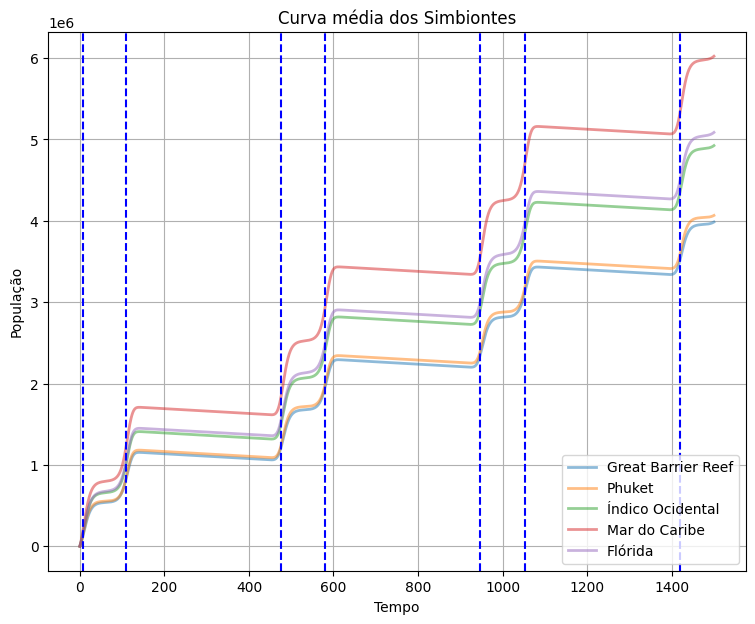

In [ ]:
fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (9,7)
plt.plot(t,media_simb_gbr,alpha=0.5,lw=2 ,label = "Great Barrier Reef")
plt.plot(t,media_simb_phuket,alpha=0.5,lw=2 ,label = "Phuket")
plt.plot(t,media_simb_indico_ocidental,alpha=0.5,lw=2 ,label = "Índico Ocidental")
plt.plot(t,media_simb_western_caribbean,alpha=0.5,lw=2 ,label = "Mar do Caribe")
plt.plot(t,media_simb_florida,alpha=0.5,lw=2 ,label = "Flórida")
plt.title("Curva média dos Simbiontes")
plt.xlabel('Tempo')
plt.ylabel('População')
plt.axvline(x=7, color = "blue",linestyle='--')
plt.axvline(x=109, color = "blue",linestyle='--')
plt.axvline(x=477, color = "blue",linestyle='--')
plt.axvline(x=579, color = "blue",linestyle='--')
plt.axvline(x=947, color = "blue",linestyle='--')
plt.axvline(x=1053, color = "blue",linestyle='--')
plt.axvline(x=1419, color = "blue",linestyle='--')
plt.legend()#bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.yticks(range(0,60000,5000))
plt.grid()
plt.show()

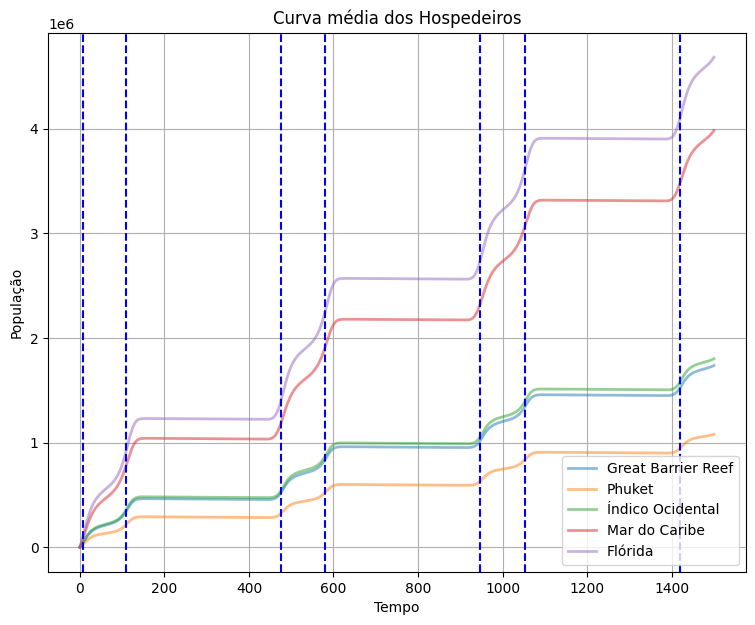

In [ ]:
fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (9,7)
plt.plot(t,media_host_gbr,alpha=0.5,lw=2 ,label = "Great Barrier Reef")
plt.plot(t,media_host_phuket,alpha=0.5,lw=2 ,label = "Phuket")
plt.plot(t,media_host_indico_ocidental,alpha=0.5,lw=2 ,label = "Índico Ocidental")
plt.plot(t,media_host_western_caribbean,alpha=0.5,lw=2 ,label = "Mar do Caribe")
plt.plot(t,media_host_florida,alpha=0.5,lw=2 ,label = "Flórida")
plt.title("Curva média dos Hospedeiros")
plt.xlabel('Tempo')
plt.ylabel('População')
plt.axvline(x=7, color = "blue",linestyle='--')
plt.axvline(x=109, color = "blue",linestyle='--')
plt.axvline(x=477, color = "blue",linestyle='--')
plt.axvline(x=579, color = "blue",linestyle='--')
plt.axvline(x=947, color = "blue",linestyle='--')
plt.axvline(x=1053, color = "blue",linestyle='--')
plt.axvline(x=1419, color = "blue",linestyle='--')
plt.legend()#bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.yticks([0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000, 16000, 17000,18000,19000,20000,21000,22000,23000,24000,25000])
#plt.yticks(range(0,600,50))
plt.grid()
plt.show()

# Correlação entre tolerância térmica e populações finais

## Simbiontes

In [ ]:
G = G0
bipart = nx.get_node_attributes(G, "bipartite")
tol_term = []
for i in G.nodes():
    if bipart[i] == 0:
      tal_s = nx.get_node_attributes(G, "simb_tol")
      tol_term.append(tal_s[i])

pop_final = []
for i in range(len(ret_simb.T)):
  #pop_final.append(ret_simb.T[i][830])
  pop_final.append(np.log(ret_simb.T[i][830]))

res = stats.pearsonr(tol_term, pop_final)
res

PearsonRResult(statistic=np.float64(0.39177598848818973), pvalue=np.float64(0.0004655455009250891))

## Hospedeiros

In [ ]:
tol_term = []
bipart = nx.get_node_attributes(G, "bipartite")
for i in G.nodes():
    if bipart[i] == 1:
      tal_s = nx.get_node_attributes(G, "host_tol")
      tol_term.append(tal_s[i])

pop_final = []
for i in range(len(ret_host.T)):
  #pop_final.append(ret_host.T[i][830])
  pop_final.append(np.log(ret_host.T[i][830]))

res = stats.pearsonr(tol_term, pop_final)
res

PearsonRResult(statistic=np.float64(0.5500353216518871), pvalue=np.float64(4.7305382685790694e-17))

# Correlação entre Grau e Populações finais

## Simbiontes

In [ ]:
bipart = nx.get_node_attributes(G, "bipartite")
graus = []
for i in G.nodes:
  if bipart[i] == 0:
    #print(i)
    k = G.degree(i)
    graus.append(k)

pop_final = []
for i in range(len(ret_simb.T)):
  #pop_final.append(float(ret_simb.T[i][580]))
  pop_final.append(np.log(float(ret_simb.T[i][830])))

res = stats.pearsonr(graus, pop_final)
res

PearsonRResult(statistic=np.float64(-0.410648567690745), pvalue=np.float64(0.000229103498523346))

## Hospedeiros

In [ ]:
graus = []
bipart = nx.get_node_attributes(G, "bipartite")
for i in G.nodes:
  if bipart[i] == 1:
    k = G.degree(i)
    graus.append(k)

pop_final = []
for i in range(len(ret_host.T)):
  #pop_final.append(float(ret_host.T[i][830]))
  pop_final.append(np.log(float(ret_host.T[i][830])))

res = stats.pearsonr(graus, pop_final)
res

PearsonRResult(statistic=np.float64(-0.4809546883914204), pvalue=np.float64(7.402109750948056e-13))

# Correlação entre Grau dos vizinhos e Populações finais

## Simbiontes

In [ ]:
bipart = nx.get_node_attributes(G, "bipartite")
graus_sec = []
for i in G.nodes:
  if bipart[i] == 0:
    k = sum([G.degree(j) for j in G.neighbors(i)])
    graus_sec.append(k)

pop_final_simb = []
for i in range(len(ret_simb.T)):
  #pop_final_simb.append(ret_simb.T[i][830])
  pop_final_simb.append(np.log(ret_simb.T[i][830]))

res = stats.pearsonr(graus_sec, pop_final_simb)
res


PearsonRResult(statistic=np.float64(-0.41702818495649746), pvalue=np.float64(0.00017854877526353978))

## Hospedeiros

In [ ]:
bipart = nx.get_node_attributes(G, "bipartite")
graus = []
for i in G.nodes:
  if bipart[i] == 1:
    k = sum([G.degree(j) for j in G.neighbors(i)])
    graus.append(k)

pop_final_host = []
for i in range(len(ret_host.T)):
  #pop_final_host.append(ret_host.T[i][830])
  pop_final_host.append(np.log(ret_host.T[i][830]))

res = stats.pearsonr(graus, pop_final_host)
res

PearsonRResult(statistic=np.float64(-0.41120339800266303), pvalue=np.float64(1.7676517348174627e-09))

# Spearman

## Simbiontes

In [ ]:
pop_final = []
for i in range(len(ret_simb.T)):
  pop_final.append(ret_simb.T[i][-1])

graus = []
for i in G.nodes:
  if bipart[i] == 0:
    k = G.degree(i)
    graus.append(k)

stats.spearmanr(pop_final,graus)

SignificanceResult(statistic=0.44252077501191706, pvalue=0.023587990036027674)

## Hospedeiros

In [ ]:
pop_final = []
for i in range(len(ret_host.T)):
  pop_final.append((ret_host.T[i][-1]))

graus = []
for i in G.nodes:
  if bipart[i] == 1:
    k = G.degree(i)
    graus.append(k)

stats.spearmanr(pop_final,graus)

SignificanceResult(statistic=0.5536765502497848, pvalue=0.0010113363245392952)

# Distribuição de graus

In [ ]:
Gcc = sorted(nx.connected_components(B_1), key=len, reverse=True)

G0 = B_1.subgraph(Gcc[0]) #GBR
G1 = B_1.subgraph(Gcc[1]) #Phuket
G2 = B_1.subgraph(Gcc[2]) #Índico Ocidental
G3 = B_1.subgraph(Gcc[4]) #Mar do Caribe
G4 = B_1.subgraph(Gcc[10]) #Flórida

G0_top = {n for n, d in G0.nodes(data=True) if d["bipartite"] == 0}
G1_top = {n for n, d in G1.nodes(data=True) if d["bipartite"] == 0}
G2_top = {n for n, d in G2.nodes(data=True) if d["bipartite"] == 0}
G3_top = {n for n, d in G3.nodes(data=True) if d["bipartite"] == 0}
G4_top = {n for n, d in G4.nodes(data=True) if d["bipartite"] == 0}

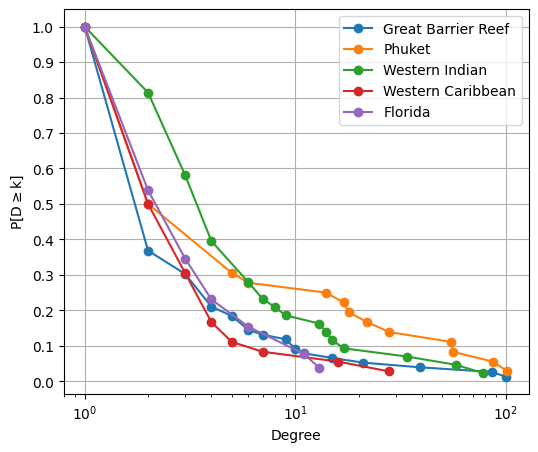

Média dos graus dos simbiontes: 12.277777777777779


In [ ]:
degree_sequence_simb_0 = sorted((G0.degree(n) for n in G0_top), reverse=True)
dmax_simb_0 = max(degree_sequence_simb_0)
degree_sequence_simb_1 = sorted((G1.degree(n) for n in G1_top), reverse=True)
dmax_simb_1 = max(degree_sequence_simb_1)
degree_sequence_simb_2 = sorted((G2.degree(n) for n in G2_top), reverse=True)
dmax_simb_2 = max(degree_sequence_simb_2)
degree_sequence_simb_3 = sorted((G3.degree(n) for n in G3_top), reverse=True)
dmax_simb_3 = max(degree_sequence_simb_3)
degree_sequence_simb_4 = sorted((G4.degree(n) for n in G4_top), reverse=True)
dmax_simb_4 = max(degree_sequence_simb_4)


fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (6,5)

lista = [degree_sequence_simb_0,degree_sequence_simb_1,degree_sequence_simb_2,degree_sequence_simb_3,degree_sequence_simb_4]
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
for i in range(len(lista)):
  degreeCount = collections.Counter(lista[i])
  deg, cnt = zip(*degreeCount.items())
  cnt_c = [ti/len(lista[i]) for ti in cnt]
  cs = np.cumsum(cnt_c)
  plt.plot(deg, cs, "-o", label = legenda[i])
#plt.title("CCDF plot - Symbiote")
plt.ylabel("P[D$\geq$k]")
plt.xlabel("Degree")
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xscale('log')
#plt.xticks(range(0,110,10))
plt.legend()
plt.grid()
plt.show()
#print("Desvio Padrão dos graus dos simbiontes: " + str(np.std(degree_sequence_simb_1)))
print("Média dos graus dos simbiontes: " + str(np.mean(degree_sequence_simb_1)))


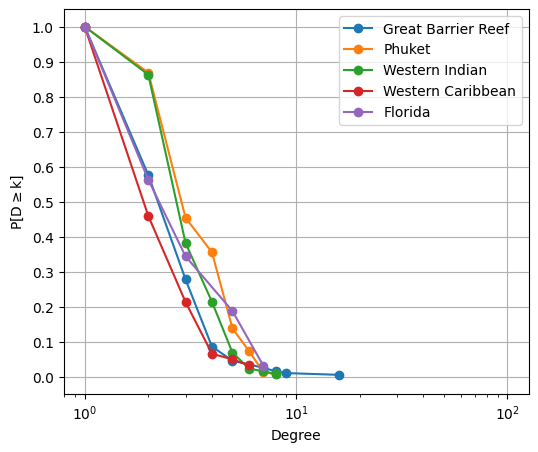

In [ ]:
degree_sequence_host_0 = sorted((G0.degree(n) for n in G0.nodes() - G0_top), reverse=True)
dmax_host_0 = max(degree_sequence_host_0)
degree_sequence_host_1 = sorted((G1.degree(n) for n in G1.nodes() - G1_top), reverse=True)
dmax_host_1 = max(degree_sequence_host_1)
degree_sequence_host_2 = sorted((G2.degree(n) for n in G2.nodes() - G2_top), reverse=True)
dmax_host_2 = max(degree_sequence_host_2)
degree_sequence_host_3 = sorted((G3.degree(n) for n in G3.nodes() - G3_top), reverse=True)
dmax_host_3 = max(degree_sequence_host_3)
degree_sequence_host_4 = sorted((G4.degree(n) for n in G4.nodes() - G4_top), reverse=True)
dmax_host_4 = max(degree_sequence_host_4)


fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (6,5)

lista2 = [degree_sequence_host_0,degree_sequence_host_1,degree_sequence_host_2,degree_sequence_host_3,degree_sequence_host_4]
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
for i in range(len(lista2)):
  degreeCount = collections.Counter(lista2[i])
  deg, cnt = zip(*degreeCount.items())
  cnt_c = [ti/len(lista2[i]) for ti in cnt]
  cs = np.cumsum(cnt_c)
  plt.plot(deg, cs, "-o", label = legenda[i])
#plt.title("CCDF plot - Host")
plt.ylabel("P[D$\geq$k]")
plt.scatter(100,0, color = "white")
plt.xlabel("Degree")
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(np.linspace(0,200,100))
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

# Distribuição das populações finais


In [ ]:
Gcc = sorted(nx.connected_components(B_1), key=len, reverse=True)

G0 = B_1.subgraph(Gcc[0]) #GBR
G1 = B_1.subgraph(Gcc[1]) #Phuket
G2 = B_1.subgraph(Gcc[2]) #Índico Ocidental
G3 = B_1.subgraph(Gcc[4]) #Mar do Caribe
G4 = B_1.subgraph(Gcc[10]) #Flórida

c_0s0, c_0h0 = c_0(G0)
c_0s1, c_0h1 = c_0(G1)
c_0s2, c_0h2 = c_0(G2)
c_0s3, c_0h3 = c_0(G3)
c_0s4, c_0h4 = c_0(G4)

y0_G0 = np.concatenate([76*(1000,),198*(100,)])
y0_G1 = np.concatenate([36*(1000,),152*(100,)])
y0_G2 = np.concatenate([43*(1000,),131*(100,)])
y0_G3 = np.concatenate([36*(1000,),61*(100,)])
y0_G4 = np.concatenate([26*(1000,),32*(100,)])

G0_top, G0_bot = resolver_sistema(76, 198, G0, zi, r0_s, r0_h, y0_G0, t, c_0s0, c_0h0 ,lista_temperaturas)
G1_top, G1_bot = resolver_sistema(36, 152, G1, zi, r0_s, r0_h, y0_G1, t, c_0s1, c_0h1, lista_temperaturas)
G2_top, G2_bot = resolver_sistema(43, 131, G2, zi, r0_s, r0_h, y0_G2, t, c_0s2, c_0h2, lista_temperaturas)
G3_top, G3_bot = resolver_sistema(36, 61, G3, zi, r0_s, r0_h, y0_G3, t, c_0s3, c_0h3, lista_temperaturas)
G4_top, G4_bot = resolver_sistema(26, 32, G4, zi, r0_s, r0_h, y0_G4, t, c_0s4, c_0h4, lista_temperaturas)

In [ ]:
# --- Definir o Caminho no Google Drive ---
# Você pode escolher qualquer pasta no seu Drive.
# Se a pasta 'dados_corais' não existir, ela será criada.
drive_path = '/content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/'
os.makedirs(drive_path, exist_ok=True) # Garante que a pasta exista

# --- Salvar todas as variáveis em um único arquivo .npz ---
# Cada variável é salva com seu nome como chave dentro do arquivo .npz.
np.savez(f'{drive_path}resultados_corais_1modelo[ATUALIZADO].npz',
          G0_top=G0_top, G0_bot=G0_bot,
          G1_top=G1_top, G1_bot=G1_bot,
          G2_top=G2_top, G2_bot=G2_bot,
          G3_top=G3_top, G3_bot=G3_bot,
          G4_top=G4_top, G4_bot=G4_bot)

print(f"✅ Todos os dados foram salvos com sucesso em: {drive_path}resultados_corais.npz")
print("Você pode verificar este arquivo no seu Google Drive.")

✅ Todos os dados foram salvos com sucesso em: /content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/resultados_corais.npz
Você pode verificar este arquivo no seu Google Drive.


In [ ]:
# --- Definir o Caminho do Arquivo no Google Drive ---
# Certifique-se de que este caminho corresponde ao local onde você salvou o arquivo.
drive_path = '/content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/'
file_name = 'resultados_corais_1modelo[ATUALIZADO].npz'
full_path = f'{drive_path}{file_name}'

# --- Carregar os dados do arquivo .npz ---
# O np.load retorna um objeto que se comporta como um dicionário.
try:
    dados_carregados = np.load(full_path)

    # --- Atribuir os dados carregados às suas variáveis originais ---
    G0_top = dados_carregados['G0_top']
    G0_bot = dados_carregados['G0_bot']
    G1_top = dados_carregados['G1_top']
    G1_bot = dados_carregados['G1_bot']
    G2_top = dados_carregados['G2_top']
    G2_bot = dados_carregados['G2_bot']
    G3_top = dados_carregados['G3_top']
    G3_bot = dados_carregados['G3_bot']
    G4_top = dados_carregados['G4_top']
    G4_bot = dados_carregados['G4_bot']

    print(f"✅ Dados carregados com sucesso de: {full_path}")
    print(f"Exemplo - Formato de G0_top: {G0_top.shape}")
    print(f"Exemplo - Formato de G1_bot: {G1_bot.shape}")

    # É uma boa prática fechar o objeto npzfile para liberar recursos
    dados_carregados.close()

except FileNotFoundError:
    print(f"❌ Erro: O arquivo '{file_name}' não foi encontrado em '{drive_path}'.")
    print("Por favor, verifique se o caminho e o nome do arquivo estão corretos no seu Google Drive.")
except Exception as e:
    print(f"❌ Ocorreu um erro ao carregar os dados: {e}")

✅ Dados carregados com sucesso de: /content/drive/MyDrive/Dissertação - Mestrado/Estudos Dirigidos/resultados_corais_1modelo[ATUALIZADO].npz
Exemplo - Formato de G0_top: (1500, 76)
Exemplo - Formato de G1_bot: (1500, 152)


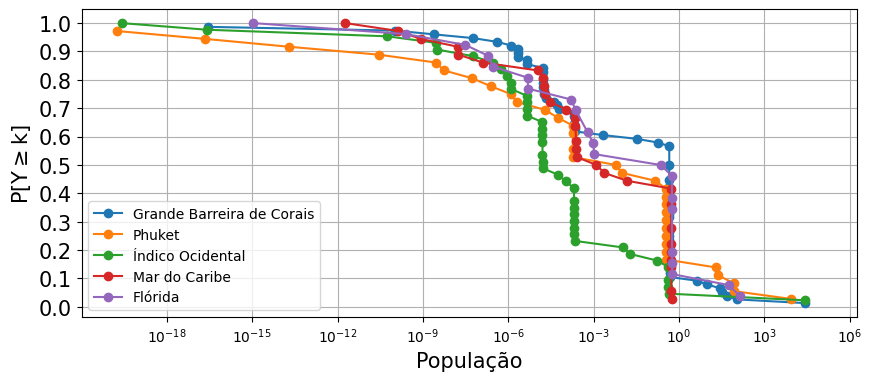

In [ ]:
pop_sequence_simb_0 = sorted([G0_top.T[i][800] for i in range(len(G0_top.T))], reverse=True)
popmax_simb_0 = max(pop_sequence_simb_0)
pop_sequence_simb_1 = sorted([G1_top.T[i][800] for i in range(len(G1_top.T))], reverse=True)
popmax_simb_1 = max(pop_sequence_simb_1)
pop_sequence_simb_2 = sorted([G2_top.T[i][800] for i in range(len(G2_top.T))], reverse=True)
popmax_simb_2 = max(pop_sequence_simb_2)
pop_sequence_simb_3 = sorted([G3_top.T[i][800] for i in range(len(G3_top.T))], reverse=True)
popmax_simb_3 = max(pop_sequence_simb_3)
pop_sequence_simb_4 = sorted([G4_top.T[i][800] for i in range(len(G4_top.T))], reverse=True)
popmax_simb_4 = max(pop_sequence_simb_4)

fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (6,5)

lista = [pop_sequence_simb_0,pop_sequence_simb_1,pop_sequence_simb_2,pop_sequence_simb_3,pop_sequence_simb_4]
#legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
legenda = ["Grande Barreira de Corais", "Phuket", "Índico Ocidental", "Mar do Caribe", "Flórida"]

# Define o limite mínimo para as populações
limite_minimo_populacao = 1e-20

for i in range(len(lista)):
    popCount = collections.Counter(lista[i])
    pop_f, cnt = zip(*popCount.items())
    cnt_c = [ti/len(lista[i]) for ti in cnt]
    cs = np.cumsum(cnt_c)

    # Converte para arrays NumPy para facilitar a filtragem
    pop_f = np.array(pop_f)
    cs = np.array(cs)

    # Filtra os dados: mantém apenas as populações maiores ou iguais ao limite
    mascara = pop_f >= limite_minimo_populacao
    pop_f_filtrada = pop_f[mascara]
    cs_filtrada = cs[mascara]

    plt.plot(pop_f_filtrada, cs_filtrada, "-o", label = legenda[i])

#plt.title("CCDF Final Populations - Symbionts")
plt.scatter(100000,1,color="white")
#plt.scatter(99999999,1,color="white")
plt.ylabel("P[Y$\geq$k]",color = "black", fontsize = 15)
plt.xlabel("População",color = "black", fontsize = 15)
#plt.xlabel("Population size",color = "black", fontsize = 15)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],color = "black", fontsize = 15)
plt.xscale("log")
plt.yticks(fontsize = 15)
plt.legend()
plt.grid()
plt.show()

#print("Desvio Padrão dos graus dos simbiontes: " + str(np.std(degree_sequence_simb_1)))
#print("Média dos graus dos simbiontes: " + str(np.mean(degree_sequence_simb_1)))

## Hospedeiros

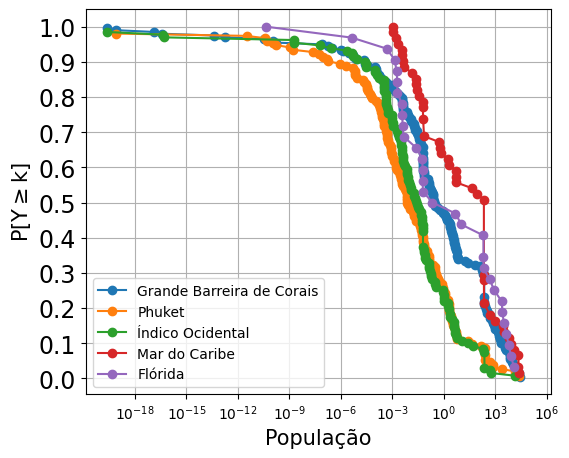

In [ ]:
pop_sequence_host_0 = sorted([G0_bot.T[i][800] for i in range(len(G0_bot.T))], reverse=True)
popmax_host_0 = max(pop_sequence_host_0)
pop_sequence_host_1 = sorted([G1_bot.T[i][800] for i in range(len(G1_bot.T))], reverse=True)
popmax_host_1 = max(pop_sequence_host_1)
pop_sequence_host_2 = sorted([G2_bot.T[i][800] for i in range(len(G2_bot.T))], reverse=True)
popmax_host_2 = max(pop_sequence_host_2)
pop_sequence_host_3 = sorted([G3_bot.T[i][800] for i in range(len(G3_bot.T))], reverse=True)
popmax_host_3 = max(pop_sequence_host_3)
pop_sequence_host_4 = sorted([G4_bot.T[i][800] for i in range(len(G4_bot.T))], reverse=True)
popmax_host_4 = max(pop_sequence_host_4)


fig = plt.figure(facecolor = 'w')
plt.rcParams['figure.figsize'] = (6,5)

lista = [pop_sequence_host_0,pop_sequence_host_1,pop_sequence_host_2,pop_sequence_host_3,pop_sequence_host_4]
#legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
legenda = ["Grande Barreira de Corais", "Phuket", "Índico Ocidental", "Mar do Caribe", "Flórida"]

# Define o limite mínimo para as populações
limite_minimo_populacao = 1e-20

for i in range(len(lista)):
  popCount = collections.Counter(lista[i])
  pop_f, cnt = zip(*popCount.items())
  cnt_c = [ti/len(lista[i]) for ti in cnt]
  cs = np.cumsum(cnt_c)

  # Crie uma máscara booleana para filtrar os valores
  # Lembre-se que pop_f e cs precisam ter o mesmo comprimento para a máscara funcionar
  # e que o zip transforma em tuplas, então converta para lista ou array numpy se precisar

  # Para garantir que pop_f e cs são arrays numpy para fácil filtragem
  pop_f = np.array(pop_f)
  cs = np.array(cs)

  # Filtra os dados: mantém apenas as populações maiores ou iguais ao limite
  mascara = pop_f >= limite_minimo_populacao
  pop_f_filtrada = pop_f[mascara]
  cs_filtrada = cs[mascara]

  # Plota os dados filtrados
  plt.plot(pop_f_filtrada, cs_filtrada, "-o", label = legenda[i])

#plt.title("CCDF Final Populations - Hosts")
plt.scatter(100000,1,color="white")
plt.ylabel("P[Y$\geq$k]",color = "black", fontsize = 15)
plt.xlabel("População",color = "black", fontsize = 15)
#plt.xlabel("Population size",color = "black", fontsize = 15)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],color = "black", fontsize = 17)
plt.xscale("log")
plt.legend()
#plt.title("CCDF plot - Host") # Comentado, como no seu original
plt.grid()
plt.show()

# Comparação entre simbiontes iguais

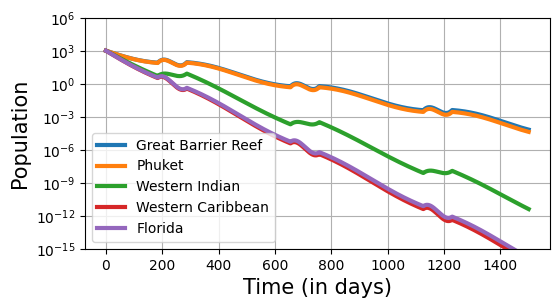

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)
lista_D1 = [G0_top.T[3],G1_top.T[32],G2_top.T[39],G3_top.T[19],G4_top.T[2]]
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
for i in range(len(lista)):
  plt.plot(t, lista_D1[i],label = legenda[i], linewidth = 3)

plt.ylabel("Population",color = "black", fontsize = 15)
plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend()
#plt.title("Population dynamics of the symbiont D1 in different regions")
plt.yscale('log')
plt.ylim(10e-16, 10e5)
#plt.yticks(range(0,1500,250))
plt.grid()
plt.show()

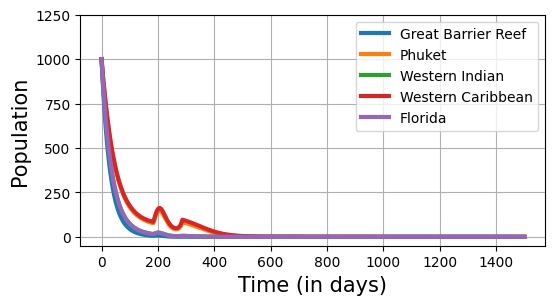

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)
lista_C1 = [G0_top.T[60],G1_top.T[10],G2_top.T[37],G3_top.T[3],G4_top.T[18]]
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
for i in range(len(lista)):
  plt.plot(t, lista_C1[i], label = legenda[i], linewidth = 3)

plt.ylabel("Population",color = "black", fontsize = 15)
plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend()
#plt.title("Population dynamics of the symbiont C1 in different regions")
#plt.ylim(10e-16, 10e5)
#plt.yscale('log')
plt.yticks(range(0,1500,250))
plt.grid()
plt.show()

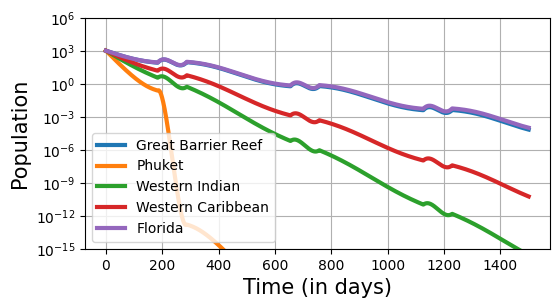

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)

lista_C3 = [G0_top.T[20],G1_top.T[13],G2_top.T[3],G3_top.T[18],G4_top.T[10]]
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
for i in range(len(lista)):
  plt.plot(t, lista_C3[i], label = legenda[i], linewidth = 3)

plt.ylabel("Population",color = "black", fontsize = 15)
plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend()
#plt.title("Population dynamics of the symbiont C3 in different regions")
plt.yscale('log')
plt.ylim(10e-16, 10e5)
#plt.yticks(range(0,1500,250))
plt.grid()
plt.show()

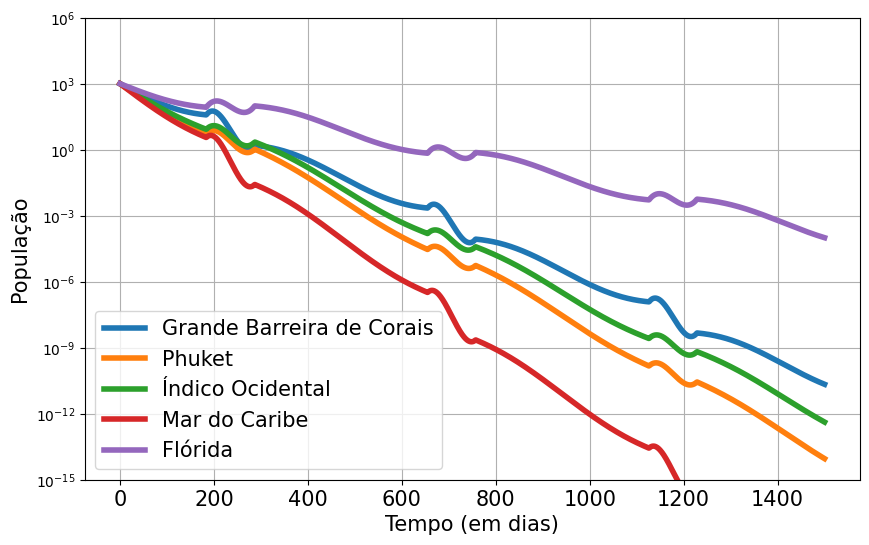

In [ ]:
plt.rcParams['figure.figsize'] = (10,6)

lista_D1a = [G0_top.T[25],G1_top.T[21],G2_top.T[26],G3_top.T[5],G4_top.T[11]]
#legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Western Caribbean", "Florida"]
legenda = ["Grande Barreira de Corais", "Phuket", "Índico Ocidental", "Mar do Caribe", "Flórida"]
for i in range(len(lista)):
  plt.plot(t, lista_D1a[i], label = legenda[i],  linewidth = 4)

#plt.ylabel("Population",color = "black", fontsize = 15)
plt.ylabel("População",color = "black", fontsize = 15)
#plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.xlabel("Tempo (em dias)",color = "black", fontsize = 15)
plt.legend(fontsize=15)
#plt.title("Population dynamics of the symbiont D1a in different regions")
plt.yscale('log')
plt.ylim(10e-16, 10e5)
#plt.yticks(range(0,1250,250), fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid()
plt.show()

# Comparação entre hospedeiros iguais

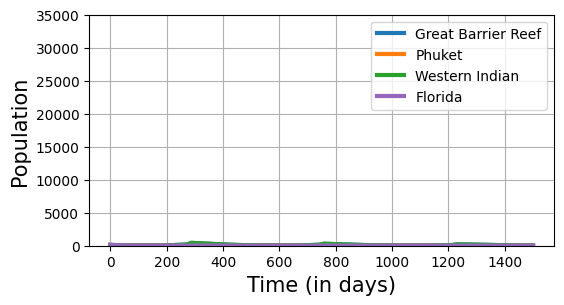

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)

#lista_PD = [G0_bot.T[232],G1_bot.T[124],G2_bot.T[54],G4_bot.T[55]]
lista_PD = [G0_bot.T[232-76],G1_bot.T[124-36],G2_bot.T[54-43],G4_bot.T[55-26]]

colors = ['C0', 'C1', 'C2', 'C4']
#legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Florida"]

for i in range(len(lista_PD)):
  plt.plot(t, lista_PD[i], color = colors[i], label = legenda[i], linewidth = 3)

plt.ylabel("Population",color = "black", fontsize = 15)
plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend()
#plt.title("Population dynamics of the host $Pocillopora$ $damicornis$\n in different regions")
#plt.yscale('log')
#plt.ylim(10e-16, 10e5)
plt.yticks(range(0,40000,5000))
plt.grid()
plt.show()

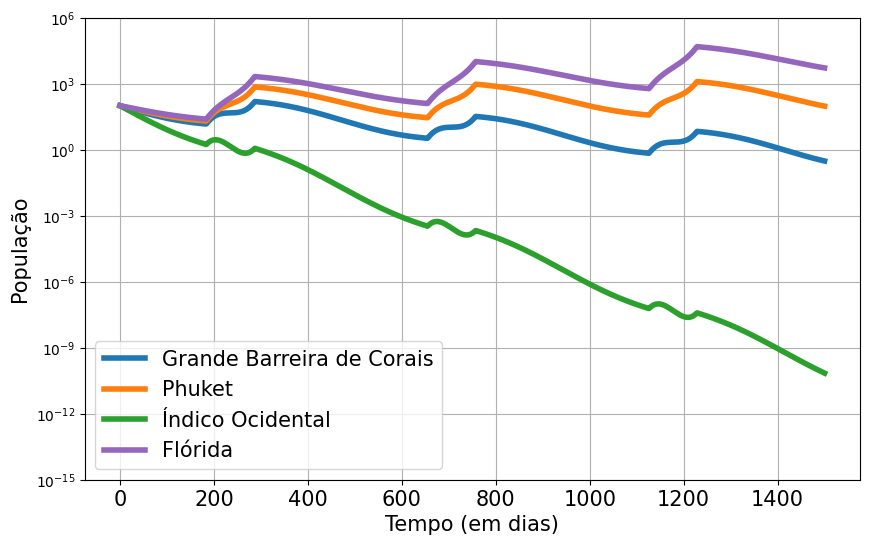

In [ ]:
plt.rcParams['figure.figsize'] = (10,6)

#lista_AT = [G0_bot.T[240],G1_bot.T[75],G2_bot.T[57],G4_bot.T[31]]
lista_AT = [G0_bot.T[240-76],G1_bot.T[75-36],G2_bot.T[57-43],G4_bot.T[31-26]]

colors = ['C0', 'C1', 'C2', 'C4']
legenda = ["Grande Barreira de Corais", "Phuket", "Índico Ocidental", "Flórida"]
#legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Florida"]
for i in range(len(lista_AT)):
  plt.plot(t, lista_AT[i], color = colors[i], label = legenda[i], linewidth = 4)

#plt.ylabel("Population",color = "black", fontsize = 15)
#plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.ylabel("População",color = "black", fontsize = 15)
plt.xlabel("Tempo (em dias)",color = "black", fontsize = 15)
plt.legend(fontsize=15)
#plt.title("Population dynamics of the host $Acropora$ $tenuis$ \n in different regions")
plt.yscale('log')
plt.ylim(10e-16, 10e5)
#plt.yticks(range(0,60000,10000), fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid()
plt.show()

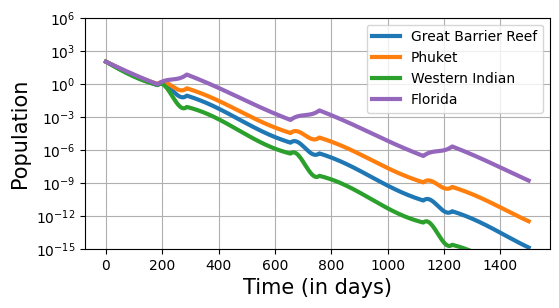

In [ ]:
plt.rcParams['figure.figsize'] = (6,3)

#lista_AV = [G0_bot.T[96],G1_bot.T[123],G2_bot.T[79],G4_bot.T[53]]
lista_AV = [G0_bot.T[96-76],G1_bot.T[123-36],G2_bot.T[79-43],G4_bot.T[53-26]]

colors = ['C0', 'C1', 'C2', 'C4']
legenda = ["Great Barrier Reef", "Phuket", "Western Indian", "Florida"]
for i in range(len(lista_AV)):
  plt.plot(t, lista_AV[i], color = colors[i],label = legenda[i], linewidth = 3)

plt.ylabel("Population",color = "black", fontsize = 15)
plt.xlabel("Time (in days)",color = "black", fontsize = 15)
plt.legend()
#plt.title("Population dynamics of the host $Acropora$ $valida$ \n in different regions")
plt.yscale('log')
plt.ylim(10e-16, 10e5)
#plt.yticks(range(0,40000,5000))
plt.grid()
plt.show()

# Equação de variação da temperatura

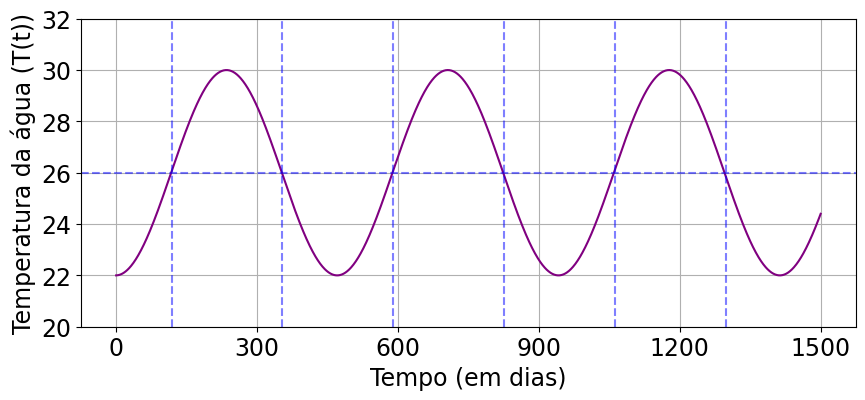

In [ ]:
lista_Tz = []
t = np.linspace (0, 1500,1500)
for tempo in t:
  Ti = (4)*np.cos(tempo/75 + 22) + 26
  lista_Tz.append(Ti)

plt.rcParams['figure.figsize'] = (10,4)
plt.plot(t,lista_Tz,color = "purple")
#plt.axhline(y=29.1, color = "red",linestyle='--')


plt.axvline(x=118, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=354, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=590, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=826, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=1062, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=1298, color = "blue",linestyle='--', alpha = 0.5)
"""plt.axvline(x=1593, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=1696, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=2063, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=2166, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=2533, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=2636, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=3003, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=3106, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=3473, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=3576, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=3943, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=4046, color = "blue",linestyle='--', alpha = 0.5)
plt.axvline(x=4413, color = "blue",linestyle='--', alpha = 0.5)"""
plt.axhline(y = 26,color = "blue",linestyle='--', alpha = 0.5)
plt.yticks(range(20,33,2),color = "black", fontsize = 17)
plt.xticks(range(0,1800,300),color = "black", fontsize = 17)
plt.ylabel('Temperatura da água (T(t))',color = "black", fontsize = 17) #eixo y legenda
plt.xlabel('Tempo (em dias)',color = "black", fontsize = 17) #eixo x legenda
plt.grid() #grade
plt.show()